# How to get Data?

You need to create a developer account on twitter in order to read the data through API. Once you create the account, you need to create an app (*just consider it as a sub-acccount*) and get access keys. Visit the below link to know how?

https://developer.twitter.com/en/apply-for-access


# Install Required Packages

In [12]:
!pip install wordcloud
!pip install spacy
!pip install tweepy

#it may be possible that below models wont install through spacy package
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.2.0/en_core_web_md-2.2.0.tar.gz
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

# Downloading Data
For this experiment, we will be using 2000 tweets posted under hashtags #coronavirus, #COVID19 and #CoronavirusOutbreak. We cant get tweets older than 7 days from API. I have used API.search method and tweets will be saved as a json string into a file named data.json for easy parsing.
You  can also pull data by passing various methods and get different type of data like retweets,followers,etc. Below is the link for various wrapper methods:

http://docs.tweepy.org/en/latest/api.html#tweepy-api-twitter-api-wrapper

In [15]:
import tweepy as tw
import pandas as pd
import json

# App Auth : get these authetication keys from dev.twitter.com
consumer_key = 'XXXXXXXXX'
consumer_secret = 'XXXXXXXXXX'
access_key = 'XXXXXXXXXX'
access_secret = 'XXXXXXXXXXX'

# Initialize API
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth, wait_on_rate_limit=True)

# Search terms
search_words = ["#coronavirus", "#COVID19", "#CoronavirusOutbreak"]
# Mention the from date
date_since = "2020-04-01"

# Collect tweets
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
                   #result_type='popular',
                   include_entities = False,
              since=date_since, #tweet_mode='extended',
              include_rts=False).items(2000)

tweets_arr = []

# Iterate and print tweets
for tweet in tweets:
    tweets_arr.append(tweet._json)
print("Done")

#Get the data in dataframe
df = pd.DataFrame(tweets_arr)
df.head(3)

#store the tweets in json for future use
with open("data.json", "w+") as output:
    output.write(json.dumps(tweets_arr))

Done


# Reuse the tweets in json file

In [243]:
# Reading json file from path 
import pandas as pd

#Get the data in dataframe
df= pd.read_json("data.json")
df.head(1)

,created_at,id,id_str,text,truncated,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status
0,2020-05-10 09:37:15+00:00,1259417204753346561,1259417204753346560,RT @DrDenaGrayson: I appeared on @SkyNews and ...,False,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,False,4767,0,False,False,en,NaN,NaN,NaN,NaN


# Wordcloud Using PorterStemmer

## Preprocessing Data
Since we are downloading data from a public source, we must use some preprocessing in order to retain useful wordings for downstream analysis. There are few common techniques of preprocessing natural language content.

#### Tokenisation
Here we break text into sentences i.e. sentence tokenisation and break sentences again into works i.e. word tokenisation. In this article we will perform word tokenisation at once since tweets are mostly shorter than typical social media content.

#### Removal of stop words
The English language consists of several stop words that add meaning in sentences but not in context. For example words such as is are was has , etc. do not add value for our use case.

#### Lexicon Normalisation
This is the process where we get rid of forms of words thus retaining a single representation. For example; play, playing, playable, etc. can be reduced to “play” and retain the core meaning.

There are two forms of this normalisation.
1. Stemming — This is where we get rid of affixes (prefixes and suffixes). The example related to the word “play” comes under this category
2. Lemmatisation — This is where we do stemming with context awareness. For example, knowing whether a word is a noun or a verb has a significant effect on stemming. For example; dryer might turn out to be dry whereas it actually is a noun. 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


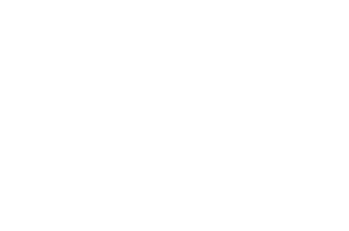

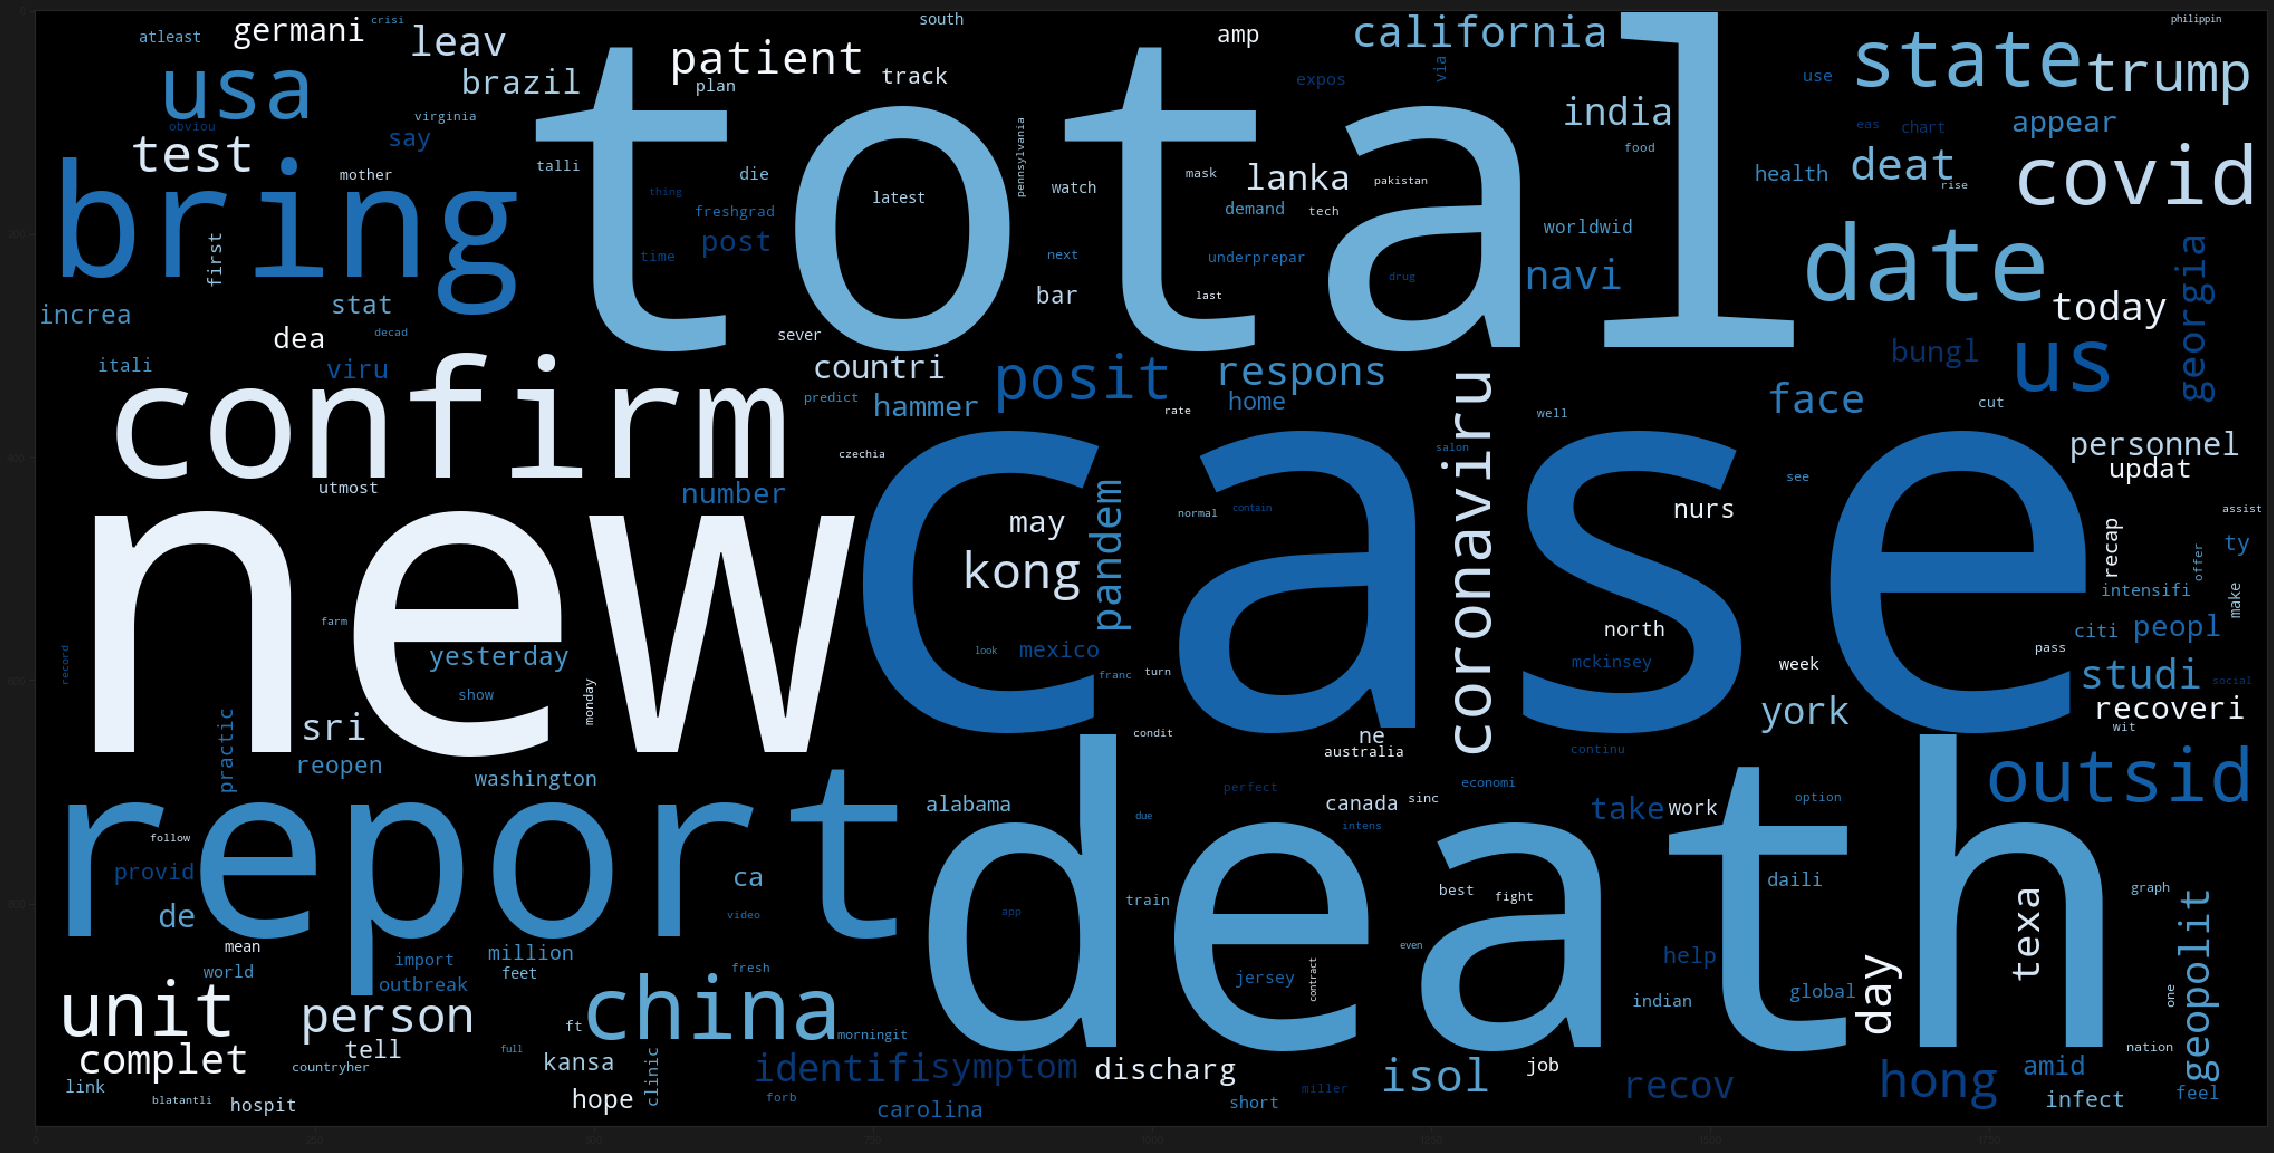

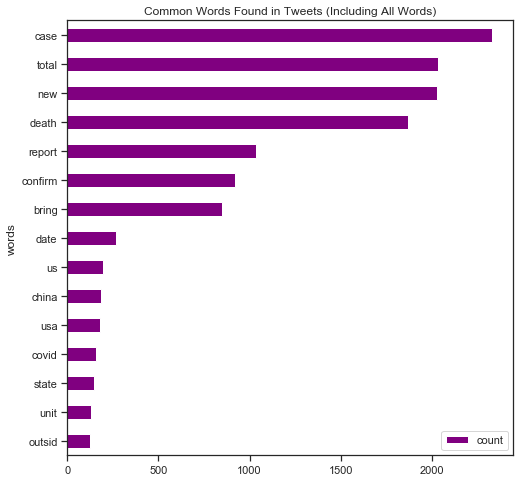

In [244]:

# NLP imports
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# pandas
import pandas as pd
import itertools
import collections
import string

# preprocessor data sources and instances
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

# python imports
import re
import json
from collections import Counter
from matplotlib import pyplot as plt

# seaborn import
import seaborn as sns

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()
tf = TfidfVectorizer()

sentences =[]
sentences_processed=[]

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

for tweet_text in df.text:
        # remove mentions, hashtags and punctuatoins
        tweet_text = re.sub(r'RT', '', tweet_text).lower()
        tweet_text1 = re.sub(r'RT|@[a-zA-Z0-9_]+|:|#[a-zA-Z0-9_]+|[0-9]+|,|\'|\"|\`|…', '', tweet_text)
        tweet_text2 = re.sub(r'  ', ' ', tweet_text1.strip())
        #remove urls from tweets
        tweet_text3 = re.sub(r'http\S+', '', tweet_text2, flags=re.MULTILINE) 
        tweet_text4 = deEmojify(tweet_text3)
        tweet_text5 = tweet_text4.translate(str.maketrans('', '', string.punctuation))
        sentences.append(tweet_text5)
        
# At this point we have sentences
for sentence in sentences:
    # Obtain work tokens
    tokenized_words = word_tokenize(sentence)
    # Remove stop words
    filtered_words = list(filter(lambda x: x not in stop_words, tokenized_words))
    # Stemming words (lematization is better but requires POS tagging which)
    stemmed_words = list(map(ps.stem, filtered_words))
    #stemmed_words = list(map(lemmatizer.lemmatize, filtered_words))
    sentences_processed.append(" ".join(stemmed_words))

words_in_tweet = [tweet.lower().split() for tweet in sentences_processed]

#print(words_in_tweet)

all_words_nsw = list(itertools.chain(*words_in_tweet))

counts_nsw = collections.Counter(all_words_nsw)

#print(counts_nsw.most_common(100))

#####################################################################################################

# Word cloud for most mentioned words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 += " " + ele   
    
    # return string   
    return str1  

all_words=listToString(all_words_nsw)


# Create the wordcloud object
wordcloud = WordCloud(width=2000, height=1000,collocations=False, margin=5,colormap="Blues").generate(all_words)
 
# Display the generated image:
#plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize = (40, 30),facecolor = 'k',edgecolor = 'k')
plt.margins(x=0, y=0)
plt.imshow(wordcloud )

#######################################################################################

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
pd.DataFrame(counts_nsw.most_common(15),columns=['words','count']).sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()
#####################################################################################################


# Wordcloud Using Wordnet lemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('case', 2330), ('total', 2035), ('new', 2027), ('death', 1866), ('report', 1032), ('confirm', 903), ('bring', 850), ('date', 269), ('china', 185), ('usa', 183), ('covid', 161), ('state', 146), ('united', 132), ('outside', 128), ('coronavirus', 93)]
 
 
 


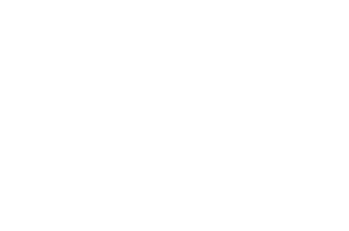

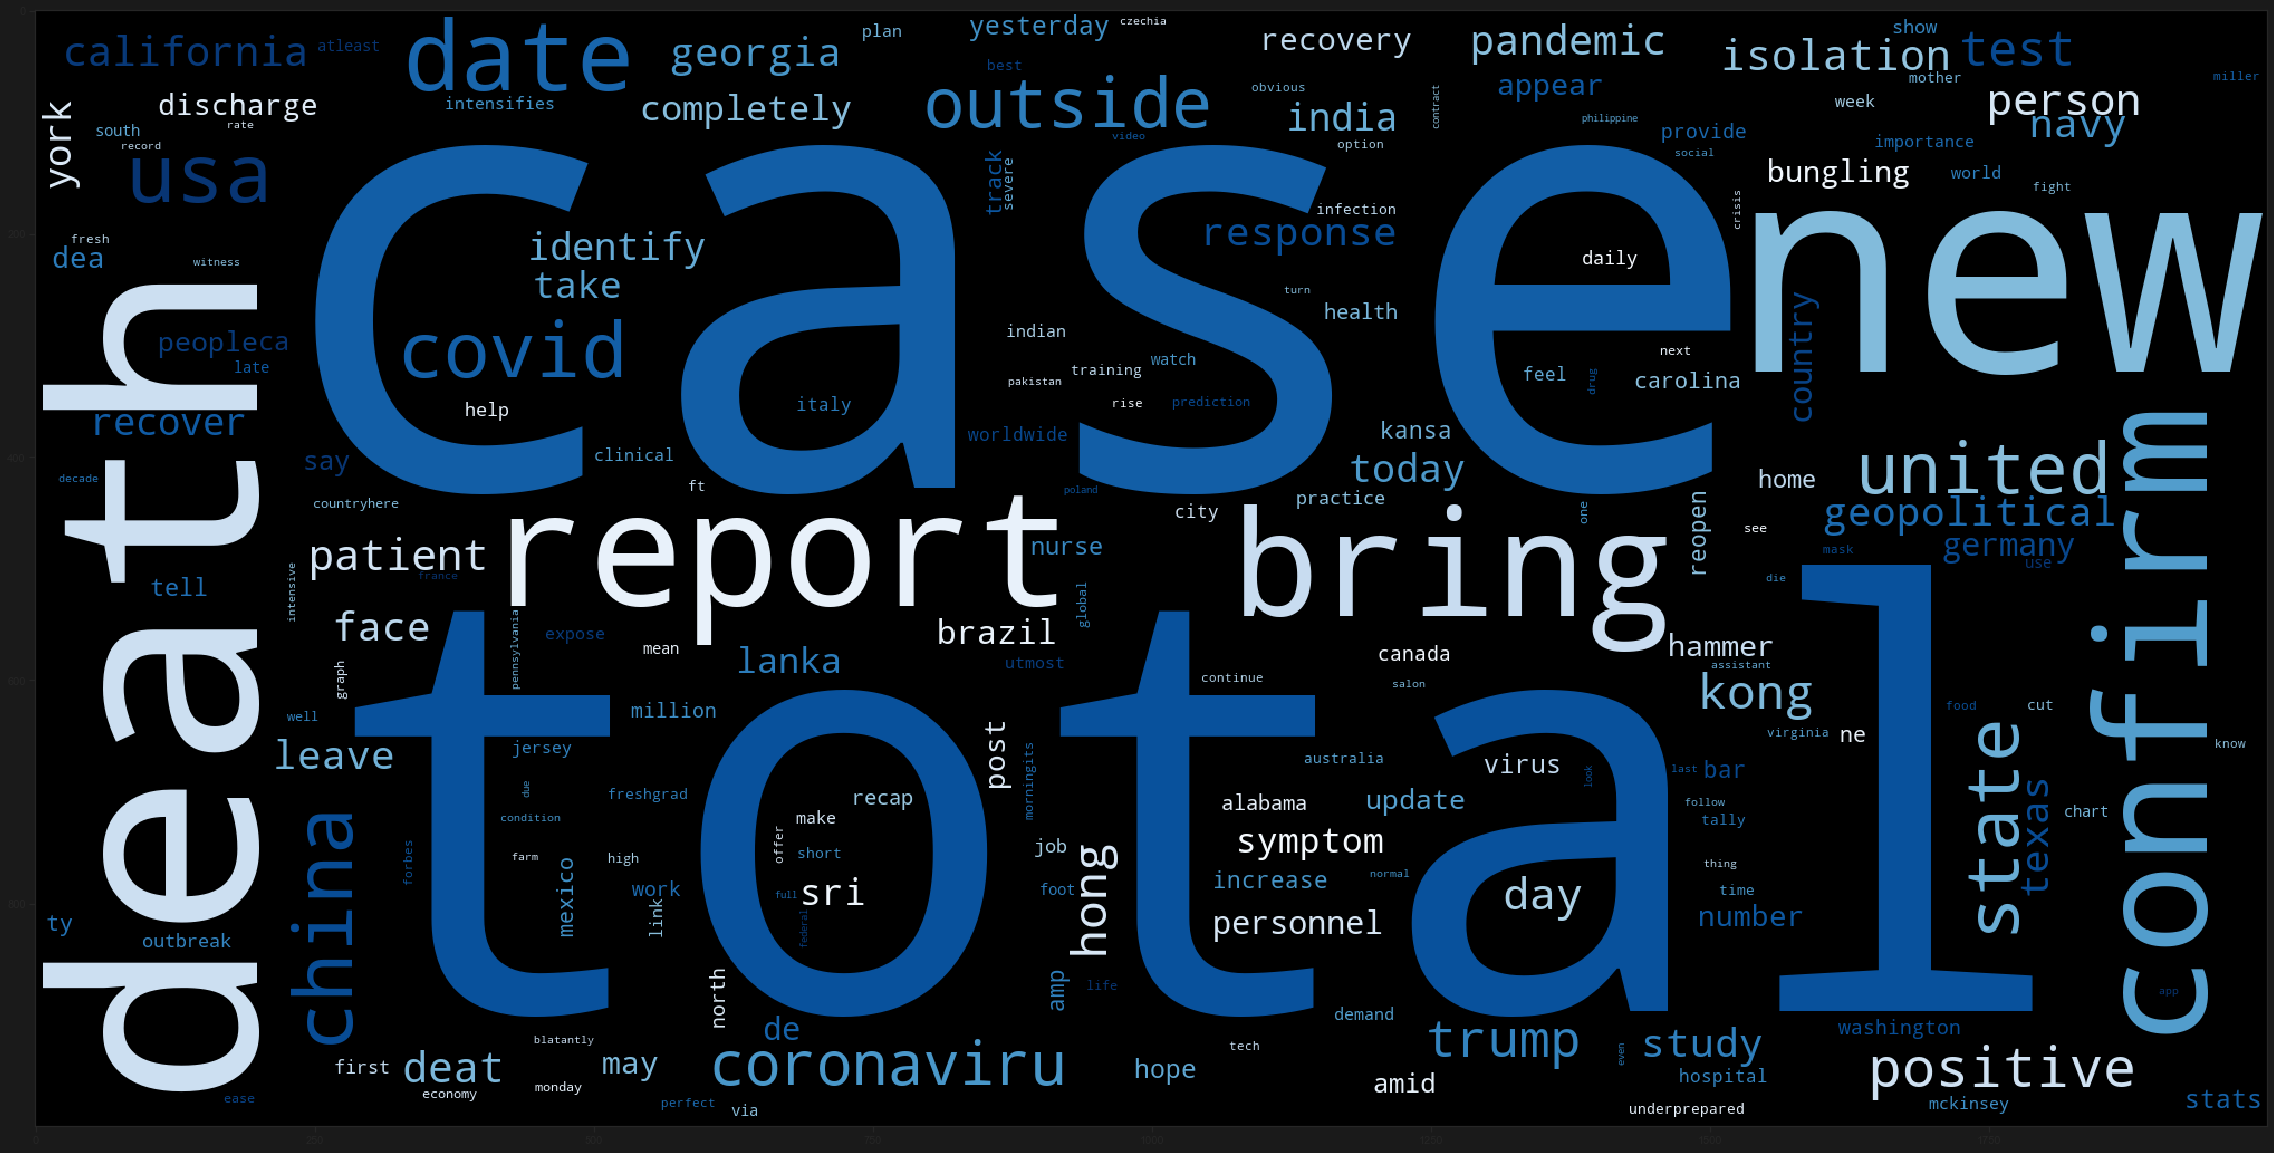

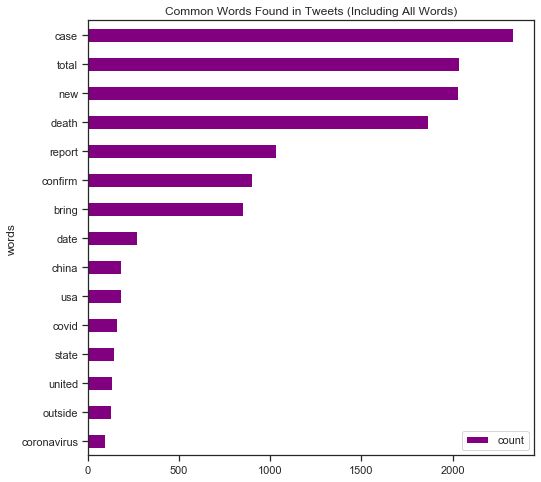

In [245]:
# NLP imports
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.stem import *
from nltk.stem.snowball import *

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# pandas
import pandas as pd
import itertools
import collections
import string


# python imports
import re
import json
from collections import Counter
from matplotlib import pyplot as plt

# seaborn import
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# preprocessor data sources and instances
stop_words = set(stopwords.words("english"))
stop_words.add('u')
ps = PorterStemmer()
tf = TfidfVectorizer()
sb = SnowballStemmer("english")

sentences= []
stemmed_words_wn=[]

for tweet_text in df.text:
        # remove mentions, hashtags and punctuatoins
        tweet_text = re.sub(r'RT', '', tweet_text).lower()
        tweet_text1 = re.sub(r'@[a-zA-Z0-9_]+|:|#[a-zA-Z0-9_]+|[0-9]+|,|\'|\"|\`|…', '', str(tweet_text))
        tweet_text2 = re.sub(r'  ', ' ', tweet_text1.strip())
        #remove urls from tweets
        tweet_text3 = re.sub(r'http\S+', '', tweet_text2, flags=re.MULTILINE) 
        tweet_text4 = deEmojify(tweet_text3)
        tweet_text5 = tweet_text4.translate(str.maketrans('', '', string.punctuation))
        sentences.append(tweet_text5)

# At this point we have sentences
for sentence in sentences:
    # Obtain work tokens
    tokenized_words = word_tokenize(sentence)
    # Stemming words (lematization is better but requires POS tagging which)
    stemmed_words_sb = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_words]
    # Remove stop words
    filtered_words = list(filter(lambda x: x not in stop_words, stemmed_words_sb))
    stemmed_words_wn.append(filtered_words)


words_in_tweet = [tweet for tweet in stemmed_words_wn]

all_words_nsw = list(itertools.chain(*words_in_tweet))

counts_nsw = collections.Counter(all_words_nsw)

print(counts_nsw.most_common(15))

#####################################################################################################

# Word cloud for most mentioned words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 += " " + ele   
    
    # return string   
    return str1  

all_words=listToString(all_words_nsw)

mostcommon_words = pd.DataFrame(counts_nsw.most_common(15),columns=['words','count']).sort_values(by='count')

##########################################################################################

# Create the wordcloud object
wordcloud = WordCloud(width=2000, height=1000,collocations=False, margin=5,colormap="Blues").generate(all_words)
 
# Display the generated image:
#plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize = (40, 30),facecolor = 'k',edgecolor = 'k')
plt.margins(x=0, y=0)
plt.imshow(wordcloud )

print( " \n \n ")

#######################################################################################

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
mostcommon_words.plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()
#####################################################################################################


# Difference betwwen Stemmer and Lemmatizer 

From the above two plots we can see the Lemmatizer with POS tag gives more accurate keys than stemmer. Have a look at words like Outside, coronavirus, pandemic, etc.

# Sentimental Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


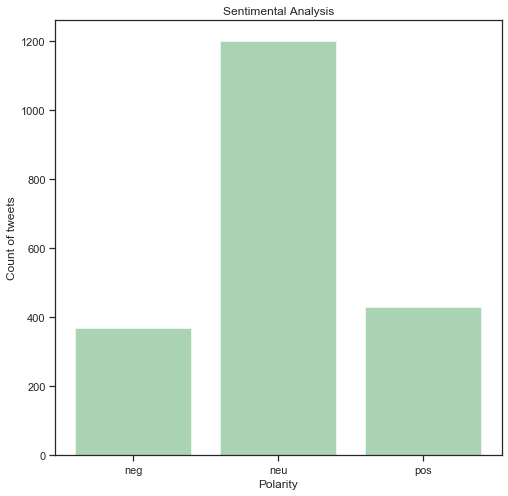

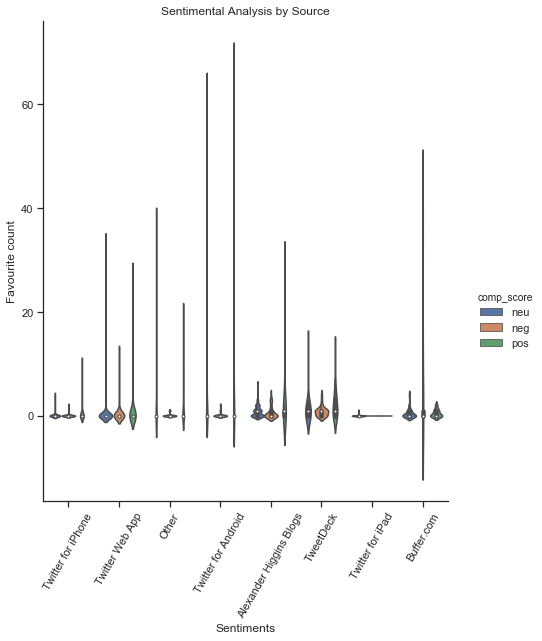

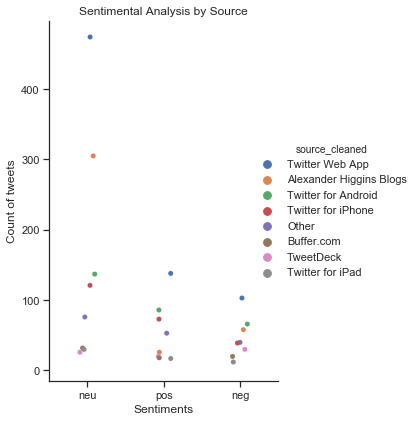

In [240]:
# NLP imports
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# pandas
import pandas as pd
import itertools
import collections
import string
import numpy as np 

# python imports
import re
import json
from collections import Counter
from matplotlib import pyplot as plt


# preprocessor data sources and instances
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

# seaborn import
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()
tf = TfidfVectorizer()

#Funtion to remove the emojis
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

#Classify sentiments as positive, negative and neutral
def sentiment_classifier(value):
    if value>0:
        senti= 'pos'
    elif value<0:
        senti= 'neg'
    else: 
        senti= 'neu'
    return senti

#Classify sources
def sentiment_classifier(value):
    if value>0:
        senti= 'pos'
    elif value<0:
        senti= 'neg'
    else: 
        senti= 'neu'
    return senti

def clean_tweet(df):
    # remove mentions, hashtags and punctuatoins
    tweet_text1 = re.sub(r'RT|@[a-zA-Z0-9_]+|:|#[a-zA-Z0-9_]+|,|\'|\"|\`|…', '', str(df))
    tweet_text2 = re.sub(r'  ', ' ', tweet_text1.strip())
    #remove urls from tweets
    tweet_text3 = re.sub(r'http\S+', '', tweet_text2, flags=re.MULTILINE) 
    return tweet_text3

## declare blank list to clean source column
source_cured=[]

def source_curator(source):
    for j in source:
        k = re.sub(r' ', '', j.strip())
        l = re.sub(r'RT|@[a-zA-Z0-9_]+|:|#[a-zA-Z0-9_]+|,|\'|\"|\`|…', '', str(k))
        i = pd.Series(l)
        if i.str.contains('TwitterforiPad').any():
            source_cured.append("Twitter for iPad")
        elif i.str.contains('TwitterforAndroid',).any():
            source_cured.append("Twitter for Android")
        elif i.str.contains('TwitterWebApp').any():
            source_cured.append("Twitter Web App")
        elif i.str.contains('TwitterforiPhone').any():
            source_cured.append("Twitter for iPhone")
        elif i.str.contains('AlexanderHiggins').any():
            source_cured.append("Alexander Higgins Blogs")
        elif i.str.contains('TweetDeck').any():
            source_cured.append("TweetDeck")
        elif i.str.contains('Buffer').any():
            source_cured.append("Buffer.com")
        else: 
            source_cured.append("Other")    
    return source_cured


df['cleaned_tweet'] = df['text'].apply(lambda text: clean_tweet(text))
df['source_cleaned'] = source_curator(df['source'])

# get the polarity scores
df['scores'] = df['cleaned_tweet'].apply(lambda cleaned_tweet: analyser.polarity_scores(cleaned_tweet))
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['comp_score'] = df['compound'].apply(lambda compound: sentiment_classifier(compound))

#######################################################################################

x = sorted(df['comp_score'].unique().tolist())
y = df['id'].groupby(df['comp_score']).size().tolist()
y_pos = np.arange(len(x))

#######################################################################################

fig, ax = plt.subplots(figsize=(8, 8))

plt.bar(x, y, align='center', alpha=0.5, color = 'g')
plt.xticks(y_pos, x)
plt.ylabel('Count of tweets')
plt.xlabel('Polarity')
plt.title('Sentimental Analysis')

plt.show()

#######################################################################################

sns.set(style="ticks")
g = sns.catplot(x="source_cleaned", y="favorite_count",hue='comp_score', data=df, kind='violin')
g.set_xticklabels(rotation=60)
plt.ylabel('Favourite count')
plt.xlabel('Sentiments')
plt.title('Sentimental Analysis by Source')
g.fig.set_size_inches(8,8)
#######################################################################################

aggregates_bysource= df.groupby(['source_cleaned', 'comp_score']).size().to_frame('count').reset_index().sort_values(['count'], ascending=False)
#aggregates_bysource = aggregates_bysource.reset_index()
#aggregates_bysource.set_index(['size'],inplace=True)
sns.set(style="ticks")
g = sns.catplot(x="comp_score", y="count",hue='source_cleaned', data=aggregates_bysource)
plt.ylabel('Count of tweets')
plt.xlabel('Sentiments')
plt.title('Sentimental Analysis by Source')
g.fig.set_size_inches(6,6)
#######################################################################################



### From above figures we can see more neutral tweets from Twitter Web App, Twitter for Android and AHB. 

# Emotion Classification of words

In [246]:
import en_core_web_md
nlp = en_core_web_md.load()

##Pull the data for words by emotions
data = pd.read_csv("Basic_Emotions.csv")

## Use below list if not using csv
emotion_words = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'surprise', 'trust', 'sadness']

#get required columns from emotion data
emotions = data[data.Emotion.notnull()][['Emotion','Word']]
print(emotions.head(1))
print('\n')
print(emotions['Word'].groupby(emotions['Emotion']).count())

#all words in tweets
words_counts = pd.DataFrame(counts_nsw.most_common(),columns=['words','count'])
print(words_counts.head(1))

dictionary={}
emotion_words= []
tweet_words= []
matching_score= []

def dict_similarity(i):
  for i in i:  #words_counts.count()[0]
    token1 = nlp(words_counts['words'][i])
    for token2 in emotions.Emotion.unique(): # replce this by emotion_words if not using csv
      token2 = nlp(token2)      
      similarity_score = token1.similarity(token2)
      tweet_words.append(str(token1))
      emotion_words.append(str(token2))
      matching_score.append(similarity_score)
      print(token1,token2,similarity_score)

  return pd.DataFrame(list(zip(tweet_words, emotion_words,matching_score)), columns =['tweet_words', 'emotion_words','similarity_score'])

#df_emotion= dict_similarity(range(1)) #words_counts.count()[0]
df_emotion= dict_similarity(range(words_counts.count()[0])) 
df_emotion.head()

  Emotion   Word
0   anger  rough


Emotion
anger       1250
anticip      842
disgust     1060
fear        1483
joy          691
negative    3338
positive    2317
sadness     1195
surprise     535
trust       1234
Name: Word, dtype: int64
  words  count
0  case   2330
case anger 0.2189377668302087


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


case anticip 0.0
case disgust 0.12620047698427306
case fear 0.2880264464198502
case joy 0.13475972687075477
case negative 0.3145562026998337
case positive 0.31536207427613233
case surprise 0.3280337016561413
case trust 0.2750124633792471
case sadness 0.156206712857851
total anger 0.15976404839223382
total anticip 0.0
total disgust 0.1677540376699229
total fear 0.20529817531407982
total joy 0.199739608441489
total negative 0.3576911327471728
total positive 0.35205096128900604
total surprise 0.22911411481633198
total trust 0.2366993751597666
total sadness 0.16221959488668777
new anger 0.1622280990709374
new anticip 0.0
new disgust 0.03695404056268867
new fear 0.27226933214833904
new joy 0.28474648882592
new negative 0.2198427273229031
new positive 0.321532043963742
new surprise 0.38309294196141147
new trust 0.3074099934822826
new sadness 0.10912094963136176
death anger 0.40638580973031274
death anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


death disgust 0.2829051726002099
death fear 0.521018151784653
death joy 0.38306764087835365
death negative 0.279159306298561
death positive 0.23646371168366462
death surprise 0.3591731490324783
death trust 0.32809398749819607
death sadness 0.4518806053422321
report anger 0.19056718566634126
report anticip 0.0
report disgust 0.10840181111689762
report fear 0.25598101476447505
report joy 0.06509746317476682
report negative 0.33356598346845023
report positive 0.3328483784362212
report surprise 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


0.303044088549755
report trust 0.2803513586386062
report sadness 0.08849020523411119
confirm anger 0.14330648096525958
confirm anticip 0.0
confirm disgust 0.15757251302641198
confirm fear 0.22133927117580923
confirm joy 0.10616449116450896
confirm negative 0.32782074619240475
confirm positive 0.379311585643147
confirm surprise 0.3288477690947512
confirm trust 0.3333789640243606
confirm sadness 0.10915038799250479
bring anger 0.3780250706458951


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


bring anticip 0.0
bring disgust 0.20233141046166697
bring fear 0.49559224442082356
bring joy 0.5073737438793304
bring negative 0.2797539909355911
bring positive 0.39171991550276253
bring surprise 0.5286103927521736
bring trust 0.4856807490287876
bring sadness 0.3181956434729491
date anger 0.05818742318338987
date anticip 0.0
date disgust -0.020979981080144667
date fear 0.10947373445291099
date joy 0.11737779274523609
date negative 0.1829151041265612
date positive 0.19116651714216937
date surprise 0.3338075296639966
date trust 0.2043300744449109
date sadness 0.07240340675802687
china anger 0.11555623477028162
china anticip 0.0
china disgust 0.03880042858342003
china fear 0.15402861619243102
china joy 0.14464665675285113
china negative 0.10497448222656729
china positive 0.08376336991783821
china surprise 0.1650516253611392
china trust 0.17223658365694414
china sadness 0.07457119766557527
usa anger 0.1268872791931287
usa anticip 0.0
usa disgust 0.026946414148423577


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


usa fear 0.17379933687418364
usa joy 0.17059774236344863
usa negative 0.13880872372778463
usa positive 0.09958779252259828
usa surprise 0.1397696352385639
usa trust 0.2026001454288059
usa sadness 0.06776476007152946
covid anger 0.0
covid anticip 0.0
covid disgust 0.0
covid fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


covid joy 0.0
covid negative 0.0
covid positive 0.0
covid surprise 0.0
covid trust 0.0
covid sadness 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


state anger 0.28516836256184785
state anticip 0.0
state disgust 0.18296577342204928
state fear 0.38722725904981137
state joy 0.2224682075923375
state negative 0.3278912656493088
state positive 0.33281862975715176
state surprise 0.2737523908178118
state trust 0.37854348594520204
state sadness 0.18555426493675753
united anger 0.26796264343247744
united anticip 0.0
united disgust 0.14510699939870925
united fear 0.3151424298743925
united joy 0.3216794676994274
united negative 0.19913659114834537
united positive 0.2434634691774091
united surprise 0.19473228883106997
united

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 trust 0.36325348924113865
united sadness 0.18186966576980615
outside anger 0.2558383251702492
outside anticip 0.0
outside disgust 0.19750173933495666
outside fear 0.38338563026837874
outside joy 0.25858404313476335
outside negative 0.30345694845003834
outside positive 0.30489580367522584
outside surprise 0.37124780846701205
outside trust 0.3404589074044314
outside sadness 0.1736365835993803
coronavirus anger 0.11416316955303639
coronavirus anticip 0.0
coronavirus disgust 0.09056843727004214

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)



coronavirus fear 0.28103762229594703
coronavirus joy 0.09265573133591164
coronavirus negative 0.3163308915695472
coronavirus positive 0.2752261829006149
coronavirus surprise 0.17484880581169904
coronavirus trust 0.1473301219976284
coronavirus sadness 0.10670276789592306
positive anger 0.3453396195803889
positive anticip 0.0
positive disgust 0.2243968488797068
positive fear 0.4145976671941667
positive joy 0.38392571409638887
positive negative 0.813809919802982
positive positive 1.0
positive surprise 0.3786873176419675
positive trust 0.40553009618537394
positive sadness 0.3152421405154099
trump anger 0.2801108789943394
trump anticip 0.0
trump disgust 0.2260145092774828
trump fear 0.34675721987785046
trump joy 0.28118306692790257
trump negative 0.20265580780897527
trump positive 0.1506341802351918
trump surprise 0.27210078274145366
trump trust 0.35350809502391767
trump sadness 0.21031217899845134
test anger 0.1500850932471056
test anticip 0.0
test disgust 0.03205007799889037
test fear 0.

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


test surprise 0.2202332975281551
test trust 0.2506112173066006
test sadness 0.07070849297537772
hong anger 0.07127104416184642
hong anticip 0.0
hong disgust 0.031105678866730616
hong fear 0.08665411748577202
hong joy 0.14386308541576479
hong negative 0.07071412867773291
hong positive 0.07835995589572334
hong surprise 0.0978346258753866
hong trust 0.14980913680896701
hong sadness 0.05955205609829277
day anger 0.25541593707506416
day anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


day disgust 0.14798816150595517
day fear 0.3574828306417303
day joy 0.4412979145872044
day negative 0.2531131191101672
day positive 0.32754441930261713
day surprise 0.48389711117144973
day trust 0.29051683385766547
day sadness 0.3082961467422153
patient anger 0.2680058229905709
patient anticip 0.0
patient disgust 0.15256075514412742
patient fear 0.2963484991068387
patient joy 0.2264566692775264
patient negative 0.3642826340276677
patient positive 0.4571308589374586
patient surprise 0.22529655292022016


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


patient trust 0.3469030698440243
patient sadness 0.23308542144355823
person anger 0.3327747193221074
person anticip 0.0
person disgust 0.24081542230955685
person fear 0.39907915953837086
person joy 0.321944712782377
person negative 0.3783791515376119
person positive 0.40850068100783027
person surprise 0.35631151039543874
person trust 0.4616058609537504
person sadness 0.26448804014123134
deat anger 0.021070205110390695
deat anticip 0.0
deat disgust -0.0260865738258305


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


deat fear 0.07697066696884607
deat joy 0.10906971830931436
deat negative 0.10837499940536782
deat positive 0.08528956018698798
deat surprise 0.016938969118524987
deat trust 0.12938606197392627
deat sadness 0.04813609180136291
kong anger 0.07266681845046795
kong anticip 0.0
kong disgust 0.03595411520995104
kong fear 0.12204361078584866
kong joy 0.17254589180603389
kong negative 0.07954841882355086
kong positive 0.08594173788714625
kong surprise 0.1162990876224833
kong trust 0.14497750369253176
kong sadness 0.06824998598504599
isolation anger 0.31516731317548347
isolation anticip 0.0
isolation disgust 0.2745068578178034
isolation fear 0.42701448504588485
isolation joy 0.23172226359407855
isolation negative 0.3840039205889923
isolation positive 0.37167000179583604
isolation surprise 0.14580632431701507
isolation trust 0.21601762039544692
isolation sadness 0.38583311839039464
would anger 0.34102971419893696
would anticip 0.0
would disgust 0.26447820055203064
would fear 0.5014150209628909
w

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


pandemic disgust 0.23655356668179142
pandemic fear 0.41219312352224347
pandemic joy 0.12873413383820892
pandemic negative 0.2872387493746411
pandemic positive 0.2643078102892272
pandemic surprise 0.17896779948691294
pandemic trust 0.11744731509665525
pandemic sadness 0.2714543806525484
california anger 0.12882622960085335
california anticip 0.0
california disgust 0.02188026248601882
california fear 0.1585516176759633
california joy 0.16402286730981813
california negative 0.1395456555797636
california positive 0.12116368734470283
california surprise 0.12571690871398994
california trust 0.2407207893702218
california sadness 0.09255617475809803
study anger 0.19005058546950562
study anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


study disgust 0.07874539925093493
study fear 0.27265993990964293
study joy 0.15801924239803608
study negative 0.32822474149263414
study positive 0.3793419669975295
study surprise 0.20770943663993358
study trust 0.23096400033043046
study sadness 0.1439188684678967
face anger 0.41518376196860524
face anticip 0.0
face disgust 0.36114609386565877
face fear 0.4868834288643715
face joy 0.3425633601429006
face negative 0.3059317829989594
face positive 0.2950753560346231
face surprise 0.4617168637786662
face trust 0.3348193017008655
face sadness 0.36363443732076245
leave anger 0.37445553359692946


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


leave anticip 0.0
leave disgust 0.2876671051883606
leave fear 0.4708288948101781
leave joy 0.36088150532277075
leave negative 0.3518082081036208
leave positive 0.32539282916919865
leave surprise 0.48324387089043935
leave trust 0.4597847406352226
leave sadness 0.3414927138552137
navy anger 0.10062228011829522
navy anticip 0.0
navy disgust 0.048622940613862485
navy fear 0.1459602382905356
navy joy 0.09592437677817743
navy negative 0.03279108334924289
navy positive 0.025064902673423314
navy surprise 0.18311742765152061
navy trust 0.10605222185967081
navy sadness 0.09107659410228537
h anger 0.05000860182754301
h anticip 0.0
h disgust -0.008651028797343417
h fear 0.07529857895133564
h joy 0.11176317808456214
h negative 0.15720634243967377
h positive 0.15113601785063063
h surprise 0.004583814569324088
h trust 0.08826368382721643
h sadness 0.027978855953935247
geopolitical anger 0.3408234342797472
geopolitical anticip 0.0
geopolitical disgust 0.3503158854371614
geopolitical fear 0.39920529243

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


response anger 0.36240449973276256
response anticip 0.0
response disgust 0.30443698890327625
response fear 0.3534935113974513
response joy 0.20728330367881223
response negative 0.4794568294628886
response positive 0.4880226410921182
response surprise 0.35202088372123647
response trust 0.26095665737299556
response sadness 0.22776970274055713
texas anger 0.11350901282019656
texas anticip 0.0
texas disgust 0.05431740629465924
texas fear 0.19378401329167855
texas joy 0.18506263019741753
texas negative 0.11748179270526646
texas positive 0.10666016474103147


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


texas surprise 0.14132518536652974
texas trust 0.24430313096076647
texas sadness 0.07527696039405617
georgia anger 0.0920904117177321
georgia anticip 0.0
georgia disgust 0.020404355302143795
georgia fear 0.1352432552658313
georgia joy 0.13712257766006375
georgia negative 0.10236843030994042
georgia positive 0.0815638058864286
georgia surprise 0.10145158117442893
georgia trust 0.21928967180294445
georgia sadness 0.02391702614257307
today anger 0.2111722292711534


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


today anticip 0.0
today disgust 0.17266850952166748
today fear 0.35074856607778815
today joy 0.3304741827732911
today negative 0.267904421504468
today positive 0.33828252337934084
today surprise 0.49437080749297513
today trust 0.31103929322714985
today sadness 0.23658657298336236
india anger 0.09973867219722447
india anticip 0.0
india disgust 0.01544559841438516
india fear 0.14155589548915923
india joy 0.16060441781692597
india negative 0.14255657692300402
india positive 0.10655358310406911
india surprise 0.10699810253016881
india trust 0.20973928006895995
india sadness 0.06821263519436958
identify anger 0.243734815320204


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


identify anticip 0.0
identify disgust 0.1525427797076621
identify fear 0.32088816510140916
identify joy 0.1310676068709926
identify negative 0.394340415133913
identify positive 0.44606146648905887
identify surprise 0.22928109176613956
identify trust 0.3895303222838844
identify sadness 0.1443549447507492
york anger 0.1037074977820296
york anticip 0.0
york disgust 0.01347834620443281
york fear 0.15086303227983341
york joy 0.1968040170123287
york negative 0.10918725632273606
york positive 0.10020786827799012
york surprise 0.12951075093275685
york trust 0.2127194493054311
york sadness 0.0586557609580076
sri anger 0.09973867219722447
sri anticip 0.0
sri disgust 0.01544559841438516
sri fear 0.14155589548915923
sri joy 0.16060441781692597
sri negative 0.14255657692300402
sri positive 0.10655358310406911
sri surprise 0.10699810253016881
sri trust 0.20973928006895995
sri sadness 0.06821263519436958
take anger 0.310722295257209
take anticip 0.0
take disgust 0.13191188852795951
take fear 0.432869

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


take trust 0.4539449967617761
take sadness 0.2202027722770354
completely anger 0.3309796850875058
completely anticip 0.0
completely disgust 0.2891326080906017
completely fear 0.42583608352799496
completely joy 0.2981338590974449
completely negative 0.3822233008273601
completely positive 0.32999661316874734
completely surprise 0.3987365720886379
completely trust 0.36677428610926527
completely sadness 0.2591247236785829
lanka anger 0.09973867219722447
lanka anticip 0.0
lanka disgust 0.01544559841438516
lanka fear 0.14155589548915923
lanka joy 0.16060441781692597


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


lanka negative 0.14255657692300402
lanka positive 0.10655358310406911
lanka surprise 0.10699810253016881
lanka trust 0.20973928006895995
lanka sadness 0.06821263519436958
recover anger 0.24157388674968402
recover anticip 0.0
recover disgust 0.11226973782849564
recover fear 0.2996061322344728
recover joy 0.2173007209054379
recover negative 0.2381978793969725
recover positive 0.21166091715432542
recover surprise 0.21976829657746325
recover trust 0.32599841566282345
recover sadness 0.22863146629231754
symptom anger 0.35380262282551295


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


symptom anticip 0.0
symptom disgust 0.27797692458314166
symptom fear 0.3750781885396605
symptom joy 0.1850333623292378
symptom negative 0.3993437637582825
symptom positive 0.3536631845643135
symptom surprise 0.1733555136329113
symptom trust 0.15980859573377532
symptom sadness 0.356254256438221
g anger -0.02375192205012112
g anticip 0.0
g disgust -0.04258016144380098
g fear 0.03520978122368751
g joy 0.09961694794992569
g negative 0.11968818118575336
g positive 0.10994344996660299
g surprise 0.015220683914192318
g trust 0.07004270805958304
g sadness -0.005397823975722673
brazil anger 0.07553932570570604


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


brazil anticip 0.0
brazil disgust 0.044111691927151954
brazil fear 0.12086959759639779
brazil joy 0.1501041653647365
brazil negative 0.062471518367318055
brazil positive 0.05234822864054334
brazil surprise 0.1602939341268665
brazil trust 0.06975923489905134
brazil sadness 0.029958402991030586
country anger 0.2644808904413534
country anticip 0.0
country disgust 0.17213446521756715
country fear 0.4147042933318988
country joy 0.28849439003116917
country negative 0.24962758300009366
country positive 0.2997249103798097
country surprise 0.37750401723751087
country trust 0.38128201258297933
country sadness 0.2189413067838784
de anger 0.0033624995203352646
de anticip 0.0
de disgust -0.004716349326886187
de fear 0.04078399732593746
de joy 0.09786211765348049
de negative 0.027229736143344382
de positive 0.05006265433154434
de surprise 0.14659409017324704
de trust 0.06633805472360127
de sadness 0.03460046464629882
personnel anger 0.13202492444508748
personnel anticip 0.0
personnel disgust 0.06626

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


personnel surprise 0.21444618067035406
personnel trust 0.3021203545410272
personnel sadness 0.0392908403132678
germany anger 0.10370577257583705
germany anticip 0.0
germany disgust 0.07973575547785607
germany fear 0.1650660617790715
germany joy 0.14903155622582437
germany negative 0.10632775543721043
germany positive 0.082008108499568
germany surprise 0.1545014988603164
germany trust 0.1334080253748731
germany sadness 0.0791146884170822
n anger 0.060834715897474016
n anticip 0.0
n disgust 0.021579433103426974
n fear 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


0.14723093459720657
n joy 0.21290136855408265
n negative 0.18698373701257293
n positive 0.2336419119255975
n surprise 0.16067674145025043
n trust 0.1711070827761719
n sadness 0.1092601844693058
recovery anger 0.22650421951312788
recovery anticip 0.0
recovery disgust 0.049551028507859446
recovery fear 0.2734668728423642
recovery joy 0.20778673146141327
recovery negative 0.2883100843284907
recovery positive 0.33868902833735104
recovery surprise 0.19892616011677602
recovery trust 0.29883050008139317
recovery sadness 0.20345058109668201
may anger 0.31196194997695115
may anticip 0.0
may disgust 0.15610022934709053
may fear 0.45061513650548535
may joy 0.284937640011442
may negative 0.40824826433343603
may positive 0.3934467065561181
may surprise 0.37340262046155104
may trust 0.39487325200105994
may sadness 0.2541035936002269
appear anger 0.2658432972912794
appear anticip 0.0
appear disgust 0.21850988959729253
appear fear 0.33725534808512936


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


appear joy 0.19372565873962477
appear negative 0.348328293841584
appear positive 0.31553163830287057
appear surprise 0.39719366757792424
appear trust 0.25051352094399915
appear sadness 0.20164728885057562
hammer anger 0.2206439722713026
hammer anticip 0.0
hammer disgust 0.12345512473404191
hammer fear 0.2562102811585044
hammer joy 0.18797843968630157
hammer negative 0.15409966568026334
hammer positive 0.15594374084724918
hammer surprise 0.20861654224183376
hammer trust 0.1594755330812937
hammer sadness 0.1309328315070758
bungling

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.2571584595755875
bungling anticip 0.0
bungling disgust 0.31193700646454187
bungling fear 0.26529530543214175
bungling joy 0.0740697668026997
bungling negative 0.18895566456870375
bungling positive 0.10196393914807232
bungling surprise 0.23612030025187256
bungling trust 0.2435922110562563
bungling sadness 0.1519391883235618
post anger 0.14384700123495212
post anticip 0.0
post disgust 0.09644414115142147


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


post fear 0.1975759560113618
post joy 0.20695237932265398
post negative 0.31797050161541685
post positive 0.3246032625650881
post surprise 0.35984572745695326
post trust 0.1786045432731114
post sadness 0.15024424614200135
discharge anger 0.18738777582149135
discharge anticip 0.0
discharge disgust 0.1456026061927618
discharge fear 0.17100627507575897
discharge joy 0.09267635194502646
discharge negative 0.3432691774424189
discharge positive 0.29332077816806607
discharge surprise 0.07173192517181318
discharge trust 0.18614336983945465
discharge sadness 0.14795202424426507
dea anger 0.05298800729407498


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


dea anticip 0.0
dea disgust 0.0204165506435967
dea fear 0.06167059712988018
dea joy 0.03149365800789902
dea negative -0.029910490142621864
dea positive -0.022445566451126525
dea surprise 0.005111428034082115
dea trust 0.09235548422570568
dea sadness 0.057532378262325025
number anger 0.13565093360729566
number anticip 0.0
number disgust 0.06582421556754986
number fear 0.2544550049011241
number joy 0.15662889115299122
number negative 0.3696075586816209
number positive 0.3560793130654301
number surprise 0.31006156865333045
number trust 0.24367535520577424
number sadness 0.07672582401288268
update anger 0.042105222007978026
update anticip 0.0
update disgust -0.02875960525842997
update fear 0.09966801079587087
update joy 0.11913892534137593
update negative 0.16328074404282897
update positive 0.18431406488708843
update surprise 0.25738546296188064
update trust 0.17619413429178402
update sadness 0.04114588179553886
people anger 0.4159246171979286
people anticip 0.0
people disgust 0.2796105645

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


people positive 0.433671782035617
people surprise 0.3993133109948448
people trust 0.47951428684582026
people sadness 0.2988266268236767
amid anger 0.43893759457015924
amid anticip 0.0
amid disgust 0.3538952027589138
amid fear 0.5084762643860721
amid joy 0.5428363304846281
amid negative 0.2222497522242665
amid positive 0.24209010669883058
amid surprise 0.4233756684954058
amid trust 0.29490067827787836
amid sadness 0.44684955158393186
say anger 0.35089072742828786
say anticip 0.0
say

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust 0.26434256288657076
say fear 0.5131914639155675
say joy 0.3488633938113962
say negative 0.3768205359118149
say positive 0.37722015962921646
say surprise 0.5507277120873627
say trust 0.4922536729905217
say sadness 0.2775090614348384
ca anger 0.31334369840648063
ca anticip 0.0
ca disgust 0.2583264880411164
ca fear 0.445488765667014
ca joy 0.3285251056637754
ca negative 0.32973559782884143
ca positive 0.28798697537084667
ca surprise 0.48853912393221877
ca trust 0.4840693675824294
ca sadness 0.2639061054152121


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


stats anger 0.09352153774552022
stats anticip 0.0
stats disgust 0.07089738310141372
stats fear 0.13639344875813286
stats joy 0.07159788189561617
stats negative 0.2498766463732196
stats positive 0.22505718622923354
stats surprise 0.22645420142570502
stats trust 0.21685681550221922
stats sadness 0.03365400417302444
virus anger 0.11416316955303639
virus anticip 0.0
virus disgust 0.09056843727004214
virus fear 0.28103762229594703
virus joy 0.09265573133591164
virus negative 0.3163308915695472
virus positive 0.2752261829006149
virus surprise 0.17484880581169904
virus trust 0.1473301219976284
virus sadness 0.10670276789592306
yesterday anger 0.2406931981964117
yesterday anticip 0.0
yesterday disgust 0.2439258538741296
yesterday fear 0.3068028305985185
yesterday joy 0.25623984024427626
yesterday negative 0.23072845803334263
yesterday positive 0.26019593382049466
yesterday surprise 0.5448758682973417
yesterday trust 0.21808265024305393
yesterday sadness 0.24615353428148676
hope anger 0.3886459

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


hope sadness 0.44113494805552017
home anger 0.21237386453686624
home anticip 0.0
home disgust 0.09290281948769245
home fear 0.2902437192092675
home joy 0.34564201497120506
home negative 0.21472899599247314
home positive 0.25596329129371
home surprise 0.38740240037653134
home trust 0.31977683962354303
home sadness 0.17390234959095405
nurse anger 0.20817586747858652
nurse anticip 0.0
nurse disgust 0.14496862363111263
nurse fear 0.23528313918430677


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


nurse joy 0.20634123296376244
nurse negative 0.1360730364084477
nurse positive 0.20168686557128673
nurse surprise 0.2602807009590006
nurse trust 0.24152364662419842
nurse sadness 0.1762459885682906
tell anger 0.338765810586351
tell anticip 0.0
tell disgust 0.2713384609642768
tell fear 0.4719469562403671
tell joy 0.34325659330546426
tell negative 0.3302361371214134
tell positive 0.3380592480049265
tell surprise 0.5341518381306625
tell trust 0.5229976648632282
tell sadness 0.29945183403473624
amp anger 0.051339817311793545
amp anticip 0.0
amp disgust -0.05498928158814614


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


amp fear 0.030863748104668617
amp joy 0.062162140476487736
amp negative 0.1365333115932487
amp positive 0.10759606867383752
amp surprise 0.056261798118252576
amp trust 0.12335797545870064
amp sadness 0.0059138214766572645
increase anger 0.2821374529380047
increase anticip 0.0
increase disgust 0.1420244679275824
increase fear 0.36237715248514074
increase joy 0.22715638330214058
increase negative 0.4675218258513523
increase positive 0.48773603966798235
increase surprise 0.28592052577507937
increase trust 0.309468040430804
increase sadness 0.1569908181060496
bar anger 0.07697026078526559
bar anticip 0.0
bar disgust 0.08347881028855494
bar fear 0.13491749021167712
bar joy 0.16329958622631918
bar negative 0.1432292798250965
bar positive 0.15018890683553474
bar surprise 0.23571449639925393
bar trust 0.1120631919551971
bar sadness 0.048573332801146764
reopen anger 0.13438530808070176
reopen anticip 0.0
reopen disgust 0.10303498878817267
reopen fear 0.17477672112101217


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


reopen joy 0.14744830397004868
reopen negative 0.1201631272361299
reopen positive 0.1403193193001443
reopen surprise 0.2593242115186675
reopen trust 0.14495998085259817
reopen sadness 0.19783607962784802
kansa anger 0.0789147934522605
kansa anticip 0.0
kansa disgust 0.021484199277395487
kansa fear 0.12936503404378438
kansa joy 0.17991785275361716
kansa negative 0.03987185456052823
kansa positive 0.034555797766400546
kansa surprise 0.11499534925864667
kansa trust 0.1925551706807021
kansa sadness 0.04280011771762749


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


c anger 0.031947064710498914
c anticip 0.0
c disgust -0.0031290586882912344
c fear 0.07805684335493691
c joy 0.10106093151958484
c negative 0.17635317742287224
c positive 0.15954851182159832
c surprise 0.020922362910932017
c trust 0.19909743399254742
c sadness 0.034393152548064826
track anger 0.1496501745942062
track anticip 0.0
track disgust 0.029840848900618392
track fear 0.2387788647346395
track joy 0.18969785541854414
track negative 0.21030544368526188
track positive 0.2863540181273281
track surprise 0.25571990272384065


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


track trust 0.2385788057039078
track sadness 0.15882248367209015
mexico anger 0.11152657353875622
mexico anticip 0.0
mexico disgust 0.06745132666638949
mexico fear 0.17493745125246685
mexico joy 0.17786033624709605
mexico negative 0.1513663998290226
mexico positive 0.13827486072308362
mexico surprise 0.13669021870609505
mexico trust 0.18744461631307
mexico sadness 0.11034076826679746
carolina anger 0.09584273924403208
carolina anticip 0.0
carolina disgust 0.04715567336131864
carolina fear 0.15123212546056164
carolina joy 0.14141927432284
carolina negative 0.0971071127889288
carolina positive 0.07646314903222647
carolina surprise 0.12269314869877739
carolina trust 0.2194398467928769
carolina sadness 0.04316287245118393
ne anger 0.0946471665933588
ne anticip 0.0
ne disgust 0.0512485570600811
ne fear 0.13206822607803606
ne joy 0.11103289520947567
ne negative 0.13488546313642027
ne positive 0.11920900591455101
ne surprise 0.17102638245913765
ne trust 0.15223642306616322
ne sadness 0.087586

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


b joy 0.12490133654832844
b negative 0.26343382669170023
b positive 0.25094161183780783
b surprise 0.057266434012489986
b trust 0.23232495075159104
b sadness 0.04083080646618698
ty anger 0.04527860082715449
ty anticip 0.0
ty disgust 0.06649206608510284
ty fear 0.05580298832562619
ty joy 0.21013493720442514
ty negative 0.08453429984610142
ty positive 0.09877699771617356
ty surprise 0.1434800570230671
ty trust 0.1727748513897914
ty sadness 0.08706886758413855
get anger 0.3065206073424988
get anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


get disgust 0.16213778919801175
get fear 0.4283928182000598
get joy 0.3174606705763554
get negative 0.3444570100647538
get positive 0.37110692850547183
get surprise 0.5009600194226016
get trust 0.4385169837293959
get sadness 0.16776912803623234
health anger 0.2784732792892877
health anticip 0.0
health disgust 0.11676978763803292
health fear 0.3656848623778346
health joy 0.2391330869572405
health negative 0.3294816677866453
health positive 0.38021501397762497
health surprise 0.20627742468649402
health trust 0.3943457560984208
health sadness 0.19234321294845555
recap anger 0.07422781204421637


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


recap anticip 0.0
recap disgust 0.07732786778507046
recap fear 0.061121959409151695
recap joy 0.1508697199968702
recap negative 0.09483721148613072
recap positive 0.14301544155532772
recap surprise 0.3310522807340936
recap trust 0.06858091670491115
recap sadness 0.13855291492797356
alabama anger 0.09973682804232985
alabama anticip 0.0
alabama disgust 0.02836943093386998
alabama fear 0.1410960016003001
alabama joy 0.16247884278449437
alabama negative 0.05701759016185763
alabama positive 0.05696589495231665
alabama surprise 0.11976236160521439
alabama trust 0.2094555909103681
alabama sadness 0.044122070541590806
million anger 0.07766660002783303
million anticip 0.0
million disgust 0.04236677938025605
million fear 0.15141419844331297
million joy 0.0937803948100434
million negative 0.23485854615935392
million positive 0.23110577321497067
million surprise 0.23490718047717088
million trust 0.2529924004954195
million sadness 0.046008610989240015
provide anger 0.125184744593878
provide anticip

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


work anticip 0.0
work disgust 0.10800764973942498
work fear 0.3165280470257309
work joy 0.31657103495506267
work negative 0.30471931349673675
work positive 0.38174231857095564
work surprise 0.3196395131511
work trust 0.4012645732781277
work sadness 0.20358402699751454
washington anger 0.12442113892953642
washington anticip 0.0
washington disgust 0.0411751128419275
washington fear 0.1537609540206933
washington joy 0.14980568323604623
washington negative 0.13888551099901983
washington positive 0.12085053292015571
washington surprise 0.1264816184599872
washington trust 0.2348738799304313
washington sadness 0.07158695475756421
north anger 0.15525931134019136


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


north anticip 0.0
north disgust 0.02577233383653953
north fear 0.20471583403858004
north joy 0.13939107594780065
north negative 0.12591462234676007
north positive 0.13591405091568276
north surprise 0.19168549406621874
north trust 0.17670269342511222
north sadness 0.06597179258319291
canada anger 0.1564252392680709
canada anticip 0.0
canada disgust 0.046299078268667464
canada fear 0.18420061612001712
canada joy 0.16998838801819888
canada negative 0.1893132685697154
canada positive 0.19173128260094416
canada surprise 0.15764908626876434
canada trust 0.26268067692816177
canada sadness 0.10685958915698106
practice anger 0.2517519017588234
practice anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


practice disgust 0.09655829168185376
practice fear 0.342342413036262
practice joy 0.2503165859358391
practice negative 0.2799208656699554
practice positive 0.353490082627957
practice surprise 0.20209663611400414
practice trust 0.3611892880194487
practice sadness 0.12504374870104934
help anger 0.31295352671066523
help anticip 0.0
help disgust 0.08730419164205191
help fear 0.3722118472623156
help joy 0.3092451533948125
help negative 0.2762659812100772
help positive 0.3849145334845791
help surprise 0.3555038778816669
help trust 0.4521393895617034
help sadness 0.22286004229169848
first anger 0.19035979703772204
first anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


first disgust 0.13914979220451812
first fear 0.30364100780103576
first joy 0.30001243602771666
first negative 0.2844550474746431
first positive 0.35457784959749705
first surprise 0.5204295713511842
first trust 0.26361437778818947
first sadness 0.16286850530408098
show anger 0.2344605698750896
show anticip 0.0
show disgust 0.19659332299544036
show fear 0.29149347577297985
show joy 0.2650893542384293
show negative 0.3019004013897955
show positive 0.33839615949105484
show surprise 0.4662684986506731
show trust 0.2758346371466918
show sadness 0.1804400403319699
job anger 0.21153173454859261


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


job anticip 0.0
job disgust 0.10836069137080155
job fear 0.2838115269835796
job joy 0.262524791928912
job negative 0.2654641222181453
job positive 0.32984472577598084
job surprise 0.3696074352914682
job trust 0.3639639522736174
job sadness 0.1399091790049143
daily anger 0.21873803116785304
daily anticip 0.0
daily disgust 0.12753558035187343
daily fear 0.23820505711211237
daily joy 0.2851038541281087
daily negative 0.2583988924215928
daily positive 0.2998490535547812
daily surprise 0.2027367418426475
daily trust 0.21200528356146056
daily sadness 0.17352464656865146
outbreak anger 0.21230489546167078


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


outbreak anticip 0.0
outbreak disgust 0.18793355495417371
outbreak fear 0.32233365792204627
outbreak joy 0.09944332076531429
outbreak negative 0.20704373155777162
outbreak positive 0.21256959596027972
outbreak surprise 0.21774569070306843
outbreak trust 0.06217285134804045
outbreak sadness 0.18821921060734903
hospital anger 0.168527198642608
hospital anticip 0.0
hospital disgust 0.09025279622696178
hospital fear 0.25398095684651956
hospital joy 0.18290467467592617
hospital negative 0.1850425216442891
hospital positive 0.20026796096711286
hospital surprise 0.26584404283003776
hospital trust 0.2917913471402329
hospital sadness 0.17695494149154564
worldwide anger 0.1072487849722602


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


worldwide anticip 0.0
worldwide disgust 0.10160799585869139
worldwide fear 0.2372269111396936
worldwide joy 0.214512989233997
worldwide negative 0.18716961472916044
worldwide positive 0.28234213519892487
worldwide surprise 0.24651259725334135
worldwide trust 0.2398125989528238
worldwide sadness 0.10455091971097515
italy anger 0.0768413383081173
italy anticip 0.0
italy disgust 0.033203769007617255
italy fear 0.133043559807655
italy joy 0.14540756803300725
italy negative 0.09918750880110841
italy positive 0.07322232190047302
italy surprise 0.11632080657183926
italy trust 0.10648047302912694
italy sadness 0.0715522855482556
city anger 0.22549447995726665
city anticip 0.0
city disgust 0.10763996606610542
city fear 0.31275700481870444
city joy 0.28245675475528853
city negative 0.14250590357789167
city positive 0.17680650155769
city surprise 0.29042708999680056
city trust 0.27131534635421833
city sadness 0.15858043507025998
feel anger 0.4268600857311197
feel anticip 0.0
feel disgust 0.339893

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


anger 0.11709436670521371
link anticip 0.0
link disgust 0.01442928967904035
link fear 0.17557650573396752
link joy 0.10311528195202875
link negative 0.20886653368043742
link positive 0.22624311134347713
link surprise 0.17237995836043749
link trust 0.2570157129163335
link sadness 0.052180141207214294
demand anger 0.30591827347325334
demand anticip 0.0
demand disgust 0.1838568215400272
demand fear 0.41228689108203065
demand joy 0.25557285204269986
demand negative 0.35234971559450057


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


demand positive 0.3539393381506724
demand surprise 0.34480014416703586
demand trust 0.34001787470550376
demand sadness 0.13955441466900573
world anger 0.25856988906423967
world anticip 0.0
world disgust 0.18285092418266619
world fear 0.4768850534180209
world joy 0.43740817136567156
world negative 0.24337266026313492
world positive 0.28424585851275885
world surprise 0.38351891329418897
world trust 0.3815777656823859
world sadness 0.2875047836083121
plan anger 0.21522591720413267
plan anticip 0.0
plan disgust 0.06325421208209164
plan fear 0.29688379862052566
plan joy 0.1590370957878792
plan negative 0.22020616213885189
plan positive 0.2745596787967583
plan surprise 0.34602244177327507
plan trust 0.36960380431783074
plan sadness 0.08561691666982342
clinical anger 0.1582417587586987
clinical anticip 0.0
clinical disgust 0.0839448135801924
clinical fear 0.19485731224687122
clinical joy 0.09767668883687589
clinical negative 0.34116594471811934
clinical positive 0.4266776555902794
clinical su

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.2808339678586101
make anticip 0.0
make disgust 0.1418201661584857
make fear 0.42550737370257313
make joy 0.34644873374838725
make negative 0.32066591097190583
make positive 0.37722280896645
make surprise 0.4988148305784174
make trust 0.48931048058202165
make sadness 0.1774543369167279
week anger 0.19070154371892598
week anticip 0.0
week disgust 0.12647488336003015
week fear 0.26310304207404545
week joy 0.2571592295256173
week negative 0.24823646673366132
week positive 0.31479864988666645
week surprise 0.5097397729506142


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


week trust 0.15947800880576057
week sadness 0.18997976475426434
indian anger 0.11027384162257757
indian anticip 0.0
indian disgust 0.05744772762771211
indian fear 0.1275152615287313
indian joy 0.159808241872835
indian negative 0.09813628515484683
indian positive 0.07182589431022969
indian surprise 0.157392654600989
indian trust 0.18215313114379975
indian sadness 0.045452800766455796
mckinsey anger 0.14030120613418465
mckinsey anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mckinsey disgust 0.07625627137260572
mckinsey fear 0.09036134001331697
mckinsey joy 0.07360178726240864
mckinsey negative 0.06611353707667021
mckinsey positive 0.03829779784973907
mckinsey surprise 0.01628198899831215
mckinsey trust 0.10834885415181296
mckinsey sadness 0.05697322430296885
jersey anger 0.07752891552881676
jersey anticip 0.0
jersey disgust 0.03948479916793023
jersey fear 0.10071919902722043
jersey joy 0.15648418099252534
jersey negative 0.05760726522805863
jersey positive 0.0844058524993107
jersey surprise 0.1688978460559659
jersey trust 0.18777194458101432
jersey sadness 0.038979100073704254
expose anger 0.29832525208492267


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


expose anticip 0.0
expose disgust 0.3028206722418776
expose fear 0.3852495797728586
expose joy 0.18416267186045843
expose negative 0.3192125044165739
expose positive 0.23864437990295678
expose surprise 0.2580925043906953
expose trust 0.3239940037299044
expose sadness 0.19270841760736884
intensifies anger 0.14625421332375352
intensifies anticip 0.0
intensifies disgust 0.04744156557231348
intensifies fear 0.17795430640379742
intensifies joy 0.16689377401074626
intensifies negative 0.2265078449776621
intensifies positive 0.2820278543716813
intensifies surprise 0.19305647795211664
intensifies trust 0.1605405058605372
intensifies sadness 0.07890632597866049
utmost anger 0.23458621009120142
utmost anticip 0.0
utmost disgust 0.21927355157856535
utmost fear 0.3339511574443298
utmost joy 0.30648250570935737
utmost negative 0.28852854538824274
utmost positive 0.4144997690833206
utmost surprise 0.36152338035146786
utmost trust 0.5470179621331943
utmost sadness 0.19812841721580784
importance anger

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


late anticip 0.0
late disgust 0.11934552201482211
late fear 0.25418908834799514
late joy 0.21912853640620097
late negative 0.2646979800766947
late positive 0.24628918409544617
late surprise 0.48633137516488895
late trust 0.17225566874575698
late sadness 0.23125080489369929
chart anger 0.08948108402939862
chart anticip 0.0
chart disgust 0.053800525792425204
chart fear 0.0759681188679338
chart joy 0.07302213871618495
chart negative 0.2148472491659895
chart positive 0.21741431073095693
chart surprise 0.16926361414900953
chart trust 0.11521198488317184
chart sadness 0.0536744400521508


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


use anger 0.19807780951968312
use anticip 0.0
use disgust 0.040928747711363615
use fear 0.336174451488646
use joy 0.16343540726638187
use negative 0.3148075317145674
use positive 0.2925140873398261
use surprise 0.202540832720309
use trust 0.3962395369916035
use sadness 0.08130210834370287
via anger 0.11938650516062956
via anticip 0.0
via disgust 0.04658813357019441
via fear 0.1766177734053498
via joy 0.10369323237796726
via negative 0.20089566990448157
via positive 0.19655267063659235
via surprise 0.1104948442464202
via trust 0.2042182211467062
via sadness 0.04562764524325147
atleast anger 0.15949230008793322
atleast anticip 0.0
atleast disgust 0.1370909080169193
atleast fear 0.195211993832983
atleast joy 0.14462452692256503
atleast negative 0.21866266977504387
atleast positive 0.23035239878903482
atleast surprise 0.24378445835535947
atleast trust 0.2957176391485948
atleast sadness 0.13085105649155415
foot anger 0.16336238889925206
foot anticip 0.0
foot disgust 0.1228752216448579
foot 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


foot surprise 0.21209980718854549
foot trust 0.12672619561403192
foot sadness 0.08509994059665436
mean anger 0.3249273751060029
mean anticip 0.0
mean disgust 0.275949955865278
mean fear 0.46321725950079945
mean joy 0.33315008728970413
mean negative 0.4702743606282912
mean positive 0.4277808585104046
mean surprise 0.4719036277294535
mean trust 0.49226262673609017
mean sadness 0.27090353793139454
south anger 0.1541809838830738
south anticip 0.0
south disgust 0.030401618932815302
south fear 0.19674443232226332
south joy 0.12746618274019675


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


south negative 0.1441770894159088
south positive 0.14202220768892565
south surprise 0.2000463830223568
south trust 0.17538115392635603
south sadness 0.06125470079579355
watch anger 0.1875983020717856
watch anticip 0.0
watch disgust 0.19673661199623013
watch fear 0.3089456961230153
watch joy 0.2719902099572202
watch negative 0.14843805912796926
watch positive 0.16011221397004716
watch surprise 0.394877409072086
watch trust 0.24933901900842487
watch sadness 0.18924596677811112
infection anger 0.17484043407974986
infection anticip 0.0
infection disgust 0.13153812558724276
infection fear 0.29846992002027983
infection joy 0.12300594162784216
infection negative 0.38912237060049015
infection positive 0.3768352986046324
infection surprise 0.1685661674903339
infection trust 0.14788452224014895
infection sadness 0.1739560561519908
time anger 0.28084845393737357
time anticip 0.0
time disgust 0.16919928471446202
time fear 0.4214184784534018
time joy 0.40953666194219096
time negative 0.337690075511

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tally fear 0.12546374827899776
tally joy 0.13446686326254617
tally negative 0.23593404572457957
tally positive 0.25784999898975175
tally surprise 0.30658634569566856
tally trust 0.07764303252713575
tally sadness 0.05023499670192842
like anger 0.3007779168210757
like anticip 0.0
like disgust 0.240194203275338
like fear 0.47288432785021434
like joy 0.351079649318486
like negative 0.3161296142833906
like positive 0.3086182080268079
like surprise 0.4802941521616534
like trust 0.4051774660082087
like sadness 0.26374632574011286
australia anger 0.13461961165889258
australia anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


australia disgust 0.07619024245246281
australia fear 0.18067038529511453
australia joy 0.17036950859427985
australia negative 0.12204014069338101
australia positive 0.12121603825783486
australia surprise 0.13393384309115844
australia trust 0.21772573974003212
australia sadness 0.09514755045758835
best anger 0.17600064509766475
best anticip 0.0
best disgust 0.06362504106215058
best fear 0.2613925551164523
best joy 0.26715302317961986
best negative 0.24435073472473137
best positive 0.3408507870643152
best surprise 0.4326458958935252
best trust 0.40106343647444437
best sadness 0.12469005983687974
mother anger 0.3723024693962445
mother anticip 0.0
mother disgust 0.25086427991439025
mother fear 0.39107367375580343
mother joy 0.4119182637685262
mother negative 0.23553766447951976
mother positive 0.24654258880035762
mother surprise 0.41358177111034544
mother trust 0.32942741490371485
mother sadness 0.3746177326227808
severe anger 0.38971334741402125
severe anticip 0.0
severe disgust 0.2742037

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


kongs anticip 0.0
kongs disgust 0.03595411520995104
kongs fear 0.12204361078584866
kongs joy 0.17254589180603389
kongs negative 0.07954841882355086
kongs positive 0.08594173788714625
kongs surprise 0.1162990876224833
kongs trust 0.14497750369253176
kongs sadness 0.06824998598504599
freshgrad anger 0.0
freshgrad anticip 0.0
freshgrad disgust 0.0
freshgrad fear 0.0
freshgrad joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

freshgrad negative 0.0
freshgrad positive 0.0
freshgrad surprise 0.0
freshgrad trust 0.0
freshgrad sadness 0.0
underprepared anger 0.15931250448553588
underprepared anticip 0.0
underprepared disgust 0.15186560633626567
underprepared fear 0.17844323664464126
underprepared joy 0.16446408968185752
underprepared negative 0.06671464268164923


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


underprepared positive 0.13572074938546136
underprepared surprise 0.18034133235860222
underprepared trust 0.07633773795468872
underprepared sadness 0.08313660952075647
training anger 0.2220555387529037
training anticip 0.0
training disgust 0.03515005195672799
training fear 0.28316901655875204
training joy 0.19134746189205679
training negative 0.16706894830090904
training positive 0.28115100352476496
training surprise 0.16288610514968951
training trust 0.27978532337592504
training sadness 0.05459870785141253
cut anger 0.23124894711649857
cut anticip 0.0
cut disgust 0.10039952449628062
cut fear 0.2946637110255318


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cut joy 0.14227810548425895
cut negative 0.2569752411874028
cut positive 0.1731864448724708
cut surprise 0.3264760659069222
cut trust 0.23395796792492374
cut sadness 0.14808178602769195
short anger 0.1989080157955385
short anticip 0.0
short disgust 0.0843118931051731
short fear 0.30016313441964054
short joy 0.2085474938878466
short negative 0.30075775392326803
short positive 0.33773431373640983
short surprise 0.3612202799896144
short trust 0.24080929202622928
short sadness 0.18085375153237757
ft anger -0.03958925090402518
ft anticip 0.0
ft disgust -0.1124815760910878
ft fear 0.002808119111401358
ft joy 0.015497994440050449
ft negative 0.009846817850295954
ft positive -0.005554355292574107
ft surprise -0.025676995620087375
ft trust 0.018582651618042477
ft sadness -0.027990871297252983
graph anger 0.059469310454205684
graph anticip 0.0
graph disgust 0.04804108188281727
graph fear 0.06748491570669381
graph joy 0.02315740350194475
graph negative 0.2635679286455294
graph positive 0.21535298

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


countryhere disgust 0.0
countryhere fear 0.0
countryhere joy 0.0
countryhere negative 0.0
countryhere positive 0.0
countryhere surprise 0.0
countryhere trust 0.0
countryhere sadness 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


see anger 0.28203778856460093
see anticip 0.0
see disgust 0.223387959500084
see fear 0.4357902120132271
see joy 0.3383460017986695
see negative 0.349147719062984
see positive 0.36220681495245477
see surprise 0.4985555961653145
see trust 0.4265160373587877
see sadness 0.23486291956670313
monday anger 0.14064111135072907
monday anticip 0.0
monday disgust 0.08826296713672692
monday fear 0.18375044101884094
monday joy 0.26646714754009754
monday negative 0.14150456305169942
monday positive 0.1510169208752508
monday surprise 0.29718495132521977
monday trust 0.1543566252011104
monday sadness 0.23324007338033992


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ease anger 0.3735327394807009
ease anticip 0.0
ease disgust 0.2716130165744437
ease fear 0.43452545852945695
ease joy 0.45730104997375404
ease negative 0.22684685491583328
ease positive 0.30800536282142826
ease surprise 0.3793029313970347
ease trust 0.35712116513321873
ease sadness 0.375323303943625
could anger 0.36473959028590264
could anticip 0.0
could disgust 0.2580845231057152
could fear 0.5169488685372806
could joy 0.34941012856260206
could negative 0.38539282366697497
could positive 0.39566881150276034
could surprise 0.6070807579779248


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


could trust 0.45990784205687896
could sadness 0.28306866135299297
high anger 0.22022178622610308
high anticip 0.0
high disgust 0.10287785901875669
high fear 0.3180831240331327
high joy 0.2835898610962831
high negative 0.34097649377413825
high positive 0.38239539747691836
high surprise 0.2957255699147497
high trust 0.2895324214045429
high sadness 0.16071569521750687
since anger 0.2147457445681427
since anticip 0.0
since disgust 0.15838938365196772


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


since fear 0.3327476792462348
since joy 0.2276973260177288
since negative 0.30831769336035286
since positive 0.3152238033398379
since surprise 0.4257794440200292
since trust 0.32747547477696737
since sadness 0.18634566712043107
one anger 0.3135134002573242
one anticip 0.0
one disgust 0.21102795986851708
one fear 0.438333280274155
one joy 0.3801851089599621
one negative 0.37916450355561326
one positive 0.407837918546361
one surprise 0.5372660815992432
one trust 0.434793244640177
one sadness 0.2744435874206496
economy anger 0.24321640532795183


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


economy anticip 0.0
economy disgust 0.12424048529169705
economy fear 0.37626423651461566
economy joy 0.1881315539185778
economy negative 0.3396718782822567
economy positive 0.3431090171998857
economy surprise 0.2797067044239187
economy trust 0.3208462828582376
economy sadness 0.14418874097587117
morningits anger 0.0
morningits anticip 0.0
morningits disgust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


morningits fear 0.0
morningits joy 0.0
morningits negative 0.0
morningits positive 0.0
morningits surprise 0.0
morningits trust 0.0
morningits sadness 0.0
prediction anger 0.12280690790402249
prediction anticip 0.0
prediction disgust 0.08904623932456128
prediction fear 0.23389936448093004
prediction joy 0.10211549290137437
prediction negative 0.3421792337197628
prediction positive 0.3321930639151355
prediction surprise 0.2602660996070957
prediction trust 0.19504064960031137
prediction sadness 0.1321441373379009
next anger 0.19892838231156765
next anticip 0.0
next disgust 0.1148552417926611
next fear 0.2969968564820312
next joy 0.26109805631168237
next negative 0.2489919320974424
next positive 0.30066493999716826
next surprise 0.5495189531010198


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


next trust 0.2587136884168754
next sadness 0.1607841044650679
well anger 0.2766961498777009
well anticip 0.0
well disgust 0.1749418032522449
well fear 0.385835569823956
well joy 0.35357339178902636
well negative 0.35693374839883457
well positive 0.45146343381054327
well surprise 0.5085318682655663
well trust 0.44186225175536836
well sadness 0.24502818661533876
global anger 0.1661215003078309
global anticip 0.0
global disgust 0.08581637302170567
global fear 0.3140438273002946
global joy 0.14956368366210288


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


global negative 0.31073975780452706
global positive 0.3454237033113246
global surprise 0.23685500159961698
global trust 0.30452671241963053
global sadness 0.11861573760565335
life anger 0.36001230806737144
life anticip 0.0
life disgust 0.21286840112264052
life fear 0.4824122770596409
life joy 0.5790957955105179
life negative 0.35600858736766294
life positive 0.4237954384014148
life surprise 0.3490051707206152
life trust 0.47988668528594564
life sadness 0.4722479736675655
fight anger 0.3985734470632589
fight anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fight disgust 0.22829820079426952
fight fear 0.4912577340711738
fight joy 0.24469557467848632
fight negative 0.2553216924520065
fight positive 0.23648289018440338
fight surprise 0.40697021489472174
fight trust 0.3161971921581867
fight sadness 0.23379560126152119
offer anger 0.11221447843685187
offer anticip 0.0
offer disgust 0.034042408061598466
offer fear 0.20421048929617358
offer joy 0.23604939361716487
offer negative 0.18244173573733719
offer positive 0.2926903457704783
offer surprise 0.32202231496786066
offer trust 0.3505639640208114
offer sadness 0.0636888183148273
mask anger 0.22372594191009457
mask anticip 0.0
mask disgust 0.18965223295769912
mask fear 0.27366030017689225
mask joy 0.157848774441814
mask negative 0.21012471861070156
mask positive 0.15731879632674053
mask surprise 0.18207286191142533
mask trust 0.12983791886815907
mask sadness 0.22083782310977604
continue anger 0.3209947778357734
continue anticip 0.0
continue disgust 0.1649550877685346
continue fear 0.432289550203

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 positive 0.4222873702743752
continue surprise 0.3929001018898967
continue trust 0.43413587686423005
continue sadness 0.2371187593212379
obvious anger 0.4240265213721124
obvious anticip 0.0
obvious disgust 0.4350683154935146
obvious fear 0.5391603243773995
obvious joy 0.3379262467707392
obvious negative 0.4805510313703331
obvious positive 0.4323585235867033
obvious surprise 0.5857848752882331
obvious trust 0.42776235517972966
obvious sadness 0.38533180283141666
perfect anger 0.14647002525305766
perfect anticip 0.0
perfect disgust 0.0730698293812946
perfect fear 0.2477650468352122


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


perfect joy 0.4390227929658465
perfect negative 0.16228246428319723
perfect positive 0.3118267321590044
perfect surprise 0.46794507901293075
perfect trust 0.3007831119560173
perfect sadness 0.1976216305199974
rise anger 0.33714501810561154
rise anticip 0.0
rise disgust 0.22192376480707163
rise fear 0.46154234358695767
rise joy 0.2641059118739905
rise negative 0.40577217657866604
rise positive 0.3635214858443597
rise surprise 0.33139449670143206
rise trust 0.2725472895214348
rise sadness 0.26209055209832066
know anger 0.3198605524494542
know anticip 0.0
know disgust 0.2184101004221092
know fear 0.5163441982322741
know joy 0.37457144252526586
know negative 0.3410646566908107
know positive 0.3596430709827209
know surprise 0.524599505814031
know trust 0.5562617674526772
know sadness 0.29112247147912873
food anger 0.2088176126597049
food anticip 0.0
food disgust 0.17339668131729943
food fear 0.3177753746037352
food joy 0.2871851178681054
food negative 0.26470762955880417
food positive 0.295

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tech disgust 0.04139256815819931
tech fear 0.2074537169976985
tech joy 0.14668230186063835
tech negative 0.1664750190975463
tech positive 0.1743356109367735
tech surprise 0.25635134512088165
tech trust 0.22336716036813553
tech sadness 0.022057323858748975
option anger 0.09018051038948212
option anticip 0.0
option disgust 0.03587095378096394
option fear 0.20472773056672766
option joy 0.11057631978404024
option negative 0.24274109808126149
option positive 0.23605900164919966
option surprise 0.2604849114053218
option trust 0.27709239755965503
option sadness 0.026379611025072188
virginia anger 0.09231548181418142
virginia anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


virginia disgust 0.04897830703667378
virginia fear 0.15201084216599167
virginia joy 0.17124583222307327
virginia negative 0.0963440121920582
virginia positive 0.0951294782901029
virginia surprise 0.11151361433400729
virginia trust 0.19543943542848294
virginia sadness 0.05850945348283532
forbes anger 0.13154872680536078
forbes anticip 0.0
forbes disgust 0.11591934404176515
forbes fear 0.13219091617809925
forbes joy 0.17827771495248784
forbes negative 0.10852758220586334
forbes positive 0.06783161049878249
forbes surprise 0.14081008906176704
forbes trust 0.1687995471364711
forbes sadness 0.13751189752580678
fresh anger 0.18335140182249227
fresh anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fresh disgust 0.1515651356051595
fresh fear 0.24535648921595887
fresh joy 0.3441115232823062
fresh negative 0.19876504179520563
fresh positive 0.3044447201186878
fresh surprise 0.38376824148008215
fresh trust 0.2210332147398004
fresh sadness 0.1930627101299588
miller anger 0.08197083100124312
miller anticip 0.0
miller disgust 0.03772460366887308
miller fear 0.10607427743335444
miller joy 0.21585641063305205
miller negative 0.0410347728318868
miller positive 0.012947366842619054
miller surprise 0.07726653584701157
miller trust 0.11538683975966181
miller sadness 0.08703671008348937
video anger 0.1223769467727992


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


video anticip 0.0
video disgust 0.03942686345909628
video fear 0.1658593271909289
video joy 0.22835388713514054
video negative 0.12275307959436951
video positive 0.1273157023666401
video surprise 0.28332824952796365
video trust 0.1479694179553333
video sadness 0.0571422517680556
turn anger 0.40656359198809866
turn anticip 0.0
turn disgust 0.2802713666990689
turn fear 0.4979454493489131
turn joy 0.3545753048190553
turn negative 0.40870934445873547
turn positive 0.3772639059658567
turn surprise 0.4644049874275178
turn trust 0.42596341524997083
turn sadness 0.28054612376693255
die anger 0.2510600416180661
die anticip 0.0
die disgust 0.15520065425023719
die fear 0.34972067132601903
die joy 0.2636864498382216
die negative 0.20188088282992003
die positive 0.14836117649680197
die surprise 0.21853153509271525
die trust 0.24378478492387093
die sadness 0.24457651345977396
record anger 0.12467995439851821
record anticip 0.0
record disgust 0.08128462720993909
record fear 0.18909175978576215
record

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


confirms disgust 0.15485508377904592
confirms fear 0.22164338172675482
confirms joy 0.13060696736353813
confirms negative 0.24313166106541464
confirms positive 0.3257742213324557
confirms surprise 0.34252712576808075
confirms trust 0.24201758418908487
confirms sadness 0.14766018606770043
decade anger 0.22163247857178522
decade anticip 0.0
decade disgust 0.17822500604692224
decade fear 0.3057283497698001
decade joy 0.20663406065871145
decade negative 0.28066601237474553
decade positive 0.2913760797951177
decade surprise 0.366453975115014
decade trust 0.24627783512625362
decade sadness 0.22657932973516756
blatantly anger 0.2993852604906201


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


blatantly anticip 0.0
blatantly disgust 0.3862894385790298
blatantly fear 0.319970261100457
blatantly joy 0.11053684143382232
blatantly negative 0.33002609965339225
blatantly positive 0.19567812749595892
blatantly surprise 0.26716724121494334
blatantly trust 0.242610614056161
blatantly sadness 0.13815131642406656
intensive anger 0.15238970254166792
intensive anticip 0.0
intensive disgust 0.026793375506535
intensive fear 0.19574401914650147
intensive joy 0.14003105557153805
intensive negative 0.17608915780079748
intensive positive 0.23469683941462258
intensive surprise 0.1355125079349051
intensive trust 0.11547074504589322
intensive sadness 0.07912439789516279
farm anger 0.10683257782876128
farm anticip 0.0
farm disgust 0.04330368582138725
farm fear 0.19162301421781064
farm joy 0.2057445626250302
farm negative 0.12053198036104633
farm positive 0.14113754463585712
farm surprise 0.21254569112844493
farm trust 0.2451459284409246
farm sadness 0.08189387533044487
condition anger 0.2057915029

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


condition anticip 0.0
condition disgust 0.13354782263020734
condition fear 0.31698609106100045
condition joy 0.21335520466348815
condition negative 0.3862553152848043
condition positive 0.3624147197561259
condition surprise 0.19392147511698338
condition trust 0.280168969141328
condition sadness 0.24062532524156005
crisis anger 0.4267505381883396
crisis anticip 0.0
crisis disgust 0.23157591653610138
crisis fear 0.5169984525746087
crisis joy 0.21243740054628912
crisis negative 0.34997493690978715
crisis positive 0.3096976966194363
crisis surprise 0.3571160444488986
crisis trust 0.33252978197433447


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


crisis sadness 0.324499633345005
pakistan anger 0.14978652693408076
pakistan anticip 0.0
pakistan disgust 0.05882241662933572
pakistan fear 0.17634255880955077
pakistan joy 0.1134243732786224
pakistan negative 0.11797800544803831
pakistan positive 0.07900539518134302
pakistan surprise 0.0837357339825596
pakistan trust 0.21519655264965024
pakistan sadness 0.10160063491451311
follow anger 0.2556591865811709
follow anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


follow disgust 0.14820791457197038
follow fear 0.3657605512036018
follow joy 0.2828830688759144
follow negative 0.29742390789986506
follow positive 0.37474751936602313
follow surprise 0.31582995440819916
follow trust 0.42123571953146494
follow sadness 0.17371002235671437
last anger 0.23307755696772606
last anticip 0.0
last disgust 0.1698973537116705
last fear 0.32011075703114356
last joy 0.28682154512134855
last negative 0.28940605136819236
last positive 0.30831653143484655
last surprise 0.562215135832176
last trust 0.23568387694681733
last sadness 0.2421024755370769
assistant anger 0.10402523174487927


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


assistant anticip 0.0
assistant disgust 0.09227607588007831
assistant fear 0.08805928348697337
assistant joy 0.08357121032649892
assistant negative 0.04632699593805495
assistant positive 0.09252811072676588
assistant surprise 0.23450424152660612
assistant trust 0.19266389907042555
assistant sadness 0.015327897368841626
rate anger 0.11892494278145921
rate anticip 0.0
rate disgust 0.03983585246714388
rate fear 0.2033710353729812
rate joy 0.09381072977321067
rate negative 0.4009311859163525
rate positive 0.3721811570664217
rate surprise 0.2282949713600613
rate trust 0.2385396491356601
rate sadness 0.03300472336775593
drug anger 0.26633727261763823
drug anticip 0.0
drug disgust 0.14782416794612044
drug fear 0.32918593704599586
drug joy 0.11638420162007528
drug negative 0.33220760426743523
drug positive 0.36965865132642844
drug surprise 0.20191901692141925
drug trust 0.2411969085289506
drug sadness 0.17468653039710888
thing anger 0.3668892295662057
thing anticip 0.0
thing disgust 0.30838182

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


normal disgust 0.20617569516550602
normal fear 0.33596295483184696
normal joy 0.2596483630036997
normal negative 0.481687579988222
normal positive 0.4568324537463131
normal surprise 0.30138442249133157
normal trust 0.2809678979997068
normal sadness 0.25511427222528843
social anger 0.33562910459102646
social anticip 0.0
social disgust 0.23671718809685005
social fear 0.4186124439765613
social joy 0.2780094500419644
social negative 0.36859706124956026
social positive 0.41941999392249546
social surprise 0.27862528647370943
social trust 0.40167079206902084
social sadness 0.24934660577244375
salon anger 0.06859159408949127


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


salon anticip 0.0
salon disgust 0.028696302613026702
salon fear 0.08627308448364568
salon joy 0.14495720011948462
salon negative 0.0703111631831887
salon positive 0.11424692220698954
salon surprise 0.18089335405075027
salon trust 0.13810244520540904
salon sadness 0.05104655654095004
pennsylvania anger 0.09217434452974822
pennsylvania anticip 0.0
pennsylvania disgust 0.03049137401497507
pennsylvania fear 0.10958009285174143
pennsylvania joy 0.15259077973071047
pennsylvania negative 0.08860244500233219
pennsylvania positive 0.07540416764667343
pennsylvania surprise 0.07795856060440969
pennsylvania trust 0.210802414163723
pennsylvania sadness 0.038761592411882165


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

czechia anger 0.0
czechia anticip 0.0
czechia disgust 0.0
czechia fear 0.0
czechia joy 0.0
czechia negative 0.0
czechia positive 0.0
czechia surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


czechia trust 0.0
czechia sadness 0.0
france anger 0.08532934076471761
france anticip 0.0
france disgust 0.03468593142929509
france fear 0.12377240601676182
france joy 0.14366115226552767
france negative 0.08801665552389443
france positive 0.07375902176352783
france surprise 0.15928222525031657
france trust 0.11550459334207012
france sadness 0.0560765845737762
witness anger 0.3254767036040346
witness anticip 0.0
witness disgust 0.27257747515907726
witness fear 0.4462369923352296
witness joy 0.42593117904960964
witness negative 0.24763378621106866
witness positive 0.3099098918316201
witness surprise 0.4334623205710235
witness trust 0.42438417931837663
witness sadness 0.30530095173630434
full anger 0.22958504420123796
full anticip 0.0
full disgust 0.1500098628285868
full fear 0.3066768434589458
full joy 0.35646057628827077
full negative 0.21386811848345974
full positive 0.26412548876781117
full surprise 0.3221530871439707
full trust 0.28820735688446436
full sadness 0.20616578732542104
co

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


contract disgust 0.06142452706555182
contract fear 0.1589904452311909
contract joy 0.07280764535222979
contract negative 0.2235360714352081
contract positive 0.22603506096980663
contract surprise 0.20952940516314505
contract trust 0.359050470257153
contract sadness 0.03749906206943521
due anger 0.28071845121355166
due anticip 0.0
due disgust 0.18302856364118364
due fear 0.42269318241733256
due joy 0.21426658001372
due negative 0.45369415903611443
due positive 0.36283021142800465
due surprise 0.4110887641539108
due trust 0.29816059584656707
due sadness 0.2710329658250139
even anger 0.3918173643852694
even anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


even disgust 0.3141367775575947
even fear 0.5604689078542765
even joy 0.4077382214034685
even negative 0.42886407297411716
even positive 0.41122384843543164
even surprise 0.61055934365624
even trust 0.4929841781983995
even sadness 0.31198138328077224
look anger 0.22477657307683302
look anticip 0.0
look disgust 0.21982238593575898
look fear 0.3573410791631332
look joy 0.30752810944798253
look negative 0.30163377917510975
look positive 0.35754431392626274
look surprise 0.5056574567876825
look trust 0.3910170867893061
look sadness 0.2072891745797911
philippine anger -0.007004420650822022
philippine anticip 0.0
philippine disgust -0.03425977925680826
philippine fear 0.06452732843278731
philippine joy 0.10780444313397297
philippine negative 0.033614759605572204
philippine positive 0.03987042552184926
philippine surprise 0.05672260598222169
philippine trust 0.11308360562972025
philippine sadness 0.039618376424016784
poland anger 0.022159789826719897
poland anticip 0.0
poland disgust 0.017796

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


federal anticip 0.0
federal disgust 0.0999447712462029
federal fear 0.29454300412410783
federal joy 0.05127704511193786
federal negative 0.22782181992981645
federal positive 0.21123489871466114
federal surprise 0.1995784708006879
federal trust 0.3612659780053628
federal sadness 0.03464146691466749
ha anger 0.08919592134409803
ha anticip 0.0
ha disgust 0.10253548390688413
ha fear 0.13649883957017275
ha joy 0.19239247790695052
ha negative 0.09118095845980735
ha positive 0.08897125838653887
ha surprise 0.22977523759761953
ha trust 0.18424235849791631
ha sadness 0.09898916408853381
thousand anger 0.21600246725132558


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


thousand anticip 0.0
thousand disgust 0.1566445651333561
thousand fear 0.3008838563508189
thousand joy 0.29534215970372996
thousand negative 0.21618204850656347
thousand positive 0.18262116791179622
thousand surprise 0.2476135611034027
thousand trust 0.2639185102871213
thousand sadness 0.19084705129080212
fda anger 0.13317206652196645
fda anticip 0.0
fda disgust 0.1012736213283592
fda fear 0.14226123123995424
fda joy 0.041266003606235904
fda negative 0.1775812438735005
fda positive 0.1532509841072704
fda surprise 0.04744961723926909
fda trust 0.11615185476508072
fda sadness 0.09886988572738467
ban anger 0.21820755612294102


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ban anticip 0.0
ban disgust 0.2064194393508359
ban fear 0.309343732946405
ban joy 0.08447430472115637
ban negative 0.2237476266711141
ban positive 0.18734318946608053
ban surprise 0.2202083565512532
ban trust 0.15701645931182837
ban sadness 0.0766022737475786
reach anger 0.21512640691314444
reach anticip 0.0
reach disgust 0.11202557993192307
reach fear 0.33096810817300987
reach joy 0.29975459630791484
reach negative 0.2618256523052443
reach positive 0.34665359913432015
reach surprise 0.345290027585527
reach trust 0.35446315738430156
reach sadness 0.16930849167931297
personal anger 0.3659096679104943


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


personal anticip 0.0
personal disgust 0.2334803037905765
personal fear 0.4091401496088002
personal joy 0.3726049762767826
personal negative 0.3552515367866442
personal positive 0.3726969138416601
personal surprise 0.33446507967255545
personal trust 0.5228056863213811
personal sadness 0.291530339123509
vitamin anger 0.09846695324982345
vitamin anticip 0.0
vitamin disgust 0.03511859510309692
vitamin fear 0.15158264188250284
vitamin joy 0.11974647800106833
vitamin negative 0.23511148665986842
vitamin positive 0.25332765150682385
vitamin surprise 0.10609258303370758
vitamin trust 0.10586094528941703
vitamin sadness 0.09030273760491216
west anger 0.14984861900231966


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


west anticip 0.0
west disgust 0.016020871043551335
west fear 0.20994483401403227
west joy 0.15724840632595652
west negative 0.1349537100615716
west positive 0.14366366447669376
west surprise 0.1709208754498028
west trust 0.1883123711653198
west sadness 0.08028221961001858
deal anger 0.3324373272555721
deal anticip 0.0
deal disgust 0.20770789348957466
deal fear 0.4134382518103649
deal joy 0.25780596682540874
deal negative 0.33591234549272164
deal positive 0.36495083722864763
deal surprise 0.47977127642257394
deal trust 0.4871459791808551
deal sadness 0.24108752005988376
less anger 0.28689914088086305
less anticip 0.0
less disgust 0.20870268839464878
less fear 0.381843600470943
less joy 0.2615257253992571
less negative 0.4538960938419961
less positive 0.44017639475792475
less surprise 0.3716301845241107
less trust 0.3216664303164188
less sadness 0.2171503061810893
company anger 0.10824931841194016
company anticip 0.0
company disgust 0.04669992700828296
company fear 0.214518125882795
comp

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


acju anticip 0.0
acju disgust 0.0
acju fear 0.0
acju joy 0.0
acju negative 0.0
acju positive 0.0
acju surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


acju trust 0.0
acju sadness 0.0
appeal anger 0.2525992327769091
appeal anticip 0.0
appeal disgust 0.24730263063789543
appeal fear 0.301911080921565
appeal joy 0.3005036850110339
appeal negative 0.20685308908447472
appeal positive 0.27815846400673155
appeal surprise 0.4048580671789261
appeal trust 0.33121062041413196
appeal sadness 0.2042601679676814
dghs anger 0.0
dghs anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


dghs disgust 0.0
dghs fear 0.0
dghs joy 0.0
dghs negative 0.0
dghs positive 0.0
dghs surprise 0.0
dghs trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


dghs sadness 0.0
burial anger 0.21405480646740857
burial anticip 0.0
burial disgust 0.15075820291240688
burial fear 0.22143737503931246
burial joy 0.26382531824561434
burial negative 0.04824020528004328
burial positive 0.06334617764544236
burial surprise 0.2964768449133645
burial trust 0.2781289661191556
burial sadness 0.2910810562039207
victim anger 0.398558164885801
victim anticip 0.0
victim disgust 0.3042190514237758
victim fear 0.48850939315806374
victim joy 0.22836049040501713
victim negative 0.27806204848886507


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


victim positive 0.2275595836568849
victim surprise 0.37352581484619457
victim trust 0.3420815274539488
victim sadness 0.3224866636642676
still anger 0.3304824661430119
still anticip 0.0
still disgust 0.24343616600356066
still fear 0.5072249453311131
still joy 0.38695157839603456
still negative 0.3917301681599088
still positive 0.3932391562664553
still surprise 0.5349718211600348
still trust 0.4320802480657247
still sadness 0.33037219350739333
restriction anger 0.1352801442117947
restriction anticip 0.0
restriction disgust 0.13369098467171026
restriction fear 0.2380784672132905
restriction joy 0.05193718009256212
restriction negative 0.29136361614087586
restriction positive 0.2211117883206204
restriction surprise 0.06780331619372043
restriction trust 0.15216966800040344
restriction sadness 0.09009222450257769
israel anger 0.2320372837371562
israel anticip 0.0
israel disgust 0.10700332607656715
israel fear 0.2567999727500867
israel joy 0.1981130162224923
israel negative 0.139609778954868

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


nobody disgust 0.3313152095320881
nobody fear 0.5075594723359409
nobody joy 0.3525721830178844
nobody negative 0.32967180974579485
nobody positive 0.2800848573276225
nobody surprise 0.5178707340742185
nobody trust 0.5170213599495923
nobody sadness 0.3309943742260672
curfew anger 0.2018858594185622
curfew anticip 0.0
curfew disgust 0.2027080846344831
curfew fear 0.3325314760484863
curfew joy 0.07432333643239178
curfew negative 0.19622036879084626
curfew positive 0.177431274921981
curfew surprise 0.10958955326714544
curfew trust 0.26854067263900677
curfew sadness 0.12590915336298397
far anger 0.32012837058539084
far anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


far disgust 0.23452864866576242
far fear 0.46666923394885174
far joy 0.3380202621660514
far negative 0.4199020793443121
far positive 0.45014162911073763
far surprise 0.5450188506151458
far trust 0.40920726555726894
far sadness 0.25760929985076525
contact anger 0.14001666384180386
contact anticip 0.0
contact disgust 0.0291239146448383
contact fear 0.189230275555099
contact joy 0.10601596851962732
contact negative 0.24400285133600852
contact positive 0.2740676072697289
contact surprise 0.17477107200541844
contact trust 0.30520837590190536
contact sadness 0.053170710847726246
app anger 0.05822662308460696


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


app anticip 0.0
app disgust 0.023358410842290792
app fear 0.13368546207381993
app joy 0.13721301731555202
app negative 0.09071790036536279
app positive 0.10780940506164538
app surprise 0.20822733609043734
app trust 0.15699460512317479
app sadness 0.032416395087071136
th anger 0.09657100544964968
th anticip 0.0
th disgust 0.021318000119169834
th fear 0.17806590773645417
th joy 0.20607949136901432
th negative 0.17667163810122324
th positive 0.160868353096231
th surprise 0.23477627354107672
th trust 0.1382094560030782
th sadness 0.10206792588378068
confirme anger 0.08935150992418983
confirme anticip 0.0
confirme disgust 0.10938823854011563
confirme fear 0.08997745830507646
confirme joy 0.08339482550055634
confirme negative 0.07600040545723269
confirme positive 0.08236518767000517
confirme surprise 0.18532986316440142
confirme trust 0.06810865313744487
confirme sadness 0.0929122175006019
expert anger 0.1379404400564681
expert anticip 0.0
expert disgust 0.04390680811376517
expert fear 0.220

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 sadness 0.023265484967150456
africa anger 0.12823490117028324
africa anticip 0.0
africa disgust 0.051171784246523376
africa fear 0.18924792309076008
africa joy 0.1619522471260351
africa negative 0.12378836665305686
africa positive 0.0927849816552002
africa surprise 0.09063597332570601
africa trust 0.1724706249534777
africa sadness 0.08500389101272965
infect anger 0.16584822610005054
infect anticip 0.0
infect disgust 0.20927570399827305
infect fear 0.2964630850330397
infect joy 0.15016702137209934


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


infect negative 0.2343627866732488
infect positive 0.18759979877025645
infect surprise 0.12508128539549854
infect trust 0.1903468414051093
infect sadness 0.1562626345484873
penny anger 0.10066179920008742
penny anticip 0.0
penny disgust 0.13215537398759963
penny fear 0.20384540179138105
penny joy 0.25166286505056523
penny negative 0.23003905737661706
penny positive 0.19593450975011392
penny surprise 0.2589162073953242
penny trust 0.31979173653892334
penny sadness 0.09109218717989472
hour anger 0.2027793201117038
hour anticip 0.0
hour disgust 0.1144104294197406
hour fear 0.2343071999957126
hour joy 0.2516567333279445
hour negative 0.14973633066671171
hour positive 0.18112555424075877
hour surprise 0.27519378770135916
hour trust 0.12334166396088306
hour sadness 0.16806799079754717
level anger 0.24682093560742002
level anticip 0.0
level disgust 0.15796416362447482
level fear 0.3266710647457593
level joy 0.213335886078839
level negative 0.36705324945102213
level positive 0.41276311373807
l

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


supply disgust -0.021937466059919895
supply fear 0.2112766321426637
supply joy 0.1628850233053249
supply negative 0.2743698373108233
supply positive 0.30913946118498326
supply surprise 0.1549515743160478
supply trust 0.24554377390707038
supply sadness 0.04340070069403988
pass anger 0.20957826175528035
pass anticip 0.0
pass disgust 0.18075375753326448
pass fear 0.31101576947041537
pass joy 0.21474223987166155
pass negative 0.2410293271539143
pass positive 0.2434601656247067
pass surprise 0.30174768926963624
pass trust 0.2721640668596215
pass sadness 0.16254969185247936
back anger 0.3135899324000131
back anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


back disgust 0.20912096497740565
back fear 0.3852920901269211
back joy 0.32543489350977517
back negative 0.31477091500002186
back positive 0.31685231948164033
back surprise 0.4622912400894793
back trust 0.31839663332664714
back sadness 0.25590429717198865
medium anger 0.11931349493310252
medium anticip 0.0
medium disgust 0.008072991996597561
medium fear 0.17609158641864436
medium joy 0.14990801050136354
medium negative 0.2832699843135624
medium positive 0.2804583366722986
medium surprise 0.10303129892304914
medium trust 0.20001131542177739
medium sadness 0.11077760742550839
norway anger 0.04943476605350853
norway anticip 0.0
norway disgust 0.054175306775038366
norway fear 0.1015568964371679
norway joy 0.10271729632069493
norway negative 0.023131551785318394
norway positive 0.021554861427877714
norway surprise 0.08939787132585059
norway trust 0.09707805728557292
norway sadness 0.08999822870826965
blow

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.3531757416443336
blow anticip 0.0
blow disgust 0.2733953696242353
blow fear 0.39927724983854296
blow joy 0.3169846461523598
blow negative 0.22504460676913898
blow positive 0.18694995876635512
blow surprise 0.4713656551449799
blow trust 0.2432661391427839
blow sadness 0.21941994356597325
hundred anger 0.16502860566828895
hundred anticip 0.0
hundred disgust 0.12707727366009391
hundred fear 0.23802695338713822
hundred joy 0.24340155316443562
hundred negative 0.18511986456084722
hundred positive 0.16686628133020287


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


hundred surprise 0.2559189452767888
hundred trust 0.23705966308727475
hundred sadness 0.12551618350357163
navajo anger 0.17218555186513182
navajo anticip 0.0
navajo disgust 0.16878760597129705
navajo fear 0.194062539818819
navajo joy 0.12938712318998336
navajo negative 0.08828949898783181
navajo positive 0.031662917474367364
navajo surprise 0.1161862432379193
navajo trust 0.2034907241602974
navajo sadness 0.09365348220495752
nation anger 0.33605606824342504
nation anticip 0.0
nation disgust 0.22775650790923113
nation fear 0.47508217401538294
nation joy 0.29379782483754063
nation negative 0.24922003727666242
nation positive 0.2824377915006106
nation surprise 0.3233207940376709
nation trust 0.40905380431086963
nation sadness 0.23276834322818526
america anger 0.22056036865929493
america anticip 0.0
america disgust 0.13042471151150878
america fear 0.29434589842537645
america joy 0.23714151047150714
america negative 0.19676772207868282
america positive 0.14210764274241322
america surprise 0

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 sadness 0.14982122317604357
news anger 0.20520402966709236
news anticip 0.0
news disgust 0.11900566496573219
news fear 0.2944138945687077
news joy 0.221636856990363
news negative 0.2531206035870317
news positive 0.27375328016489464
news surprise 0.38178718658603006
news trust 0.24056231869448094
news sadness 0.18957072769242558
need anger 0.297963231285471
need anticip 0.0
need disgust 0.11300816719035275
need

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 fear 0.4687267056761062
need joy 0.3239314664830162
need negative 0.3426798394096967
need positive 0.3930841421539482
need surprise 0.36232949098278483
need trust 0.5116033955486019
need sadness 0.20357118046374575
doctor anger 0.2572065934223384
doctor anticip 0.0
doctor disgust 0.17440043307927688
doctor fear 0.32625246854348694
doctor joy 0.2085700919495732
doctor negative 0.2500575465359437
doctor positive 0.2587327883842916
doctor surprise 0.3222316950013404
doctor trust 0.31795142452172986
doctor sadness 0.2279051434333778
kuwait anger -0.0009113986276980989


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


kuwait anticip 0.0
kuwait disgust -0.041422310677344996
kuwait fear -0.014235155959025836
kuwait joy 0.022658635773554866
kuwait negative -0.03469056426818061
kuwait positive -0.023008491959874644
kuwait surprise -0.060242986379847534
kuwait trust 0.05206555939651023
kuwait sadness -0.009741869666405464
situation anger 0.4284119508923688
situation anticip 0.0
situation disgust 0.3027193975393954
situation fear 0.5225370777480096
situation joy 0.2869235992345678
situation negative 0.4561604560944061
situation positive 0.4318297173653781
situation surprise 0.49727601338393046
situation trust 0.4584408792153198
situation sadness 0.3544039676981982
also anger 0.2482472643342515
also anticip 0.0
also disgust 0.11486202503886521
also fear 0.3423022450209981
also joy 0.26630745935541994
also negative 0.31065012280646437
also positive 0.3520707929865678
also surprise 0.39810031140030633
also trust 0.3501843820606363
also sadness 0.19157010935764707
read anger 0.21263464635147813
read anticip 0

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.13965294329185493
sixth anticip 0.0
sixth disgust 0.08006885582782503
sixth fear 0.17393555271978256
sixth joy 0.18991053967098256
sixth negative 0.13764422901713466
sixth positive 0.2037740107370145
sixth surprise 0.36568055884813694
sixth trust 0.10172392927484764
sixth sadness 0.11913899076291518
consecutive anger 0.051911784810555806
consecutive anticip 0.0
consecutive disgust 0.04932243138631376
consecutive fear 0.06986424831485571
consecutive joy 0.10525974144043232


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


consecutive negative 0.23627042799077863
consecutive positive 0.2871436509124226
consecutive surprise 0.22167373071270777
consecutive trust 0.05680891105365111
consecutive sadness 0.08518571763957225
morning anger 0.23715005793377789
morning anticip 0.0
morning disgust 0.1869980624907806
morning fear 0.3083334672132815
morning joy 0.3701097269507166
morning negative 0.1972424453579668
morning positive 0.24862057517214572
morning surprise 0.4886049203784501
morning trust 0.1771758840668634
morning sadness 0.29290552095916267
russia anger 0.12789423716839132
russia anticip 0.0
russia disgust 0.06665299129415354
russia fear 0.18434818866234734
russia joy 0.11234473900027424
russia negative 0.09357647334758547
russia positive 0.049303561354481204
russia surprise 0.1262478076088992
russia trust 0.1648147121729781
russia sadness 0.08284951692895298
singapore anger 0.07951631276522189
singapore anticip 0.0
singapore disgust 0.011725549078376392
singapore fear 0.11197142123215649
singapore joy

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


body disgust 0.16671048754772602
body fear 0.3155747972361819
body joy 0.30871142445487704
body negative 0.2872209435708535
body positive 0.31472046959047945
body surprise 0.22634006541877263
body trust 0.2808617445730736
body sadness 0.24923681035795509
many anger 0.3005628615886789
many anticip 0.0
many disgust 0.17531155911769278
many fear 0.4532118407502803
many joy 0.3328721804522052
many

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 negative 0.39001237005780887
many positive 0.3893669808679292
many surprise 0.43890144540106635
many trust 0.39018050975754126
many sadness 0.26368295959795646
office anger 0.1568136332594537
office anticip 0.0
office disgust 0.13696161789555455
office fear 0.22585955210535064
office joy 0.18272073611599182
office negative 0.15913409034841142
office positive 0.15219509628647696
office surprise 0.28621554945361966
office trust 0.3191315113422268
office sadness 0.08170472249616459
suffer anger 0.44443506338338756


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


suffer anticip 0.0
suffer disgust 0.32282030313034865
suffer fear 0.6029034457966579
suffer joy 0.35467203578615464
suffer negative 0.40656866685463056
suffer positive 0.3100205568380064
suffer surprise 0.31979371343552343
suffer trust 0.35440097340582777
suffer sadness 0.42958116394925244
w anger 0.016320932957932927
w anticip 0.0
w disgust -0.03712046808302052
w fear 0.044627967703500256
w joy 0.07270233697264654
w negative 0.1033955189226356
w positive 0.06620978317113249
w surprise 0.07006881827927264
w trust 0.06261131028617031
w sadness 0.043563845698543956
complete anger 0.15496037460791687
complete anticip 0.0
complete disgust 0.13486507551060495
complete fear 0.23373550402904086
complete joy 0.2688833385312327
complete negative 0.16027200084180612
complete positive 0.24978496873336323
complete surprise 0.2815989341551542
complete trust 0.27122155256567415
complete sadness 0.15859936115993076
florida anger 0.11428428039911011
florida anticip 0.0
florida disgust 0.03647264436999

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wear anticip 0.0
wear disgust 0.15525802919355502
wear fear 0.30174850331656256
wear joy 0.23091073884736904
wear negative 0.1867223856037257
wear positive 0.21367441928941583
wear surprise 0.29819326674457947
wear trust 0.2689805857089486
wear sadness 0.17659172731315548
korea anger 0.10554988755451815
korea anticip 0.0
korea disgust 0.035303916129444515
korea fear 0.1363867542947248
korea joy 0.07976495528839563
korea negative 0.061037893072573644
korea positive 0.0362185392996937
korea surprise 0.11391440507154996
korea trust 0.10922684019433254


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


korea sadness 0.06406248722510496
panama anger 0.02459662303557477
panama anticip 0.0
panama disgust 0.030196237128050665
panama fear 0.07080853212331725
panama joy 0.14290066774596427
panama negative 0.08224487707427725
panama positive 0.05769427945257017
panama surprise 0.07135263570811767
panama trust 0.11947371210920556
panama sadness 0.04235116791769653
begin anger 0.31305550522865455
begin anticip 0.0
begin disgust 0.1963418613070153
begin fear 0.3959934774074465
begin joy 0.35300555307571835


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


begin negative 0.287709444334591
begin positive 0.332009562546212
begin surprise 0.3820088309520164
begin trust 0.2870831338011145
begin sadness 0.26376441125819633
good anger 0.24316671092128297
good anticip 0.0
good disgust 0.1279067761318477
good fear 0.37858652030212786
good joy 0.3830880499096186
good negative 0.36784525241504257
good positive 0.4937811990478377
good surprise 0.5052091790217684
good trust 0.48562023327397447
good sadness 0.1942764810168633
official anger 0.1546270950161985
official anticip 0.0
official disgust 0.09953001071312054


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


official fear 0.2373127946747209
official joy 0.10556103420405943
official negative 0.14698228418741502
official positive 0.17405244941067863
official surprise 0.3520236423427906
official trust 0.2712250153043157
official sadness 0.08261144616674851
surpass anger 0.0735114237656523
surpass anticip 0.0
surpass disgust 0.016348427122801955
surpass fear 0.1283849908351993
surpass joy 0.12036016676162714
surpass negative 0.2801138332108968
surpass positive 0.25488915545219143
surpass surprise 0.09152930718210307
surpass trust 0.269761756357264
surpass sadness 0.04760643330133937
let anger 0.4223661770696922


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


let anticip 0.0
let disgust 0.28806797778856075
let fear 0.5427873599361785
let joy 0.44003599114958114
let negative 0.32413898249112083
let positive 0.30974414137542944
let surprise 0.5338326979637369
let trust 0.5487337031542132
let sadness 0.33230516110485114
change anger 0.34868112435615806
change anticip 0.0
change disgust 0.21190189319148228
change fear 0.4532552010994903
change joy 0.2552714886497139
change negative 0.4875252863662555
change positive 0.47827146674560606
change surprise 0.3816284546565912
change trust 0.4441880117917896
change sadness 0.2541295904687484
business anger 0.19170236199103757
business anticip 0.0
business disgust 0.06897113236578334
business fear 0.27532643296470577
business joy 0.1969032713123817
business negative 0.28989613438170914
business positive 0.3555325452493274
business surprise 0.26928746810464166
business trust 0.4457999791691854
business sadness 0.08050016201825431
quick anger 0.23430997491133332
quick anticip 0.0
quick disgust 0.13870553

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


quick joy 0.25183695465030453
quick negative 0.24437434686003873
quick positive 0.33714160163032275
quick surprise 0.45080102642569686
quick trust 0.2804845767528534
quick sadness 0.12762787442468027
timeline anger 0.09265088352014295
timeline anticip 0.0
timeline disgust 0.020940886973129638
timeline fear 0.13613699237032562
timeline joy 0.07147432854596737
timeline negative 0.158865847457472
timeline positive 0.14984629034049005
timeline surprise 0.15265146262086254
timeline trust 0.16278812670082793
timeline sadness 0.08571973207989562
per anger -0.0054535087713164865
per anticip 0.0
per

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust -0.03544894268530777
per fear 0.036230380925330596
per joy 0.030262150959832666
per negative 0.24077435022908553
per positive 0.21702110692080884
per surprise 0.11915168428962483
per trust 0.09712598439995124
per sadness -0.05487131012706264
district anger 0.1439385653483036
district anticip 0.0
district disgust 0.03750731451897218
district fear 0.16905217143542073
district joy 0.07232822488246095
district negative 0.15737069112125104
district positive 0.17844018204179715
district surprise 0.20371657036791774
district trust 0.2422661519907177
district sadness 0.0236957749713331
aim anger 0.2668725924932643
aim anticip 0.0
aim disgust 0.1773600719188
aim fear 0.3322513169022488
aim joy 0.2761777462863086
aim negative 0.25377499428948364
aim positive 0.36811219083823343
aim surprise 0.307953478223203
aim trust 0.3724679466670205
aim sadness 0.1301911731398697
hit anger 0.23202009996240144
hit anticip 0.0
hit disgust 0.1556001452586661
hit fear 0.2961645555959269
hit joy 0.200487

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


old anticip 0.0
old disgust 0.1429336642916758
old fear 0.27411231460833535
old joy 0.27116746361525107
old negative 0.20640738416095966
old positive 0.158740188638257
old surprise 0.25045151776287905
old trust 0.2597511967300561
old sadness 0.20049027168237668
fear anger 0.7547146837636908
fear anticip 0.0
fear disgust 0.6030926951507007
fear fear 1.0
fear joy 0.5491159822112525
fear negative 0.5029602870923418
fear positive 0.4145976671941667
fear surprise 0.5072306099828545
fear trust 0.5410653359775466
fear sadness 0.6538166395411537
wyoming anger 0.05732943112113258


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wyoming anticip 0.0
wyoming disgust -0.004531719181198461
wyoming fear 0.06282990520274609
wyoming joy 0.07269246804435157
wyoming negative 0.06304219492350485
wyoming positive 0.046345836031225766
wyoming surprise 0.037988960457632004
wyoming trust 0.1765537998966307
wyoming sadness 0.025605513771062398
great anger 0.23741462630278976
great anticip 0.0
great disgust 0.1294189775134315
great fear 0.34946076635836976
great joy 0.49032966500010566
great negative 0.2363698634425047
great positive 0.39116008967313765
great surprise 0.5247286497190348
great trust 0.38663272835462825
great sadness 0.2473716711842555
tennessee anger 0.09113819182574427
tennessee anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tennessee disgust 0.041676248766795175
tennessee fear 0.13347936464168214
tennessee joy 0.14926447668045778
tennessee negative 0.09616583858028784
tennessee positive 0.07556984120593044
tennessee surprise 0.10419139154906396
tennessee trust 0.1848251516186165
tennessee sadness 0.06773790749568036
ecuador anger 0.005807016424045742
ecuador anticip 0.0
ecuador disgust 0.05040364368841993
ecuador fear 0.05194295963645882
ecuador joy 0.044546971494179584
ecuador negative 0.011290757387227353
ecuador positive -0.019411959473163112
ecuador surprise 0.023705834436039068
ecuador trust 0.04146088887412731
ecuador sadness 0.031128790950520846
willing anger 0.33058723236652265


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


willing anticip 0.0
willing disgust 0.24840814410827888
willing fear 0.483197217106357
willing joy 0.34841752959627675
willing negative 0.3331511209087351
willing positive 0.4046011266130267
willing surprise 0.464639172825252
willing trust 0.5688387933696838
willing sadness 0.1992478661828915
start anger 0.2543978286657245
start anticip 0.0
start disgust 0.1446584418788358
start fear 0.35664190038363025
start joy 0.31531831628055046
start negative 0.2845495693899826
start positive 0.35594585644976134
start surprise 0.40805237366231534
start trust 0.27856342079709945
start sadness 0.17381075551326217
store anger 0.08562947376728391
store anticip 0.0
store disgust 0.05853284485225932
store fear 0.16246938959763418
store joy 0.1851633587311865
store negative 0.12281908263045686
store positive 0.14275435455681082
store surprise 0.244579640261291
store trust 0.2221233615960916
store sadness 0.057878120408410096
family anger 0.2533283865544765
family anticip 0.0
family disgust 0.162036962940

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


technology disgust -0.002981388673332988
technology fear 0.22477976410055478
technology joy 0.16195215167351396
technology negative 0.216947757009715
technology positive 0.24791116039681166
technology surprise 0.17722626951074327
technology trust 0.29645711594005236
technology sadness 0.02893370906776246
ventilator anger 0.048490614312214304
ventilator anticip 0.0
ventilator disgust 0.0062442793731382375
ventilator fear 0.04858736085515586
ventilator joy 0.012376628797098967
ventilator negative 0.18710965741304247
ventilator positive 0.17378271929201253
ventilator surprise -0.019380970999436618
ventilator trust -0.010334351039725827
ventilator sadness -0.004236423682599676
russi anger -0.10938415002973587
russi anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


russi disgust 0.0015483488107566846
russi fear -0.08407474027454984
russi joy -0.041293009176639243
russi negative -0.11327526291917837
russi positive -0.15740114925978244
russi surprise -0.11627411649886751
russi trust -0.14079565485155143
russi sadness 0.032206173877568176
gym anger 0.17278455244341046
gym anticip 0.0
gym disgust 0.14836279041753336
gym fear 0.2317341222651378
gym joy 0.23512989651025243
gym negative 0.1394634777153157
gym positive 0.14569198003436273
gym surprise 0.22152274210131198
gym trust 0.1670596104315702
gym sadness 0.12902411840516964
beauty anger 0.23755930495642621
beauty anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


beauty disgust 0.1807150905365343
beauty fear 0.3126480119814968
beauty joy 0.49190349649272896
beauty negative 0.16214252714803015
beauty positive 0.233204196870636
beauty surprise 0.3553287707842801
beauty trust 0.3050834760118579
beauty sadness 0.3333331722127748
parlour anger 0.06859159408949127
parlour anticip 0.0
parlour disgust 0.028696302613026702
parlour fear 0.08627308448364568
parlour joy 0.14495720011948462
parlour negative 0.0703111631831887
parlour positive 0.11424692220698954
parlour surprise 0.18089335405075027
parlour trust 0.13810244520540904
parlour sadness 0.05104655654095004
cinema anger 0.11471501265240357


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cinema anticip 0.0
cinema disgust 0.14988270795715805
cinema fear 0.19574502593639595
cinema joy 0.23422696355923842
cinema negative 0.17622801476997244
cinema positive 0.14104226781270787
cinema surprise 0.23069865354820662
cinema trust 0.1240674027642821
cinema sadness 0.145453693605422
damn anger 0.2886913539124709
damn anticip 0.0
damn disgust 0.28193790943122404
damn fear 0.3753844022264804
damn joy 0.2831881220586779
damn negative 0.25282137623527784
damn positive 0.20565843296951805
damn surprise 0.4424203546063949
damn trust 0.34887239677138565
damn sadness 0.2426643438597041
idk anger 0.1833685053541598


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


idk anticip 0.0
idk disgust 0.1962919211511226
idk fear 0.1934206936178448
idk joy 0.14547721926428214
idk negative 0.15748507465858394
idk positive 0.0985397499042922
idk surprise 0.23016495737694534
idk trust 0.2393104996641639
idk sadness 0.23833255330216496
think anger 0.32652997144147605
think anticip 0.0
think disgust 0.2648772386084362
think fear 0.5106608773086685
think joy 0.3246598778875071
think negative 0.3822008913294788
think positive 0.3794907939771632
think surprise 0.5431381047853944
think trust 0.5011145155009513
think sadness 0.27671125745466063
heavy anger 0.2796555071521122
heavy anticip 0.0
heavy disgust 0.17151913495370086
heavy fear 0.3732883328112718
heavy joy 0.2270845066893664
heavy negative 0.310939285384372
heavy positive 0.2529054712473039
heavy surprise 0.30586760071365915
heavy trust 0.16836177734308067
heavy sadness 0.2964164467250623
accusation anger 0.47837733029208374
accusation anticip 0.0
accusation disgust 0.47671659396680954
accusation fear 0.437

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


later disgust 0.1929645123704789
later fear 0.28951608805135987
later joy 0.23037470923509087
later negative 0.24637421360333606
later positive 0.22114275886110968
later surprise 0.46974740042886537
later trust 0.24960127466425927
later sadness 0.21909901013115973
carry anger 0.22286622088706817
carry anticip 0.0
carry disgust 0.13800609967534247
carry fear 0.3612074535908257
carry joy 0.30322407926102085
carry negative 0.2915538259707273
carry positive 0.33377528213034935
carry surprise 0.29724556708774674
carry trust 0.3998658030356656
carry sadness 0.20820782307914462
nine anger 0.14603016490659282


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


nine anticip 0.0
nine disgust 0.07795617660580048
nine fear 0.19389229086768753
nine joy 0.1944023474531807
nine negative 0.1941371468751196
nine positive 0.2278767928949588
nine surprise 0.30449709114853246
nine trust 0.1623148850134078
nine sadness 0.13736344649847596
year anger 0.12959899519654955
year anticip 0.0
year disgust 0.05280609792437111
year fear 0.2231345907336829
year joy 0.26579692275786787
year negative 0.21233747457349225
year

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 positive 0.27381726430780673
year surprise 0.4307281380236335
year trust 0.25537929781949886
year sadness 0.1627370099055975
right anger 0.30965861825257457
right anticip 0.0
right disgust 0.2261980792378467
right fear 0.4147229513936861
right joy 0.3136307786377036
right negative 0.34383757830879347
right positive 0.3656179751953695
right surprise 0.4366490168637419
right trust 0.4457107296508575
right sadness 0.20259602299789217
contain anger 0.15850366519758302
contain anticip 0.0
contain disgust 0.0848417140974628


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


contain fear 0.21813409140533216
contain joy 0.12222314060300496
contain negative 0.31404310346637315
contain positive 0.25527283178414767
contain surprise 0.161925651782252
contain trust 0.18503551498497334
contain sadness 0.11601263834852357
epidemic anger 0.2925340643059336
epidemic anticip 0.0
epidemic disgust 0.23655356668179142
epidemic fear 0.41219312352224347
epidemic joy 0.12873413383820892
epidemic negative 0.2872387493746411
epidemic positive 0.2643078102892272
epidemic surprise 0.17896779948691294
epidemic trust 0.11744731509665525
epidemic sadness 0.2714543806525484
coworkersvend anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


coworkersvend anticip 0.0
coworkersvend disgust 0.0
coworkersvend fear 0.0
coworkersvend joy 0.0
coworkersvend negative 0.0
coworkersvend positive 0.0
coworkersvend surprise 0.0
coworkersvend trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


coworkersvend sadness 0.0
indonesia anger 0.0523540983737447
indonesia anticip 0.0
indonesia disgust 0.009618597441549364
indonesia fear 0.08746739420601003
indonesia joy 0.06158393519029417
indonesia negative 0.07550543588276558
indonesia positive 0.03783623025319589
indonesia surprise -0.0009399727857597693
indonesia trust 0.08954075337173481
indonesia sadness 0.042116401726755834
ukraine anger 0.008670632035605785
ukraine anticip 0.0
ukraine disgust 0.025151304071408812
ukraine fear 0.0302881380229071
ukraine joy 0.08196031228372569
ukraine negative 0.011291991997631964
ukraine positive 0.015676047172576108
ukraine surprise 0.04500349260644535
ukraine trust 0.06582201798969609
ukraine sadness 0.046310332157073995
army anger 0.2555703527751259
army anticip 0.0
army disgust 0.1759183757977125
army fear 0.3532602335065346
army joy 0.1785439979580527
army negative 0.11709511884590787
army positive 0.09003389513556259
army surprise 0.30413420884759695
army trust 0.23502128661014104
army 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


toll positive 0.14610908339825093
toll surprise 0.15927839619021356
toll trust 0.22338292697401368
toll sadness 0.24331356314393437
trace anger 0.21252412272492413
trace anticip 0.0
trace disgust 0.21108912944948438
trace fear 0.2243006936884001
trace joy 0.2003399886269172
trace negative 0.28018580468768434
trace positive 0.24161783204655846
trace surprise 0.14434847835575232
trace trust 0.18856465898163752
trace sadness 0.2624555653726687
island anger 0.1375729989716984
island anticip 0.0
island disgust 0.046895187233435796
island fear 0.2711387057804086


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


island joy 0.2265985866382386
island negative 0.13897878867628546
island positive 0.13971535938491073
island surprise 0.27405054486741653
island trust 0.2000062956106762
island sadness 0.14039054515852745
govt anger 0.25087869543348496
govt anticip 0.0
govt disgust 0.1668429112567726
govt fear 0.34685086182013675
govt joy 0.05329797423507765
govt negative 0.2227988000644097
govt positive 0.1570509622072664
govt surprise 0.18264730710456373
govt trust 0.37194152527016466
govt sadness 0.08272950989320745
moment anger 0.4348061884079094
moment anticip 0.0
moment disgust 0.3966397242435522
moment fear 0.5261985003455222
moment joy 0.5709145938080193
moment negative 0.3330483591761044
moment positive 0.3919229495871639
moment surprise 0.673369205415329
moment trust 0.4293618614918708
moment sadness 0.5169224929574278
call anger 0.23834212728136248
call anticip 0.0
call disgust 0.17798508799369736
call fear 0.36584118243847225
call joy 0.25053910388268846
call negative 0.25249260153237535
ca

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


action disgust 0.19145316973368368
action fear 0.3320159048544644
action joy 0.24694194929987515
action negative 0.324085824987956
action positive 0.3710428527485571
action surprise 0.3536148417413454
action trust 0.28031916588761574
action sadness 0.15101005253545227
man anger 0.3388948565360572
man anticip 0.0
man disgust 0.23756818625908793
man fear 0.40834084144105937
man joy 0.39681194034306405
man negative 0.19564631618211212
man positive 0.24655443405165225
man surprise 0.4041079075703566
man trust 0.3824279051081456
man sadness 0.2717511628719353
treat anger 0.2763226961873822
treat anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


treat disgust 0.2204701466565517
treat fear 0.3698432052465991
treat joy 0.32047856539413094
treat negative 0.3114309716188006
treat positive 0.35589724543453083
treat surprise 0.41939902683838537
treat trust 0.32493414475980276
treat sadness 0.26829731804632195
month anger 0.15436152686786245
month anticip 0.0
month disgust 0.06865777878971958
month fear 0.20720136530125066
month joy 0.217288007131135
month negative 0.2292991184547052
month positive 0.2627899207409199
month surprise 0.4016122775433226
month trust 0.19886088021950646
month sadness 0.14972772906222673
dont anger 0.23359361475575235
dont anticip 0.0
dont disgust 0.20250996979481437
dont fear 0.37688905620540947
dont joy 0.2493838056075948
dont negative 0.312460493795867
dont positive 0.2851378940695887
dont surprise 0.3595869335368353
dont trust 0.426498160801819
dont sadness 0.2041959863337984
r anger 0.08107414877134211
r anticip 0.0
r disgust 0.0440331241691364
r fear 0.16294587029760849
r joy 0.19808941859347828
r ne

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


data anger 0.06603644095833544
data anticip 0.0
data disgust 0.0008869622441419507
data fear 0.13731898307817844
data joy 0.05060920577321852
data negative 0.32337011549572536
data positive 0.29463143627835653
data surprise 0.10892489925577217
data trust 0.2340355305322911
data sadness 0.038854284880949684
disease anger 0.25506061741669644
disease anticip 0.0
disease disgust 0.15989745346000572
disease fear 0.39103716262982563
disease joy 0.16857410347016866
disease negative 0.3865938474509023
disease positive 0.37003113380880626
disease surprise 0.1561723028458623
disease trust 0.21378135044646898
disease sadness 0.2439284836823564


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


worker anger 0.23742319400913917
worker anticip 0.0
worker disgust 0.1300503336834358
worker fear 0.2533828461323918
worker joy 0.18850521578211912
worker negative 0.20472908401220277
worker positive 0.27274726553637024
worker surprise 0.2165132668241578
worker trust 0.28945837662767104
worker sadness 0.14047489277071065
stay anger 0.22228639614715712
stay anticip 0.0
stay disgust 0.09727685849581443
stay fear 0.3411273131330081
stay joy 0.28116170417494324
stay negative 0.3098049333029691
stay positive 0.38560147444276505
stay surprise 0.3845510132302973
stay trust 0.3700325880271658
stay sadness 0.19044631695711747
ivanka anger 0.2801108789943394
ivanka anticip 0.0
ivanka disgust 0.2260145092774828
ivanka fear 0.34675721987785046
ivanka joy 0.28118306692790257
ivanka negative 0.20265580780897527
ivanka positive 0.1506341802351918
ivanka surprise 0.27210078274145366
ivanka trust 0.35350809502391767
ivanka sadness 0.21031217899845134
cnn anger 0.11699287534689701
cnn anticip 0.0
cnn di

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cnn sadness 0.10046625222041056
three anger 0.1682880333168317
three anticip 0.0
three disgust 0.07212724529676355
three fear 0.24114326569793218
three joy 0.22800798805903036
three negative 0.2614464996896927
three positive 0.299526206027546
three surprise 0.3507714724007839
three trust 0.20059869530873617
three sadness 0.13276814887531715
child anger 0.35633923109233884
child anticip 0.0
child disgust 0.19965792294270313
child fear 0.4090051562792179
child joy 0.37652088959897967
child negative 0.2641590380461642
child

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 positive 0.3269370782410556
child surprise 0.3074498068374125
child trust 0.36404570680989323
child sadness 0.28884658774427385
billion anger 0.09025023259807734
billion anticip 0.0
billion disgust 0.04267718914929763
billion fear 0.14787575928104535
billion joy 0.040942728996770546
billion negative 0.251276531531586
billion positive 0.21758178583773793
billion surprise 0.18980076920190952
billion trust 0.2505411782375386
billion sadness 0.030625342042583454
toda anger -0.09657634417690712
toda anticip 0.0
toda disgust -0.040835635753360085
toda fear -0.011523152080360968
toda joy 0.02814226842245737


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


toda negative -0.032715908063192384
toda positive -0.05057569185824668
toda surprise 0.00718126863188343
toda trust -0.0012804847006036837
toda sadness 0.0024763615361727636
im anger 0.16433286548012435
im anticip 0.0
im disgust 0.0932207487428551
im fear 0.2481227785139015
im joy 0.26295458518200854
im negative 0.242410272316004
im positive 0.23604401987840354
im surprise 0.25890144623769706
im trust 0.30540868873737276
im sadness 0.19063220152572852
active anger 0.18237529547974177
active anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


active disgust 0.06901968670540032
active fear 0.20531341638003275
active joy 0.17301850630979132
active negative 0.3363219891831719
active positive 0.43650672802429685
active surprise 0.15084228466589716
active trust 0.2623531092667109
active sadness 0.08426750018479434
try anger 0.2556414633255731
try anticip 0.0
try disgust 0.16126267073169293
try fear 0.40321283557436655
try joy 0.26963212496354727
try negative 0.2924717427746954
try positive 0.31046059133620046
try surprise 0.43135820307079736
try trust 0.37770653394557047
try sadness 0.16139459432686648
iceland anger 0.07053055794723942
iceland anticip 0.0
iceland disgust 0.03521953171195459
iceland fear 0.0568481609860724
iceland joy 0.05354849582331894
iceland negative 0.01349332081591911
iceland positive -0.0315574450085554
iceland surprise 0.018859996044134446
iceland trust 0.02486935005507945
iceland sadness 0.07303878525591188
care anger 0.2542049315623777
care anticip 0.0
care disgust 0.12580844827313203
care fear 0.346579

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


car disgust 0.06886426646322104
car fear 0.20723589850510113
car joy 0.1990761618061206
car negative 0.16577937681354507
car positive 0.1672294897568555
car surprise 0.3044532770796885
car trust 0.22624239397230483
car sadness 0.05789982279672365
spain anger 0.09420051037092632
spain anticip 0.0
spain disgust 0.046710536541187335
spain fear 0.13539397364166236
spain joy 0.14308012609668103
spain negative 0.02959018079801705
spain positive 0.023138335740632582
spain surprise 0.10813765932223982
spain trust 0.1209125089989757
spain sadness 0.08073352959265934
international anger 0.14723897480015996
international anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


international disgust 0.06661753931623435
international fear 0.23286220509629582
international joy 0.16312420163752858
international negative 0.19068214668334915
international positive 0.27817957893424977
international surprise 0.27066203577816156
international trust 0.28298285821229985
international sadness 0.04178575423246225
everything anger 0.35738973869975166
everything anticip 0.0
everything disgust 0.2751741261848516
everything fear 0.4850126065426054
everything joy 0.45953001899860724
everything negative 0.32022562249711267
everything positive 0.335520714794146
everything surprise 0.4690885551722136
everything trust 0.48809147017345267
everything sadness 0.34219403617736627
japan anger 0.12222127128862513
japan anticip 0.0
japan disgust 0.06032829712751123
japan fear 0.17804943137847393
japan joy 0.15718815428941607
japan negative 0.1334515955268542
japan positive 0.08543646735751174
japan surprise 0.1769595726840319
japan trust 0.14651101419105236
japan sadness 0.1166316594169

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


virtual disgust 0.041172483360408386
virtual fear 0.22612286580782734
virtual joy 0.2327149178753446
virtual negative 0.20837115959021665
virtual positive 0.22253341091012416
virtual surprise 0.19388206737572922
virtual trust 0.22449140209811264
virtual sadness 0.08830420188457955
target anger 0.23908907340534885
target anticip 0.0
target disgust 0.13598586232857926
target fear 0.3122421067532616
target joy 0.09050068025206554
target negative 0.395697835452055
target positive 0.3897993907549927
target surprise 0.28335073310151826
target trust 0.2445668634511258
target sadness 0.05455043067036152
issue anger 0.291147529125921
issue anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


issue disgust 0.19928448799676535
issue fear 0.36660353041302546
issue joy 0.14636200832373725
issue negative 0.33543126704823295
issue positive 0.266276244902245
issue surprise 0.34758582433117813
issue trust 0.33385861740166306
issue sadness 0.1752862595316936
saturday anger 0.09402176414862032
saturday anticip 0.0
saturday disgust 0.03131483727430791
saturday fear 0.14411726604290973
saturday joy 0.21831541173506905
saturday negative 0.11452887924610049
saturday positive 0.12686016360421853
saturday surprise 0.29997437085987977
saturday trust 0.1261966978880373
saturday sadness 0.1771294784537331
dakota anger 0.05717748322078521


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


dakota anticip 0.0
dakota disgust -0.0067015119366989435
dakota fear 0.08071766503372853
dakota joy 0.07265290211637201
dakota negative 0.05061254115250346
dakota positive 0.044855537982416566
dakota surprise 0.0757361182532635
dakota trust 0.1504737698296684
dakota sadness 0.006711718297096091
nebraska anger 0.042696302838450106
nebraska anticip 0.0
nebraska disgust 0.005515496854879274
nebraska fear 0.08410776461200073
nebraska joy 0.08180445621099114
nebraska negative 0.038668646667434026
nebraska positive 0.038077865148907236
nebraska surprise 0.07528749128232257
nebraska trust 0.1668266683011211
nebraska sadness 0.009457288779289814
colorado anger 0.09434638160025043


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


colorado anticip 0.0
colorado disgust 0.020288857932098333
colorado fear 0.12190515761913627
colorado joy 0.18016224611262116
colorado negative 0.09259151093142308
colorado positive 0.09002692288313177
colorado surprise 0.11321192433616352
colorado trust 0.1999535036841097
colorado sadness 0.06007609512251261
alaska anger 0.0855302458318934
alaska anticip 0.0
alaska disgust 0.032139823795282074
alaska fear 0.11227551320098145
alaska joy 0.1114596507753585
alaska negative 0.06903708331205474
alaska positive 0.04044953453932643
alaska surprise 0.10852959916104454
alaska trust 0.17844857223603205
alaska sadness 0.055074630569253644
missouri anger 0.08421017723107763
missouri anticip 0.0
missouri disgust 0.026040135630138475
missouri fear 0.12054028608823734
missouri joy 0.14519963263477478
missouri negative 0.04255278011807635
missouri positive 0.045166110854250395
missouri surprise 0.10063410130098671
missouri trust 0.20902627775971397
missouri sadness 0.04035829360184235
meat anger 0.19

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


probably disgust 0.24359978624433762
probably fear 0.43522277956936084
probably joy 0.25143313016942065
probably negative 0.38189490731139736
probably positive 0.3374114370613263
probably surprise 0.545684126055947
probably trust 0.3743318871623483
probably sadness 0.2236352960482697
michelles anger 0.03688052550894487
michelles anticip 0.0
michelles disgust 0.02740099917773222
michelles fear -0.038034619832707034
michelles joy 0.08444999739947202
michelles negative -0.11756829235581291
michelles positive -0.13834240727287192
michelles surprise -0.10666936004526575
michelles trust -0.03659225324567238
michelles sadness 0.07170643337134569
atlantic anger 0.02353826719975293


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


atlantic anticip 0.0
atlantic disgust 0.014760225568697868
atlantic fear 0.07903198169476582
atlantic joy 0.11868662304829476
atlantic negative 0.031923048383247825
atlantic positive 0.004405700163031677
atlantic surprise 0.08148511323738859
atlantic trust 0.08378993363305097
atlantic sadness 0.046507327398365675
youth anger 0.36963705940173114
youth anticip 0.0
youth disgust 0.19709205542584907
youth fear 0.3722246642473631
youth joy 0.3803604168147891
youth negative 0.16267601577812588
youth positive 0.31763082146291327
youth surprise 0.22080340313731592
youth trust 0.3059439276838776
youth sadness 0.25764413000895114
line anger 0.1439036580610655
line anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


line disgust 0.11787935392500212
line fear 0.20835190781175508
line joy 0.17099342683425262
line negative 0.2914306725034963
line positive 0.2857016324453921
line surprise 0.2506137862308837
line trust 0.2206265226332282
line sadness 0.07311404600489933
massachusetts anger 0.08092705056243422
massachusetts anticip 0.0
massachusetts disgust 0.027308523262403638
massachusetts fear 0.09510054831873123
massachusetts joy 0.12098978110278583
massachusetts negative 0.07744834173292932
massachusetts positive 0.057952587041782515
massachusetts surprise 0.0800433949209922
massachusetts trust 0.204782987396039
massachusetts sadness 0.026397525152624404
prison anger 0.27823665169280637


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


prison anticip 0.0
prison disgust 0.19783301638024448
prison fear 0.36538254413136134
prison joy 0.1784746723753027
prison negative 0.19323119991061172
prison positive 0.1904928993530388
prison surprise 0.2442154262214521
prison trust 0.22679991218187906
prison sadness 0.20062127700333524
illinois anger 0.11273223436191004
illinois anticip 0.0
illinois disgust 0.014744871811579146
illinois fear 0.13283867882643094
illinois joy 0.15194935016786348
illinois negative 0.09865796950613318
illinois positive 0.08196992940676585
illinois surprise 0.08873905740325438
illinois trust 0.2325391298984393
illinois sadness 0.04115018058510893
michigan anger 0.09008492181874839
michigan anticip 0.0
michigan disgust 0.018633870430911133
michigan fear 0.138409049794742
michigan joy 0.16020652966173582
michigan negative 0.09460759865505687
michigan positive 0.06358152115433612
michigan surprise 0.0977046422406148
michigan trust 0.20798131259275895
michigan sadness 0.052995344032777135
welfare anger 0.272

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


lockdown disgust 0.19132960153258952
lockdown fear 0.32401329813904356
lockdown joy 0.16719184371619303
lockdown negative 0.1656363429274312
lockdown positive 0.1537964855669493
lockdown surprise 0.2585480576170974
lockdown trust 0.23973335092197368
lockdown sadness 0.15150083536399417
school anger 0.22840578055244318
school anticip 0.0
school disgust 0.11784587061219935
school fear 0.278013092369381
school joy 0.2607258800066976
school negative 0.18732839519307712
school positive 0.2456245884448254
school surprise 0.3165475827400639
school trust 0.28213092089414576
school sadness 0.14936622632415453
foreign anger 0.23813085620298238
foreign anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


foreign disgust 0.19939505157631962
foreign fear 0.3686629499012946
foreign joy 0.1395620464944998
foreign negative 0.31903187592353033
foreign positive 0.2988008888502875
foreign surprise 0.3136850435802618
foreign trust 0.3724355898847019
foreign sadness 0.10492358626786333
returnees anger 0.2539531201441422
returnees anticip 0.0
returnees disgust 0.17547971466855528
returnees fear 0.34265452347781894
returnees joy 0.1610996955228732
returnees negative 0.1688494214342626
returnees positive 0.16953982961478653
returnees surprise 0.15057126589448394
returnees trust 0.16420623755632327
returnees sadness 0.22103597410554884
imposes anger 0.2570186000743505
imposes anticip 0.0
imposes disgust 0.23513667619514375
imposes fear 0.38450141529716686
imposes joy 0.0887772615080025
imposes negative 0.30218250478072084
imposes positive 0.24436965759613571
imposes surprise 0.18231254683253612
imposes trust 0.31948174862504153
imposes sadness 0.12358089072511619
curb anger 0.31436741471233176
curb 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


arrest anticip 0.0
arrest disgust 0.20293800517068658
arrest fear 0.3206217010576012
arrest joy 0.1255235011952627
arrest negative 0.19915659546842904
arrest positive 0.20274804708201255
arrest surprise 0.3003022447023187
arrest trust 0.18601792156915137
arrest sadness 0.13653157127100185
steal anger 0.22174429489389214
steal anticip 0.0
steal disgust 0.1914244361099644
steal fear 0.3286121625932961
steal joy 0.2320359993297191
steal negative 0.16515021805719918
steal positive 0.10456470124466169
steal surprise 0.40176852303187804
steal trust 0.3522849767636958
steal sadness 0.1295884255237403
credit anger 0.20923817679995438


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


credit anticip 0.0
credit disgust 0.09462090418305187
credit fear 0.2730091121736556
credit joy 0.13615188963971628
credit negative 0.34093749331401413
credit positive 0.27308640473937557
credit surprise 0.2671035919951287
credit trust 0.4216711152789221
credit sadness 0.09399777835511508
card anger 0.12916208263706058
card anticip 0.0
card disgust 0.050106856961738847
card fear 0.17039434906959944
card joy 0.17491480198252027
card negative 0.20972731398133618
card positive 0.14609477193504256
card surprise 0.271953992836407
card trust 0.2176590549951202
card sadness 0.07843926524221598
woman anger 0.3344736773270161
woman anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


woman disgust 0.2451455507244647
woman fear 0.37018550366762903
woman joy 0.36228377580839727
woman negative 0.22478706738185134
woman positive 0.26501162517136784
woman surprise 0.3915298982860121
woman trust 0.29215880513474973
woman sadness 0.2904629989774468
fly anger 0.1752678563474971
fly anticip 0.0
fly disgust 0.09634389574199927
fly fear 0.2764674825809519
fly joy 0.24941652131820222
fly negative 0.13573044213551463
fly positive 0.14127311504469353
fly surprise 0.26079194506051684
fly trust 0.19197955788422966
fly sadness 0.12787560775261841
qatar anger -0.0009113986276980989


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


qatar anticip 0.0
qatar disgust -0.041422310677344996
qatar fear -0.014235155959025836
qatar joy 0.022658635773554866
qatar negative -0.03469056426818061
qatar positive -0.023008491959874644
qatar surprise -0.060242986379847534
qatar trust 0.05206555939651023
qatar sadness -0.009741869666405464
message anger 0.27565916857827694
message anticip 0.0
message disgust 0.164774157998481
message fear 0.2803545015377756
message joy 0.29943190332230873
message negative 0.3144482576706647
message positive 0.35654593728990436
message surprise 0.3059377728869233
message trust 0.2881607458100982
message sadness 0.2211860428020409
support anger 0.22143624536056356
support anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


support disgust 0.08942360079426807
support fear 0.2602241015868829
support joy 0.21124455238803183
support negative 0.245477329539173
support positive 0.3712502192375164
support surprise 0.2086814773309321
support trust 0.38522236784629443
support sadness 0.12121659572659108
globally anger 0.08251403772322731
globally anticip 0.0
globally disgust 0.04818991404535749
globally fear 0.19366427754329305
globally joy 0.10018824440490866
globally negative 0.2188416688121106
globally positive 0.3085016643600564
globally surprise 0.1422976856102305
globally trust 0.25761078744514576
globally sadness 0.04574486688247914
iowa anger 0.08028292048202604
iowa anticip 0.0
iowa disgust 0.03621120164655147
iowa fear 0.09781016411651727
iowa joy 0.13393399504393375
iowa negative 0.0680318198921493
iowa positive 0.06803044125079376
iowa surprise 0.1023081643813826
iowa trust 0.1901538532065878
iowa sadness 0.023810189864502222
dy anger -0.047208817924904514
dy anticip 0.0
dy disgust -0.0679347143637812

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fast disgust 0.07171998028726174
fast fear 0.29425532574844676
fast joy 0.275051413105343
fast negative 0.2456809016786723
fast positive 0.3039248747307451
fast surprise 0.306749449111048
fast trust 0.26099091597830515
fast sadness 0.14238859993788255
interest anger 0.29724569995925104
interest anticip 0.0
interest disgust 0.24653219525427086
interest fear 0.3765906883902366
interest joy 0.2680384469486714
interest negative 0.4351913278274523
interest positive 0.4322105510091233
interest surprise 0.38503363421655495
interest trust 0.4880544018539858
interest sadness 0.2151452724654519
friday anger 0.08570257077352048
friday anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


friday disgust 0.05499258628765467
friday fear 0.18131622451371687
friday joy 0.24694795558274646
friday negative 0.11234539259100951
friday positive 0.11020616015168898
friday surprise 0.30735424804313644
friday trust 0.10699110512178434
friday sadness 0.18957961813908245
weekend anger 0.15064245907257023
weekend anticip 0.0
weekend disgust 0.07528624654596626
weekend fear 0.23545533934244064
weekend joy 0.35008087717147296
weekend negative 0.15082624597545527
weekend positive 0.252424934623823
weekend surprise 0.5506430802277767
weekend trust 0.1326707856388953
weekend sadness 0.20052093037403312
zimbabwe anger 0.12823490117028324
zimbabwe anticip 0.0
zimbabwe disgust 0.051171784246523376
zimbabwe fear 0.18924792309076008
zimbabwe joy 0.1619522471260351
zimbabwe negative 0.12378836665305686
zimbabwe positive 0.0927849816552002
zimbabwe surprise 0.09063597332570601
zimbabwe trust 0.1724706249534777
zimbabwe sadness 0.08500389101272965
hotspot anger 0.019268494955680962
hotspot anticip

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


local disgust 0.05508106206164859
local fear 0.24765944873884824
local joy 0.15773430306292616
local negative 0.2182987495382846
local positive 0.3027179880679543
local surprise 0.2772580455928849
local trust 0.3413293060006505
local sadness 0.043543681127964674
buying anger 0.15237889712926997
buying anticip 0.0
buying disgust 0.0902152681622375
buying fear 0.30184182641159474
buying joy 0.20320576348525649
buying negative 0.27844200446356565
buying positive 0.2709346603975187
buying surprise 0.31593441134978933
buying trust 0.4025945415022932
buying sadness 0.0883022728484076
steven anger 0.12149084177922044
steven anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


steven disgust 0.06792036084121666
steven fear 0.1494798631422943
steven joy 0.21361868705211384
steven negative 0.04405818802135302
steven positive 0.029462222351691797
steven surprise 0.09731812777658706
steven trust 0.14662482456777623
steven sadness 0.10585099362389143
wife anger 0.30303534148484895
wife anticip 0.0
wife disgust 0.24140799554177075
wife fear 0.30050093489356705
wife joy 0.35229503403060525
wife negative 0.16311235969054466
wife positive 0.15521009325153873
wife surprise 0.4185143974472527
wife trust 0.32771531733546405
wife sadness 0.27654764883153304
asdma anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

asdma anticip 0.0
asdma disgust 0.0
asdma fear 0.0
asdma joy 0.0
asdma negative 0.0
asdma positive 0.0
asdma surprise 0.0
asdma trust 0.0
asdma sadness 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


belgium anger 0.0381792997257841
belgium anticip 0.0
belgium disgust 0.06704848804494602
belgium fear 0.05202971102821491
belgium joy 0.06747413031083355
belgium negative 0.03138528355730188
belgium positive 0.022951064780486908
belgium surprise 0.10948524961622695
belgium trust 0.07134936571685078
belgium sadness 0.021582550781407445
spread anger 0.24572538572181513
spread anticip 0.0
spread disgust 0.2102459121985335
spread fear 0.3952642418368665
spread joy 0.3064877179101255
spread negative 0.3219107871114266
spread positive 0.3286300442731156
spread surprise 0.33000124230315164
spread trust 0.25974930341756325
spread sadness 0.17656810471803666
becomes anger 0.3539984358090953
becomes anticip 0.0
becomes disgust 0.20667410328668687
becomes fear 0.4265018020205299
becomes joy 0.3229384009515978
becomes negative 0.3397643646807774
becomes positive 0.33352470779615645
becomes surprise 0.33692973849610985
becomes trust 0.3688602693605071
becomes sadness 0.3118028861954024
bangladesh a

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


water anticip 0.0
water disgust 0.0994651205914149
water fear 0.2857002294040829
water joy 0.25177354500962584
water negative 0.25552235617330427
water positive 0.22307183621258164
water surprise 0.19192124621257983
water trust 0.23960989014084777
water sadness 0.18125844190745483
come anger 0.3193373546461065
come anticip 0.0
come disgust 0.18861730965390797
come fear 0.48951098037586427
come joy 0.43479491601122067
come negative 0.3022437904595731
come positive 0.33729382145665654
come surprise 0.5324788339595086
come trust 0.44860992113093895
come sadness 0.2893827468276066


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


kattankudy anger 0.0
kattankudy anticip 0.0
kattankudy disgust 0.0
kattankudy fear 0.0
kattankudy joy 0.0
kattankudy negative 0.0
kattankudy positive 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


kattankudy surprise 0.0
kattankudy trust 0.0
kattankudy sadness 0.0
bee anger 0.12910470077258118
bee anticip 0.0
bee disgust 0.06373761328289353
bee fear 0.21434489161222953
bee joy 0.23592765769238921
bee negative 0.12930246513155497
bee positive 0.1628786391341822
bee surprise 0.23068371286063374
bee trust 0.123732473573965
bee sadness 0.13506871346761046
go

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.3178458719226525
go anticip 0.0
go disgust 0.18512502634028002
go fear 0.4517314549199101
go joy 0.35634953615539844
go negative 0.28502197365417675
go positive 0.29188631986083136
go surprise 0.4496867468258945
go trust 0.42554410108962293
go sadness 0.23592034299936468
president anger 0.23598037933313004
president anticip 0.0
president disgust 0.1717921124237922
president fear 0.24919522236026292
president joy 0.1384450359487187
president negative 0.16979416969750116
president positive 0.17752416550734282
president surprise 0.2974424408042847
president trust 0.3289560085589883
president sadness 0.17158648400663026
area anger 0.13570512707554305
area anticip 0.0
area disgust 0.040227292371050605
area fear 0.23864554416921488
area joy 0.12904179961758727
area negative 0.23642291943324045
area positive 0.27236362157336635
area surprise 0.22627486055279497
area trust 0.20790929016646104
area sadness 0.06558834823484096
uk anger 0.13250506677214394
uk anticip 0.0
uk disgust 0.029

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 sadness 0.06808748299144939
five anger 0.17283141826387646
five anticip 0.0
five disgust 0.08163399857546082
five fear 0.2281879819904052
five joy 0.21325556865413123
five negative 0.23222567199708988
five positive 0.2774259872664147
five surprise 0.33830288457589897
five trust 0.21731094570628742
five sadness 0.12670895558670764
court anger 0.2560994796433891
court anticip 0.0
court

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust 0.15147688643939775
court fear 0.2570724861228437
court joy 0.1574879267484552
court negative 0.18411648912990677
court positive 0.17344265438088532
court surprise 0.2782331151173019
court trust 0.31506084971174764
court sadness 0.11429601218233061
guide anger 0.13019362321488234
guide anticip 0.0
guide disgust -0.020008281396472063
guide fear 0.1573498905616718
guide joy 0.18399430365219094
guide negative 0.10443147927660751
guide positive 0.2149307668208799
guide surprise 0.15281414901701212
guide trust 0.23537145185503486
guide sadness 0.01380595776129068
keep anger 0.3023859534871327
keep anticip 0.0
keep disgust 0.14766111457964712
keep fear 0.4812229116845114
keep joy 0.3743948174879061
keep negative 0.3622838593513227
keep positive 0.4139357504277664
keep surprise 0.4135683553992717
keep trust 0.5062229024414777
keep sadness 0.22207512827085066
google anger 0.12640028326231556
google anticip 0.0
google disgust 0.08415450939891943
google fear 0.20153631058673677
google j

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


worried anticip 0.0
worried disgust 0.37592948556847317
worried fear 0.6019922526285184
worried joy 0.28766555633269747
worried negative 0.42197279858789466
worried positive 0.3662338461492107
worried surprise 0.5775145142659232
worried trust 0.42452423319407884
worried sadness 0.3638261356040988
online anger 0.15398284101743462
online anticip 0.0
online disgust 0.03729074420287948
online fear 0.18612245508105418
online joy 0.15888407062574858
online negative 0.17135260977996555
online positive 0.2144860537187271
online surprise 0.2124378205122966
online trust 0.2747526513846333
online sadness 0.04379409139334872
checker anger 0.10558142032353242
checker anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


checker disgust 0.09835458098173566
checker fear 0.17704276552519327
checker joy 0.06509148792033131
checker negative 0.12569267296049633
checker positive 0.07735594412385245
checker surprise 0.1166429444865574
checker trust 0.1855793400229649
checker sadness 0.04180368455335213
un anger 0.04968468686513413
un anticip 0.0
un disgust -0.0026333578586941477
un fear 0.11143377707220557
un joy 0.11154781853898348
un negative 0.09446154612962296
un positive 0.09690396479919963
un surprise 0.15060937272524885
un trust 0.137701763507759
un sadness 0.057967914584209905
grocery anger 0.12590898459161018
grocery anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


grocery disgust 0.1445504275529679
grocery fear 0.19676602161617568
grocery joy 0.18341935160753775
grocery negative 0.14316424714257459
grocery positive 0.13299054427958049
grocery surprise 0.2832955276866736
grocery trust 0.17462498885997574
grocery sadness 0.11296155681759178
refuse anger 0.36910858379491246
refuse anticip 0.0
refuse disgust 0.3861651813905825
refuse fear 0.4944200877927766
refuse joy 0.25067827884114446
refuse negative 0.32596817774243336
refuse positive 0.24606424310366437
refuse surprise 0.3495305774216214
refuse trust 0.46633862798181214
refuse sadness 0.25377761450006187
nearly anger 0.24418184690751596
nearly anticip 0.0
nearly disgust 0.21526974656823306
nearly fear 0.3211149711075267
nearly joy 0.25237044746927867
nearly negative 0.2880924902408215
nearly positive 0.2878094547150562
nearly surprise 0.4274549266530896
nearly trust 0.26323608262647685
nearly sadness 0.21713672436962672
much anger 0.3829660285418299
much anticip 0.0
much disgust 0.2648900181301

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


much trust 0.4681132313022784
much sadness 0.3364740400733241
wuhan anger 0.035240796563581665
wuhan anticip 0.0
wuhan disgust 0.0022333866454280933
wuhan fear 0.03526931369597404
wuhan joy 0.12194546953760513
wuhan negative 0.012667488233563833
wuhan positive 0.036660292120035805
wuhan surprise 0.06673637547239769
wuhan trust 0.035457724486546334
wuhan sadness 0.07098894049095607
among anger 0.2825413712377871
among anticip 0.0
among disgust 0.22580873618821784
among fear 0.38393672743128804
among joy 0.2857811148232079
among negative 0.2894529739969504


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


among positive 0.36076940359479875
among surprise 0.3527255969481356
among trust 0.31143615108506684
among sadness 0.22473996265781307
status anger 0.17894924459751488
status anticip 0.0
status disgust 0.12655662162794132
status fear 0.259333146346289
status joy 0.1298701368266082
status negative 0.3510136104937336
status positive 0.3673025558691846
status surprise 0.1829991654198525
status trust 0.3210274614975528
status sadness 0.11334945650751875
stop anger 0.3699467842246032


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


stop anticip 0.0
stop disgust 0.23438842988980899
stop fear 0.4744251185493213
stop joy 0.23875253979161454
stop negative 0.34953411269690177
stop positive 0.3145037184109405
stop surprise 0.3724567769594517
stop trust 0.3313525545282764
stop sadness 0.23308722562134326
conf anger 0.000936632770552313
conf anticip 0.0
conf disgust -0.030572380283244813
conf fear 0.009587389823996552
conf joy -0.03350459481122386
conf negative 0.024342688918319057
conf positive 0.004814902012465005
conf surprise -0.025546450811032944
conf trust 0.09770319653831396
conf sadness -0.04610136025158658
farmer anger 0.13818843751486865


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


farmer anticip 0.0
farmer disgust 0.10651725141470827
farmer fear 0.2019989073339539
farmer joy 0.19193053514728514
farmer negative 0.10714815093417158
farmer positive 0.13283300919553298
farmer surprise 0.2196581163031192
farmer trust 0.2375873249076872
farmer sadness 0.0973112881251539
coworkersvendo anger 0.0
coworkersvendo anticip 0.0
coworkersvendo disgust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


coworkersvendo fear 0.0
coworkersvendo joy 0.0
coworkersvendo negative 0.0
coworkersvendo positive 0.0
coworkersvendo surprise 0.0
coworkersvendo trust 0.0
coworkersvendo sadness 0.0
shutdown anger 0.13260395370554465


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


shutdown anticip 0.0
shutdown disgust 0.07949953356085449
shutdown fear 0.17627381556170954
shutdown joy -0.0012441637432393116
shutdown negative 0.16818364632845437
shutdown positive 0.0984735769345735
shutdown surprise 0.17246583482374664
shutdown trust 0.08074534871858219
shutdown sadness 0.07418510883334621
pick anger 0.16605906663625297
pick anticip 0.0
pick disgust 0.14357025894424497
pick fear 0.28554217890948363
pick joy 0.22516321829212124
pick negative 0.21844858491106897
pick positive 0.24377101683594088
pick surprise 0.5008454052068156
pick trust 0.3085473338397221
pick sadness 0.12656583276414135
reason anger 0.4310855385518075
reason anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


reason disgust 0.36022366909687564
reason fear 0.6081814508034274
reason joy 0.39062143363431834
reason negative 0.4279748398664779
reason positive 0.38700486777538884
reason surprise 0.5685042141744674
reason trust 0.5670342946008439
reason sadness 0.3741188935866476
sand anger 0.16302376172197466
sand anticip 0.0
sand disgust 0.11712622661350597
sand fear 0.25669518023527993
sand joy 0.2543247745740243
sand negative 0.13850767045340218
sand positive 0.11570963754685117
sand surprise 0.2178365699553401
sand trust 0.17691891452085493
sand sadness 0.19510368923453747
art anger 0.18716156461488778
art anticip 0.0
art disgust 0.11133847140230327
art fear 0.2503035451631521
art joy 0.3118251635125839
art negative 0.18509732634133433
art positive 0.20308365571500311
art surprise 0.22658027793254218
art trust 0.19403771398696057
art sadness 0.17470711804161537
tribute anger 0.17646012581659118
tribute anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tribute disgust 0.14171873939080312
tribute fear 0.1799750280654414
tribute joy 0.3666937619399917
tribute negative 0.018801602398879635
tribute positive 0.12246060474468354
tribute surprise 0.3819390631633059
tribute trust 0.216785898308852
tribute sadness 0.31073789104558525
flash anger 0.20983266875437703
flash anticip 0.0
flash disgust 0.06922951805417989
flash fear 0.22131255637916436
flash joy 0.2406191807419435
flash negative 0.17735691083801663
flash positive 0.13358419007420844
flash surprise 0.23254500299728387
flash trust 0.10524770801093754


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


flash sadness 0.13985818007456108
amidst anger 0.43893759457015924
amidst anticip 0.0
amidst disgust 0.3538952027589138
amidst fear 0.5084762643860721
amidst joy 0.5428363304846281
amidst negative 0.2222497522242665
amidst positive 0.24209010669883058
amidst surprise 0.4233756684954058
amidst trust 0.29490067827787836
amidst sadness 0.44684955158393186
novel anger 0.13208733226357655
novel anticip 0.0
novel disgust 0.14312770779898534
novel fear 0.2373563869349965
novel joy 0.18551657251789463
novel negative 0.19092727676128368
novel positive 0.22665632230917981
novel surprise 0.25132523164747145
novel trust 0.11465675768083691
novel sadness 0.19616702501215255
illness anger 0.4167299321315949
illness anticip 0.0
illness disgust 0.2797117689730095
illness fear 0.5012502828917715
illness joy 0.29481801624785126
illness negative 0.4070152764498917
illness positive 0.38407502160251955
illness surprise 0.26725516464855753
illness trust 0.3107752473466019
illness sadness 0.4774155210623669


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


small disgust 0.09991836434024666
small fear 0.3202443178157991
small joy 0.24324536545042064
small negative 0.3088218737121305
small positive 0.31946614989420985
small surprise 0.3607107327364269
small trust 0.2661311797857506
small sadness 0.15388342506397845
pas anger 0.13789329180714702
pas anticip 0.0
pas disgust 0.14384963039621285
pas fear 0.13285821555867205
pas joy 0.10532833126435055
pas negative 0.14832001744691994
pas positive 0.14274252111136343
pas surprise 0.22439009164047333
pas trust 0.10974779412909873
pas sadness 0.10540165929597801
cab anger 0.11685081850922577
cab anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cab disgust 0.06152922462549843
cab fear 0.11976843167078478
cab joy 0.11510419659787745
cab negative 0.09431814801553515
cab positive 0.06529846575947854
cab surprise 0.18187873732840065
cab trust 0.09948569680728425
cab sadness 0.11033139095411702
driver anger 0.1584805998650388
driver anticip 0.0
driver disgust 0.06096596353463642
driver fear 0.15974079144215012
driver joy 0.1455828623574095
driver negative 0.165706377200035
driver positive 0.19925608117215163
driver surprise 0.22652129334352902
driver trust 0.16966036836414208
driver sadness 0.08241658575175963
real anger 0.3026876105241148


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


real anticip 0.0
real disgust 0.19520601087838005
real fear 0.43923472420122317
real joy 0.3634733692838043
real negative 0.3498747223232806
real positive 0.38469319425092396
real surprise 0.4361410095685378
real trust 0.5109813212929942
real sadness 0.2584549181634704
happy anger 0.27380373247514217
happy anticip 0.0
happy disgust 0.2022014549000517
happy fear 0.39045523210399363
happy joy 0.6051823187867127
happy negative 0.3049923258931728
happy positive 0.47702456523690073
happy surprise 0.595841132103918
happy trust 0.45629360266740315
happy sadness 0.37919090460651717
idaho anger 0.07161437859947216
idaho anticip 0.0
idaho disgust -0.0007837482365390992
idaho fear 0.0918881248908598
idaho joy 0.10175258019504874
idaho negative 0.0748254532713011
idaho positive 0.061925467427718234
idaho surprise 0.05234667046294222
idaho trust 0.17817643541707748
idaho sadness 0.03769318878698376
reshape anger 0.19955085226214977
reshape anticip 0.0
reshape disgust 0.18900066529091109
reshape fea

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


impact disgust 0.17635172643027036
impact fear 0.4078758557477314
impact joy 0.2244132456358994
impact negative 0.5062775132151295
impact positive 0.5168667900746906
impact surprise 0.3425035231592553
impact trust 0.3380682443974081
impact sadness 0.2372828715089188
hampshire anger 0.0432163361725894
hampshire anticip 0.0
hampshire disgust 0.01613971711188059
hampshire fear 0.05604552354674025
hampshire joy 0.12983473738183543
hampshire negative 0.03345183565767779
hampshire positive 0.030003640346976612
hampshire surprise 0.019358009367876496
hampshire trust 0.11262333036981656
hampshire sadness -1.7350937115135608e-05
corporation anger 0.0809384978308505


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


corporation anticip 0.0
corporation disgust 0.03580923456152643
corporation fear 0.17835656313333634
corporation joy 0.11026663241013517
corporation negative 0.19686467273338995
corporation positive 0.17481205461255575
corporation surprise 0.13066691511612727
corporation trust 0.4677875917506043
corporation sadness 0.027593205954838648
colombia anger 0.005807016424045742
colombia anticip 0.0
colombia disgust 0.05040364368841993
colombia fear 0.05194295963645882
colombia joy 0.044546971494179584
colombia negative 0.011290757387227353
colombia positive -0.019411959473163112
colombia surprise 0.023705834436039068
colombia trust 0.04146088887412731
colombia sadness 0.031128790950520846
kentucky anger 0.07807645430716187
kentucky anticip 0.0
kentucky disgust 0.05596469683204213
kentucky fear 0.11738782929823044
kentucky joy 0.15626914751965204
kentucky negative 0.06435650041859217
kentucky positive 0.06901198725037178
kentucky surprise 0.10118455547432793
kentucky trust 0.1711062838028826
k

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


donald disgust 0.05524807108972306
donald fear 0.10393318424722417
donald joy 0.20711668336845482
donald negative 0.0352285605345591
donald positive 0.011431190157600472
donald surprise 0.08243396796111278
donald trust 0.141844223416868
donald sadness 0.1022612752310905
mental anger 0.45711866089006375
mental anticip 0.0
mental disgust 0.31168270830773886
mental fear 0.5050355571692813
mental joy 0.34081947599022233
mental negative 0.4009723113474711
mental positive 0.4096720591758813
mental surprise 0.2543965844757498
mental trust 0.3700070509084173
mental sadness 0.4142386893280708
scariest anger 0.1432449101740736
scariest anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


scariest disgust 0.23534606812587366
scariest fear 0.31893077095231454
scariest joy 0.11159283105286108
scariest negative 0.12989443357351674
scariest positive 0.07973547097948921
scariest surprise 0.29189285630668677
scariest trust 0.06782576058008195
scariest sadness 0.2138453156323463
spark anger 0.38871316227611474
spark anticip 0.0
spark disgust 0.23448153111253478
spark fear 0.35812828910545424
spark joy 0.38398961267826603
spark negative 0.29248950159879217
spark positive 0.3534492724046134
spark surprise 0.3375019411823436
spark trust 0.2687980337061884
spark sadness 0.27133319399423705
concern anger 0.5025472891252943
concern anticip 0.0
concern disgust 0.4325616189150789
concern fear 0.618925320469035
concern joy 0.3489900862128773
concern negative 0.48430760224227454
concern positive 0.4813811109082753
concern surprise 0.4764747730746323
concern trust 0.5266600035031495
concern sadness 0.4326993089903814
financial anger 0.2569449170370485
financial anticip 0.0
financial disg

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


statcan anticip 0.0
statcan disgust 0.0
statcan fear 0.0
statcan joy 0.0
statcan negative 0.0
statcan positive 0.0
statcan surprise 0.0
statcan trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


statcan sadness 0.0
canadian anger 0.14803897629856386
canadian anticip 0.0
canadian disgust 0.08184527039124673
canadian fear 0.17691858893938014
canadian joy 0.1509757034799657
canadian negative 0.19351846765910422
canadian positive 0.17892568852234947
canadian surprise 0.15933009790753871
canadian trust 0.2632742379866592
canadian sadness 0.11398647955275669
manufacturing anger 0.021416585537749257
manufacturing anticip 0.0
manufacturing

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust -0.018038970325862633
manufacturing fear 0.12002559196063926
manufacturing joy 0.06922481641793142
manufacturing negative 0.20083261485636403
manufacturing positive 0.23763224997621474
manufacturing surprise 0.10554535867943683
manufacturing trust 0.1638086914387414
manufacturing sadness -0.03600858382374132
peru anger 0.005807016424045742
peru anticip 0.0
peru disgust 0.05040364368841993
peru fear 0.05194295963645882
peru joy 0.044546971494179584
peru negative 0.011290757387227353
peru positive -0.019411959473163112
peru surprise 0.023705834436039068
peru trust 0.04146088887412731
peru sadness 0.031128790950520846
delaware anger 0.08941957140553371


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


delaware anticip 0.0
delaware disgust 0.001526256919615353
delaware fear 0.12181148433561559
delaware joy 0.14018494555502609
delaware negative 0.07828790054007378
delaware positive 0.08472412092545537
delaware surprise 0.07396365828637849
delaware trust 0.21397957644265175
delaware sadness 0.030844512178557406
connecticut anger 0.07480356415847149
connecticut anticip 0.0
connecticut disgust 0.03078773877531038
connecticut fear 0.09442517325476281
connecticut joy 0.15695543021002434
connecticut negative 0.08264247314522641
connecticut positive 0.06839458506863147
connecticut surprise 0.09249494126125524
connecticut trust 0.17665218653839093
connecticut sadness 0.05633448239263257
utah anger 0.054654553032951775
utah anticip 0.0
utah disgust -0.0008711342224794566
utah fear 0.10683296978434932
utah joy 0.15715978157796756
utah negative 0.08002854601990071
utah positive 0.059043012449647485
utah surprise 0.0927459500112079
utah trust 0.19340575503538165
utah sadness 0.04857992777472707
o

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


oregon disgust 0.024590270618956463
oregon fear 0.1240825770740582
oregon joy 0.16600432419371294
oregon negative 0.09216329412367723
oregon positive 0.08016070732384305
oregon surprise 0.07880997741562198
oregon trust 0.1948246362833052
oregon sadness 0.0554195546344817
robert anger 0.10601217595454519
robert anticip 0.0
robert disgust 0.05451080782295722
robert fear 0.18760553127824595
robert joy 0.2297008739379902
robert negative 0.10115627340914662
robert positive 0.0718158889373722
robert surprise 0.1211734817194869
robert trust 0.19834318969226306
robert sadness 0.11592269610010501
reich anger 0.1532054984984054


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


reich anticip 0.0
reich disgust 0.24244487619931157
reich fear 0.2574855024923585
reich joy 0.07312446130865624
reich negative 0.17770898644124292
reich positive 0.07982074833513654
reich surprise 0.14129779969788223
reich trust 0.12086392211514804
reich sadness 0.07403537429441417
height anger 0.1406562585553886
height anticip 0.0
height disgust 0.08237256116394577
height fear 0.1783000329323924
height joy 0.1740895213816185
height negative 0.18803382630138152
height positive 0.1637795490195655
height surprise 0.1277187355410438
height trust 0.10879528454696179
height sadness 0.14066399949058656
corporate anger 0.17885367811012134


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


corporate anticip 0.0
corporate disgust 0.14263487249445747
corporate fear 0.3080198424112492
corporate joy 0.1633292929576982
corporate negative 0.2735620014501873
corporate positive 0.27768373247742456
corporate surprise 0.26989270946918215
corporate trust 0.44362352828833845
corporate sadness 0.08952520241546251
employee anger 0.2239402826748193
employee anticip 0.0
employee disgust 0.14694185555197084
employee fear 0.23098220798172966
employee joy 0.1363273719211423
employee negative 0.28813570647860287
employee positive 0.30784576155919635
employee surprise 0.25791616750531987
employee trust 0.40825375903668465
employee sadness 0.103535146513797
resume anger 0.18248300567786574
resume anticip 0.0
resume disgust 0.05349765428857181
resume fear 0.17995997625397986
resume joy 0.1688521797907702
resume negative 0.20019214385775896
resume positive 0.2663928841857617
resume surprise 0.21603128500976182
resume trust 0.1921087633061435
resume sadness 0.10356852429949343
two anger 0.199885

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


dominican anger 0.02459662303557477
dominican anticip 0.0
dominican disgust 0.030196237128050665
dominican fear 0.07080853212331725
dominican joy 0.14290066774596427
dominican negative 0.08224487707427725
dominican positive 0.05769427945257017
dominican surprise 0.07135263570811767
dominican trust 0.11947371210920556
dominican sadness 0.04235116791769653
republic anger 0.12638471468876647
republic anticip 0.0
republic disgust 0.10334894855060227
republic fear 0.22485656955169578
republic joy 0.14939973576122106
republic negative 0.09028343226519706
republic positive 0.09893400987029129
republic surprise 0.14852513201623774
republic trust 0.2316119814804519
republic sadness 0.06109274639860761


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


theyre anger 0.31108788823579114
theyre anticip 0.0
theyre disgust 0.24393750404418948
theyre fear 0.48638895322354186
theyre joy 0.35359460981038926
theyre negative 0.36812546569337284
theyre positive 0.34142324757555387
theyre surprise 0.47095439358625435
theyre trust 0.46792589152071107
theyre sadness 0.24039221678024147
immunity anger 0.18708146088642516
immunity anticip 0.0
immunity disgust 0.17896724935979635
immunity fear 0.31201318438685044
immunity joy 0.10096113532038037
immunity negative 0.28003989353150344
immunity positive 0.28110538362172627
immunity surprise 0.1538711079766354
immunity trust 0.28133848318089155
immunity sadness 0.10845639588004055
bad anger 0.40851210351895934


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


bad anticip 0.0
bad disgust 0.2947423643754917
bad fear 0.5321844153950024
bad joy 0.2670548648789459
bad negative 0.5251348560484226
bad positive 0.40508741958906014
bad surprise 0.5047119940546225
bad trust 0.4480592077574736
bad sadness 0.30230151548472495
course anger 0.27487164662553915
course anticip 0.0
course disgust 0.19911362900874188
course fear 0.3674195432002472
course joy 0.26531369723527015
course negative 0.2376140524147909
course positive 0.26913560006754267
course surprise 0.4181016378556549
course trust 0.33315796443881257
course sadness 0.19087721550975126
therapy anger 0.2624425198946328
therapy anticip 0.0
therapy disgust 0.09122562420608038
therapy fear 0.24937906430694737
therapy joy 0.19551221376169234
therapy negative 0.34023930018404924
therapy positive 0.39347050929648564
therapy surprise 0.12312950616056355
therapy trust 0.18232303379765344
therapy sadness 0.19548458003224822
within anger 0.2570598532857284
within anticip 0.0
within disgust 0.12907616939271

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


experience disgust 0.17926351824599335
experience fear 0.3724533844122838
experience joy 0.4334501443306788
experience negative 0.2865971738846285
experience positive 0.42613882710750683
experience surprise 0.3726262502695284
experience trust 0.3893157457370484
experience sadness 0.30408867732551165
improve anger 0.20611770569172472
improve anticip 0.0
improve disgust 0.06632147294436792
improve fear 0.2660133943374244
improve joy 0.21392371425333245
improve negative 0.31830886944282283
improve positive 0.43338305264339444
improve surprise 0.21465227902136505
improve trust 0.37379745796630093
improve sadness 0.10301911646366349
rare anger 0.17833535713571447
rare anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


rare disgust 0.09164023380679048
rare fear 0.2795153131487277
rare joy 0.2661818857954634
rare negative 0.2748968950340846
rare positive 0.2974770994008234
rare surprise 0.3969770977898394
rare trust 0.2315528073605773
rare sadness 0.2229474542406514
static anger 0.12856791748395638
static anticip 0.0
static disgust 0.07360449393121525
static fear 0.20149666805494218
static joy 0.13118644306968216
static negative 0.34922667822301684
static positive 0.2716720430302129
static surprise 0.06202179965224756
static trust 0.13098429017375696
static sadness 0.13284158362229986
sl anger -0.054047416409518254
sl anticip 0.0
sl disgust 0.013401089016415157
sl fear -0.003921525659039126
sl joy 0.03037005809435145
sl negative 0.06414264089480878
sl positive 0.022289710050468984
sl surprise -0.018385470869994647
sl trust -0.02091914266845554
sl sadness 0.02556514251947101
sprinter anger 0.06135868305593827
sprinter anticip 0.0
sprinter disgust 0.05160839644623532
sprinter fear 0.14325255752138139
sp

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


anticip 0.0
hima disgust 0.06482126269672486
hima fear 0.04891355668659367
hima joy 0.03130274909766322
hima negative 0.01629004687749397
hima positive -0.047448865247123544
hima surprise -0.0038963098567375747
hima trust 0.030822639086733238
hima sadness 0.06777607211061212
da anger 0.00130503408651586
da anticip 0.0
da disgust -0.029370593456273762
da fear 0.0922425694738824
da joy 0.11913068242602257
da negative 0.057901680057079775
da positive 0.038503408757364244
da surprise 0.1422418441970585
da trust 0.10244919581034556
da sadness 0.0533450425145461


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


hashtags anger 0.11093139220938496
hashtags anticip 0.0
hashtags disgust 0.13771699079291883
hashtags fear 0.08784055627173895
hashtags joy 0.05949208943188211
hashtags negative 0.11008635524637919
hashtags positive 0.1325625741245317
hashtags surprise 0.11859383546508304
hashtags trust 0.04331270212480912
hashtags sadness 0.08875225955630762
idea anger 0.27061532104838937
idea anticip 0.0
idea disgust 0.25611021889680985
idea fear 0.47421130573230263
idea joy 0.36866951216113686
idea negative 0.3558947677029017
idea positive 0.38726495085925644
idea surprise 0.5616554402912757
idea trust 0.43984580237554116
idea sadness 0.216737452458188
save anger 0.21009404288982492
save anticip 0.0
save disgust 0.0854594773351951
save fear 0.2944973794632111
save joy 0.2493615287791242
save negative 0.14291055998671748
save positive 0.13214406897052716
save surprise 0.2791448009948726
save trust 0.33938938049841616
save sadness 0.14066542553180536
put anger 0.33674758541414496
put anticip 0.0
put d

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


put trust 0.45096709680723557
put sadness 0.2121702855899793
national anger 0.22466550366646976
national anticip 0.0
national disgust 0.1576103880560802
national fear 0.32922983119441646
national joy 0.1994012314242957
national negative 0.24243941690820164
national positive 0.29357717469852407
national surprise 0.2908520257091661
national trust 0.3678799434955732
national sadness 0.12570235488327833
member anger 0.0897867013949017
member anticip 0.0
member disgust 0.06942042692171999
member fear 0.11652764985918443
member joy 0.08574435397458818
member negative 0.14651327995932778
member positive 0.23456526904572633


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


member surprise 0.193191470557057
member trust 0.2614708715305659
member sadness 0.0530150142192634
sun anger 0.24949675435927207
sun anticip 0.0
sun disgust 0.11291157446263969
sun fear 0.3248926186213571
sun joy 0.3637059629438795
sun negative 0.20512241265904294
sun positive 0.1735727153598788
sun surprise 0.24241394025788485
sun trust 0.1895631413838926
sun sadness 0.28322792647308676
temperature anger 0.09228657154183055
temperature anticip 0.0
temperature disgust 0.032445327154791606
temperature fear 0.16082065631853956
temperature joy 0.06616200735111266
temperature negative 0.31090996101034835
temperature positive 0.2555919038078142
temperature surprise 0.10518028675674225
temperature trust 0.056946971064674765
temperature sadness 0.07549884359190238
degree anger 0.22561392268028982
degree anticip 0.0
degree disgust 0.16874984269037321
degree fear 0.2530503927191791
degree joy 0.19487618835767057
degree negative 0.2557981632929102
degree positive 0.2788049273236734
degree surpr

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


prevent fear 0.47709176216214627
prevent joy 0.15410108411559767
prevent negative 0.3831250150579268
prevent positive 0.3234150213739347
prevent surprise 0.26769930192865216
prevent trust 0.3099598817730764
prevent sadness 0.19818690172323325
austria anger 0.0038546071013960074
austria anticip 0.0
austria disgust 0.02371194017337306
austria fear 0.02468796683745558
austria joy 0.060632032848928326
austria negative 0.030500127321818386
austria positive 0.021313373005600024
austria surprise 0.06827625299312585
austria trust 0.03605874146603587
austria sadness 0.03237429583691344
self anger 0.43796306517424033
self anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


self disgust 0.2677133948033489
self fear 0.4673366801829787
self joy 0.40897802442344244
self negative 0.3917687483717373
self positive 0.4244470473804485
self surprise 0.24060877620076387
self trust 0.4365627910665034
self sadness 0.3446164285864258
icu anger 0.1815873928454795
icu anticip 0.0
icu disgust 0.06865711696458911
icu fear 0.20927916936271143
icu joy 0.1852310165212435
icu negative 0.14213429078179668
icu positive 0.21799749440336058
icu surprise 0.13636293782046022
icu trust 0.2600050656094015
icu sadness 0.1540421911985702
bed anger 0.17056414547275317


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


bed anticip 0.0
bed disgust 0.16474926958221417
bed fear 0.24209207771956895
bed joy 0.22502322402501976
bed negative 0.14361170933488032
bed positive 0.14344415214209047
bed surprise 0.2799870598984512
bed trust 0.17971215755926165
bed sadness 0.17408029349399803
region anger 0.14221861348029233
region anticip 0.0
region disgust 0.05405805546150825
region fear 0.2200781307612091
region joy 0.10815212433791206
region negative 0.2576669706826127
region positive 0.2940459061714303
region surprise 0.18504955246869315
region trust 0.14321508035357905
region sadness 0.09202751458477837
dispute anger 0.34502803005111454
dispute anticip 0.0
dispute disgust 0.1795008778375632
dispute fear 0.282203604249474
dispute joy 0.08575139660548173
dispute negative 0.23959450674244437
dispute positive 0.16773619872089535
dispute surprise 0.23568702558468818
dispute trust 0.3872638299406671
dispute sadness 0.1383722983764518
origin anger 0.1522242885547115
origin anticip 0.0
origin disgust 0.1489130906193

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


origin surprise 0.18891413007521513
origin trust 0.1714751627017527
origin sadness 0.14423973686485886
loss anger 0.33367576956724293
loss anticip 0.0
loss disgust 0.2232546914127355
loss fear 0.39180843514236174
loss joy 0.29835152072154164
loss negative 0.42271260666320903
loss positive 0.37516779543170015
loss surprise 0.34150600998679065
loss trust 0.3364313990629403
loss sadness 0.37375219208620813
slow anger 0.2785931495757913
slow anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


slow disgust 0.16504274128449772
slow fear 0.37445957111926753
slow joy 0.26376193108597434
slow negative 0.3221684565993632
slow positive 0.2956012310635147
slow surprise 0.35397257635884777
slow trust 0.236847228306274
slow sadness 0.2790140088140158
celebrate anger 0.1370121220739461
celebrate anticip 0.0
celebrate disgust 0.11303380499054072
celebrate fear 0.21897257395811032
celebrate joy 0.4776125922924262
celebrate negative 0.07175728240813102
celebrate positive 0.2440165610671701
celebrate surprise 0.451315241263693
celebrate trust 0.22710667043023197
celebrate sadness 0.2652573910755179
muslim anger 0.2677461235998826
muslim anticip 0.0
muslim disgust 0.21466961471035179
muslim fear 0.3151957900017083
muslim joy 0.16274324012494254
muslim negative 0.19119280589597218
muslim positive 0.16218809061899067
muslim surprise 0.17560097058120588
muslim trust 0.2578268397610601
muslim sadness 0.13579128589880154
observer

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.17516996518982733
observer anticip 0.0
observer disgust 0.2532366096040941
observer fear 0.24663010937532073
observer joy 0.17595801920903795
observer negative 0.2815883772558666
observer positive 0.27411943669786454
observer surprise 0.23091380358974664
observer trust 0.2500151828254492
observer sadness 0.2190875290869739
free anger 0.17559762283995198
free anticip 0.0
free disgust 0.0544203469644024
free fear 0.2637282433214188
free joy 0.24654705540444583
free negative 0.19098502050517474


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


free positive 0.2034410241158873
free surprise 0.21137480239814355
free trust 0.21531895127632117
free sadness 0.07506240750167881
sunny anger 0.10437406527813407
sunny anticip 0.0
sunny disgust 0.017539027874201814
sunny fear 0.17557988686182974
sunny joy 0.33867633461659935
sunny negative 0.15555142516451909
sunny positive 0.2374834276135321
sunny surprise 0.31254710723372886
sunny trust 0.08596437884597322
sunny sadness 0.24269043178168478
sunday anger 0.14357013810636218


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


sunday anticip 0.0
sunday disgust 0.07705005200115358
sunday fear 0.20481549503583618
sunday joy 0.33557775444791393
sunday negative 0.10783515569039175
sunday positive 0.12877571021206766
sunday surprise 0.3061023504871413
sunday trust 0.18864994052419018
sunday sadness 0.2297327316298811
independence anger 0.3148171435588058
independence anticip 0.0
independence disgust 0.20424681650200632
independence fear 0.39201080138323485
independence joy 0.35362814547908134
independence negative 0.233907996293085
independence positive 0.3247047659665828
independence surprise 0.2309060663674929
independence trust 0.4010295039871813
independence sadness 0.2517683822380447
square anger 0.05264395554147616
square anticip 0.0
square disgust 0.0022674926920810898
square fear 0.0891087036068991
square joy 0.1087864995168759
square negative 0.20767805129739098
square positive 0.18956220211105895
square surprise 0.14289884464759334
square trust 0.05869861950998773
square sadness 0.03139231536237027
dese

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


desert disgust 0.13343178704019876
desert fear 0.2934061751744903
desert joy 0.29184466806096776
desert negative 0.08603023656422676
desert positive 0.05405746711622418
desert surprise 0.2786507209448615
desert trust 0.15324942284647636
desert sadness 0.2290001491012273
multiple anger 0.18185091843237908
multiple anticip 0.0
multiple disgust 0.06504642109384774
multiple fear 0.22100905647187113
multiple joy 0.1546285011804257
multiple negative 0.32328035656647053
multiple positive 0.32541923371873244
multiple surprise 0.19481538749687063
multiple trust 0.23213267926827696
multiple sadness 0.09870960753517054
american

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.19919763566642518
american anticip 0.0
american disgust 0.139792463837907
american fear 0.25471567486764135
american joy 0.2027435315345587
american negative 0.2043610996959405
american positive 0.15605152204320766
american surprise 0.21455557910636475
american trust 0.2737116824410832
american sadness 0.14016858005724156
pilot anger 0.15602399937953434
pilot anticip 0.0
pilot disgust 0.048464193505625607
pilot fear 0.16780018026698976
pilot joy 0.10703152769465117
pilot negative 0.10948915648327665
pilot positive 0.17190204341207577
pilot surprise 0.22526420020806845


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


pilot trust 0.16691891183466398
pilot sadness 0.06807196480344084
ohio anger 0.1313513744565455
ohio anticip 0.0
ohio disgust 0.0731802819794985
ohio fear 0.15515531664734022
ohio joy 0.21261643699455188
ohio negative 0.08848418824505803
ohio positive 0.06572861409071537
ohio surprise 0.11972134368139475
ohio trust 0.2182624137561277
ohio sadness 0.08951757003068853
republican anger 0.25662130798123245
republican anticip 0.0
republican disgust 0.3048610543362962
republican fear 0.3222015687662874
republican joy 0.13184341021886703
republican negative 0.22269821240669896
republican positive 0.17968507985758872
republican surprise 0.2385876383852147
republican trust 0.3227994517591673
republican sadness 0.11112829381084438
sector anger 0.135401921700317
sector anticip 0.0
sector disgust 0.04629459069629882
sector fear 0.24179679921247854
sector joy 0.06939776515131192
sector negative 0.3233687356465226
sector positive 0.35031936957630194
sector surprise 0.1955566459024994
sector trust 0.

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


benefit disgust 0.0772749637097014
benefit fear 0.31712506559629705
benefit joy 0.29050397215359247
benefit negative 0.29655916704340035
benefit positive 0.38741384428927356
benefit surprise 0.32544227002814785
benefit trust 0.4863481679384624
benefit sadness 0.14530287845194859
cowor anger 0.0
cowor anticip 0.0
cowor disgust 0.0
cowor fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cowor joy 0.0
cowor negative 0.0
cowor positive 0.0
cowor surprise 0.0
cowor trust 0.0
cowor sadness 0.0
result anger 0.3409843391704672
result anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


result disgust 0.23177915768498786
result fear 0.43362373221466455
result joy 0.29937323885888545
result negative 0.5520021412681464
result positive 0.5381948755012269
result surprise 0.4432544136813775
result trust 0.3370576800627352
result sadness 0.306976901574976
virgin anger 0.11456752790807741
virgin anticip 0.0
virgin disgust 0.07542064222760664
virgin fear 0.16849373226040337
virgin joy 0.27165156278819397
virgin negative 0.09476873400141243
virgin positive 0.07384303282191977
virgin surprise 0.1755533147627026
virgin trust 0.1565833832959197
virgin sadness 0.1220640678511537
wow anger 0.17861801034234498


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wow anticip 0.0
wow disgust 0.18955990831396693
wow fear 0.21771668194140928
wow joy 0.32256673666142877
wow negative 0.11126879822279181
wow positive 0.14092328236468743
wow surprise 0.3887241405736159
wow trust 0.251171510520377
wow sadness 0.18071452964182314
april anger 0.08322781281131406
april anticip 0.0
april disgust -0.0004498228639224858
april fear 0.10277140554290097
april joy 0.1856330142791684
april negative 0.12810729038660623
april positive 0.08543641731353245
april surprise 0.2088296160228181
april trust 0.10916845099472545
april sadness 0.09272581613462351
research

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.14036806391807718
research anticip 0.0
research disgust 0.044721984106384685
research fear 0.22355120514417573
research joy 0.09288862543596588
research negative 0.30287026759805374
research positive 0.3476309530553431
research surprise 0.17964433157788912
research trust 0.31259676694812777
research sadness 0.04399875436615799
syndrome anger 0.2349271279864745
syndrome anticip 0.0
syndrome disgust 0.14753308599094678
syndrome fear 0.2620150994721771
syndrome joy 0.1242318486247037
syndrome negative 0.28086236042959384


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


syndrome positive 0.2553731394456842
syndrome surprise 0.1146799606684342
syndrome trust 0.10446566660994773
syndrome sadness 0.24381153820383483
dr anger 0.11036520271056623
dr anticip 0.0
dr disgust 0.02925953099057528
dr fear 0.16838790231515088
dr joy 0.19524561215850617
dr negative 0.14459823228762186
dr positive 0.13358543754102975
dr surprise 0.12204743283043677
dr trust 0.1656339270811431
dr sadness 0.10813373465340302
quarantine anger 0.21230489546167078


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


quarantine anticip 0.0
quarantine disgust 0.18793355495417371
quarantine fear 0.32233365792204627
quarantine joy 0.09944332076531429
quarantine negative 0.20704373155777162
quarantine positive 0.21256959596027972
quarantine surprise 0.21774569070306843
quarantine trust 0.06217285134804045
quarantine sadness 0.18821921060734903
trim anger 0.010875371511423967
trim anticip 0.0
trim disgust -0.025219008991947033
trim fear 0.06189904196108047
trim joy 0.08078525312076842
trim negative 0.09257128080388115
trim positive 0.06981620447738245
trim surprise 0.0894235360794665
trim trust 0.026594801375659623
trim sadness -0.005188992496815805
utility anger 0.06937875103962485
utility anticip 0.0
utility disgust 0.013797046910421336
utility fear 0.11472724647263072
utility joy 0.09854530740948066
utility negative 0.1645671282135537
utility positive 0.15071694607174566
utility surprise 0.13383177361231927
utility trust 0.2313442019129724
utility sadness 0.03528803715912017
bill anger 0.192582248435

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


bill surprise 0.2692206133651865
bill trust 0.22865736975662274
bill sadness 0.09052608652248716
behind anger 0.3389271266068025
behind anticip 0.0
behind disgust 0.2991439370787041
behind fear 0.47399216120117726
behind joy 0.31730039683958217
behind negative 0.2899705782634614
behind positive 0.29079586170516614
behind surprise 0.5022725717280889
behind trust 0.3613271978402201
behind sadness 0.2800121760661314
deadly anger 0.3737293004616667
deadly anticip 0.0
deadly disgust 0.23559520713097734


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


deadly fear 0.5128344063865712
deadly joy 0.2187682584023391
deadly negative 0.25192320802194273
deadly positive 0.20876455851649686
deadly surprise 0.3448261531741404
deadly trust 0.18411188318977792
deadly sadness 0.28916778151253697
flood anger 0.27670633991906285
flood anticip 0.0
flood disgust 0.15130423126703216
flood fear 0.348818047047582
flood joy 0.2549851663170267
flood negative 0.26017192864983185
flood positive 0.16166087746454189
flood surprise 0.19897449334849635
flood trust 0.25342909311592626
flood

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 sadness 0.24217402777388738
lone anger 0.2204173884526348
lone anticip 0.0
lone disgust 0.23451812371800604
lone fear 0.2974138826031188
lone joy 0.2658138145458715
lone negative 0.1496291409305909
lone positive 0.16846190612461515
lone surprise 0.4107800542753817
lone trust 0.17804628190150767
lone sadness 0.23810125625944886
want anger 0.3257732083573834
want anticip 0.0
want disgust 0.20669945000963774
want fear 0.4863820010562871
want joy 0.3651052243622509
want negative 0.3226201987748395
want positive 0.34712499070824626
want surprise 0.4789488051581268
want trust 0.5199743645912029
want sadness 0.24044950696564985
second anger 0.17587613519532252
second anticip 0.0
second disgust 0.11023200976595303
second fear 0.25183468969154904
second joy 0.23049515934980497
second negative 0.31961737999265943
second positive 0.34511111727873955


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


second surprise 0.4493774554269644
second trust 0.17679787910838035
second sadness 0.14707435591224444
guess anger 0.3205211675440557
guess anticip 0.0
guess disgust 0.3068758967397591
guess fear 0.45109318792372877
guess joy 0.309704934625187
guess negative 0.3729878721264874
guess positive 0.33406759518341234
guess surprise 0.5778342963492334
guess trust 0.45436802704993884
guess sadness 0.3119768651264861
interstate anger 0.07718384909722298
interstate anticip 0.0
interstate disgust 0.05699646565898282
interstate fear 0.16125107398961314


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


interstate joy 0.06672792584050648
interstate negative 0.11645725320271881
interstate positive 0.14123717479290715
interstate surprise 0.08911541926254087
interstate trust 0.19786289104362775
interstate sadness 0.016570965321948246
travel anger 0.09887007929094385
travel anticip 0.0
travel disgust 0.023549587461317467
travel fear 0.22821758524394084
travel joy 0.2230060113108978
travel negative 0.18670424718576412
travel positive 0.21887126085495595
travel surprise 0.23082884262456413
travel trust 0.2110471714078834
travel sadness 0.1350657227300843
commuter anger 0.1288548014663432


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


commuter anticip 0.0
commuter disgust 0.07816264336450685
commuter fear 0.13057819798097065
commuter joy 0.12202778832568652
commuter negative 0.05783512413954947
commuter positive 0.09816267617241078
commuter surprise 0.09655939710461559
commuter trust 0.06968311057344577
commuter sadness 0.06694080866067999
vehicle anger 0.0985130248289043
vehicle anticip 0.0
vehicle disgust 0.03775171933940677
vehicle fear 0.169949020440854
vehicle joy 0.12572495817505178
vehicle negative 0.19000725136926774
vehicle positive 0.2098068770790041
vehicle surprise 0.1989322568382062


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


vehicle trust 0.24302375813993604
vehicle sadness 0.01338771990838935
disguise anger 0.3484760415744595
disguise anticip 0.0
disguise disgust 0.3913918759196226
disguise fear 0.4560265601724043
disguise joy 0.27237302110379696
disguise negative 0.1856183883850373
disguise positive 0.11484831181395799
disguise surprise 0.3863981303971278
disguise trust 0.3292926003183064
disguise sadness 0.3605642083564219
press anger 0.23246043135673738


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


press anticip 0.0
press disgust 0.18882770927564096
press fear 0.28163864386247106
press joy 0.1592114316190816
press negative 0.27330280016086567
press positive 0.23358802640715412
press surprise 0.3097849427565524
press trust 0.21709968684351635
press sadness 0.10815388695750346
sneak anger 0.15074864030266819
sneak anticip 0.0
sneak disgust 0.18072916033006944
sneak fear 0.29499844613974385
sneak joy 0.24108872947996457
sneak negative 0.11341230206266709
sneak positive 0.09648558901259714
sneak surprise 0.5054594312617287
sneak trust 0.14761886009160952
sneak sadness 0.1373342183076902
question anger 0.29986339091716624
question anticip 0.0
question disgust 0.23530640391600213
question fear 0.3783015660656761
question joy 0.2050482018542837
question negative 0.3637632030242715
question positive 0.3216645309035294
question surprise 0.4066358322130964
question trust 0.3862910909660225
question sadness 0.18870427597655337
check anger 0.11022550113600467


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


check anticip 0.0
check disgust 0.03918311700122546
check fear 0.21505281305187562
check joy 0.15295361650318628
check negative 0.2700318179183948
check positive 0.29286549978714077
check surprise 0.3268848128367196
check trust 0.3392962596894035
check sadness 0.047652834492361226
flight anger 0.13744664422922057
flight anticip 0.0
flight disgust 0.05546708464165584
flight fear 0.2003735990739327
flight joy 0.19422016411002316
flight negative 0.11194260803748342
flight positive 0.1553909200474834
flight surprise 0.2493369263527755
flight trust 0.10550204587759443


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


flight sadness 0.09784093182511298
low anger 0.22156273408204966
low anticip 0.0
low disgust 0.1266820106107483
low fear 0.32321428450405354
low joy 0.18238767611337287
low negative 0.43380106745484653
low positive 0.3881831474370549
low surprise 0.2630212457330948
low trust 0.2236165678347782
low sadness 0.14330369628471398
found anger 0.21275864621457438
found anticip 0.0
found disgust 0.15350982441569924
found fear 0.3034141098848905
found joy 0.2610522318498972
found negative 0.3026794719014249


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


found positive 0.3640974681992567
found surprise 0.3924683997237988
found trust 0.26598785353155663
found sadness 0.20300176289182886
effect anger 0.26214244705789047
effect anticip 0.0
effect disgust 0.16672160980914222
effect fear 0.4001178885638487
effect joy 0.22563308996422413
effect negative 0.5208761249492828
effect positive 0.45224901050341765
effect surprise 0.31372133767203425
effect trust 0.2737372204222023
effect sadness 0.2360357459844436
past anger 0.32630476798197255


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


past anticip 0.0
past disgust 0.22322528460502644
past fear 0.4307766342275928
past joy 0.3151759482626304
past negative 0.3985468951303778
past positive 0.3815116963879989
past surprise 0.46895088878939845
past trust 0.352289994879066
past sadness 0.34350708719189016
coronaviru anger 0.0
coronaviru anticip 0.0
coronaviru disgust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


coronaviru fear 0.0
coronaviru joy 0.0
coronaviru negative 0.0
coronaviru positive 0.0
coronaviru surprise 0.0
coronaviru trust 0.0
coronaviru sadness 0.0
wait anger 0.2575931152493208
wait anticip 0.0
wait disgust 0.17876413171842173
wait fear 0.4084499664575974
wait joy 0.375139984640972
wait negative 0.24736201238455915
wait positive 0.2671317613281852
wait surprise 0.5556701383706977
wait trust 0.36876444983961587
wait sadness 0.26657165384330606
notification anger 0.06487176266892523
notification anticip 0.0
notification disgust 0.05669389198864249
notification fear 0.12694135607957585
notification joy 0.04075148167406764
notification negative 0.1647098378325263
notification positive 0.17146353383370436
notification surprise 0.17313610059042422
notification trust 0.19043360611147117


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


notification sadness 0.054145861365862795
road anger 0.21122827561955188
road anticip 0.0
road disgust 0.1090946877874087
road fear 0.30202845731851136
road joy 0.29533930895118643
road negative 0.19499416475483633
road positive 0.22366759845373294
road surprise 0.2917819442127699
road trust 0.271851956327029
road sadness 0.1876511012399943
egypt anger 0.11355523556323868
egypt anticip 0.0
egypt disgust 0.03671705247016624
egypt fear 0.15671551409899126
egypt joy 0.14766537731509136
egypt negative 0.082178257767857


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


egypt positive 0.041545929834912045
egypt surprise 0.04700659128095393
egypt trust 0.11871610403860565
egypt sadness 0.061106189598758645
trial anger 0.19016020824680638
trial anticip 0.0
trial disgust 0.12080034137627242
trial fear 0.24755576645132274
trial joy 0.1480318560016126
trial negative 0.15387950562014788
trial positive 0.18728565116554333
trial surprise 0.20658532828964785
trial trust 0.20307799680663952
trial sadness 0.10038627053178358
medtech anger -0.0066341769492014695
medtech anticip 0.0
medtech

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust 0.052686551004635075
medtech fear -0.020726733534744527
medtech joy -0.07073150282309865
medtech negative -0.013590766998293266
medtech positive -0.05396658649899443
medtech surprise -0.048496810657011113
medtech trust 0.008557811749146306
medtech sadness -0.00979465367276635
industry anger 0.149230136905328
industry anticip 0.0
industry disgust 0.11390627752368866
industry fear 0.2778670333874441
industry joy 0.12573416447874478
industry negative 0.29576061883520544
industry positive 0.31952190334344377
industry surprise 0.254706969068068
industry trust 0.336311143436739
industry sadness 0.07398730245574182
thus anger 0.3590594049160132
thus anticip 0.0
thus disgust 0.2592003293285782
thus fear 0.4943276793039873
thus joy 0.3847542443548701
thus negative 0.4705185414661517
thus positive 0.45307794528742895
thus surprise 0.3781316847578672
thus trust 0.4287640332011137
thus sadness 0.2713135965763739
ar anger 0.10192748685092526
ar anticip 0.0
ar disgust 0.06050971767051548

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)



ar fear 0.14595421539168965
ar joy 0.1371266888128381
ar negative 0.12140059994224497
ar positive 0.08397582603666998
ar surprise 0.1392106850117912
ar trust 0.13419796246901156
ar sadness 0.028263873162202514
hawaii anger 0.06759740289951637
hawaii anticip 0.0
hawaii disgust 0.02955822723260553
hawaii fear 0.09688073681361574
hawaii joy 0.15029035926172918
hawaii negative 0.12256504432285924
hawaii positive 0.07861962350182186
hawaii surprise 0.12036098036248427
hawaii trust 0.17200864592945878
hawaii sadness 0.0475154620323257
territory anger 0.1734313099244919
territory anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


territory disgust 0.13968663041002904
territory fear 0.3027376405497827
territory joy 0.14132816546604113
territory negative 0.20216615156256426
territory positive 0.18940567573588094
territory surprise 0.25748303975979364
territory trust 0.2841992031717255
territory sadness 0.10963742829883004
close anger 0.2333176888340761
close anticip 0.0
close disgust 0.1507980959679191
close fear 0.34874608596130996
close joy 0.2524257365087639
close negative 0.30979991938516954
close positive 0.37869304416263544
close surprise 0.4578126295859127
close trust 0.36719798456622854
close sadness 0.19699959066846873


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


visit anger 0.10568428391503489
visit anticip 0.0
visit disgust 0.039275902324290096
visit fear 0.1923630213162789
visit joy 0.21022387743080667
visit negative 0.09996417685717757
visit positive 0.1933830931082051
visit surprise 0.36847137202624564
visit trust 0.2687841954980954
visit sadness 0.12992415150632697
shield anger 0.2412201628223273
shield anticip 0.0
shield disgust 0.13380025830580666
shield fear 0.291520419933783
shield

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 joy 0.12015108944614189
shield negative 0.21971878914828602
shield positive 0.15759861247075507
shield surprise 0.14625182765752232
shield trust 0.2799110860394973
shield sadness 0.11280879316745503
legal anger 0.2154845690290143
legal anticip 0.0
legal disgust 0.10380508808444484
legal fear 0.27585613543555687
legal joy 0.11013758505293265
legal negative 0.2481932578779961
legal positive 0.24030543359149265
legal surprise 0.20866553383732808
legal trust 0.4021754093264286
legal sadness 0.05387849170209624
liability anger 0.15523045461095086


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


liability anticip 0.0
liability disgust 0.10148674343159632
liability fear 0.2727622045772859
liability joy 0.08626563400952403
liability negative 0.27251399983099756
liability positive 0.20348264564385757
liability surprise 0.1463578834375788
liability trust 0.4576899369944446
liability sadness 0.09278305251462507
reduction anger 0.19199409737667625
reduction anticip 0.0
reduction disgust 0.07471091363427654
reduction fear 0.23902629812410114
reduction joy 0.09446120603977602
reduction negative 0.3939593169042609
reduction positive 0.34981552550472694
reduction surprise 0.18770335815383013
reduction trust 0.17373146176923157
reduction sadness 0.09606836628220716
extremely

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.2381144776671342
extremely anticip 0.0
extremely disgust 0.1657196200669926
extremely fear 0.32168982000106544
extremely joy 0.24617034863713214
extremely negative 0.37287987100762854
extremely positive 0.4298796307760128
extremely surprise 0.4269164727392203
extremely trust 0.3030680454828708
extremely sadness 0.17087816075891207
helpful anger 0.19470393217479678
helpful anticip 0.0
helpful disgust 0.05979032749720266
helpful fear 0.2098189777044995
helpful joy 0.2281894583948898
helpful negative 0.3315836191308115
helpful positive 0.4685541024344106
helpful surprise 0.29930018024097704
helpful trust 0.32110893673241
helpful sadness 0.11712801384669612
stem anger 0.24378426741172185
stem anticip 0.0
stem disgust 0.1642141306976675
stem fear 0.2625795611966014
stem joy 0.15490554358598732
stem negative 0.30128053610054706
stem positive 0.2941869397517389
stem surprise 0.1309844196452926
stem trust 0.13971344838004413
stem sadness 0.15998169543387744
tide anger 0.29791873382054

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tide surprise 0.26910762755541745
tide trust 0.2022500887037351
tide sadness 0.2900025225590445
zoonotic anger 0.10194402226180097
zoonotic anticip 0.0
zoonotic disgust 0.15140695494766065
zoonotic fear 0.23312218203280669
zoonotic joy 0.09329966607890759
zoonotic negative 0.28826364730153553
zoonotic positive 0.23558325530613522
zoonotic surprise 0.09494266569823392
zoonotic trust 0.11764139514342645
zoonotic sadness 0.13904620799304843
dis anger 0.18584231330547304
dis anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


dis disgust 0.19546941679486596
dis fear 0.22121841413420892
dis joy 0.19442273632639778
dis negative 0.206740959303442
dis positive 0.1978609740780657
dis surprise 0.21512734172452544
dis trust 0.2510209033528527
dis sadness 0.19384709476086662
disaster anger 0.3294981455739988
disaster anticip 0.0
disaster disgust 0.24757103958687016
disaster fear 0.4618140011698174
disaster joy 0.2599124694036133
disaster negative 0.2300275708491345
disaster positive 0.19949446810598762
disaster surprise 0.36700578940642176
disaster trust 0.3382859471059677
disaster sadness 0.3313711192351858
half

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.240371477945398
half anticip 0.0
half disgust 0.19041068800083677
half fear 0.3233861862694183
half joy 0.24383632385458523
half negative 0.32270246061201896
half positive 0.2854114917791174
half surprise 0.4241681835784414
half trust 0.24692434566011856
half sadness 0.21570936558604087
developed anger 0.14943325778414143


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


developed anticip 0.0
developed disgust 0.05446858268002402
developed fear 0.22843063764347676
developed joy 0.09804942558891466
developed negative 0.20119209245201597
developed positive 0.29165769762470417
developed surprise 0.17753862250574765
developed trust 0.266425586932302
developed sadness 0.05749814750798654
hard anger 0.3180472432555124
hard anticip 0.0
hard disgust 0.2030478305808129
hard fear 0.4049786816118698
hard joy 0.35008663734689294
hard negative 0.31182539204598236
hard positive 0.35266806439012327
hard surprise 0.4311792763665502
hard trust 0.4098688366314466
hard sadness 0.2553335805766279
era anger 0.14636014746739215
era anticip 0.0
era disgust 0.15078664134530975
era fear 0.24914567971019588
era joy 0.19727414548593908
era negative 0.1811410279182782
era positive 0.16525853313364586
era surprise 0.23723554464870714
era trust 0.15680507788103484
era sadness 0.16885301650006462
wisconsin anger 0.0835525019803905
wisconsin anticip 0.0
wisconsin disgust 0.0399181665

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wisconsin joy 0.1462758583662928
wisconsin negative 0.07361943978710733
wisconsin positive 0.04909893249418219
wisconsin surprise 0.11976869620399191
wisconsin trust 0.19907698251233202
wisconsin sadness 0.03531308791223094
billio anger 0.0
billio anticip 0.0
billio disgust 0.0
billio fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


billio joy 0.0
billio negative 0.0
billio positive 0.0
billio surprise 0.0
billio trust 0.0
billio sadness 0.0
give anger 0.3068063065984454


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


give anticip 0.0
give disgust 0.17897366099057135
give fear 0.4300122174368796
give joy 0.4032795889492656
give negative 0.353316652685991
give positive 0.4309645919321772
give surprise 0.5138634293553332
give trust 0.5402976086497002
give sadness 0.21359159497962113
key anger 0.15542438771984143
key anticip 0.0
key disgust 0.015601644778343145
key fear 0.26534202030947396
key joy 0.17731161903210185
key negative 0.30597940989467204
key positive 0.4061194013798752
key surprise 0.27685951642581585
key trust 0.35927847497399323
key sadness 0.08574855654528742
trend anger 0.16634398194440547


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


trend anticip 0.0
trend disgust 0.14970998018714743
trend fear 0.3028374345436186
trend joy 0.13742629089859812
trend negative 0.39081756794701833
trend positive 0.4006373121693845
trend surprise 0.351308956727583
trend trust 0.20901765412809634
trend sadness 0.12864577720233647
end anger 0.2812776160960618
end anticip 0.0
end disgust 0.17567967195241466
end fear 0.40551295747510696
end joy 0.32469439407530604
end negative 0.36495402200918425
end positive 0.3867942109687251
end surprise 0.4655831177311754
end trust 0.3330649883401
end sadness 0.28573264773187795
period anger 0.1451717595736108


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


period anticip 0.0
period disgust 0.08213710973457145
period fear 0.2024854615368301
period joy 0.14580935826912494
period negative 0.30510919401175896
period positive 0.2802766757989818
period surprise 0.23744304296383212
period trust 0.18237478668581414
period sadness 0.1548796881345959
student anger 0.2415249966099998
student anticip 0.0
student disgust 0.12844292794973713
student fear 0.20811647349566234
student joy 0.17344938941972127
student negative 0.20187298894874084
student positive 0.26010873336830403
student surprise 0.26763432284629135


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


student trust 0.24684423907786954
student sadness 0.0939414234276863
webinar anger 0.0966104960206856
webinar anticip 0.0
webinar disgust -0.05737096037832718
webinar fear 0.13453248839020374
webinar joy 0.1492926460354237
webinar negative 0.09046238151706631
webinar positive 0.1970092143717446
webinar surprise 0.15963152745998757
webinar trust 0.11175358295969613
webinar sadness 0.01949554605220938
problem anger 0.34116409865652925
problem anticip 0.0
problem disgust 0.21153665034673355
problem

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 fear 0.4535790086205102
problem joy 0.19972951102618167
problem negative 0.4031406920740404
problem positive 0.3382259638626028
problem surprise 0.34793166466083114
problem trust 0.361210874988198
problem sadness 0.24235141358679302
left anger 0.30472189967887703
left anticip 0.0
left disgust 0.23883460979022483
left fear 0.33754991024837766
left joy 0.24379915509787195
left negative 0.27741057784189804
left positive 0.2373657753418523
left surprise 0.3362145494095866
left trust 0.22207763274735506
left sadness 0.241568886575464
focus anger 0.36276196218037216


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


focus anticip 0.0
focus disgust 0.1622255395764536
focus fear 0.40944711929035194
focus joy 0.3163172913630933
focus negative 0.40841528313473907
focus positive 0.4862525131830578
focus surprise 0.314901921934752
focus trust 0.3967282013137891
focus sadness 0.24738198383832277
aspect anger 0.27147871933531514
aspect anticip 0.0
aspect disgust 0.1939965936058061
aspect fear 0.3557623744736854
aspect joy 0.339638565615834
aspect negative 0.4065824737544184
aspect positive 0.41858478553643824
aspect surprise 0.2974995617948808
aspect trust 0.34852391922881487
aspect sadness 0.24695191709135836
act anger 0.3799532529552645


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


act anticip 0.0
act disgust 0.3124020102266774
act fear 0.45826900846765084
act joy 0.3194658050905223
act negative 0.33793660294715855
act positive 0.3532223341221948
act surprise 0.3597074364025252
act trust 0.47238210836707206
act sadness 0.2620186862032115
love anger 0.34984187819381424
love anticip 0.0
love disgust 0.22901569638873565
love fear 0.4618966872188398
love joy 0.6281556696404197
love negative 0.23167616702334462
love positive 0.3427772913541512
love surprise 0.46625641087670944
love trust 0.49550409855267896
love sadness 0.44194714490968784
husband anger 0.32883509890328944


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


husband anticip 0.0
husband disgust 0.2805217955672077
husband fear 0.3453840794895083
husband joy 0.3759867440367073
husband negative 0.22215714016178012
husband positive 0.21865598415402174
husband surprise 0.46998356836936334
husband trust 0.36508293441143697
husband sadness 0.33005163232365153
repatriation anger 0.2539531201441422
repatriation anticip 0.0
repatriation disgust 0.17547971466855528
repatriation fear 0.34265452347781894
repatriation joy 0.1610996955228732
repatriation negative 0.1688494214342626
repatriation positive 0.16953982961478653
repatriation surprise 0.15057126589448394
repatriation trust 0.16420623755632327
repatriation sadness 0.22103597410554884
dark anger 0.2832460259988827


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


dark anticip 0.0
dark disgust 0.22502339967372376
dark fear 0.39992042968675245
dark joy 0.30687072019706857
dark negative 0.23980662524124552
dark positive 0.19325463536883714
dark surprise 0.33898511506790513
dark trust 0.15401526077418884
dark sadness 0.38510613792877946
reporte anger -0.07676890170932647
reporte anticip 0.0
reporte disgust -0.0920676352761941
reporte fear -0.07387661381668063
reporte joy -0.03383878055360644
reporte negative -0.036050310497334814
reporte positive -0.04814417934755977
reporte surprise -0.049170339341110605
reporte trust -0.07333351773115422
reporte sadness -0.04003931037145112
ireland anger 0.08324144290221107
ireland anticip 0.0
ireland disgust 0.025988576927199258
ireland fear 0.11065763812555081
ireland joy 0.17527028523803162
ireland negative 0.04270592085438351
ireland positive 0.05290590345590018
ireland surprise 0.09138747034879854
ireland trust 0.21091295068223337
ireland sadness 0.06679204242406846
turkey anger 0.1366289786740018
turkey ant

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 fear 0.2185688046028183
turkey joy 0.19862024476894632
turkey negative 0.10279222899753951
turkey positive 0.09181704921049334
turkey surprise 0.24865879526801615
turkey trust 0.15115106185865385
turkey sadness 0.1350281807157018
harry anger 0.1422389087454544
harry anticip 0.0
harry disgust 0.11913598005713685
harry fear 0.18821949269860144
harry joy 0.2360623728654481
harry negative 0.07046950591697501
harry positive 0.05209955690134906
harry surprise 0.16827652873118035
harry trust 0.16421310328105873
harry sadness 0.13144039845220848
meghan anger 0.07088420947423124


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


meghan anticip 0.0
meghan disgust 0.07131361860810817
meghan fear 0.13898248243219716
meghan joy 0.24712291297309852
meghan negative 0.014335056219220007
meghan positive 0.011321827859295813
meghan surprise 0.13844158661478206
meghan trust 0.1185922344570596
meghan sadness 0.15032451038387232
financially anger 0.19699620702511317
financially anticip 0.0
financially disgust 0.1248692161057562
financially fear 0.30349662354455215
financially joy 0.2001641073864035
financially negative 0.2739897403229002
financially positive 0.3187592939083155
financially surprise 0.24265358533684186
financially trust 0.42001204258857033
financially sadness 0.14429146707807589
independent anger 0.1299656144075542


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


independent anticip 0.0
independent disgust 0.040258014418024596
independent fear 0.2308703539095585
independent joy 0.1311814606500881
independent negative 0.3107150923438976
independent positive 0.3961413903435816
independent surprise 0.16360871994566845
independent trust 0.38884605625744195
independent sadness 0.033270806496485526
arent anger 0.22504783136799306
arent anticip 0.0
arent disgust 0.1773035984942675
arent fear 0.3499940559565047
arent joy 0.2510049502023988
arent negative 0.32020777736937833
arent positive 0.3196494554712257
arent

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 surprise 0.31577048188125945
arent trust 0.3521874122738384
arent sadness 0.20249429408642067
welisara anger 0.0
welisara anticip 0.0
welisara disgust 0.0
welisara fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


welisara joy 0.0
welisara negative 0.0
welisara positive 0.0
welisara surprise 0.0
welisara trust 0.0
welisara sadness 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


camp anger 0.22933893305730335
camp anticip 0.0
camp disgust 0.13761661386705057
camp fear 0.30351640088752047
camp joy 0.24931784963898018
camp negative 0.1498247204645282
camp positive 0.1824157712346561
camp surprise 0.3433352235529085
camp trust 0.20931653003829645
camp sadness 0.15904324360502267
accordingly anger 0.25643241451860976
accordingly anticip 0.0
accordingly disgust 0.22903551303647077
accordingly fear 0.2772915876535567
accordingly joy 0.22340819480429547
accordingly negative 0.2957117706005107
accordingly positive 0.27121337057432965
accordingly surprise 0.23176558346276044
accordingly trust 0.3220386041159985
accordingly sadness 0.1420588406526299
maine anger 0.08009147703210437
maine anticip 0.0
maine disgust 0.03854085698882368
maine fear 0.08901176222083507
maine joy 0.15112771221168525
maine negative 0.10125193025896742
maine positive 0.060477496660160494
maine surprise 0.09057739334838572
maine trust 0.18634329223220672
maine sadness 0.03970647899669006
rich ang

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


rich anticip 0.0
rich disgust 0.1497292841308158
rich fear 0.24717500113362342
rich joy 0.32873801904495187
rich negative 0.17490498642575428
rich positive 0.21238712433996296
rich surprise 0.29715356917415114
rich trust 0.3205332475079459
rich sadness 0.1885958211940296
interface anger 0.02759888043536375
interface anticip 0.0
interface disgust 0.03635059009301824
interface fear 0.04475654646070045
interface joy 0.06742439551036279
interface negative 0.16347812676637186
interface positive 0.17328267546354134
interface surprise 0.057595068732706485
interface trust 0.1621165337626589
interface sadness -0.011869115578335953


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


diagnostic anger 0.22576427811478164
diagnostic anticip 0.0
diagnostic disgust 0.12803195853798302
diagnostic fear 0.259862662263373
diagnostic joy 0.11255434930700853
diagnostic negative 0.36724505171675964
diagnostic positive 0.4079683206791666
diagnostic surprise 0.17448183288791289
diagnostic trust 0.20920788222110287
diagnostic sadness 0.20905070894392772
treatment anger 0.26145089412857375
treatment anticip 0.0
treatment disgust 0.11993428193500036
treatment fear 0.27242507143586636
treatment joy 0.1320658586536193


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


treatment negative 0.3748421683334645
treatment positive 0.40191632597712534
treatment surprise 0.17738972323813829
treatment trust 0.21943947906266867
treatment sadness 0.179113127395009
minister anger 0.2840599918558942
minister anticip 0.0
minister disgust 0.19091168175286832
minister fear 0.27629569875077126
minister joy 0.1932918828835217
minister negative 0.11547841551220042
minister positive 0.16166825609597285
minister surprise 0.30018880059043446
minister trust 0.2960316832240987
minister sadness 0.16384421483647443
become anger 0.3364708198680032


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


become anticip 0.0
become disgust 0.18653216058613303
become fear 0.4883308305540474
become joy 0.3310308511728991
become negative 0.3365608614818884
become positive 0.3789317283233041
become surprise 0.39605395777014424
become trust 0.4326404897010533
become sadness 0.2486093009008285
soon anger 0.3073849412246797
soon anticip 0.0
soon disgust 0.19609091945665846
soon fear 0.432047301910005
soon joy 0.3889562674679786
soon negative 0.2341052331201893
soon positive 0.2740328662292972
soon surprise 0.552962480776375
soon trust 0.3588808668273302
soon sadness 0.2837313173681783
rec anger 0.029471825057806652
rec anticip 0.0
rec disgust 0.0502444872717907
rec fear 0.04671841135054267
rec joy 0.10268180277255659
rec negative 0.10493475707756791
rec positive 0.08748418406477583
rec surprise 0.0772426866237575
rec trust 0.05801764717772237
rec sadness 0.03991364942303179
return anger 0.23370873602694467


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


return anticip 0.0
return disgust 0.15174137290634263
return fear 0.3147833720168552
return joy 0.31663339267929247
return negative 0.3288596606076544
return positive 0.3879652001304614
return surprise 0.39183384561932144
return trust 0.34112972046985673
return sadness 0.20812652555097533
market anger 0.13834156124706368
market anticip 0.0
market disgust 0.08317552090264255
market fear 0.31001918193398686
market joy 0.17007252273442844
market negative 0.3476063872819006
market positive 0.35747435048570014
market surprise 0.33648786038871914
market trust 0.3401618260412667
market sadness 0.06266972099966121
pre anger 0.08485119413017575


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


pre anticip 0.0
pre disgust 0.057992584810024936
pre fear 0.1338119571152504
pre joy 0.12033886075162235
pre negative 0.24589857944495244
pre positive 0.20839784216811338
pre surprise 0.18601456224257332
pre trust 0.12704070470729778
pre sadness 0.030827135815325653
israeli anger 0.19350874264617324
israeli anticip 0.0
israeli disgust 0.14333669567769672
israeli fear 0.2057434752761982
israeli joy 0.09680680327836445
israeli negative 0.08815313051236348
israeli positive 0.032760869597882436
israeli surprise 0.12543578744986614
israeli trust 0.16475541559099963
israeli sadness 0.09265702382040802
lab anger 0.06991641598243219


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


lab anticip 0.0
lab disgust 0.026493088879610376
lab fear 0.16591440582742686
lab joy 0.09152957846893321
lab negative 0.2004025769899042
lab positive 0.1988513019425253
lab surprise 0.16430445363546153
lab trust 0.15133961449647926
lab sadness 0.03273808620721206
switzerland anger 0.0026813038548871427
switzerland anticip 0.0
switzerland disgust 0.033190643899562035
switzerland fear 0.07713255655444153
switzerland joy 0.083426841653202
switzerland negative 0.03278494588512256
switzerland positive 0.04380470995656897
switzerland surprise 0.08486186983752723
switzerland trust 0.10619943066403982
switzerland sadness 0.053737236184617294
team anger 0.1517575271606506
team anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


team disgust 0.0701608549812681
team fear 0.23705792463638145
team joy 0.2266309081642566
team negative 0.18147712622853812
team positive 0.30904817397361684
team surprise 0.3906829548051179
team trust 0.34954366567787376
team sadness 0.0875445165511915
romania anger -0.020136739855595935
romania anticip 0.0
romania disgust 0.03435866495024141
romania fear 0.04547317300716483
romania joy 0.03261182676872173
romania negative 0.07838186999413065
romania positive 0.03387970925909404
romania surprise 0.04603036667181443
romania trust 0.07573114515301847
romania sadness 0.021540322307109856
urgent anger 0.25950961852932486


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


urgent anticip 0.0
urgent disgust 0.13909976247004435
urgent fear 0.3126876183178745
urgent joy 0.214694571951376
urgent negative 0.205494254102737
urgent positive 0.24768523239923645
urgent surprise 0.25271445664391107
urgent trust 0.2439907811714539
urgent sadness 0.24985535497678474
develop anger 0.25555035226889816
develop anticip 0.0
develop disgust 0.10243110166113872
develop fear 0.3252879521244141
develop joy 0.2035984638883451
develop negative 0.28245107426985416
develop positive 0.4313638938738195
develop surprise 0.1923211226639857
develop trust 0.3889999245656374
develop sadness 0.13853822779603006
clear anger 0.3089087353590339
clear anticip 0.0
clear disgust 0.174174265010667
clear fear 0.3825273436650708
clear joy 0.2845935082654868
clear negative 0.4100178652851604
clear positive 0.4624232675052493
clear surprise 0.39491851024574964
clear trust 0.37453594911085697
clear sadness 0.2440973819095406
tip anger 0.15312998818076884
tip anticip 0.0
tip disgust 0.09622305562040

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


smell anticip 0.0
smell disgust 0.39394513796881414
smell fear 0.391610392447296
smell joy 0.33389500279912404
smell negative 0.29478785631544346
smell positive 0.24602420215410464
smell surprise 0.39514266359452
smell trust 0.22259735708179398
smell sadness 0.33114689519667495
fever anger 0.27370924851595946
fever anticip 0.0
fever disgust 0.23410272705861765
fever fear 0.36330408543529147
fever joy 0.2598566006724877
fever negative 0.2137931099937566
fever positive 0.20244179922989572
fever surprise 0.23743916861032682
fever trust 0.07787480132448334
fever sadness 0.3078176028434907
cough anger 0.2580658975248349

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)



cough anticip 0.0
cough disgust 0.2910193534022929
cough fear 0.3099757745039917
cough joy 0.17829607786047139
cough negative 0.2210242919697152
cough positive 0.1852308244174656
cough surprise 0.25068185920193525
cough trust 0.16410195722648863
cough sadness 0.27509418959080445
reader anger 0.2112904886501874
reader anticip 0.0
reader disgust 0.22614748366876392
reader fear 0.26466313973699696
reader joy 0.3022750963554708
reader negative 0.24496465625323008
reader

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 positive 0.26322328863994066
reader surprise 0.305103453939268
reader trust 0.2614460322123686
reader sadness 0.22408210792233332
particular anger 0.2954113878779543
particular anticip 0.0
particular disgust 0.22976165506903837
particular fear 0.4188869071426251
particular joy 0.28325386620371196
particular negative 0.42613712008768884
particular positive 0.43881331525891626
particular surprise 0.42134736258925637
particular trust 0.41482358892480725
particular sadness 0.22167939117458613
mythology anger 0.2193501181840634
mythology anticip 0.0
mythology disgust 0.14374696912092025
mythology fear 0.26960503727757984
mythology joy 0.20131080599797885


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mythology negative 0.15430487567375442
mythology positive 0.12305047068636565
mythology surprise 0.1129736638893564
mythology trust 0.17469836424096333
mythology sadness 0.2176472507483796
romance anger 0.30071832202288695
romance anticip 0.0
romance disgust 0.23164238970794152
romance fear 0.32243070351599457
romance joy 0.4096616880469765
romance negative 0.16737141207984052
romance positive 0.20349315532156828
romance surprise 0.3726147117980938
romance trust 0.26800497710461174
romance sadness 0.4109020764755589
wellbeing anger 0.2784732792892877
wellbeing anticip 0.0
wellbeing disgust 0.11676978763803292
wellbeing fear 0.3656848623778346
wellbeing joy 0.2391330869572405
wellbeing negative 0.3294816677866453
wellbeing positive 0.38021501397762497
wellbeing surprise 0.20627742468649402
wellbeing trust 0.3943457560984208
wellbeing sadness 0.19234321294845555
spirituality anger 0.36134864051979576
spirituality anticip 0.0
spirituality disgust 0.2484094196745008
spirituality fear 0.364

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cookery anticip 0.0
cookery disgust 0.10883700404903125
cookery fear 0.1994567539070549
cookery joy 0.28171347340566044
cookery negative 0.12029138042476013
cookery positive 0.15269612066536714
cookery surprise 0.24206637053580268
cookery trust 0.15790476760083166
cookery sadness 0.11401527977677951
service anger 0.09429107863701987
service anticip 0.0
service disgust 0.01589931369262088
service fear 0.14069699698263094
service joy 0.23224263550269988
service negative 0.14709051643889376
service positive 0.25171512464377344
service surprise 0.2328110830522035
service trust 0.39074934549023616
service sadness 0.05931430211561526
healthcare anger 0.1916785424411399


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


healthcare anticip 0.0
healthcare disgust 0.09074987363115712
healthcare fear 0.27609201272043005
healthcare joy 0.12313552534237328
healthcare negative 0.24879222845006232
healthcare positive 0.2873676560841661
healthcare surprise 0.15794857168295226
healthcare trust 0.36658361804994805
healthcare sadness 0.09898249825492125
carve anger 0.16669197719496429
carve anticip 0.0
carve disgust 0.09910201907295925
carve fear 0.2306740844191643
carve joy 0.2056930305656327
carve negative 0.10363636092776166
carve positive 0.11960211758401885
carve surprise 0.19404615052201474
carve trust 0.1747868677458748
carve sadness 0.15996792828769352


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


space anger 0.11692086826151293
space anticip 0.0
space disgust 0.038839195123231474
space fear 0.2601384815002928
space joy 0.27414753106145645
space negative 0.23965789239675211
space positive 0.2531136563307932
space surprise 0.24676378992011208
space trust 0.20673758772462364
space sadness 0.17513110368703963
common anger 0.30565734951059165
common anticip 0.0
common disgust 0.20239866948309954
common fear 0.4261687722337997
common joy 0.2561673013653493
common negative 0.4380743263717276
common positive 0.41594183949361746
common surprise 0.2726080692030209
common trust 0.3628243742687375


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


common sadness 0.26312673402883885
league anger 0.12743260701102924
league anticip 0.0
league disgust 0.126061726799027
league fear 0.20061342121585055
league joy 0.17372707864553882
league negative 0.15804398119788085
league positive 0.21838595549644935
league surprise 0.31064127654210644
league trust 0.23052635170319793
league sadness 0.06602600838810077
livelihood anger 0.10743332196993757
livelihood anticip 0.0
livelihood disgust 0.05795225705042713
livelihood fear 0.196792783574048
livelihood

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 joy 0.1333669430488365
livelihood negative 0.15279215898680687
livelihood positive 0.161471149183699
livelihood surprise 0.09074882872958635
livelihood trust 0.20666265579427545
livelihood sadness 0.04732821739601193
amplify anger 0.39730474168008195
amplify anticip 0.0
amplify disgust 0.36562918131469946
amplify fear 0.4547541705026032
amplify joy 0.3243711857837394
amplify negative 0.40363983368421313
amplify positive 0.3324105519332287
amplify surprise 0.28030491321311585
amplify trust 0.33260579796113515
amplify sadness 0.3782749071825643
helplessness anger 0.693701084965042
helplessness anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


helplessness disgust 0.6427742475398677
helplessness fear 0.718536864925033
helplessness joy 0.5986301920978981
helplessness negative 0.29624348147914026
helplessness positive 0.2626521916652521
helplessness surprise 0.36136500149045964
helplessness trust 0.34522865830354194
helplessness sadness 0.8235074076838317
anxiety anger 0.6619546996143005
anxiety anticip 0.0
anxiety disgust 0.4151730717589497
anxiety fear 0.6532862267778845
anxiety joy 0.39974355097219966
anxiety negative 0.4574946396006567
anxiety positive 0.4247620487597707
anxiety surprise 0.3176018528388202
anxiety trust 0.2992583120217968
anxiety sadness 0.6161782538443079
helpless anger 0.41383740337048724


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


helpless anticip 0.0
helpless disgust 0.4354067151626608
helpless fear 0.49972936173949933
helpless joy 0.36756673579692606
helpless negative 0.17317010319645923
helpless positive 0.1283302798504513
helpless surprise 0.31545222403828954
helpless trust 0.28093519936298167
helpless sadness 0.4261615030727509
disconnect anger 0.27500531293159114
disconnect anticip 0.0
disconnect disgust 0.262683457713165
disconnect fear 0.3038834972831033
disconnect joy 0.1664558561362109
disconnect negative 0.30375043538871027
disconnect positive 0.2568036831883061
disconnect surprise 0.18726995185197973
disconnect trust 0.2548728554000321
disconnect sadness 0.24459899824475465
warn anger 0.3106454844882815
warn anticip 0.0
warn disgust 0.2735470384848482
warn fear 0.4687632063354863
warn joy 0.1796473084308221
warn negative 0.27807526493675333
warn positive 0.22334566923460822
warn surprise 0.3393851061357798
warn trust 0.3037684100448266
warn sadness 0.2056976588205911
thanks anger 0.14068437424481556


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


stock anticip 0.0
stock disgust 0.06243297980377508
stock fear 0.20448834315020917
stock joy 0.11665887204415888
stock negative 0.2592481786584835
stock positive 0.2412712887759646
stock surprise 0.20757610165823973
stock trust 0.28313232975269736
stock sadness 0.06986974074424787
medical anger 0.179187912330367
medical anticip 0.0
medical disgust 0.08516336067838325
medical fear 0.26501870957681406
medical joy 0.1463437840248979
medical negative 0.26474394468628953
medical positive 0.2723105935880221
medical surprise 0.20194854798758435
medical trust 0.2957102585970591
medical sadness 0.13906937315124704
destroy anger 0.3782384144616529
destroy anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


destroy disgust 0.2545073831476863
destroy fear 0.4944149551014157
destroy joy 0.24959905677170885
destroy negative 0.2953256127224766
destroy positive 0.1944311334941332
destroy surprise 0.27279243530370195
destroy trust 0.38832369022568936
destroy sadness 0.20925356500560627
crop anger 0.059269895157387835
crop anticip 0.0
crop disgust 0.032545375939857485
crop fear 0.17808535252202884
crop joy 0.12350563612650904
crop negative 0.24238657144153306
crop positive 0.1823651522094244
crop surprise 0.22159679951787623
crop trust 0.11847136910214677
crop sadness 0.04015029588410233
mile anger 0.026882654952612203


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mile anticip 0.0
mile disgust 0.007711811003798849
mile fear 0.09504107983747452
mile joy 0.1129892641490052
mile negative 0.0599620065208497
mile positive 0.06564280688304402
mile surprise 0.11828618083095754
mile trust 0.1317834043877875
mile sadness 0.023322288978711095
bank anger 0.16533786708566353
bank anticip 0.0
bank disgust 0.06637278529061903
bank fear 0.26687820670997847
bank joy 0.1316623767109069
bank negative 0.2944220956021591
bank positive 0.23081630152287494
bank surprise 0.2743894220389385
bank trust 0.44576882570442555
bank sadness 0.07278552378691376
peo anger 0.14553391502629548
peo anticip 0.0
peo disgust 0.20361340455437235
peo fear 0.22725472992679838
peo joy 0.22690260893867295
peo negative 0.13572381223278607
peo positive 0.11231626279174334
peo surprise 0.20249086196736396
peo trust 0.24261969128153482
peo sadness 0.17408260166006959
salesforce anger -0.014327623305366103
salesforce anticip 0.0
salesforce disgust 0.004348275929676812
salesforce fear -0.002571

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


salesforce trust 0.07617308613109555
salesforce sadness 0.003374544623989948
privacy anger 0.17963985908853036
privacy anticip 0.0
privacy disgust 0.13909128146403105
privacy fear 0.3102640058585481
privacy joy 0.17170122105006247
privacy negative 0.2155790897243025
privacy positive 0.18981716456809142
privacy surprise 0.2188855408431894
privacy trust 0.39575155114501287
privacy sadness 0.15397840281728406
giant anger 0.15705529291981052
giant anticip 0.0
giant disgust 0.15029823578230564
giant fear 0.28861242154323064
giant joy 0.21213253265292645
giant negative 0.17845175704973382


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


giant positive 0.13731163687312029
giant surprise 0.3820750755825456
giant trust 0.1938481096476561
giant sadness 0.15055009609750675
telecounseling anger 0.0
telecounseling anticip 0.0
telecounseling disgust 0.0
telecounseling fear 0.0
telecounseling joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


telecounseling negative 0.0
telecounseling positive 0.0
telecounseling surprise 0.0
telecounseling trust 0.0
telecounseling sadness 0.0
initiative anger 0.21066746313063722
initiative anticip 0.0
initiative disgust 0.1027937218209695
initiative fear 0.2455155071444389
initiative joy 0.16305930557421414
initiative negative 0.1812718490646645
initiative positive 0.3326594681547432
initiative surprise 0.24242621105584777
initiative trust 0.37236769963194266
initiative sadness 0.059036582218745914
csc anger 0.03160961087271266
csc anticip 0.0
csc disgust 0.0058339244313195876
csc fear 0.10353838484559988
csc joy 0.08270192734122331
csc negative 0.11729336627587995
csc positive 0.0812950610349635
csc surprise 0.10235227023186949
csc trust 0.2972229252102908
csc sadness -0.0024813478618338184
citizen anger 0.2394737708824258
citizen anticip 0.0
citizen disgust 0.20567484936990027
citizen fear 0.3157971524330244
citizen joy 0.20922757999048205


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


citizen negative 0.1774252174575698
citizen positive 0.23603430589744168
citizen surprise 0.24053979233479372
citizen trust 0.3853155954605984
citizen sadness 0.11075133303458284
able anger 0.27630944876051444
able anticip 0.0
able disgust 0.1452725485633276
able fear 0.4147392129501385
able joy 0.347274201667554
able negative 0.3212736441770682
able positive 0.40550311211578055
able surprise 0.4730694285137913
able trust 0.48942689020380964
able sadness 0.20618205916419777
access anger 0.08846721426463516
access anticip 0.0
access disgust -0.017134366492508143
access

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 fear 0.20808957904495307
access joy 0.11109519361425885
access negative 0.1230338756236745
access positive 0.16923946188898295
access surprise 0.11321942877942563
access trust 0.2964867365120909
access sadness -0.019994668634193403
uninterrupted anger 0.17680062538528038
uninterrupted anticip 0.0
uninterrupted disgust 0.09750144044062332
uninterrupted fear 0.2184474168455565
uninterrupted joy 0.23496399344982974
uninterrupted negative 0.36310926928309695
uninterrupted positive 0.4049664012608446
uninterrupted surprise 0.0751033098459162
uninterrupted trust 0.17650798709003343
uninterrupted sadness 0.1716223721651692
manufacture anger 0.0018192780885472337


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


manufacture anticip 0.0
manufacture disgust 0.009395198448114452
manufacture fear 0.09970676795375345
manufacture joy 0.07358062581033949
manufacture negative 0.11592080508935325
manufacture positive 0.1406968015424359
manufacture surprise 0.06668233610713037
manufacture trust 0.15572115867322864
manufacture sadness -0.04584375598684643
young anger 0.2905608973969779
young anticip 0.0
young disgust 0.18450144326892054
young fear 0.35691364983384144
young joy 0.3740555975147374
young negative 0.18548061922479273
young positive 0.3127472170546486
young surprise 0.3948480103343523
young trust 0.3176839465520204
young sadness 0.2242734483881503
drink anger 0.25873730998025174
drink anticip 0.0
drink disgust 0.2037117197551
drink fear 0.30307617945583315
drink joy 0.30900742173025564
drink negative 0.17882667873586525
drink positive 0.2067493214798225
drink surprise 0.3230608847832982
drink trust 0.21987947928969173
drink sadness 0.21572419595114026
sufficient anger 0.2683355519279674
suffi

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


thirsty disgust 0.23966360429156536
thirsty fear 0.309620399423955
thirsty joy 0.3114786488387377
thirsty negative 0.09686864264164695
thirsty positive 0.08445724239239384
thirsty surprise 0.21741424836409964
thirsty trust 0.1643324662490879
thirsty sadness 0.21685904638492723
base anger 0.1328409896953073
base anticip 0.0
base disgust 0.09608305104939517
base fear 0.19626187176414603
base joy 0.10988622960435189
base negative 0.25294163839228884
base positive 0.2608657269930345
base surprise 0.23204193310298515
base trust 0.23095308010007165
base sadness 0.015519743418761483
avoid anger 0.3726239866883522
avoid anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


avoid disgust 0.25117882910251943
avoid fear 0.5744998483233885
avoid joy 0.21161391951761221
avoid negative 0.4656932339883822
avoid positive 0.34457057239076766
avoid surprise 0.3854738589572391
avoid trust 0.3788885363570102
avoid sadness 0.26003829499574144
beverage anger 0.07501073002715765
beverage anticip 0.0
beverage disgust 0.07927644892246888
beverage fear 0.08303913439290779
beverage joy 0.14047143808014684
beverage negative 0.09808219612738228
beverage positive 0.15082354808480633
beverage surprise 0.199876629376472
beverage trust 0.08639816029759013
beverage sadness 0.04823046390557372
dehydrate anger 0.07410057685497869


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


dehydrate anticip 0.0
dehydrate disgust 0.12464471598307583
dehydrate fear 0.15730192338455243
dehydrate joy 0.08677522892827041
dehydrate negative 0.10418869287690549
dehydrate positive 0.07687394503624184
dehydrate surprise 0.08893193843994658
dehydrate trust 0.007540648095552205
dehydrate sadness 0.13576425677631512
education anger 0.2587941233625206
education anticip 0.0
education disgust 0.11734038604094722
education fear 0.30911375251438206
education joy 0.23554400511863785
education negative 0.2569008376821102
education positive 0.35675836822203877
education surprise 0.18302933990463255
education trust 0.3688873844450282
education sadness 0.11151004181605059
economic anger 0.298914526561406
economic anticip 0.0
economic disgust 0.17813268363430346
economic fear 0.42281743267154787
economic joy 0.18045236457062366
economic negative 0.4171849695961397
economic positive 0.432556111298201
economic surprise 0.29100908194936975
economic trust 0.3525759834365728
economic sadness 0.1945

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


announce disgust 0.08266399171477541
announce fear 0.17979387194543667
announce joy 0.21740341799959628
announce negative 0.058485138365499865
announce positive 0.1982230202644424
announce surprise 0.42949240419774276
announce trust 0.19569698387266668
announce sadness 0.10669033601700063
enforce anger 0.18616799213503152
enforce anticip 0.0
enforce disgust 0.16375692095355454
enforce fear 0.2918464821150172
enforce joy 0.042871404995863296
enforce negative 0.20784027680221712
enforce positive 0.20320386276210625
enforce surprise 0.08542253772256023
enforce trust 0.37518630437885775
enforce sadness 0.01808527106674658
tomorrrow anger -0.0532570507599608
tomorrrow anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tomorrrow disgust -0.027282317760809388
tomorrrow fear -0.145263691165689
tomorrrow joy -0.098663248290779
tomorrrow negative -0.15644184180323284
tomorrrow positive -0.1242970273745955
tomorrrow surprise -0.13123292620267876
tomorrrow trust -0.09918173904481757
tomorrrow sadness -0.02214153909657288
house anger 0.21406664466817193
house anticip 0.0
house disgust 0.1171385755724788
house fear 0.3186118662116261
house joy 0.3011723390959095
house negative 0.19467197260138194
house positive 0.16596690843995085
house surprise 0.35708557503656646
house trust 0.31593922364183874
house sadness 0.171815228116695
minority anger 0.33822141479285406
minority anticip 0.0
minority disgust 0.2591022751397764
minority fear 0.39773974207649454
minority joy 0.1236753940014954
minority negative 0.34809369620436253
minority positive 0.3311805649622211
minority surprise 0.26912551563831916
minority trust 0.3313651814928577
minority sadness 0.16338535469262025
aryc anger 0.0
aryc anticip 0.0
aryc disgust 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


aryc joy 0.0
aryc negative 0.0
aryc positive 0.0
aryc surprise 0.0
aryc trust 0.0
aryc sadness 0.0
website anger 0.08806060255433638
website anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


website disgust 0.016439102270568686
website fear 0.13971385364332745
website joy 0.1486860879047211
website negative 0.14525686553074427
website positive 0.19987298110264815
website surprise 0.24154449187391935
website trust 0.3232659233687648
website sadness 0.003972898298631532
reflect anger 0.3313036993515192
reflect anticip 0.0
reflect disgust 0.26693198359014897
reflect fear 0.34099291776631485
reflect joy 0.31362408091249655
reflect negative 0.44851244694129616
reflect positive 0.4758642764448289
reflect surprise 0.3250038204501284
reflect trust 0.3893867913562216
reflect sadness 0.3336479534757466
climbed anger 0.11509102069355874
climbed anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


climbed disgust 0.19066160203749893
climbed fear 0.19735391607242864
climbed joy 0.15794533252306744
climbed negative 0.12875272982564984
climbed positive 0.12291153107223929
climbed surprise 0.3163652444049561
climbed trust 0.08399204429146517
climbed sadness 0.11196533228240002
bymr anger 0.0
bymr anticip 0.0
bymr disgust 0.0
bymr fear 0.0
bymr joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


bymr negative 0.0
bymr positive 0.0
bymr surprise 0.0
bymr trust 0.0
bymr sadness 0.0
calculation anger 0.09629209629454034
calculation anticip 0.0
calculation disgust 0.05370609172674632
calculation fear 0.11607859079393598
calculation joy 0.05483468114667278
calculation negative 0.33747429762589415
calculation positive 0.2571865097910831
calculation surprise 0.10768376500410967
calculation trust 0.23776945078649983
calculation sadness 0.05339350582670584
threefourths anger 0.0
threefourths anticip 0.0
threefourths disgust 0.0
threefourths fear 0.0
threefourths joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

threefourths negative 0.0
threefourths positive 0.0
threefourths surprise 0.0
threefourths trust 0.0
threefourths sadness 0.0
population anger 0.20272113754162804
population anticip 0.0
population disgust 0.1515644226770595
population fear 0.3192626290412942


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


population joy 0.09783821319814369
population negative 0.3310014838248633
population positive 0.3293221150311875
population surprise 0.17896728173298818
population trust 0.19924321335509831
population sadness 0.11309994103525298
discus anger 0.12290240469904869
discus anticip 0.0
discus disgust 0.07413836546711737
discus fear 0.18243758332200483
discus joy 0.19898856122724987
discus negative 0.06972389399214118
discus positive 0.16402395480058352
discus surprise 0.28707255565687884
discus trust 0.13484974689376208
discus sadness 0.08781913349823083
fatality anger 0.2506727159703038
fatality anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fatality disgust 0.174278478420847
fatality fear 0.3319526882850226
fatality joy 0.14644981193798623
fatality negative 0.23930886917487645
fatality positive 0.20180954454038147
fatality surprise 0.22631984652560105
fatality trust 0.14576532156703284
fatality sadness 0.27288710890691464
mexican anger 0.11753593294595525
mexican anticip 0.0
mexican disgust 0.11821044482833909
mexican fear 0.16130124174858151
mexican joy 0.1638984094542877
mexican negative 0.11333942501171321
mexican positive 0.10784749712729924
mexican surprise 0.183399892065088
mexican trust 0.13598119998699665
mexican sadness 0.11189254852311432
ministry anger 0.2566189205571316


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ministry anticip 0.0
ministry disgust 0.15844526229274783
ministry fear 0.33424099742840635
ministry joy 0.36835908441235565
ministry negative 0.19014566799275529
ministry positive 0.21894463562884892
ministry surprise 0.27991524078517976
ministry trust 0.3610674822774355
ministry sadness 0.20541949810336957
gmt anger -0.021419612690508256
gmt anticip 0.0
gmt disgust 0.0056446996655419406
gmt fear 0.016355145384387645
gmt joy -0.030847640919580695
gmt negative 0.04746889758683302
gmt positive 0.025194521978128933
gmt surprise 0.012301195343192042
gmt trust -0.014147661370072796
gmt sadness -0.0006832108629826525
accord anger 0.16737898168838825
accord anticip 0.0
accord disgust 0.10786068691863378
accord fear 0.19962810757364124
accord joy 0.2054598532616844
accord negative 0.1232145369669132
accord positive 0.19406960691962793
accord surprise 0.1913952974198263
accord trust 0.27574530421197196
accord sadness 0.1152654685475395
eight anger 0.14313311308015442
eight anticip 0.0
eight di

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


eight positive 0.23191716614286328
eight surprise 0.28644431454557645
eight trust 0.1380193609558068
eight sadness 0.1132284887847035
four anger 0.1420446239971508
four anticip 0.0
four disgust 0.04867892192926004
four fear 0.20208114056627668
four joy 0.20914442347707302
four negative 0.22030691333220292
four positive 0.2705223013794488
four surprise 0.30991637480672163
four trust 0.16186694607461402
four sadness 0.10812029734094701
institute anger 0.1266008752540964
institute anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


institute disgust 0.07166599755904958
institute fear 0.19481479188741416
institute joy 0.08798854872386351
institute negative 0.10977053327323734
institute positive 0.1385091368557
institute surprise 0.1239673467776709
institute trust 0.28998820279601856
institute sadness 0.016391700491485722
partner anger 0.22866385671257014
partner anticip 0.0
partner disgust 0.142573718939528
partner fear 0.23871214014822179
partner joy 0.2313555299931573
partner negative 0.2001278906928997
partner positive 0.3244243875487121
partner surprise 0.367353309864661
partner trust 0.4965372716569148
partner sadness 0.17571775193386985
notice anger 0.27335416743071866


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


notice anticip 0.0
notice disgust 0.2832839866946542
notice fear 0.36900848565011074
notice joy 0.22850245620625406
notice negative 0.3267829139087976
notice positive 0.2680763441491287
notice surprise 0.43972417985258005
notice trust 0.4169682941779389
notice sadness 0.261735286410206
deliver anger 0.1930655045715178
deliver anticip 0.0
deliver disgust 0.06780253445135963
deliver fear 0.22386704544183716
deliver joy 0.27020383873179105
deliver negative 0.18429811200275353
deliver positive 0.32017964877131133
deliver surprise 0.298391684869113
deliver trust 0.3409393640195686
deliver sadness 0.10357928598722882


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ppe anger 0.016059797992570037
ppe anticip 0.0
ppe disgust -0.042293065955557325
ppe fear 0.010412135331524294
ppe joy 0.04331271103086282
ppe negative -0.052745299525858824
ppe positive -0.02926651633240751
ppe surprise -0.0679040497282168
ppe trust -0.006460429915077262
ppe sadness 0.00395824734979443
footage anger 0.12509845928664248
footage anticip 0.0
footage disgust 0.09185281700459515
footage fear 0.14942418805093394
footage joy 0.1556281223345085
footage negative 0.1368651336775209
footage

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 positive 0.07683958092710537
footage surprise 0.2523283949256217
footage trust 0.0732739512637058
footage sadness 0.10780326423236955
inflammatory anger 0.2812328025930455
inflammatory anticip 0.0
inflammatory disgust 0.21954758868767194
inflammatory fear 0.21216098578830878
inflammatory joy 0.048093426140626346
inflammatory negative 0.4234591908240837
inflammatory positive 0.32603179083745726
inflammatory surprise 0.09107791158508738
inflammatory trust 0.06788025445529804
inflammatory sadness 0.1279179149531977
related anger 0.19663758952302943
related anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


related disgust 0.046808597418151715
related fear 0.23109007468937215
related joy 0.11720892082034408
related negative 0.2872612053850655
related positive 0.29194537165046475
related surprise 0.1438020606427796
related trust 0.2470347991280542
related sadness 0.1313842001052642
anthony anger 0.0955990510542296
anthony anticip 0.0
anthony disgust 0.022515134403750994
anthony fear 0.12445037497089885
anthony joy 0.18976401339263974
anthony negative 0.04115185812158661
anthony positive 0.02633803557724921
anthony surprise 0.06727240327350255
anthony trust 0.12180957703848722
anthony sadness 0.099055242098906


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fauci anger 0.0
fauci anticip 0.0
fauci disgust 0.0
fauci fear 0.0
fauci joy 0.0
fauci negative 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fauci positive 0.0
fauci surprise 0.0
fauci trust 0.0
fauci sadness 0.0
buy anger 0.12321989536822303
buy anticip 0.0
buy disgust 0.04992151197527518
buy fear 0.23355094789954647
buy joy 0.1643660828996065
buy negative 0.2310068984220777
buy positive 0.23482469569883405
buy surprise 0.288190208389235
buy trust 0.3302023415369535
buy sadness 0.07851520298102142
worth anger 0.16124168074525538
worth anticip 0.0
worth disgust 0.14259430944729337
worth fear 0.2972621874903437
worth joy 0.30218381277336437
worth negative 0.31647062853930413
worth positive 0.3404064862745615
worth surprise 0.3920918027074528
worth trust 0.4241046338968111
worth sadness 0.1760879755919528
big anger 0.23730750161024605
big anticip 0.0
big disgust 0.16175722297682413


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


big fear 0.3840605679510369
big joy 0.33124344029915126
big negative 0.2783829511682708
big positive 0.29379246094406836
big surprise 0.5795791986915778
big trust 0.33321430322113926
big sadness 0.1831894293880397
recovers anger 0.24157388674968402
recovers anticip 0.0
recovers disgust 0.11226973782849564
recovers fear 0.2996061322344728
recovers joy 0.2173007209054379
recovers negative 0.2381978793969725
recovers positive 0.21166091715432542
recovers surprise 0.21976829657746325
recovers trust 0.32599841566282345
recovers sadness 0.22863146629231754
cro anger 0.08333607127918487
cro anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cro disgust 0.04316848600080161
cro fear 0.06226205211618866
cro joy 0.029138284474368528
cro negative -0.016312232189002643
cro positive -0.03229514334741628
cro surprise 0.05108239030157818
cro trust 0.0208656614791314
cro sadness 0.07676105738701759
unfortunate anger 0.39180754973123727
unfortunate anticip 0.0
unfortunate disgust 0.4007019256486596
unfortunate fear 0.49551437861827186
unfortunate joy 0.3159366931448692
unfortunate negative 0.3888733469403924
unfortunate positive 0.2991597121145085
unfortunate surprise 0.5609921862635485
unfortunate trust 0.3432100831198699
unfortunate sadness 0.42206964542368075
cureddischarged anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

cureddischarged anticip 0.0
cureddischarged disgust 0.0
cureddischarged fear 0.0
cureddischarged joy 0.0
cureddischarged negative 0.0
cureddischarged positive 0.0
cureddischarged surprise 0.0
cureddischarged trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cureddischarged sadness 0.0
wave anger 0.3123280318186586
wave anticip 0.0
wave disgust 0.23952252862317136
wave fear 0.3817190137258944
wave joy 0.3005296817964399
wave negative 0.3622614326300515
wave positive 0.32521578407624485
wave surprise 0.3083828570477669
wave trust 0.12046020897264172
wave sadness 0.26970897306474984
corona anger 0.06779839618945993
corona anticip 0.0
corona disgust -0.004858538327666294
corona fear 0.07220317185602873
corona joy 0.16077762175401794
corona negative 0.10930779050979661
corona positive 0.0674100711683649
corona surprise 0.1089914915450907
corona trust 0.03711458041487615
corona sadness 0.08955152642681358
diedv anger 0.0
diedv anticip 0.0
diedv disgust 0.0
diedv fear 0.0
diedv joy 0.0
diedv negative 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

diedv positive 0.0
diedv surprise 0.0
diedv trust 0.0
diedv sadness 0.0
thats anger 0.29469261511773065
thats anticip 0.0
thats disgust 0.17896295681890842
thats fear 0.42714986668465915
thats joy 0.3396455723810705
thats negative 0.35374092150189723
thats positive 0.3806478230308994
thats surprise 0.4972032291909704
thats trust 0.44025443262861713
thats sadness 0.23860580867669492


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


seem anger 0.3781595222938352
seem anticip 0.0
seem disgust 0.3286395709804288
seem fear 0.5148209673414276
seem joy 0.35950557268888156
seem negative 0.4357535816680559
seem positive 0.42074280740963566
seem surprise 0.529932175564575
seem trust 0.4220955645588283
seem sadness 0.3408613679442773
public anger 0.3337076403649803
public anticip 0.0
public disgust 0.2763071991318155
public fear 0.41640753506568884
public joy 0.25442598462092425
public negative 0.3330863285247331
public positive 0.35226317204795765
public surprise 0.33437486293489355
public trust 0.44351334562374783
public sadness 0.17714118001344184


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tu anger 0.04010254870056121
tu anticip 0.0
tu disgust 0.04970043067482885
tu fear 0.09065569046918927
tu joy 0.09436885726095032
tu negative 0.08870223284632003
tu positive 0.048651322618654375
tu surprise 0.11297259748042618
tu trust 0.10684110330168528
tu sadness 0.0666665492210238
swiss anger -0.009884016375910366
swiss anticip 0.0
swiss disgust 0.07198787642148052
swiss fear 0.09640992527439718
swiss joy 0.10608914705329901
swiss negative 0.01925930612335126
swiss positive 0.01822092375811807
swiss surprise 0.1414098569376945


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


swiss trust 0.1272162525593873
swiss sadness 0.031855032539954795
launch anger 0.08098397923126692
launch anticip 0.0
launch disgust 0.0047290523377010165
launch fear 0.16683684991332123
launch joy 0.13322590340422838
launch negative 0.08507915904343678
launch positive 0.15323358061150627
launch surprise 0.3382680585476682
launch trust 0.14308406918195898
launch sadness -0.009655063936319179
reporter anger 0.17953792378161215
reporter anticip 0.0
reporter disgust 0.2185600001104314
reporter fear 0.19607483748095966


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


reporter joy 0.12057850465963102
reporter negative 0.18745632088049946
reporter positive 0.17436695906329966
reporter surprise 0.288280676077976
reporter trust 0.19323293652213155
reporter sadness 0.10802216946498827
asks anger 0.30878978927978423
asks anticip 0.0
asks disgust 0.2764541117376799
asks fear 0.31528837822818573
asks joy 0.20017786429381215
asks negative 0.15225267327124659
asks positive 0.16038282745456064
asks surprise 0.4109128395397568
asks trust 0.3756336128549549
asks sadness 0.21704438295137435
birth anger 0.2371903583555478
birth anticip 0.0
birth disgust 0.1459312222382762
birth fear 0.32762208817968
birth joy 0.34832610369781625
birth negative 0.28897006543905135
birth positive 0.3073277807557223
birth surprise 0.3167223176112444
birth trust 0.2628614376279861
birth sadness 0.26915539824740814
tourism anger 0.12212099130355708
tourism anticip 0.0
tourism disgust 0.05722146474562794
tourism fear 0.20546917476336565
tourism joy 0.16122609043696515
tourism negative 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


precious disgust 0.12340359342223924
precious fear 0.32620284712964487
precious joy 0.49120236391293
precious negative 0.21097857554393318
precious positive 0.2395586505404344
precious surprise 0.35051295207085015
precious trust 0.4051726567835913
precious sadness 0.29721970907276285
affected anger 0.3396178041063854
affected anticip 0.0
affected disgust 0.2488388947400934
affected fear 0.4418904901064485
affected joy 0.20500263006297806
affected negative 0.4563994065460115
affected positive 0.41012057677720576
affected surprise 0.26513129866402485
affected trust 0.34330300480611764
affected sadness 0.3171913190264909
strand anger 0.0789696159548121
strand anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


strand disgust 0.01568616246967697
strand fear 0.07013376233096866
strand joy 0.2088299674355455
strand negative 0.13335730181746716
strand positive 0.17300345334121894
strand surprise 0.12627938994344387
strand trust 0.01627529972948157
strand sadness 0.0920194263022317
allow anger 0.2808388112984802
allow anticip 0.0
allow disgust 0.1565406151668643
allow fear 0.3835853848943559
allow joy 0.234869588838765
allow negative 0.3110351120265423
allow positive 0.3319284924594402
allow surprise 0.3139631310022981
allow trust 0.43375477103659127
allow sadness 0.16883437365747375
arrival anger 0.12963719413626035


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


arrival anticip 0.0
arrival disgust 0.13316805083951866
arrival fear 0.20108385188746564
arrival joy 0.24793117198219145
arrival negative 0.14178340897598216
arrival positive 0.20352897447792767
arrival surprise 0.4590146103013019
arrival trust 0.08312425442542218
arrival sadness 0.15865328182048025
antiviral anger 0.1437941029872396
antiviral anticip 0.0
antiviral disgust 0.10971008412266499
antiviral fear 0.2315501599282147
antiviral joy 0.061741557488636224
antiviral negative 0.33003875880216677
antiviral positive 0.3074243511039758
antiviral surprise 0.1330010938305504
antiviral trust 0.14810158318441208
antiviral sadness 0.12292817550510976
trio anger 0.09367035254332276
trio anticip 0.0
trio disgust 0.06051241632930128
trio fear 0.12050472592399471
trio joy 0.2531717739838601
trio negative 0.0034494181331078673
trio positive 0.0734802510398469
trio surprise 0.3948570756181888
trio trust 0.09322615524463841
trio sadness 0.14081028331627937
shorten anger 0.1550020583639083
shorten 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


shorten surprise 0.08580404999435585
shorten trust 0.14213014175513014
shorten sadness 0.13900763238374825
mild anger 0.3333211667963941
mild anticip 0.0
mild disgust 0.2823245900071373
mild fear 0.32301349980665445
mild joy 0.2345436223891194
mild negative 0.3259848386667701
mild positive 0.3339081422139487
mild surprise 0.29626097139919677
mild trust 0.10209992872284031
mild sadness 0.3515152781151104
light anger 0.2476473100059131
light anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


light disgust 0.1271029151738127
light fear 0.3071794583787089
light joy 0.3639865552458012
light negative 0.32790278860220534
light positive 0.3407690910513756
light surprise 0.29184294289956864
light trust 0.18221421778531952
light sadness 0.2715817559071964
bulb anger 0.034106842764178504
bulb anticip 0.0
bulb disgust 0.04664562964007306
bulb fear 0.06188545909352186
bulb joy 0.1444568727886119
bulb negative 0.17185513817245235
bulb positive 0.14633621648943207
bulb surprise 0.09938466823949046
bulb trust 0.0507918668416343
bulb sadness 0.031331222108918026
hold anger 0.28763508360873064


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


hold anticip 0.0
hold disgust 0.17394016084491734
hold fear 0.44378711231855056
hold joy 0.3208614031384473
hold negative 0.2965720952549955
hold positive 0.3298521049608893
hold surprise 0.38371811534061984
hold trust 0.4361655774514072
hold sadness 0.23249925237035832
manage anger 0.2424808414472558
manage anticip 0.0
manage disgust 0.10988452033994993
manage fear 0.2879029553244829
manage joy 0.17006240534706138
manage negative 0.21767161710804275
manage positive 0.2696531606599262
manage surprise 0.23182704112048683
manage trust 0.4340591202866026
manage sadness 0.16098259680870047


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


plant anger 0.11409926744901332
plant anticip 0.0
plant disgust 0.050720470196552646
plant fear 0.17489839491303766
plant joy 0.15167015620157037
plant negative 0.18839944942709982
plant positive 0.19807205297815045
plant surprise 0.20871510984202124
plant trust 0.17582539417448145
plant sadness 0.06853003540154845
john anger 0.16747203088718565
john anticip 0.0
john disgust 0.054735996158063224
john fear 0.19441901643730267
john joy 0.28840905999957944
john negative 0.09802467113602766
john positive 0.06614469361445527
john surprise 0.16609341352752408
john

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 trust 0.22784030677830794
john sadness 0.1283586578191569
hopkins anger 0.09528652385002889
hopkins anticip 0.0
hopkins disgust 0.024580601588733767
hopkins fear 0.07207915031862702
hopkins joy 0.10267916280220403
hopkins negative -0.0024983216038142516
hopkins positive -0.017285019342141328
hopkins surprise 0.01869089445465569
hopkins trust 0.07890884182781623
hopkins sadness 0.04371308855154529
university anger 0.1642936108979075
university anticip 0.0
university disgust 0.090932151307749
university fear 0.20747989272019352
university joy 0.17204543333907812
university negative 0.15802705657545305
university positive 0.19385388033213258
university surprise 0.210315443295263
university trust 0.26302925687523726
university sadness 0.08081945523966523
distance anger 0.200029755022758
distance anticip 0.0
distance disgust 0.14847991117021855
distance fear 0.2575442782316551


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


distance joy 0.22418608737606527
distance negative 0.24129677351609707
distance positive 0.27182321264929177
distance surprise 0.21426641974453745
distance trust 0.19230651783855457
distance sadness 0.1733568656097278
hell anger 0.4205878857895456
hell anticip 0.0
hell disgust 0.34753293978252164
hell fear 0.5394216026201114
hell joy 0.406053693529319
hell negative 0.2840150396632637
hell positive 0.2019941447470027
hell surprise 0.45473040744182086
hell trust 0.40917416191591305
hell sadness 0.34410017707550694
yes anger 0.30025847702389136


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


yes anticip 0.0
yes disgust 0.2709805136447387
yes fear 0.4187380068533841
yes joy 0.36637141688131686
yes negative 0.29971907387140667
yes positive 0.28518172463303565
yes surprise 0.4949665726047557
yes trust 0.39832743023582623
yes sadness 0.2852293855685074
dead anger 0.283523484714853
dead anticip 0.0
dead disgust 0.20281163445579128
dead fear 0.4199999516766575
dead joy 0.3074315328364071
dead negative 0.21552071868809183
dead positive 0.16663088548073593
dead surprise 0.32482826954396415
dead trust 0.28587751110425713
dead sadness 0.3054142791111002


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ignore anger 0.4339171959431751
ignore anticip 0.0
ignore disgust 0.4178848054509968
ignore fear 0.555403785446993
ignore joy 0.27686976508596606
ignore negative 0.48264702938134957
ignore positive 0.3572043419510387
ignore surprise 0.41279933126977625
ignore trust 0.4713255112743233
ignore sadness 0.3342339440105773
landlord anger 0.210820232436672
landlord anticip 0.0
landlord disgust 0.13280097762803628
landlord fear 0.1908506837933192
landlord joy 0.11594952389774796
landlord negative 0.19128396094490804
landlord positive 0.14848438825529273
landlord surprise 0.1820613720603189
landlord trust 0.3825671656408305
landlord sadness 0.08879126157393245
evict anger 0.14868239157893604
evict anticip 0.0
evict disgust 0.0825263603048081
evict fear 0.1497399884512495
evict joy 0.06303486273911066
evict negative 0.22348413279669022
evict positive 0.18125030847278945
evict surprise 0.13217876214732383
evict trust 0.3457678756803322
evict sadness 0.0533660974579623
introduce anger 0.1146732432

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


introduce negative 0.18229554688879251
introduce positive 0.29602843310610766
introduce surprise 0.3638136712601901
introduce trust 0.26285492617987416
introduce sadness 0.07692877971715205
rio anger 0.05769358294709762
rio anticip 0.0
rio disgust 0.0004837723317303067
rio fear 0.05750308465321996
rio joy 0.16924892013508022
rio negative 0.018607878173540465
rio positive 0.0005082620920442999
rio surprise 0.0804670759068566
rio trust 0.07761471801409368
rio sadness 0.017672088941285864
rancho anger 0.08468289543887034
rancho anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


rancho disgust 0.020663303948051576
rancho fear 0.079840533875914
rancho joy 0.15813282299842998
rancho negative 0.06766270460086947
rancho positive 0.0666039512642735
rancho surprise 0.05926617898824715
rancho trust 0.1652094039991467
rancho sadness 0.07639506532212649
safety anger 0.18877280357884332
safety anticip 0.0
safety disgust 0.09504463596204125
safety fear 0.34743585864755533
safety joy 0.20413771791769034
safety negative 0.21360488693545474
safety positive 0.3231695122485471
safety surprise 0.22722209761225945
safety trust 0.348568237185646
safety sadness 0.11741480044020587
repor anger -0.019430685156603705


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


repor anticip 0.0
repor disgust -0.014058085120835116
repor fear -0.031943522453290435
repor joy -0.05946151663290955
repor negative 0.09835483471050602
repor positive 0.008872413832772002
repor surprise -0.0382606908019783
repor trust 0.000565256929588327
repor sadness -0.040751966313806516
incr anger 0.04458522041362345
incr anticip 0.0
incr disgust 0.033680702443401586
incr fear 0.07322671929809278
incr joy 0.10707981437467833
incr negative 0.19778445247887594
incr positive 0.16195708629869482
incr surprise 0.048560376005377846
incr trust 0.09006580057916878
incr sadness 0.04222318262608908
detect anger 0.17401932158380354
detect anticip 0.0
detect disgust 0.158952676355276
detect fear 0.2876378003397979
detect joy 0.09231248493343856
detect negative 0.3761095079133916
detect positive 0.3396577809795319
detect surprise 0.1845023658619259
detect trust 0.19536238907758605
detect sadness 0.17884163765975258
hea anger 0.15810254094249165
hea anticip 0.0
hea

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust 0.14088362962349812
hea fear 0.18709523266209954
hea joy 0.1926948615822799
hea negative 0.18581294959460865
hea positive 0.15259526172323304
hea surprise 0.19498861473220733
hea trust 0.24832882697543673
hea sadness 0.14960071101120798
learn anger 0.31519850272519706
learn anticip 0.0
learn disgust 0.14048153621814954
learn fear 0.41891996940264775
learn joy 0.3456547626783376
learn negative 0.24953465787982196
learn positive 0.34418017571592363
learn surprise 0.3272000913704831
learn trust 0.4475535277157119
learn sadness 0.21009704732023168
edt

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.150294297598677
edt anticip 0.0
edt disgust 0.1471997304237674
edt fear 0.1877564786621817
edt joy 0.25258671025949814
edt negative 0.13370174788392278
edt positive 0.1259072128015466
edt surprise 0.2574302238850868
edt trust 0.14206168298221183
edt sadness 0.1940870159865395
factchecker anger 0.0
factchecker anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


factchecker disgust 0.0
factchecker fear 0.0
factchecker joy 0.0
factchecker negative 0.0
factchecker positive 0.0
factchecker surprise 0.0
factchecker trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


factchecker sadness 0.0
shincheonji anger 0.0
shincheonji anticip 0.0
shincheonji disgust 0.0
shincheonji fear 0.0
shincheonji joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


shincheonji negative 0.0
shincheonji positive 0.0
shincheonji surprise 0.0
shincheonji trust 0.0
shincheonji sadness 0.0
church anger 0.2566189205571316
church anticip 0.0
church disgust 0.15844526229274783
church fear 0.33424099742840635
church joy 0.36835908441235565
church negative 0.19014566799275529


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


church positive 0.21894463562884892
church surprise 0.27991524078517976
church trust 0.3610674822774355
church sadness 0.20541949810336957
jesus anger 0.23208206695997283
jesus anticip 0.0
jesus disgust 0.1423046360482126
jesus fear 0.2916488176770255
jesus joy 0.4081900604204713
jesus negative 0.14823132087105664
jesus positive 0.1343544969502118
jesus surprise 0.16578422195644416
jesus trust 0.3043511663052042
jesus sadness 0.23680578233328792
seoul anger 0.10554988755451815
seoul anticip 0.0
seoul disgust 0.035303916129444515
seoul fear 0.1363867542947248
seoul joy 0.07976495528839563
seoul negative 0.061037893072573644
seoul positive 0.0362185392996937
seoul surprise 0.11391440507154996
seoul trust 0.10922684019433254
seoul sadness 0.06406248722510496
club anger 0.12879008618014165
club anticip 0.0
club disgust 0.09823764012137587
club fear 0.20851975159885705
club joy 0.24020764942315131
club negative 0.12867093228163706
club positive 0.19468711412624565
club surprise 0.3114225069

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


nightclub disgust 0.0417030601223838
nightclub fear 0.06162773052431216
nightclub joy 0.16409633461401685
nightclub negative 0.018067360881871993
nightclub positive 0.028830184941656758
nightclub surprise 0.17365616734977488
nightclub trust 0.025460362570296647
nightclub sadness 0.08518162773056275
behalf anger 0.24265098191387052
behalf anticip 0.0
behalf disgust 0.2067844446436307
behalf fear 0.23949676253163282
behalf joy 0.23398372546576346
behalf negative 0.14035864820471292
behalf positive 0.21315257208206378
behalf surprise 0.23618745187387583
behalf

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 trust 0.48436790167528304
behalf sadness 0.14483038175764718
inquires anger 0.17576005112410975
inquires anticip 0.0
inquires disgust 0.09904837890156683
inquires fear 0.16823393709691095
inquires joy 0.13563284607358994
inquires negative 0.22150346295400672
inquires positive 0.21963981282325412
inquires surprise 0.2255045541046184
inquires trust 0.2924986086170739
inquires sadness 0.11285450583611051
contactin anger 0.0
contactin anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


contactin disgust 0.0
contactin fear 0.0
contactin joy 0.0
contactin negative 0.0
contactin positive 0.0
contactin surprise 0.0
contactin trust 0.0
contactin sadness 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fail anger 0.3372455397923443
fail anticip 0.0
fail disgust 0.26541459613108703
fail fear 0.46709883421835136
fail joy 0.30398351654023886
fail negative 0.3870573289533202
fail positive 0.36364934416132694
fail surprise 0.38020988454682736
fail trust 0.49094213277280035
fail sadness 0.2590528320599649
fact anger 0.37447306940847214
fact anticip 0.0
fact disgust 0.32712209508664586
fact fear 0.5470406797582099
fact joy 0.34880285355398594
fact negative 0.4693182386319191
fact

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 positive 0.4428116606596028
fact surprise 0.5762153075083593
fact trust 0.5255430130201107
fact sadness 0.3320860510086278
near anger 0.17307754548789203
near anticip 0.0
near disgust 0.09026988019680837
near fear 0.2326600280387389
near joy 0.18209797943027467
near negative 0.157315983106665
near positive 0.18512509689330725
near surprise 0.2644951973237433
near trust 0.18332071058013702
near sadness 0.13377363052358374
k anger 0.04454074118586598


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


k anticip 0.0
k disgust 0.000978014321094499
k fear 0.10977843191891185
k joy 0.13968856100437257
k negative 0.20491627652677114
k positive 0.14856532498178007
k surprise 0.05921589512460496
k trust 0.19697168107470683
k sadness 0.034051482263140025
chaotic anger 0.30573468635085405
chaotic anticip 0.0
chaotic disgust 0.2249226585452682
chaotic fear 0.3308602507036755
chaotic joy 0.284324240985712
chaotic negative 0.2569261455253434
chaotic positive 0.24010978131040092
chaotic surprise 0.2733954070759437
chaotic trust 0.118636518810981
chaotic sadness 0.2987777194981881
veteran anger 0.15639511932255254
veteran anticip 0.0
veteran disgust 0.11867448599471822
veteran fear 0.2073487908857381
veteran joy 0.12489261788806842
veteran negative 0.11671402672822381
veteran positive 0.1724914742918048
veteran surprise 0.3317517183437926
veteran trust 0.2507989877757547
veteran sadness 0.1480575508674295
affair anger 0.32968779447656377
affair anticip 0.0
affair disgust 0.29601003399563836
affai

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


oklahoma disgust 0.025178186982224827
oklahoma fear 0.1150747630185828
oklahoma joy 0.14761701776642977
oklahoma negative 0.039289495186559775
oklahoma positive 0.04222836959244598
oklahoma surprise 0.10858935725045646
oklahoma trust 0.17646266003876984
oklahoma sadness 0.05165570842297504
indiana anger 0.05838966050768174
indiana anticip 0.0
indiana disgust 0.011132131236992174
indiana fear 0.10701500540449292
indiana joy 0.1638973281945971
indiana negative 0.07457903664158531
indiana positive 0.05991758938736395
indiana surprise 0.09720065754159009
indiana trust 0.15788883927090588
indiana sadness 0.0243081912318074
nevada anger 0.10137852470038783


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


nevada anticip 0.0
nevada disgust 0.03700386719008892
nevada fear 0.10735346612612669
nevada joy 0.1317277135774883
nevada negative 0.09029214531578789
nevada positive 0.06824735846123821
nevada surprise 0.0886983929684455
nevada trust 0.2096606329084485
nevada sadness 0.055153103295704546
panic anger 0.5936174702691451
panic anticip 0.0
panic disgust 0.4401192309426336
panic fear 0.6818079110038385
panic joy 0.36710952754817067
panic negative 0.36887920766362764
panic positive 0.3120753730649247
panic surprise 0.4138636807880208
panic trust 0.2919776756654065
panic sadness 0.5328979717356064
scientific anger 0.15063661459949135


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


scientific anticip 0.0
scientific disgust 0.17728057961814309
scientific fear 0.2701923410080772
scientific joy 0.16335600340372924
scientific negative 0.31707044365129344
scientific positive 0.3367695279954808
scientific surprise 0.19818786136532815
scientific trust 0.2727381269799393
scientific sadness 0.11223117402916638
vaccine anger 0.08612142630351824
vaccine anticip 0.0
vaccine disgust 0.0838174466857737
vaccine fear 0.26524803385274237
vaccine joy 0.04161342891203983
vaccine negative 0.2673173649955995
vaccine positive 0.32653746574438297


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


vaccine surprise 0.1403321366707466
vaccine trust 0.17300581559380757
vaccine sadness 0.05545128389740902
uae anger -0.0009113986276980989
uae anticip 0.0
uae disgust -0.041422310677344996
uae fear -0.014235155959025836
uae joy 0.022658635773554866
uae negative -0.03469056426818061
uae positive -0.023008491959874644
uae surprise -0.060242986379847534
uae trust 0.05206555939651023
uae sadness -0.009741869666405464
louisiana anger 0.040039405226511705
louisiana anticip 0.0
louisiana disgust 0.04536738909586438
louisiana fear 0.11051844468307949


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


louisiana joy 0.11072139616684293
louisiana negative 0.056013470023149346
louisiana positive 0.05046545062675283
louisiana surprise 0.10305192221030825
louisiana trust 0.1970524551531516
louisiana sadness 0.022776054567659194
sleaze anger 0.3160913657372224
sleaze anticip 0.0
sleaze disgust 0.44322658439955415
sleaze fear 0.3687204407144359
sleaze joy 0.3178950428300947
sleaze negative 0.17103105534621657
sleaze positive 0.0713603990778187
sleaze surprise 0.13675157234246818
sleaze trust 0.1480390423515429
sleaze sadness 0.2966967640969295
top anger 0.10648042961043762
top anticip 0.0
top disgust 0.05610532812365385
top fear 0.19913542132252976
top joy 0.11857264514949818
top negative 0.19141848759143812
top positive 0.23749289223175318
top surprise 0.36371905914802505
top trust 0.23353232784953562
top sadness 0.03338728738148932
criminal anger 0.2882276965034715
criminal anticip 0.0
criminal disgust 0.20968360951360485
criminal fear 0.35809229841618045
criminal joy 0.08582852559753065

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


criminal positive 0.22715597198631188
criminal surprise 0.22391002306052515
criminal trust 0.3513525810551084
criminal sadness 0.11458275038216777
organization anger 0.17657946530530477
organization anticip 0.0
organization disgust 0.10103131789437782
organization fear 0.25384116681764274
organization joy 0.15737267941337243
organization negative 0.23594523122951494
organization positive 0.345358708041956
organization surprise 0.20843669537052675
organization trust 0.4416853115958943
organization sadness 0.06338160083448206
chile anger 0.0967680519132878
chile anticip 0.0
chile disgust 0.08942077679014375
chile fear 0.10876296651169083


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


chile joy 0.12509127847100907
chile negative 0.055006258742350315
chile positive 0.009725397065641213
chile surprise 0.13008086381057746
chile trust 0.05843114932360059
chile sadness 0.1039107451792963
chinese anger 0.17019646593144797
chinese anticip 0.0
chinese disgust 0.08190078163440008
chinese fear 0.18330807911307823
chinese joy 0.18956182473792196
chinese negative 0.15534386382625662
chinese positive 0.1437762833142901
chinese surprise 0.20535342076937932
chinese trust 0.1731494137485816
chinese sadness 0.12391371763688813
tota anger 0.053096964548389324


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tota anticip 0.0
tota disgust 0.028459806535307292
tota fear 0.005632781150252552
tota joy 0.04593763133855392
tota negative 0.10440571549722846
tota positive 0.045361898734942854
tota surprise -0.013744259326511691
tota trust 0.11503623778501323
tota sadness 0.03436576996046973
early anger 0.20241622970912673
early anticip 0.0
early disgust 0.09547359079288749
early fear 0.29542650229152945
early joy 0.21575890932042088
early negative 0.3127078119610906
early positive 0.3376700206765342
early surprise 0.4224051007107392
early trust 0.17413406118308858
early sadness 0.1492806583271553
difference

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.2838634776978584
difference anticip 0.0
difference disgust 0.2300110012072453
difference fear 0.3738454062945502
difference joy 0.30833548003962824
difference negative 0.5085778477432249
difference positive 0.5082542353333127
difference surprise 0.36775426025188673
difference trust 0.4218663715226271
difference sadness 0.2480589391754769
donate anger 0.07330859784404067
donate anticip 0.0
donate disgust 0.07373853058118844
donate fear 0.1332550547263081
donate joy 0.18237672316439205
donate negative 0.13580364027078126
donate positive 0.17416316863623088
donate surprise 0.20602542077035785
donate trust 0.3255605320323567
donate sadness 0.07314000709720164
fortunate anger 0.20380682098939867
fortunate anticip 0.0
fortunate disgust 0.18350755079206585
fortunate fear 0.32574014375989413
fortunate joy 0.44363922872928874
fortunate negative 0.2193740107310739
fortunate positive 0.36591027834972484
fortunate surprise 0.5055315574788917
fortunate trust 0.4191004728367091
fortunate sa

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


understand anticip 0.0
understand disgust 0.30794634492553696
understand fear 0.5361471283942274
understand joy 0.3566717203332705
understand negative 0.41979879388398383
understand positive 0.4415878986586077
understand surprise 0.4160931482536752
understand trust 0.6049365318075889
understand sadness 0.32577888107834063
behaviour anger 0.4051618993291173
behaviour anticip 0.0
behaviour disgust 0.34032339066970124
behaviour fear 0.3872407481081047
behaviour joy 0.1958041055298631
behaviour negative 0.39925000465353894


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


behaviour positive 0.392811810406774
behaviour surprise 0.22141502444108935
behaviour trust 0.3157876993641128
behaviour sadness 0.22025941262946958
thank anger 0.1992226788303327
thank anticip 0.0
thank disgust 0.17683639315996702
thank fear 0.2674648946571746
thank joy 0.454349085726197
thank negative 0.17702618955487487
thank positive 0.32822370987057653
thank surprise 0.4795006730876557
thank trust 0.4000926846188013
thank sadness 0.27998684518670397
please anger 0.17417399489085766
please anticip 0.0
please disgust 0.10684543372778041
please fear 0.2242756000654967
please joy 0.21308707770581975
please negative 0.18651170468614192
please positive 0.19584625363082128
please surprise 0.2730237261631113
please trust 0.33150401996528434
please sadness 0.138218150173678
unemployment anger 0.3055625762362406
unemployment anticip 0.0
unemployment disgust 0.21104156799972337
unemployment fear 0.37573295523988515


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


unemployment joy 0.1087155974632744
unemployment negative 0.3562016628664192
unemployment positive 0.2864536808774497
unemployment surprise 0.22962905656759267
unemployment trust 0.23250280444201754
unemployment sadness 0.21943809551858687
pregnant anger 0.2317590065898351
pregnant anticip 0.0
pregnant disgust 0.16435836088264283
pregnant fear 0.3060078990839054
pregnant joy 0.2670814177217254
pregnant negative 0.28069872361089593
pregnant positive 0.3031021394829844
pregnant

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 surprise 0.3331950180368316
pregnant trust 0.19260599958102625
pregnant sadness 0.2316827206115148
lady anger 0.23425110812879377
lady anticip 0.0
lady disgust 0.21400435693340192
lady fear 0.28235199481005535
lady joy 0.3699215916538899
lady negative 0.13568987109803268
lady positive 0.18359957938148525
lady surprise 0.4406258738226086
lady trust 0.2787622146506171
lady sadness 0.2360522415563315
system anger 0.18000349727930903


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


system anticip 0.0
system disgust 0.06631844191941536
system fear 0.254455917780255
system joy 0.12799153793793527
system negative 0.28248313444386824
system positive 0.2734023125819102
system surprise 0.1359302950213815
system trust 0.319471871810285
system sadness 0.03697903321195132
opening anger 0.15124482539757395
opening anticip 0.0
opening disgust 0.10560542586191475
opening fear 0.2311758735567728
opening joy 0.25070742822316444
opening negative 0.1983306167495359
opening positive 0.2646807809837074
opening surprise 0.42144014363670596
opening trust 0.13542447842584862
opening sadness 0.1942821957146013
long anger 0.2554161139459751
long anticip 0.0
long disgust 0.1254397766262787
long fear 0.38078482853680956
long joy 0.30401731448451247
long negative 0.331892135982614
long positive 0.3567073920107929
long surprise 0.3827797766549823
long trust 0.3505545228191791
long sadness 0.2626136537337288
tot

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.03428520656439178
tot anticip 0.0
tot disgust 0.033948437461841896
tot fear 0.0234208396553111
tot joy 0.05605710371288029
tot negative 0.11752803153219979
tot positive 0.08821540669340339
tot surprise 0.04898541829368078
tot trust 0.05178664973894783
tot sadness 0.028702237692248386
arizona anger 0.1337248809812226
arizona anticip 0.0
arizona disgust 0.04531780872969743
arizona fear 0.13923339294389245
arizona joy 0.14253790768442665


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


arizona negative 0.10948064343644172
arizona positive 0.07798331923498049
arizona surprise 0.12237471302731912
arizona trust 0.21121070494791078
arizona sadness 0.058337796341593695
hoax anger 0.15149642222909543
hoax anticip 0.0
hoax disgust 0.18857332490296594
hoax fear 0.2688998609228245
hoax joy 0.09631328288133978
hoax negative 0.18628945444655162
hoax positive 0.11030106205985885
hoax surprise 0.2844268146191611
hoax trust 0.17587781061733737
hoax sadness 0.13075272033015722
twitter anger 0.18941485230141886
twitter anticip 0.0
twitter disgust 0.12621562470782494
twitter fear 0.20837493620942296
twitter joy 0.19230020706338435
twitter negative 0.1671667171663085
twitter positive 0.16267716253458805
twitter surprise 0.19631481060634565
twitter trust 0.23835767610357214
twitter sadness 0.14379668805306123
mock anger 0.3109239686721925
mock anticip 0.0
mock disgust 0.3668899398125829
mock fear 0.33784757134299853
mock joy 0.19949988457775686
mock

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 negative 0.13735808271219968
mock positive 0.11082761530262315
mock surprise 0.2873484373396787
mock trust 0.17849660540871212
mock sadness 0.22252968038022583
ivankas anger 0.0
ivankas anticip 0.0
ivankas disgust 0.0
ivankas fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ivankas joy 0.0
ivankas negative 0.0
ivankas positive 0.0
ivankas surprise 0.0
ivankas trust 0.0
ivankas sadness 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cmin anger -0.05578597270263422
cmin anticip 0.0
cmin disgust 0.05428821331975406
cmin fear -0.10119203370760294
cmin joy -0.07219356271025205
cmin negative -0.10925442906728268
cmin positive -0.16860204802425333
cmin surprise -0.14143277707339244
cmin trust -0.13937975019433746
cmin sadness -0.026069913589101917
sail anger 0.1394244387634353
sail anticip 0.0
sail disgust 0.0639265280005563
sail fear 0.20672733976957328


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


sail joy 0.24383463089028615
sail negative 0.0650947742508725
sail positive 0.07066785123934563
sail surprise 0.1849661902845016
sail trust 0.07206977292522766
sail sadness 0.14415705809469267
kiwi anger 0.08811182160904027
kiwi anticip 0.0
kiwi disgust 0.08856344390615416
kiwi fear 0.081827898408538
kiwi joy 0.1805031315834491
kiwi negative 0.08852947201136832
kiwi positive 0.06059117933993493
kiwi surprise 0.18378438522629312
kiwi trust 0.01308565660321534
kiwi sadness 0.11706537527618767
antioxidant anger 0.09846695324982345
antioxidant anticip 0.0
antioxidant disgust 0.03511859510309692
antioxidant fear 0.15158264188250284
antioxidant joy 0.11974647800106833
antioxidant negative 0.23511148665986842
antioxidant positive 0.25332765150682385
antioxidant surprise 0.10609258303370758
antioxidant trust 0.10586094528941703
antioxidant sadness 0.09030273760491216
boost anger 0.2050814983168663
boost anticip 0.0
boost

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust 0.054631343159038274
boost fear 0.2630860953982613
boost joy 0.2135617375110137
boost negative 0.3253019294582247
boost positive 0.40887030159259646
boost surprise 0.32912682806256116
boost trust 0.25721530444078217
boost sadness 0.08896819084868923
cross anger 0.20141732111317384
cross anticip 0.0
cross disgust 0.09713897758160196
cross fear 0.3081094584599579
cross joy 0.31547153844782594
cross negative 0.2179383583144803
cross positive 0.24597301036981142
cross surprise 0.23974826478286723
cross trust 0.24641352474938666
cross sadness 0.17976851601797053
mississippi anger 0.03798533595846859
mississippi anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mississippi disgust 0.012941178263553477
mississippi fear 0.08297769688036898
mississippi joy 0.12218160199699453
mississippi negative 0.0658780653583568
mississippi positive 0.02090590155974604
mississippi surprise 0.0702892900829453
mississippi trust 0.16458402989911342
mississippi sadness 0.0359675351641429
minnesota anger 0.0724257194460684
minnesota anticip 0.0
minnesota disgust 0.0032792503571675183
minnesota fear 0.10658216338231578
minnesota joy 0.1364539087789006
minnesota negative 0.0942223370592875
minnesota positive 0.08225179338832508
minnesota surprise 0.09265287229281759
minnesota trust 0.20152261808442698
minnesota sadness 0.030542009512056965
rhode anger 0.08092705056243422
rhode anticip 0.0
rhode disgust 0.027308523262403638
rhode fear 0.09510054831873123
rhode joy 0.12098978110278583
rhode negative 0.07744834173292932
rhode positive 0.057952587041782515
rhode surprise 0.0800433949209922
rhode trust 0.204782987396039
rhode sadness 0.026397525152624404
department anger

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust 0.09567778107200803
department fear 0.1830387408202687
department joy 0.10863588377237647
department negative 0.1359315304037766
department positive 0.15205250562035572
department surprise 0.2497181759986436
department trust 0.3083884206203922
department sadness 0.04130503759316389
wi anger 0.10938488167058415
wi anticip 0.0
wi disgust 0.0595060716944306
wi fear 0.14355071221904575
wi joy 0.2323915190325402
wi negative 0.017997602999602482
wi positive 0.0342947262863256
wi surprise 0.13814365349561153
wi trust 0.20810537608015997
wi sadness 0.08248968381160016
staff anger 0.17201216737862352
staff anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


staff disgust 0.10620111656167427
staff fear 0.21866748863271251
staff joy 0.15993625318549884
staff negative 0.1981764456536018
staff positive 0.28852638900760197
staff surprise 0.30111390355855977
staff trust 0.3578401495752736
staff sadness 0.08272259600514552
robot anger 0.12181947051052736
robot anticip 0.0
robot disgust 0.09329846811467846
robot fear 0.19487373051187698
robot joy 0.13904185323863716
robot negative 0.09689478786051617
robot positive 0.10707191301205422
robot surprise 0.2178736147639159
robot trust 0.15248035768317228
robot sadness 0.07617892991944733
process anger 0.2420835913491555
process anticip 0.0
process disgust 0.11291619038275418
process fear 0.2923951281852673
process joy 0.2018694111434629
process negative 0.3646690087408256
process positive 0.3795105155987529
process surprise 0.20867159736726984
process trust 0.3520217239257895
process sadness 0.13662511326612364
hav anger 0.25902954214695906
hav anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


hav disgust 0.2424812539450257
hav fear 0.331194373066706
hav joy 0.2887252072080966
hav negative 0.22077869594798635
hav positive 0.18747902978886852
hav surprise 0.3622406904849262
hav trust 0.34094322948836847
hav sadness 0.29104430346223154
vermont anger 0.05150159882599585
vermont anticip 0.0
vermont disgust 0.01784500180491989
vermont fear 0.07097863771854035
vermont joy 0.12097208791126252
vermont negative 0.07855461582667626
vermont positive 0.06558566823647691
vermont surprise 0.07360607250921102


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


vermont trust 0.15492100034794987
vermont sadness 0.013582777315226969
puerto anger 0.02459662303557477
puerto anticip 0.0
puerto disgust 0.030196237128050665
puerto fear 0.07080853212331725
puerto joy 0.14290066774596427
puerto negative 0.08224487707427725
puerto positive 0.05769427945257017
puerto surprise 0.07135263570811767
puerto trust 0.11947371210920556
puerto sadness 0.04235116791769653
rico anger 0.021044589156201395
rico anticip 0.0
rico disgust 0.026650513224737597
rico fear 0.0743997555012915
rico joy 0.11500897192280232
rico negative 0.066369248779888
rico positive 0.022571175384711883
rico surprise 0.07167734432928911
rico trust 0.10393779287817304
rico sadness 0.02034248577115984
columbia anger 0.08940340564903802
columbia anticip 0.0
columbia disgust 0.019328580939745398
columbia fear 0.10569551619808985
columbia joy 0.12795003586421175
columbia negative 0.06417746186841708
columbia positive 0.07031457715962333
columbia surprise 0.07889826011999472
columbia trust 0.1678

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.08941957140553371
maryland anticip 0.0
maryland disgust 0.001526256919615353
maryland fear 0.12181148433561559
maryland joy 0.14018494555502609
maryland negative 0.07828790054007378
maryland positive 0.08472412092545537
maryland surprise 0.07396365828637849
maryland trust 0.21397957644265175
maryland sadness 0.030844512178557406
fully anger 0.20078975843788946
fully anticip 0.0
fully disgust 0.13784049934629922
fully fear 0.3063662607022596
fully joy 0.2719092055018773
fully negative 0.20895811686819546
fully positive 0.2809720561041139


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fully surprise 0.2481414154523668
fully trust 0.37115480417198266
fully sadness 0.15534674057610282
mark anger 0.1816209030289574
mark anticip 0.0
mark disgust 0.11927621297253162
mark fear 0.23755044299140077
mark joy 0.29439237804316404
mark negative 0.2208012816926
mark positive 0.24370577805884971
mark surprise 0.3027728995622741
mark trust 0.2727866047135267
mark sadness 0.17581660959098724
lose anger 0.3570260374771567
lose anticip 0.0
lose disgust 0.2398951185632939
lose fear 0.4920717394469056
lose joy 0.3385006157902259
lose negative 0.38361524284274523
lose positive 0.3453237289489428
lose surprise 0.4269096600196121
lose trust 0.48103747030614696
lose sadness 0.2985957116535074
cop anger 0.26968567551160805
cop anticip 0.0
cop disgust 0.23166177478619335
cop fear 0.285075655216713
cop joy 0.11598720878174124
cop negative 0.16467951173740877
cop positive 0.12324209442442884
cop surprise 0.33653188748433677
cop trust 0.24585457286968704
cop sadness 0.13085302634375995
rapid an

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


rapid disgust 0.1380193102810815
rapid fear 0.32248705721309845
rapid joy 0.20337135979818813
rapid negative 0.34355176223853034
rapid positive 0.39123678031085296
rapid surprise 0.24920460545922987
rapid trust 0.17501520694755174
rapid sadness 0.1664653926336784
saudi anger 0.0630983557811288
saudi anticip 0.0
saudi disgust 0.036407643615731025
saudi fear 0.10927515579582311
saudi joy 0.032375062742563784
saudi negative 0.01797608967627555
saudi positive 0.0013387316511412027
saudi surprise 0.008039554563828172
saudi trust 0.13413015804240222
saudi sadness 0.012824031235589787
arabia anger 0.08484069764391017
arabia anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


arabia disgust 0.036184669653410356
arabia fear 0.12172687641728867
arabia joy 0.06563975278792092
arabia negative 0.010312354329482788
arabia positive -0.008847003042598051
arabia surprise 0.008458962234904468
arabia trust 0.09434977105376854
arabia sadness 0.05583553335646844
reveal anger 0.2953111845385838
reveal anticip 0.0
reveal disgust 0.2922661960274644
reveal fear 0.3788345859275508
reveal joy 0.2851541778132692
reveal negative 0.3211536726689804
reveal positive 0.333138019623415
reveal surprise 0.46533602946681646
reveal trust 0.31657257721016396
reveal sadness 0.3049872226732039
platform anger 0.06967443351194134


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


platform anticip 0.0
platform disgust 0.05197963725762565
platform fear 0.16686266207669334
platform joy 0.14104264818461912
platform negative 0.1197982404499438
platform positive 0.20099478837876222
platform surprise 0.20133117045670396
platform trust 0.24335303789605445
platform sadness 0.006704810920266089
volunteer anger 0.1271530718064501
volunteer anticip 0.0
volunteer disgust 0.058788181803067836
volunteer fear 0.17503229757462316
volunteer joy 0.23298645214714994
volunteer negative 0.13068866313925637
volunteer positive 0.26490136696998173
volunteer surprise 0.2285488675851444
volunteer trust 0.3219728545750331
volunteer sadness 0.078300533550001
collect anger 0.1357722080831016


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


collect anticip 0.0
collect disgust 0.11922124031309818
collect fear 0.19372640375046002
collect joy 0.16201522385505815
collect negative 0.21598542607715399
collect positive 0.2068837167195538
collect surprise 0.22658872880655415
collect trust 0.3331251600663168
collect sadness 0.09031702870405606
tablet anger 0.06943604690408245
tablet anticip 0.0
tablet disgust 0.02090553935486029
tablet fear 0.10886367949901578
tablet joy 0.12658202138840977
tablet negative 0.13570154086299024
tablet positive 0.13695695618205317
tablet surprise 0.18231698741389524
tablet trust 0.09758834790347543
tablet sadness 0.055561010656929095
serbia anger 0.026622534697140612
serbia anticip 0.0
serbia disgust 0.025338325885777693
serbia fear 0.08462137249233292
serbia joy 0.058863302031857766
serbia negative 0.06499368285599329
serbia positive -0.0022270802066098857
serbia surprise 0.026336538478140964
serbia trust 0.03298651570392335
serbia sadness 0.011857943767768884
murder anger 0.3385343702513113
murder 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


murder negative 0.12381116557408595
murder positive 0.12385626223952964
murder surprise 0.3296046424585025
murder trust 0.22418476276873509
murder sadness 0.28439765617833596
peak anger 0.1588011418820694
peak anticip 0.0
peak disgust 0.10248498376209522
peak fear 0.20986413091306916
peak joy 0.1996504898586375
peak negative 0.3275782905533558
peak positive 0.3212383462287368
peak surprise 0.2301262471799857
peak trust 0.07057763427443794
peak sadness 0.15110671670273332
transmission anger 0.022983350560668133
transmission anticip 0.0
transmission

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust -0.018545210722733352
transmission fear 0.13084899185976462
transmission joy 0.10018345557655263
transmission negative 0.2632763563908698
transmission positive 0.272320064885569
transmission surprise 0.05608547248825794
transmission trust 0.18144678560566457
transmission sadness -0.00636328832744526
find anger 0.25025307143161507
find anticip 0.0
find disgust 0.11430436868532047
find fear 0.3727002085552877
find joy 0.3110980488771806
find negative 0.2772918704634079
find positive 0.3566789409438026
find surprise 0.43600073673345746
find trust 0.4329214610940431
find sadness 0.21459180557559443
combination anger 0.20842107384396044
combination anticip 0.0
combination disgust 0.131581301855167
combination fear 0.24981518737555622
combination joy 0.24384414677195215
combination negative 0.3069466150573359
combination positive 0.3612021616278863
combination surprise 0.3155354317629443
combination trust 0.23155900198716983
combination sadness 0.198202146128962
twice anger 0.228714

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.37271170998990294
suppress anticip 0.0
suppress disgust 0.3580783121512422
suppress fear 0.406200137089125
suppress joy 0.17677904899711955
suppress negative 0.38393225116798496
suppress positive 0.2963589394109586
suppress surprise 0.21075122070877814
suppress trust 0.18141880612379038
suppress sadness 0.21604133791918814
already anger 0.28438544947551364
already anticip 0.0
already disgust 0.20479091300752608
already fear 0.4442465502219751
already

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 joy 0.3033085589177801
already negative 0.33114482279696444
already positive 0.34730854185578186
already surprise 0.5158816172223135
already trust 0.3947785802829169
already sadness 0.21982984907170852
search anger 0.11400055620190659
search anticip 0.0
search disgust 0.01186104610685754
search fear 0.19906985520759138
search joy 0.17366548971799703
search negative 0.1539481859478668
search positive 0.18659174293542935
search surprise 0.21106697938798347
search trust 0.2811723156928185
search sadness 0.07740043642860259
beat anger 0.2234590036581912


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


beat anticip 0.0
beat disgust 0.14997659864865145
beat fear 0.31807878749626856
beat joy 0.23285886205169595
beat negative 0.19923978023753514
beat positive 0.21034897836568384
beat surprise 0.41466277367704574
beat trust 0.2383740997984395
beat sadness 0.18529059075714943
shop anger 0.09491360428053792
shop anticip 0.0
shop disgust 0.03406959191846562
shop fear 0.17212830119804176
shop joy 0.2055644080670052
shop negative 0.08817626239520378
shop positive 0.11750603771996324
shop surprise 0.2783793443649004
shop trust 0.2650536009997213
shop sadness 0.0568839778274155
increas anger 0.310785240781716
increas anticip 0.0
increas disgust 0.26941089789182315
increas fear 0.4173693753408212
increas joy 0.2667085814603445
increas negative 0.371955722434197
increas positive 0.2975894987967704
increas surprise 0.22959262730171126
increas trust 0.25459168623922906
increas sadness 0.30400048317152684
iran anger 0.17496546315903574
iran anticip 0.0
iran disgust 0.08718850329138166
iran fear 0.22

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


denmark disgust 0.043043796058771164
denmark fear 0.06512341831163558
denmark joy 0.07063192265153595
denmark negative 0.02950094109813958
denmark positive 0.021040734738188308
denmark surprise 0.06326743804353697
denmark trust 0.06646739452918018
denmark sadness 0.025890374681698792
income anger 0.16429221701545532
income anticip 0.0
income disgust 0.09897860104660738
income fear 0.2515341628270741
income joy 0.14757720513731964
income negative 0.3754517870698599
income positive 0.34596671243894267
income surprise 0.2191228916107315
income trust 0.4187284361004005
income sadness 0.08952243119574133
loan anger 0.12751235374692338
loan anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


loan disgust 0.016997128878199413
loan fear 0.1762055429948838
loan joy 0.09695497073005667
loan negative 0.2490373196367335
loan positive 0.21586248416208867
loan surprise 0.19477272675387483
loan trust 0.3621922790002877
loan sadness 0.03815342360746038
belarus anger 0.008670632035605785
belarus anticip 0.0
belarus disgust 0.025151304071408812
belarus fear 0.0302881380229071
belarus joy 0.08196031228372569
belarus negative 0.011291991997631964
belarus positive 0.015676047172576108
belarus surprise 0.04500349260644535
belarus trust 0.06582201798969609
belarus sadness 0.046310332157073995
sweden anger 0.07581228991236158


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


sweden anticip 0.0
sweden disgust 0.04493741393436083
sweden fear 0.1326556795867669
sweden joy 0.11563401874234121
sweden negative 0.052288303836201276
sweden positive 0.05802868027442049
sweden surprise 0.12078660141077976
sweden trust 0.10155156964101664
sweden sadness 0.06816098637050602
play anger 0.17164542214755815
play anticip 0.0
play disgust 0.0953219429567134
play fear 0.27235474592792064
play joy 0.2851087264736611
play negative 0.17327874074185726
play positive 0.21972665818589632
play surprise 0.33393620918057887
play trust 0.23355598717834564
play sadness 0.14962886752729174
netherlands anger 0.06516698181007084


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


netherlands anticip 0.0
netherlands disgust 0.07178228178708458
netherlands fear 0.07542917339472055
netherlands joy 0.10144286583121741
netherlands negative 0.06606097013623287
netherlands positive 0.05671257127113074
netherlands surprise 0.05717046520054984
netherlands trust 0.0971097306158201
netherlands sadness 0.05984238302580505
portugal anger 0.03334439132729998
portugal anticip 0.0
portugal disgust -0.013053215326078222
portugal fear 0.04901828268603668
portugal joy 0.0865967322877181
portugal negative 0.00432549436939927
portugal positive -0.0019327114497008826
portugal surprise 0.06741644930251389
portugal trust 0.03468914833946674
portugal sadness 0.03616299562217216
oneeleven anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

oneeleven anticip 0.0
oneeleven disgust 0.0
oneeleven fear 0.0
oneeleven joy 0.0
oneeleven negative 0.0
oneeleven positive 0.0
oneeleven surprise 0.0
oneeleven trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


oneeleven sadness 0.0
twelve anger 0.17403577948230264
twelve anticip 0.0
twelve disgust 0.0942583791565917
twelve fear 0.2030497376594772
twelve joy 0.24172730529017414
twelve negative 0.19190874007563277
twelve positive 0.193738680998837
twelve surprise 0.2175305647697147
twelve trust 0.1970568127797603
twelve sadness 0.1582442164693045
thieen anger 0.0
thieen anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


thieen disgust 0.0
thieen fear 0.0
thieen joy 0.0
thieen negative 0.0
thieen positive 0.0
thieen surprise 0.0
thieen trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


thieen sadness 0.0
hkt anger -0.04608822405648677
hkt anticip 0.0
hkt disgust 0.0085492122811627
hkt fear -0.12141641719416801
hkt joy -0.1285464420490071
hkt negative -0.18884959346627417
hkt positive -0.2067212728518984
hkt surprise -0.15111286395541293
hkt trust -0.14517890182315166
hkt sadness -0.04846980898069686
pic anger 0.12204429051799127
pic anticip 0.0
pic disgust 0.13344459687508392
pic fear 0.15257123520833057
pic joy 0.2357281375866952
pic negative 0.14855509406197712
pic positive 0.12559876310862786
pic surprise 0.32954861284246734
pic trust 0.10824153167509577
pic sadness 0.1294909481790964
across anger 0.2365491477976561
across anticip 0.0
across disgust 0.17017306313770733
across fear 0.29903391104517496
across joy 0.23691963256470802
across negative 0.2585629664959684
across positive 0.31341749789402185
across surprise 0.2911063951406715
across trust 0.2595875665907855
across sadness 0.17718087615096825
mostaffected anger 0.0
mostaffected anticip 0.0
mostaffected dis

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mostaffected fear 0.0
mostaffected joy 0.0
mostaffected negative 0.0
mostaffected positive 0.0
mostaffected surprise 0.0
mostaffected trust 0.0
mostaffected sadness 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


bag anger 0.10291650540727111
bag anticip 0.0
bag disgust 0.11169465015588628
bag fear 0.17263276259687876
bag joy 0.2122737773059303
bag negative 0.1307600438923973
bag positive 0.13187454753063677
bag surprise 0.26845835154363085
bag trust 0.13587908453772488
bag sadness 0.09786741345770898
sti anger -0.04913563648979021
sti anticip 0.0
sti disgust -0.050265366149417255
sti fear 0.021275794850017113
sti joy 0.06188459459080001
sti negative 0.057451659940283784
sti positive 0.03133383774688531
sti surprise 0.048643549828041824
sti trust 0.10658384377286721
sti sadness -0.030002831116537187
others anger 0.42024860035820305


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


others anticip 0.0
others disgust 0.3254976768292832
others fear 0.5462861308425158
others joy 0.42915227259989963
others negative 0.4122316734316246
others positive 0.4412945486418114
others surprise 0.4316426014481946
others trust 0.50803329939946
others sadness 0.3535223148951802
mumbai anger 0.09973867219722447
mumbai anticip 0.0
mumbai disgust 0.01544559841438516
mumbai fear 0.14155589548915923
mumbai joy 0.16060441781692597
mumbai negative 0.14255657692300402
mumbai positive 0.10655358310406911
mumbai surprise 0.10699810253016881
mumbai trust 0.20973928006895995
mumbai sadness 0.06821263519436958
meri anger 0.060665121500450565
meri anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


meri disgust 0.03205853597040129
meri fear 0.05496743519672342
meri joy 0.10518943239249316
meri negative 0.031179262884089266
meri positive -0.025494136912958366
meri surprise 0.08393339010635009
meri trust 0.11286086893424431
meri sadness 0.06036946032570629
jaan anger 0.060665121500450565
jaan anticip 0.0
jaan disgust 0.03205853597040129
jaan fear 0.05496743519672342
jaan joy 0.10518943239249316
jaan negative 0.031179262884089266
jaan positive -0.025494136912958366
jaan surprise 0.08393339010635009
jaan trust 0.11286086893424431
jaan sadness 0.06036946032570629
wheres anger 0.23944662535296724


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wheres anticip 0.0
wheres disgust 0.11222617305621023
wheres fear 0.36980306627761655
wheres joy 0.2934286109276896
wheres negative 0.2974634225274497
wheres positive 0.3182718027546963
wheres surprise 0.4374774157201893
wheres trust 0.3859681594511538
wheres sadness 0.18980639313012482
famed anger 0.09704802107985909
famed anticip 0.0
famed disgust 0.05865533926150054
famed fear 0.1652863751924559
famed joy 0.2014758689331004
famed negative 0.015645643386483665
famed positive 0.05011098133132339
famed surprise 0.27798248833974254
famed trust 0.16137054768740045
famed sadness 0.14555561705360434
resilience anger 0.2477438548735286
resilience anticip 0.0
resilience disgust 0.21701045481352893
resilience fear 0.2654317371176276
resilience joy 0.23029204067052617
resilience negative 0.19520309630861635
resilience positive 0.24854232046139454
resilience surprise 0.18920826357669884
resilience trust 0.24978828997880137
resilience sadness 0.22909352372226036
night anger 0.2443283841999741
ni

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


raise disgust 0.1681021019953523
raise fear 0.3876023509444372
raise joy 0.26524025399139456
raise negative 0.3347722072168561
raise positive 0.3619953897503515
raise surprise 0.3181667397095994
raise trust 0.4025370589387477
raise sadness 0.1561822235356055
lot anger 0.3187569677679946
lot anticip 0.0
lot disgust 0.21063160777995174
lot fear 0.42352358421181063
lot joy 0.33727690916444697
lot negative 0.37771377254448163
lot positive 0.39198803878640714
lot surprise 0.47912985383618045
lot trust 0.3714124565129613
lot sadness 0.2746222413154738
p anger 0.035779935922744296
p anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


p disgust 0.01221136406376458
p fear 0.09285268288310577
p joy 0.13299498953735334
p negative 0.2075079069156079
p positive 0.21466155827893482
p surprise 0.0704843759172827
p trust 0.08297486825783433
p sadness 0.03931831144241794
engage anger 0.32664741788722307
engage anticip 0.0
engage disgust 0.2230756432807801
engage fear 0.37041317246415245
engage joy 0.2550889323738228
engage negative 0.28937010281214676
engage positive 0.3825347500139389
engage surprise 0.25194995357711547
engage trust 0.3795448144998652
engage sadness 0.15311597457065487
trade anger 0.1382299719331522
trade anticip 0.0
trade disgust 0.07622889982252892
trade fear 0.2584723293149782
trade joy 0.09548498450581101
trade negative 0.25989947921877143
trade positive 0.28628835735327196
trade surprise 0.2594421320588871
trade trust 0.3205413262110077
trade sadness 0.01912970311517586
deadlock anger 0.2597777142975442
deadlock anticip 0.0
deadlock disgust 0.13152858731074862
deadlock fear 0.2530803256849711
deadlock 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


phaseii anticip 0.0
phaseii disgust 0.0
phaseii fear 0.0
phaseii joy 0.0
phaseii negative 0.0
phaseii positive 0.0
phaseii surprise 0.0
phaseii trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


phaseii sadness 0.0
moderna anger -0.06692528371481936
moderna anticip 0.0
moderna disgust -0.06368738726881808
moderna fear 0.035461254252133693
moderna joy 0.05430246132723006
moderna negative 0.012034050259476271
moderna positive -0.01820499153374771
moderna surprise 0.055767092828399006
moderna trust 0.012703938534859693
moderna sadness 0.014706085695222118
precaution anger 0.15152276184822833
precaution anticip 0.0
precaution disgust 0.09060980001447667
precaution fear 0.3248289453727612


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


precaution joy 0.11231727684809133
precaution negative 0.2515661654980694
precaution positive 0.2497005530066632
precaution surprise 0.15408597187920803
precaution trust 0.27138933988140573
precaution sadness 0.12767194324097322
hype anger 0.31890291506925267
hype anticip 0.0
hype disgust 0.28123158904932194
hype fear 0.4429476183507996
hype joy 0.28623665137199267
hype negative 0.3649842932939639
hype positive 0.29938665183080654
hype surprise 0.43032804747164716
hype trust 0.30824715726476276
hype sadness 0.26840052642578593
wamiq anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wamiq anticip 0.0
wamiq disgust 0.0
wamiq fear 0.0
wamiq joy 0.0
wamiq negative 0.0
wamiq positive 0.0
wamiq surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wamiq trust 0.0
wamiq sadness 0.0
khan anger 0.09909125449193226
khan anticip 0.0
khan disgust 0.00676044199266802
khan fear 0.0762605873785403
khan joy 0.09442649180219308
khan negative 0.03556047221551315
khan positive 0.0012797769193738306
khan surprise 0.05956097139247408
khan trust 0.14235689991170003
khan sadness 0.07252888079123149
whose anger 0.3177688579592151
whose anticip 0.0
whose disgust 0.25294753038084344
whose fear 0.38945246759128405
whose joy 0.32343451849074467
whose negative 0.30958589994090435
whose positive 0.3317006132871051
whose surprise 0.3676740347373438
whose trust 0.38460226776429535
whose sadness 0.2585877731796416
consumption anger 0.16232052442599068
consumption anticip 0.0
consumption disgust 0.10557670285157766
consumption fear 0.21554534078939605
consumption joy 0.14376444931725865
consumption negative 0.32540252299569794
consumption positive 0.2858029586362762
consumption surprise 0.12191428213535713
consumption trust 0.1139548544761043
consumption s

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 joy 0.26854929707841413
age negative 0.25324211789958007
age positive 0.2686235929336959
age surprise 0.23589973623982796
age trust 0.23927586850819504
age sadness 0.2196471237839403
file anger 0.08135002922567923
file anticip 0.0
file disgust 0.004250276006007265
file fear 0.11909173085756708
file joy 0.06982609045958235
file negative 0.14450443528591306
file positive 0.08728028915127765
file surprise 0.06952121199406246
file trust 0.18558795948900367
file sadness 0.03772567151687618
mk anger -0.024345804302689948
mk anticip 0.0
mk

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust -0.020016608170683858
mk fear 0.024097813744276712
mk joy 0.015386308661317911
mk negative -0.0021654344442710847
mk positive -0.029526912429374774
mk surprise -0.03467405031510879
mk trust 0.029350235441730283
mk sadness -0.01574317907357095
auto anger 0.08816594222094079
auto anticip 0.0
auto disgust -0.016720271845006556
auto fear 0.14040120482538568
auto joy 0.10850059558399597
auto negative 0.1952398661677638
auto positive 0.16041289953044854
auto surprise 0.16624045368734988
auto trust 0.2541119175130658
auto sadness 0.01045497644691726
clutch anger 0.08129059974149364


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


clutch anticip 0.0
clutch disgust 0.029931670501446996
clutch fear 0.1287929120747662
clutch joy 0.16337188030067493
clutch negative 0.13173511797269738
clutch positive 0.18658998155505188
clutch surprise 0.20399399328759604
clutch trust 0.12735772497574702
clutch sadness 0.047653595577196665
co anger 0.09059580616835708
co anticip 0.0
co disgust 0.05118202868956127
co fear 0.12848904159772132
co joy 0.17398540432822157
co negative 0.12682809161248362
co positive 0.12578038604857705
co surprise 0.14637854669279046
co trust 0.2576994744436223
co sadness 0.053550022120979285
safe anger 0.20111395347022945
safe anticip 0.0
safe disgust 0.0826154564346338
safe fear 0.3698221592669197
safe joy 0.28110114353811416
safe negative 0.26512231049462665
safe positive 0.3925326483849282
safe surprise 0.3178124349113933
safe trust 0.40304202372926135
safe sadness 0.1456842051851009
provider anger 0.07582145037563026
provider anticip 0.0
provider disgust -0.02478057079665331
provider fear 0.112417768

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


lightweight disgust -0.03518456152079964
lightweight fear 0.0320099065006569
lightweight joy 0.10873118522742059
lightweight negative 0.019470508637875007
lightweight positive 0.09224827679556905
lightweight surprise 0.11007113907222181
lightweight trust 0.046909753764499115
lightweight sadness 0.0334912795406219
lightcoloured anger 0.0
lightcoloured anticip 0.0
lightcoloured disgust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

lightcoloured fear 0.0
lightcoloured joy 0.0
lightcoloured negative 0.0
lightcoloured positive 0.0
lightcoloured surprise 0.0
lightcoloured trust 0.0
lightcoloured sadness 0.0
loose anger 0.2952047406372972


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


loose anticip 0.0
loose disgust 0.20815862552582498
loose fear 0.3647951625975594
loose joy 0.26157670595057686
loose negative 0.2712994837232613
loose positive 0.2377071021946924
loose surprise 0.3261294408856018
loose trust 0.3034570302456829
loose sadness 0.19465758318253512
cotton anger 0.014378557749892558
cotton anticip 0.0
cotton disgust 0.019407527508805287
cotton fear 0.08183258656016677
cotton joy 0.10667934910004712
cotton negative 0.11240697264875042
cotton positive 0.10387046752027647
cotton surprise 0.10452547784236636
cotton trust 0.05787029540916716
cotton sadness 0.03349388994831985
clothes anger 0.21531198915624505
clothes anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


clothes disgust 0.21691300141936715
clothes fear 0.2780771970508361
clothes joy 0.30646212955146
clothes negative 0.1581220227999823
clothes positive 0.1496643682373564
clothes surprise 0.3051454205711822
clothes trust 0.24591867225973957
clothes sadness 0.20427974347856473
compromise anger 0.3174374898958824
compromise anticip 0.0
compromise disgust 0.29036261476913533
compromise fear 0.4317120075959281
compromise joy 0.26157807212615153
compromise negative 0.29757215682350985
compromise positive 0.293188093983475
compromise surprise 0.3833498728099769
compromise trust 0.4463415229868944
compromise sadness 0.2467121059882396


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fiftyseven anger 0.0
fiftyseven anticip 0.0
fiftyseven disgust 0.0
fiftyseven fear 0.0
fiftyseven joy 0.0
fiftyseven negative 0.0
fiftyseven positive 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fiftyseven surprise 0.0
fiftyseven trust 0.0
fiftyseven sadness 0.0
soar anger 0.3085963975371167
soar anticip 0.0
soar disgust 0.20194292129395852
soar fear 0.35595965136008345
soar joy 0.23746239766817415
soar negative 0.2878514313559477
soar positive 0.23136794673660066
soar surprise 0.252212505874788
soar trust 0.16529391177082128
soar sadness 0.2929139304185192
step anger 0.2427417791047712
step anticip 0.0
step disgust 0.12612539779256363
step fear 0.3418526907530816
step joy 0.27843598325144836
step negative 0.35687612161653076
step positive 0.4312929887505611
step surprise 0.320548013819454
step trust 0.3203895510172242
step sadness 0.1758670834172117
tamil anger 0.11027384162257757
tamil anticip 0.0
tamil disgust 0.05744772762771211
tamil fear 0.1275152615287313
tamil joy 0.159808241872835
tamil negative 0.09813628515484683
tamil positive 0.07182589431022969
tamil surprise 0.157392654600989
tamil trust 0.18215313114379975
tamil sadness 0.045452800766455796
nadu anger 0.0997386

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


nadu anticip 0.0
nadu disgust 0.01544559841438516
nadu fear 0.14155589548915923
nadu joy 0.16060441781692597
nadu negative 0.14255657692300402
nadu positive 0.10655358310406911
nadu surprise 0.10699810253016881
nadu trust 0.20973928006895995
nadu sadness 0.06821263519436958
reveals anger 0.28541170491863205
reveals anticip 0.0
reveals disgust 0.25234999175414125
reveals fear 0.3238143319056875
reveals joy 0.2611668449017856
reveals negative 0.26469426741678387
reveals positive 0.301627256744641
reveals surprise 0.4066737181364797
reveals trust 0.23821569792694391
reveals sadness 0.27192465077762684
remember anger 0.3194889065672742


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


remember anticip 0.0
remember disgust 0.2810445463157961
remember fear 0.49420598329150367
remember joy 0.4445108972037977
remember negative 0.2904301488197525
remember positive 0.2998054453921726
remember surprise 0.5448174812673247
remember trust 0.4533515070007126
remember sadness 0.37584521439526014
thou anger 0.32683285760010566
thou anticip 0.0
thou disgust 0.19330354535954788
thou fear 0.3622196773680966
thou joy 0.3716271880001764
thou negative 0.10234084808751337
thou positive 0.09542245191775899
thou surprise 0.1505543459935609
thou trust 0.28741989646753147
thou sadness 0.26467818692721967
shalt anger 0.32683285760010566
shalt anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


shalt disgust 0.19330354535954788
shalt fear 0.3622196773680966
shalt joy 0.3716271880001764
shalt negative 0.10234084808751337
shalt positive 0.09542245191775899
shalt surprise 0.1505543459935609
shalt trust 0.28741989646753147
shalt sadness 0.26467818692721967
isolates anger 0.16317009180125758
isolates anticip 0.0
isolates disgust 0.14757188943036198
isolates fear 0.23580282698105262
isolates joy 0.16826511920539078
isolates negative 0.28410028643256785
isolates

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 positive 0.31824819446679153
isolates surprise 0.12179073521843714
isolates trust 0.057540416316051717
isolates sadness 0.2325774147042981
shortness anger 0.36592398919861047
shortness anticip 0.0
shortness disgust 0.36957988403305686
shortness fear 0.3753297517813491
shortness joy 0.23180409507139021
shortness negative 0.2752440860610976
shortness positive 0.22712844022218212
shortness surprise 0.19736353296770998
shortness trust 0.0695867526986057
shortness sadness 0.4054712693440259
br anger -0.0037634458701656932
br anticip 0.0
br disgust -0.07702459563999349
br fear 0.008008629559394938
br joy 0.025640434107196436
br negative 0.047917491935877146
br positive 0.03086101896347375
br surprise 0.016133563779426235
br trust 0.01932160966716649
br sadness 0.015156148502369314
race anger 0.20957772962157542
race anticip 0.0
race disgust 0.15804667657052623
race fear 0.3219513228049558
race joy 0.22587244691832453
race negative 0.2260665256251571
race positive 0.24925683281893077
race su

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


create fear 0.3397232593097675
create joy 0.27490272268017407
create negative 0.2857370292626047
create positive 0.3352019412605613
create surprise 0.2806025617890339
create trust 0.35420992963493353
create sadness 0.16873920473028997
couple anger 0.22085318779541152
couple anticip 0.0
couple disgust 0.14483932497716714
couple fear 0.2643460048391111
couple joy 0.29088830601900584
couple negative 0.27893887864950817
couple positive 0.31486880589105587
couple surprise 0.524639735947864
couple trust 0.2771006273864522
couple sadness 0.20106421356769064
charge anger 0.21699211760139264
charge anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


charge disgust 0.13978210880932804
charge fear 0.26144491922618107
charge joy 0.141847910508855
charge negative 0.3221993426686685
charge positive 0.28695864132206983
charge surprise 0.29389391251015917
charge trust 0.2858044875927358
charge sadness 0.04556341769711972
finally anger 0.3470995676483596
finally anticip 0.0
finally disgust 0.2825806512628413
finally fear 0.4291489023002986
finally joy 0.40118927594638415
finally negative 0.22674282915623145
finally positive 0.2648465365925632
finally surprise 0.5916745711769712
finally trust 0.3319407449646521
finally sadness 0.3435191993845912
italian anger 0.0638816671118911


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


italian anticip 0.0
italian disgust 0.0457185090261318
italian fear 0.1332730388805638
italian joy 0.1845772402038082
italian negative 0.0590480067311061
italian positive 0.0696597923870265
italian surprise 0.18555756724756628
italian trust 0.12653667349470796
italian sadness 0.07801073087967006
parliament anger 0.27233725180050783
parliament anticip 0.0
parliament disgust 0.2325227902253555
parliament fear 0.28063165534241813
parliament joy 0.0812824111096899
parliament negative 0.13586086718094
parliament positive 0.13016994168323473
parliament surprise 0.20599767681516723
parliament trust 0.23060518984651246
parliament sadness 0.11526702522698505
vittorio anger -0.0680020579923296
vittorio anticip 0.0
vittorio disgust -0.04060152261728733
vittorio fear -0.03755997573787154
vittorio joy 0.10256696602264047
vittorio negative -0.029641930131853005
vittorio positive 0.013827791027795744
vittorio surprise -0.04645959172040463
vittorio trust -0.05204366320316342
vittorio sadness -0.002681

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

sgarbi negative 0.0
sgarbi positive 0.0
sgarbi surprise 0.0
sgarbi trust 0.0
sgarbi sadness 0.0
approves anger 0.16506442851039843
approves anticip 0.0
approves disgust 0.18555885994997934
approves fear 0.20143807010012285
approves joy 0.06012211149372466
approves negative 0.21425133304781388


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


approves positive 0.2255116024606256
approves surprise 0.2291181739609768
approves trust 0.33050306646989147
approves sadness 0.07805717737248997
saliva anger 0.2101582111822616
saliva anticip 0.0
saliva disgust 0.24257495193065343
saliva fear 0.22010998986421468
saliva joy 0.11788179875353909
saliva negative 0.33891918554796024
saliva positive 0.3136991746772654
saliva surprise 0.11614401453817054
saliva trust 0.09000721985208406
saliva sadness 0.19110682043315264
rutgers anger 0.06426864236793534
rutgers anticip 0.0
rutgers disgust 0.05675340500786793
rutgers fear 0.06852653438497469


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


rutgers joy 0.03939304804384835
rutgers negative 0.05581288454646385
rutgers positive 0.009464859738021891
rutgers surprise -0.011328709056559068
rutgers trust 0.007280340027821358
rutgers sadness 0.0653389068309517
run anger 0.2058826139963156
run anticip 0.0
run disgust 0.11968686266189194
run fear 0.32193411365445873
run joy 0.21960894544761236
run negative 0.19380410777920895
run positive 0.21139573273720905
run surprise 0.30386803589246897
run trust 0.31952052101301737
run sadness 0.09517509412556328
yaxis anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


yaxis anticip 0.0
yaxis disgust 0.0
yaxis fear 0.0
yaxis joy 0.0
yaxis negative 0.0
yaxis positive 0.0
yaxis surprise 0.0
yaxis trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


yaxis sadness 0.0
youre anger 0.2758096492623115
youre anticip 0.0
youre disgust 0.17988588588923948
youre fear 0.42268403191939824
youre joy 0.36064580753414277
youre negative 0.3263103498753268
youre positive 0.3222086550315276
youre surprise 0.4150405517618736
youre trust 0.46081196085000686
youre sadness 0.2308946598051004
wonder anger 0.42955069411247926
wonder anticip 0.0
wonder disgust 0.42944429494634245
wonder fear 0.589966677631558
wonder joy 0.5058103118608658
wonder negative 0.35215971754004527
wonder positive 0.3344497872198317
wonder surprise 0.6463040979212584


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wonder trust 0.5186601489799495
wonder sadness 0.455009253719313
gee anger 0.17624181065787115
gee anticip 0.0
gee disgust 0.22291753033245956
gee fear 0.1996264791958679
gee joy 0.25600731696108114
gee negative 0.10132701047252124
gee positive 0.07508023970385598
gee surprise 0.2621762532373904
gee trust 0.1930245129076053
gee sadness 0.19961160920358412
something anger 0.38259765733907697
something anticip 0.0
something disgust 0.3286159012156712
something fear 0.5304088822123441
something joy 0.4490678995227472
something negative 0.3891519033151068
something positive 0.4123180077119497
something surprise 0.5822774856502101
something trust 0.47240863752691353
something sadness 0.3669846618527634
science anger 0.16803573002460448
science anticip 0.0
science disgust 0.1495186391345097
science fear 0.2923612742383895
science joy 0.1929368949859165
science negative 0.2554893209235637
science positive 0.2825470037054729
science surprise 0.22835967016546788
science trust 0.2701792049414779

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


amaze fear 0.26750235973608055
amaze joy 0.409137945457288
amaze negative 0.1224148706631193
amaze positive 0.16667677009537227
amaze surprise 0.4222034993301667
amaze trust 0.26482313163035215
amaze sadness 0.26718519520087936
program anger 0.12612397357553423
program anticip 0.0
program disgust 0.030016593437363247
program fear 0.16444150709479355
program joy 0.14293202494543256
program negative 0.1705114273418584
program positive 0.250679211569148
program surprise 0.17659721714926696
program trust 0.25267349162237845
program sadness 0.040779219050719934
isnt anger 0.24592275438775352
isnt anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


isnt disgust 0.1822102386879354
isnt fear 0.33567596766441427
isnt joy 0.26785761467715574
isnt negative 0.3077988350766624
isnt positive 0.3251248293774871
isnt surprise 0.34603161536675997
isnt trust 0.3773411923461347
isnt sadness 0.2229867256506035
restaurant anger 0.092074339166211
restaurant anticip 0.0
restaurant disgust 0.09469901007099019
restaurant fear 0.12102370283195195
restaurant joy 0.14994070674521806
restaurant negative 0.11952522259549433
restaurant positive 0.13704700741091916
restaurant surprise 0.3193736162940519
restaurant trust 0.16349013274031218
restaurant sadness 0.04070738555445037
challenge anger 0.27060610759481135


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


challenge anticip 0.0
challenge disgust 0.18564514289018488
challenge fear 0.42680098513619946
challenge joy 0.33466739454604955
challenge negative 0.2763160036894961
challenge positive 0.34049184116721126
challenge surprise 0.4487319640848671
challenge trust 0.30730070447638563
challenge sadness 0.21148423612102912
decline anger 0.23625099035508745
decline anticip 0.0
decline disgust 0.23812239214070413
decline fear 0.37101560310929504
decline joy 0.1430500075850486
decline negative 0.44060707394496285
decline positive 0.37748421122839104
decline surprise 0.3129903263627426
decline trust 0.24297330263545003
decline sadness 0.23285787732155663
decay anger 0.21624241813581746


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


decay anticip 0.0
decay disgust 0.2167518751260371
decay fear 0.3454637108234769
decay joy 0.23312206070605213
decay negative 0.3224486470575749
decay positive 0.26356819990540986
decay surprise 0.08474786971501838
decay trust 0.17316109775898406
decay sadness 0.3000528603135216
sugar anger 0.16151189645617806
sugar anticip 0.0
sugar disgust 0.10151648753999688
sugar fear 0.2403230445305434
sugar joy 0.22694722143427493
sugar negative 0.23733666128941538
sugar positive 0.183599956747945
sugar surprise 0.21142175767971066
sugar trust 0.13332189436213368
sugar sadness 0.1828446053301602
dm anger -0.031334202793607456


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


dm anticip 0.0
dm disgust -0.041798348362775385
dm fear -0.01963011359093435
dm joy -0.012092459091805376
dm negative 0.002016732811324394
dm positive -0.04710376414903679
dm surprise -0.10776465866305901
dm trust -0.0054569451548052185
dm sadness 0.019138388160532253
nh anger 0.0432163361725894
nh anticip 0.0
nh disgust 0.01613971711188059
nh fear 0.05604552354674025
nh joy 0.12983473738183543
nh negative 0.03345183565767779
nh positive 0.030003640346976612
nh surprise 0.019358009367876496
nh trust 0.11262333036981656
nh sadness -1.7350937115135608e-05
contacttracing anger 0.0
contacttracing anticip 0.0
contacttracing disgust 0.0
contacttracing fear 0.0
contacttracing joy 0.0
contacttracing negative 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


contacttracing positive 0.0
contacttracing surprise 0.0
contacttracing trust 0.0
contacttracing sadness 0.0
cause anger 0.4418707141746853
cause anticip 0.0
cause disgust 0.29431525995311736
cause fear 0.5445628392777921
cause joy 0.32951264339560954
cause negative 0.4680122956024701
cause positive 0.41123943689504977
cause surprise 0.39785921609431263
cause trust 0.4163028932912959
cause

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 sadness 0.38701179528264545
phishing anger 0.05895269396219314
phishing anticip 0.0
phishing disgust 0.026456665066741013
phishing fear 0.2218394908101228
phishing joy -0.0014531693373155616
phishing negative 0.20463115793693082
phishing positive 0.1400037017463614
phishing surprise 0.16900438390207367
phishing trust 0.14386814105079174
phishing sadness 0.034355884588755325
attack anger 0.38176572101981715
attack anticip 0.0
attack disgust 0.22225474639614673
attack fear 0.47652451511126487


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


attack joy 0.15743528268062368
attack negative 0.30139817293003995
attack positive 0.22194776328605384
attack surprise 0.4139886911411942
attack trust 0.2345171731617326
attack sadness 0.19643047578350883
shipment anger 0.016790914151115565
shipment anticip 0.0
shipment disgust 0.024805760560320363
shipment fear 0.08533725258378297
shipment joy 0.0614974171140999
shipment negative 0.13238382174402813
shipment positive 0.14076316582910736
shipment surprise 0.22165148927654646
shipment trust 0.12017158568958869
shipment sadness 0.019663129021425647
exceed anger 0.0735114237656523
exceed anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


exceed disgust 0.016348427122801955
exceed fear 0.1283849908351993
exceed joy 0.12036016676162714
exceed negative 0.2801138332108968
exceed positive 0.25488915545219143
exceed surprise 0.09152930718210307
exceed trust 0.269761756357264
exceed sadness 0.04760643330133937
containment anger 0.11169536935936443
containment anticip 0.0
containment disgust 0.03206551531593942
containment fear 0.12723836684248238
containment joy -0.019098314555540067
containment negative 0.166493751322094
containment positive 0.11701088761709262
containment surprise 0.054630992571958484
containment trust 0.05880283583097493
containment sadness 0.024054194619991708
risen anger 0.24542342930404945
risen anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


risen disgust 0.17152691977424947
risen fear 0.3286483418629586
risen joy 0.2671241208182235
risen negative 0.24275907792945445
risen positive 0.22281192823898133
risen surprise 0.26715368747797197
risen trust 0.21850740332470536
risen sadness 0.19756681159875011
arkansas anger 0.039546453395951565
arkansas anticip 0.0
arkansas disgust -0.00414436535434561
arkansas fear 0.10092537526628642
arkansas joy 0.12145538294354515
arkansas negative 0.04676148252794584
arkansas positive 0.03314610038986501
arkansas surprise 0.09263355225907462
arkansas trust 0.1694423793037559
arkansas sadness 0.004097358685914406
ai anger 0.162470871093223


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ai anticip 0.0
ai disgust 0.14408199296537408
ai fear 0.27330970459580417
ai joy 0.19800918170015838
ai negative 0.19667340715892792
ai positive 0.17882803529683783
ai surprise 0.29465906487428634
ai trust 0.2636204136524501
ai sadness 0.16372402350442083
ct anger -0.05081835922586496
ct anticip 0.0
ct disgust -0.10757405918661912
ct fear -0.06290317797992255
ct joy 0.041903867023128843
ct negative 0.02734441611167557
ct positive 0.0042150655233101604
ct surprise -0.014860301682350264
ct trust 0.026192798456144296
ct sadness -0.07805609794346773
scan anger 0.03770601504257015


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


scan anticip 0.0
scan disgust 0.01511294911361538
scan fear 0.1077265329626525
scan joy 0.07667429883619797
scan negative 0.3097643081316707
scan positive 0.24523074078615903
scan surprise 0.13857966147455877
scan trust 0.12979004334448585
scan sadness 0.05938809904585188
spike anger 0.2598693284060434
spike anticip 0.0
spike disgust 0.18818969825435294
spike fear 0.30233819497196884
spike joy 0.14809536921010263
spike negative 0.3228659362048503
spike positive 0.27689022891610054
spike surprise 0.29843914752222783
spike trust 0.0949463843254684
spike sadness 0.1800016907643577
approach anger 0.2931004523730397


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


approach anticip 0.0
approach disgust 0.17153522085683487
approach fear 0.3551830264152767
approach joy 0.23231522522039091
approach negative 0.3716131025510441
approach positive 0.4774323949802159
approach surprise 0.32099036791389424
approach trust 0.39894153138082195
approach sadness 0.15708904665517015
ceo anger 0.05701170971672159
ceo anticip 0.0
ceo disgust 0.019432754537720878
ceo fear 0.05285138474443634
ceo joy 0.0642422688064231
ceo negative 0.09573810201389257
ceo positive 0.07503514951010193
ceo surprise 0.08412089948508497
ceo trust 0.19435811767567376
ceo sadness 0.02276135605523652
marc anger 0.06269231344703134
marc anticip 0.0
marc disgust 0.03669261086730297
marc fear 0.07189794932966814
marc joy 0.16641393739075055
marc negative 0.015504116819246414
marc positive 0.002944855875558058
marc surprise 0.03735080441896194
marc trust 0.056769491063380334
marc sadness 0.0755808331263117
benioff anger 0.06269231344703134
benioff anticip 0.0
benioff disgust 0.0366926108673029

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)



describes disgust 0.15182590339733792
describes fear 0.2623038367514902
describes joy 0.2238015435720622
describes negative 0.2554829155121782
describes positive 0.3001503246276093
describes surprise 0.21187503067524943
describes trust 0.22896129144564636
describes sadness 0.20448595543247322
ny anger 0.11125597300727301
ny anticip 0.0
ny disgust 0.03322532891841499
ny fear 0.151123192861977
ny joy 0.19954695243819096
ny negative 0.12429665485574883
ny positive 0.1220875545388587
ny surprise 0.10386299224098067
ny trust 0.2057171880345913
ny sadness 0.06938805327633298
tap anger 0.21212256364898296


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tap anticip 0.0
tap disgust 0.13394069232740963
tap fear 0.23559383648501148
tap joy 0.2208817633289468
tap negative 0.202249961076779
tap positive 0.22706483923764598
tap surprise 0.23410550848911665
tap trust 0.21757388120636026
tap sadness 0.14944210105204317
rebuild anger 0.17321665307293568
rebuild anticip 0.0
rebuild disgust 0.07126070761622806
rebuild fear 0.2137530744091039
rebuild joy 0.16624499604832696
rebuild negative 0.15255994899108155
rebuild positive 0.18254236749734265
rebuild surprise 0.1146869192645368
rebuild trust 0.31778611307360977
rebuild sadness 0.10966184895743689


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

postcovid anger 0.0
postcovid anticip 0.0
postcovid disgust 0.0
postcovid fear 0.0
postcovid joy 0.0
postcovid negative 0.0
postcovid positive 0.0
postcovid surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


postcovid trust 0.0
postcovid sadness 0.0
usher anger 0.09486561371052314
usher anticip 0.0
usher disgust 0.058264582628650446
usher fear 0.1378700899155914
usher joy 0.1722671949333571
usher negative 0.0966705540963903
usher positive 0.051807959176526065
usher surprise 0.16565602294745893
usher trust 0.1461749849755639
usher sadness 0.14235055583678613
surveillance anger 0.09280827214124396


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


surveillance anticip 0.0
surveillance disgust 0.07553463668824191
surveillance fear 0.2316121268936211
surveillance joy 0.014478111259997827
surveillance negative 0.1715407670652493
surveillance positive 0.17578095845910485
surveillance surprise 0.12928625485154036
surveillance trust 0.19536134362773586
surveillance sadness 0.014042431408596436
industrial anger 0.10384381998420393
industrial anticip 0.0
industrial disgust 0.07833214445326427
industrial fear 0.2008351923546296
industrial joy 0.0846533627735095
industrial negative 0.21338869621112022
industrial positive 0.22645428989050959
industrial surprise 0.11037111325422637
industrial trust 0.17784249716190859
industrial sadness 0.0810911927198928
complex anger 0.20463432010893237
complex anticip 0.0
complex disgust 0.07503882022218587
complex fear 0.21661783934161705
complex joy 0.13420650731932443
complex negative 0.2721738802862107
complex positive 0.2819104053397811
complex surprise 0.18568842821606069
complex trust 0.2334703382

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


apps disgust 0.029114771567838604
apps fear 0.15640100725147618
apps joy 0.14675431873760145
apps negative 0.10751268035812718
apps positive 0.11737275237441837
apps surprise 0.177481156425448
apps trust 0.14994578754028462
apps sadness 0.044157638576738156
transparency anger 0.17210022658018853
transparency anticip 0.0
transparency disgust 0.14594190339846158
transparency fear 0.2782537289380715
transparency joy 0.18672150068414417
transparency negative 0.3171318589377152
transparency positive 0.3255191045278003
transparency surprise 0.14832688018561258
transparency trust 0.3864480115179798
transparency sadness 0.1617702713477376
fund anger 0.1529087258310128
fund anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fund disgust 0.06365900773452905
fund fear 0.23394842071136068
fund joy 0.1169866909895103
fund negative 0.20786684525862748
fund positive 0.2325103314727308
fund surprise 0.21861936462221024
fund trust 0.49636993286956616
fund sadness 0.035589811972437546
german anger 0.10665529726782103
german anticip 0.0
german disgust 0.0877973143956857
german fear 0.16817079304014523
german joy 0.1592339110981695
german negative 0.06979540926503854
german positive 0.04074658832199005
german surprise 0.19207148580481542
german trust 0.13909630556294955
german sadness 0.0681026333135775
ppl anger 0.274069977437758
ppl anticip 0.0
ppl disgust 0.22217129595496668
ppl fear 0.3380575785537375
ppl joy 0.22365570559684678
ppl negative 0.285495902971256
ppl positive 0.2386108528572516
ppl surprise 0.2619083036059618
ppl trust 0.3322146210040775
ppl sadness 0.2273240663644885
ust anger 0.06556731719764529
ust anticip 0.0
ust disgust 0.06799831484032139
ust fear 0.11461766579126853
ust joy 0.1246442551727381

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


otinue anticip 0.0
otinue disgust 0.0
otinue fear 0.0
otinue joy 0.0
otinue negative 0.0
otinue positive 0.0
otinue surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


otinue trust 0.0
otinue sadness 0.0
rder anger -0.042990195690372934
rder anticip 0.0
rder disgust 0.01840283542025708
rder fear -0.024051303551265182
rder joy 0.00399093027460529
rder negative -0.034395003306535346
rder positive -0.07148877666716838
rder surprise -0.04581830072582518
rder trust -0.0008742732677228128
rder sadness -0.01948259098485128
psychological anger 0.42896555999230207
psychological anticip 0.0
psychological disgust 0.32462838524600013
psychological

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 fear 0.49251330304761537
psychological joy 0.2440487069896804
psychological negative 0.4444314018873361
psychological positive 0.4136271181469837
psychological surprise 0.26207485314304413
psychological trust 0.3068495510438639
psychological sadness 0.40913266694178846
serv anger 0.01682686895949431
serv anticip 0.0
serv disgust 0.007427511520906993
serv fear 0.07057775905956726
serv joy 0.0379743048538937
serv negative 0.18409775536862788
serv positive 0.17309736475487109
serv surprise 0.03975932570846884
serv trust 0.15842326085487973
serv sadness -0.06077232481977516


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


sixweekold anger 0.0
sixweekold anticip 0.0
sixweekold disgust 0.0
sixweekold fear 0.0
sixweekold joy 0.0
sixweekold negative 0.0
sixweekold positive 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


sixweekold surprise 0.0
sixweekold trust 0.0
sixweekold sadness 0.0
single anger 0.1769443816614083
single anticip 0.0
single disgust 0.10237157338850075
single fear 0.22601852964154268
single joy 0.21066323868247927
single negative 0.2844272979087893
single positive 0.3182215048503607
single surprise 0.3051105763569639
single trust 0.23000627308456062
single sadness 0.1339377862204768
whe anger 0.17585914051110269


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


whe anticip 0.0
whe disgust 0.18969620371990673
whe fear 0.22236409167713597
whe joy 0.17710379831129738
whe negative 0.13322540738581068
whe positive 0.08133806892891789
whe surprise 0.30552260393190483
whe trust 0.22699170011876266
whe sadness 0.25082622470624927
justified anger 0.4631073602004166
justified anticip 0.0
justified disgust 0.40277566879813903
justified fear 0.5240498688230584
justified joy 0.2788188209387276
justified negative 0.37764701355540986
justified positive 0.33391894309995984
justified surprise 0.31389170441332165
justified trust 0.3864534489898297
justified sadness 0.28734041654289505
request anger 0.14071720467490562
request anticip 0.0
request disgust 0.10130151841718597
request fear 0.15272059697192084
request joy 0.1024854426954911
request negative 0.2008480775671691
request positive 0.19175074345099166
request surprise 0.2656591116944385
request trust 0.2870507688472239
request sadness 0.07672671596687441
hereby anger 0.22642721731599394
hereby anticip 0.

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


paper disgust 0.08666105511328841
paper fear 0.19913115773395246
paper joy 0.11485686145167012
paper negative 0.2747734311820673
paper positive 0.1845108264914874
paper surprise 0.1914559066740278
paper trust 0.14017688505554549
paper sadness 0.10988422456166849
preprint anger 0.10935905257243494
preprint anticip 0.0
preprint disgust 0.08787844169604665
preprint fear 0.13432980921161783
preprint joy 0.1364429974393314
preprint negative 0.23892000106580819
preprint positive 0.19408392913314595
preprint surprise 0.09312803875559796
preprint trust 0.2098538820485266
preprint sadness 0.08129504458883097
polit anger -0.0937994987935356


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


polit anticip 0.0
polit disgust -0.05314051535230987
polit fear -0.06567912437156294
polit joy -0.08461392329838324
polit negative -0.09583073833754313
polit positive -0.12837441835215477
polit surprise -0.09063099175468468
polit trust -0.05571832383908007
polit sadness -0.10631432149363505
word anger 0.33889037745502343
word anticip 0.0
word disgust 0.2637993770060439
word fear 0.4190016708952504
word joy 0.3891925524640908
word negative 0.332827807278888
word positive 0.30986176505227414
word surprise 0.3590206070550591
word trust 0.36364785285342976
word sadness 0.25620457241032235
j anger 0.03500704427290775
j anticip 0.0
j disgust 0.008342586198143147
j fear 0.10779622213340867
j joy 0.22207813010808725
j negative 0.1433553448121368
j positive 0.14141627088884232
j surprise 0.07609374529367388
j trust 0.15330441600889919
j sadness 0.07586594445091388
ago anger 0.16085710607245884
ago anticip 0.0
ago disgust 0.09007596699386178
ago fear 0.2502261854134806
ago joy 0.2173991744966954

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


name disgust 0.12580497746177946
name fear 0.23912956038660071
name joy 0.22111511253378813
name negative 0.17283387796260213
name positive 0.16114486597487215
name surprise 0.2883240859144538
name trust 0.3443351017421829
name sadness 0.14102697592010022
hongkong anger 0.07127104416184642
hongkong anticip 0.0
hongkong disgust 0.031105678866730616
hongkong fear 0.08665411748577202
hongkong joy 0.14386308541576479
hongkong negative 0.07071412867773291
hongkong positive 0.07835995589572334
hongkong surprise 0.0978346258753866
hongkong trust 0.14980913680896701
hongkong sadness 0.05955205609829277
flu anger 0.21023131582020635
flu anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


flu disgust 0.12520358136965717
flu fear 0.36654071251110704
flu joy 0.14119610205905686
flu negative 0.24862351221600953
flu positive 0.26181810217108165
flu surprise 0.25062154819704346
flu trust 0.135693275152589
flu sadness 0.21586687745061614
struck anger 0.3043586570614777
struck anticip 0.0
struck disgust 0.2892799130786615
struck fear 0.3366013583482738
struck joy 0.2551463418229784
struck negative 0.16830139190861582
struck positive 0.18857448675909635
struck surprise 0.4180372312907649
struck trust 0.18267464931914376
struck sadness 0.25268973401978606
panicked anger 0.38124792784444844
panicked anticip 0.0
panicked disgust 0.45266956155290955
panicked fear 0.4646869321733498
panicked joy 0.23520537590272841
panicked negative 0.18742246734913515
panicked positive 0.12669673385463245
panicked surprise 0.40293236533257853
panicked trust 0.17776158410846568
panicked sadness 0.31615514354320723
psychologi anger 0.0
psychologi anticip 0.0
psychologi disgust 0.0
psychologi fear 0.0

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


psychologi joy 0.0
psychologi negative 0.0
psychologi positive 0.0
psychologi surprise 0.0
psychologi trust 0.0
psychologi sadness 0.0
hosp anger 0.168527198642608
hosp anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


hosp disgust 0.09025279622696178
hosp fear 0.25398095684651956
hosp joy 0.18290467467592617
hosp negative 0.1850425216442891
hosp positive 0.20026796096711286
hosp surprise 0.26584404283003776
hosp trust 0.2917913471402329
hosp sadness 0.17695494149154564
hungry anger 0.3111572440980607
hungry anticip 0.0
hungry disgust 0.2858643715713816
hungry fear 0.41118791758340084
hungry joy 0.37536476031115584
hungry negative 0.20940814392370655
hungry positive 0.20188118604903296
hungry surprise 0.3918531297298331
hungry trust 0.27802598444055227
hungry sadness 0.24856219637011034
mass anger 0.28131900504382984
mass anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mass disgust 0.2373338682233688
mass fear 0.38436698752405135
mass joy 0.2651453328559921
mass negative 0.3469625343281698
mass positive 0.3226355510461508
mass surprise 0.2759210577936765
mass trust 0.1787490695726778
mass sadness 0.2373163138109175
layoff anger 0.20280691519073843
layoff anticip 0.0
layoff disgust 0.12444066153978503
layoff fear 0.2593267368273764
layoff joy 0.23864274773829947
layoff negative 0.18881066903189864
layoff positive 0.21250410003707804
layoff surprise 0.3203959708286535
layoff trust 0.3964575156485322
layoff sadness 0.22884700558240745
leader anger 0.23691875089481185


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


leader anticip 0.0
leader disgust 0.12882789590701393
leader fear 0.2593542040996769
leader joy 0.17914865555784842
leader negative 0.12523517299870568
leader positive 0.24602292632251296
leader surprise 0.32372697726971866
leader trust 0.32450413760120195
leader sadness 0.10348015075891576
nowthis anger 0.0
nowthis anticip 0.0
nowthis disgust 0.0
nowthis fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


nowthis joy 0.0
nowthis negative 0.0
nowthis positive 0.0
nowthis surprise 0.0
nowthis trust 0.0
nowthis sadness 0.0
ombudsman anger 0.15690603320596616
ombudsman anticip 0.0
ombudsman disgust 0.15814981919269583
ombudsman fear 0.17545242477726117
ombudsman joy 0.029554096144871596
ombudsman negative 0.058730520386280266
ombudsman positive 0.05110043904299753
ombudsman surprise 0.11334097717168225
ombudsman trust 0.2301897192244474
ombudsman sadness 0.0749833803782869
told anger 0.31305020021540564
told anticip 0.0
told disgust 0.26030791845485945
told fear 0.3825037626889527
told joy 0.24558025105008574
told negative 0.23268345340783717
told positive 0.26054525413861185
told surprise 0.5105428160083425
told trust 0.38503963706343475
told sadness 0.2446504709557105
supreme anger 0.2816921119820491
supreme anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


supreme disgust 0.24697530756916788
supreme fear 0.3093783738560539
supreme joy 0.3948264100401727
supreme negative 0.1276172162361592
supreme positive 0.17850190487701062
supreme surprise 0.2584013824370538
supreme trust 0.3520225551062952
supreme sadness 0.24261220071919
inmate anger 0.2433393834450918
inmate anticip 0.0
inmate disgust 0.185823651881139
inmate fear 0.2935513543166112
inmate joy 0.14692689813600157
inmate negative 0.18066344547167534
inmate positive 0.20298634821317385
inmate surprise 0.1736579102264371
inmate trust 0.17331909017228225
inmate sadness 0.13260913432770108
different anger 0.22905327358184627
different anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


different disgust 0.12128980531363172
different fear 0.3217771988079024
different joy 0.24376600420380287
different negative 0.39513672699755276
different positive 0.4314491907361334
different surprise 0.3238475218133834
different trust 0.323538963357612
different sadness 0.1699472924230426
jail anger 0.2574702030174444
jail anticip 0.0
jail disgust 0.19132960153258952
jail fear 0.32401329813904356
jail joy 0.16719184371619303
jail negative 0.1656363429274312
jail positive 0.1537964855669493
jail surprise 0.2585480576170974
jail trust 0.23973335092197368
jail sadness 0.15150083536399417


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


registe anger 0.0
registe anticip 0.0
registe disgust 0.0
registe fear 0.0
registe joy 0.0
registe negative 0.0
registe positive 0.0
registe surprise 0.0
registe trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


registe sadness 0.0
bow anger 0.22002087692213337
bow anticip 0.0
bow disgust 0.1720681851405
bow fear 0.27651102838838937
bow joy 0.2788633585994668
bow negative 0.08971610121472819
bow positive 0.08805723911179467
bow surprise 0.2765774252769388
bow trust 0.17777271827207014
bow sadness 0.167021423213936
apple anger 0.10754610536091562
apple anticip 0.0
apple disgust 0.07581435201599136
apple fear 0.14763635654492274
apple joy 0.22025015741063128
apple negative 0.14674085320541555
apple positive 0.0880280967905166
apple surprise 0.2502997717483764
apple trust 0.1479644778563142
apple sadness 0.10004862367732462
requirement anger 0.09730306540006131
requirement anticip 0.0
requirement disgust 0.06538446295737708
requirement fear 0.2357669608091025
requirement joy 0.11784848782577205
requirement negative 0.26738376266349834
requirement positive 0.27458678118755037
requirement surprise 0.14959766010904982
requirement trust 0.32696795677581897
requirement sadness 0.036876663061110655
wou

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


woul negative 0.2628128127166568
woul positive 0.2184293614356891
woul surprise 0.39610437734260073
woul trust 0.41407190467273136
woul sadness 0.19455466424486034
cm anger -0.047701756957013654
cm anticip 0.0
cm disgust -0.06676425556876527
cm fear -0.048750751301760084
cm joy -0.02368594593001759
cm negative 0.12009266293672051
cm positive 0.046733825519540056
cm surprise -0.04607374141728822
cm trust -0.07786386866698726
cm sadness -0.015469013683168931
interact anger 0.19226601076991962
interact anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


interact disgust 0.15166521946311318
interact fear 0.2593602379097553
interact joy 0.22274904295433376
interact negative 0.27681473239303017
interact positive 0.3425633891290414
interact surprise 0.20144527741977175
interact trust 0.31393005637208454
interact sadness 0.16282043232410304
mlas anger 0.03623251193504635
mlas anticip 0.0
mlas disgust 0.01874200589338958
mlas fear -0.029718356935466823
mlas joy -0.02372212600718608
mlas negative -0.016293873068448546
mlas positive -0.061205208807364866
mlas surprise -0.11736300383597437
mlas trust -0.04314337321550449
mlas sadness -0.030497821609293072
mp anger 0.05442536248648541
mp anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mp disgust 0.009929284993179537
mp fear 0.05628177021998965
mp joy 0.1479016679264252
mp negative 0.06620774492047349
mp positive 0.011238663590114262
mp surprise 0.021003036352024343
mp trust 0.05439841924557976
mp sadness 0.07022202631448503
rajasthan anger 0.09973867219722447
rajasthan anticip 0.0
rajasthan disgust 0.01544559841438516
rajasthan fear 0.14155589548915923
rajasthan joy 0.16060441781692597
rajasthan negative 0.14255657692300402
rajasthan positive 0.10655358310406911
rajasthan surprise 0.10699810253016881
rajasthan trust 0.20973928006895995
rajasthan sadness 0.06821263519436958
conference anger 0.13992953426108293


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


conference anticip 0.0
conference disgust 0.09307484069633129
conference fear 0.2000825203302594
conference joy 0.12053168601112463
conference negative 0.1581105328516005
conference positive 0.23081941686323423
conference surprise 0.3488602073571619
conference trust 0.17476586112931386
conference sadness 0.06293127860970546
cri anger 0.015069447180508734
cri anticip 0.0
cri disgust 0.04082302985620147
cri fear -0.0030810586907121613
cri joy 0.024085748789451668
cri negative 0.006561998465994034
cri positive 0.021621757559567557
cri surprise 0.07245495816018165
cri trust 0.04456262526602256
cri sadness 0.010408647839910398
orange anger 0.18049316266536256


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


orange anticip 0.0
orange disgust 0.12397501298305592
orange fear 0.1704206653666832
orange joy 0.2631993135965346
orange negative 0.1673007972263899
orange positive 0.15657780890130182
orange surprise 0.2536329488806689
orange trust 0.09355914745722277
orange sadness 0.198276088840988
county anger 0.12752867980634444
county anticip 0.0
county disgust 0.053463911056918556
county fear 0.17761768738558015
county joy 0.13918964880061058
county negative 0.12513839984196704
county positive 0.13417610216263537
county surprise 0.17179602298037192
county trust 0.29175109492342893
county sadness 0.032679183670494966
protest anger 0.4657617825504054


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


protest anticip 0.0
protest disgust 0.3846322692356298
protest fear 0.42269781903878123
protest joy 0.19707508831175197
protest negative 0.2450584707171825
protest positive 0.1990696916955292
protest surprise 0.3335049248552603
protest trust 0.17725568813116047
protest sadness 0.25615954910302
gather anger 0.24162866045808565
gather anticip 0.0
gather disgust 0.16372556385621861
gather fear 0.3269448282423341
gather joy 0.33418113618005785
gather negative 0.17322619168161188
gather positive 0.2523565855934833
gather surprise 0.3353331278090758
gather trust 0.3183600977080666
gather sadness 0.19099146053818097
huntington

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.055020139840434225
huntington anticip 0.0
huntington disgust 0.021747004122205905
huntington fear 0.08832444584240069
huntington joy 0.14448722673935618
huntington negative 0.0675654978832968
huntington positive 0.09116566179979128
huntington surprise 0.05594248629733225
huntington trust 0.14591077272148575
huntington sadness 0.035597822938543106
beach anger 0.07203359391811402
beach anticip 0.0
beach disgust 0.017912729851618618
beach fear 0.1613601491995921
beach joy 0.2457642980945375
beach negative 0.10398402812452935
beach positive 0.11513349314443203
beach surprise 0.2460504106884431
beach trust 0.15277115011296938
beach sadness 0.1025736048819773
renew anger 0.21022528914868524


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


renew anticip 0.0
renew disgust 0.15252786434203724
renew fear 0.22587554972757207
renew joy 0.24812849938143064
renew negative 0.1484438594609353
renew positive 0.18962319476990785
renew surprise 0.1628438060348985
renew trust 0.35726933807504757
renew sadness 0.1840723391903562
idio anger 0.09836320399419293
idio anticip 0.0
idio disgust 0.05614206693861115
idio fear 0.06754525502676449
idio joy 0.12965713805270423
idio negative 0.041466771380668045
idio positive -0.0028930412272361408
idio surprise 0.038858196313588465
idio trust 0.06669283224968925
idio sadness 0.048895002534443406
shock anger 0.3770104792654627
shock anticip 0.0
shock disgust 0.4186161227522876
shock fear 0.46435910887743376
shock joy 0.345305001813796
shock negative 0.368745231865358
shock positive 0.35721700658993816
shock surprise 0.48100343721061645
shock trust 0.24096939525415767
shock sadness 0.3915885955561797
reversal anger 0.23179900272546014
reversal anticip 0.0
reversal disgust 0.2115621175761974
revers

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


diplomat disgust 0.21612048595118738
diplomat fear 0.2591784950762257
diplomat joy 0.10183551241227022
diplomat negative 0.20174387749621514
diplomat positive 0.23642508775118495
diplomat surprise 0.29347307931139793
diplomat trust 0.2644696630391967
diplomat sadness 0.15521480256696676
chief anger 0.22186139960785364
chief anticip 0.0
chief disgust 0.12439756732387362
chief fear 0.2435132480826751
chief joy 0.10992840172761796
chief negative 0.1114869978601895
chief positive 0.134930831814402
chief surprise 0.29842553315664316
chief trust 0.2700445149010708
chief sadness 0.10982546998264253
selfquarantines anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

selfquarantines anticip 0.0
selfquarantines disgust 0.0
selfquarantines fear 0.0
selfquarantines joy 0.0
selfquarantines negative 0.0
selfquarantines positive 0.0
selfquarantines surprise 0.0
selfquarantines trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


selfquarantines sadness 0.0
individual anger 0.29120369450125894
individual anticip 0.0
individual disgust 0.17414699593995087
individual fear 0.3450041285102016
individual joy 0.2722081625526559
individual negative 0.3880588454574695
individual positive 0.4463150820924559
individual surprise 0.2396539587524817
individual trust 0.447792274575203
individual sadness 0.18887973595028867
capital anger 0.19482510799068894
capital anticip 0.0
capital disgust 0.060532599950194874
capital fear 0.2869927125416788
capital joy 0.18609166716127146
capital negative 0.2754157938189744
capital positive 0.299307299108738
capital surprise 0.24778514841418478
capital trust 0.3525692355904257
capital sadness 0.0824694861878646
quickly anger 0.385414212309684
quickly anticip 0.0
quickly disgust 0.28781824456537164
quickly fear 0.4116496745719758
quickly joy 0.3071214199699305
quickly negative 0.28136013644492086
quickly positive 0.28822407501416425
quickly surprise 0.4751887582983446
quickly trust 0.33278

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fill fear 0.2828652475394545
fill joy 0.3313526741261739
fill negative 0.20620469934408006
fill positive 0.21292930678512328
fill surprise 0.31265912319488703
fill trust 0.2994725814302781
fill sadness 0.26541249268474115
indicator anger 0.13135813248379588
indicator anticip 0.0
indicator disgust 0.10421433048126805
indicator fear 0.18509878790089976
indicator joy 0.06700370536604319
indicator negative 0.4060233315116981
indicator positive 0.40238142648519676
indicator surprise 0.11759037450161225
indicator trust 0.16721918112028064
indicator sadness 0.09666263686799519
valueeverything anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


valueeverything anticip 0.0
valueeverything disgust 0.0
valueeverything fear 0.0
valueeverything joy 0.0
valueeverything negative 0.0
valueeverything positive 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


valueeverything surprise 0.0
valueeverything trust 0.0
valueeverything sadness 0.0
countrywide anger 0.13243333416213143
countrywide anticip 0.0
countrywide disgust 0.09168942265177105
countrywide fear 0.22019417710687178
countrywide joy 0.12055106268645455
countrywide negative 0.1139575189276394
countrywide positive 0.20479327389970856
countrywide surprise 0.23501342739946657
countrywide trust 0.2144435562756659
countrywide sadness 0.04571218188528036


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


obtain anger 0.14677721684148537
obtain anticip 0.0
obtain disgust 0.03292741110148778
obtain fear 0.2464595066249581
obtain joy 0.166738758970885
obtain negative 0.2722867051111915
obtain positive 0.3204893818594454
obtain surprise 0.18148666902625013
obtain trust 0.38924571384619605
obtain sadness 0.05338095479226522
east anger 0.15914893160734458
east anticip 0.0
east disgust 0.032385207442861844
east fear 0.20974733477348112
east joy 0.14009685311908446
east negative 0.13516775675671824
east positive 0.13786719243632087
east surprise 0.18253879735533862
east trust 0.16422789785352587
east sadness 0.08312201550183049
plague anger 0.3321550042650823
plague anticip 0.0
plague disgust 0.2763672907633269
plague fear 0.4968071032343326
plague joy 0.2295941219994343
plague negative 0.25388369791996807
plague positive 0.15690650358576658
plague surprise 0.21267929413233905
plague trust 0.16413826692036995
plague sadness 0.31773798024242184
virology anger 0.09344534820640908
virology antici

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


virology trust 0.1176486327729083
virology sadness 0.08215233517343967
complaint anger 0.33384688143911817
complaint anticip 0.0
complaint disgust 0.30061942925294793
complaint fear 0.2915961869663876
complaint joy 0.12415856058268841
complaint negative 0.27893933425991246
complaint positive 0.2096160745902926
complaint surprise 0.27510940976526305
complaint trust 0.31069804306122817
complaint sadness 0.19307219574586018
isolate anger 0.1984032757862186
isolate anticip 0.0
isolate disgust 0.2189096828803008
isolate fear 0.26491211952560506

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)



isolate joy 0.07234137551876807
isolate negative 0.34055379905219957
isolate positive 0.3094772138423774
isolate surprise 0.11727482058584515
isolate trust 0.15934202569051156
isolate sadness 0.15371650804610335
really anger 0.3234391695682952
really anticip 0.0
really disgust 0.24143948562565334
really fear 0.4656012239643843
really joy 0.39299403978080744
really negative 0.3662734599195455
really positive 0.4202177837666382
really surprise 0.595423586343181
really trust 0.4655865430911671
really sadness 0.2975963850939662
annoy anger 0.3662041640844277
annoy anticip 0.0
annoy disgust 0.42537974413393664
annoy fear 0.35223170835236517
annoy joy 0.25206676644916853
annoy negative 0.2275043018044243
annoy positive 0.12225014929889116
annoy surprise 0.32281177303999253
annoy trust 0.2807256174422363
annoy sadness 0.25766007297889676
habit anger 0.36415268574856713
habit anticip 0.0
habit disgust 0.3557213105150214
habit fear 0.45427836448696485
habit joy 0.3037356910907597
habit negativ

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


human disgust 0.3109160290934906
human fear 0.47192610974316296
human joy 0.35981799224562344
human negative 0.3832032882067619
human positive 0.42873895042719573
human surprise 0.2525078994892652
human trust 0.3901930622837819
human sadness 0.33200019294044486
empty anger 0.2902188908876933
empty anticip 0.0
empty disgust 0.26586073398152027
empty fear 0.3430420974898876
empty joy 0.31861656073583605
empty negative 0.307376513922868
empty positive 0.22778203855211102
empty surprise 0.2529426025464718
empty trust 0.21442540127946064
empty sadness 0.33973296380773216
box anger 0.07020446852955876


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


box anticip 0.0
box disgust 0.08921753096612907
box fear 0.16372285153147378
box joy 0.21094935591789238
box negative 0.17663347237572385
box positive 0.13420300877795235
box surprise 0.3037901203660986
box trust 0.1512228312015609
box sadness 0.08417098128574127
edit anger 0.053650142025761974
edit anticip 0.0
edit disgust -0.02249507650699655
edit fear 0.071699399893543
edit joy 0.020859298018757584
edit negative 0.1084835472606576
edit positive 0.03354507633703563
edit surprise 0.05412549089411643
edit trust 0.15037795468394466
edit sadness -0.021105226386763865
cspan anger 0.11699287534689701
cspan anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cspan disgust 0.098830309985005
cspan fear 0.1680379064649979
cspan joy 0.0944266525195569
cspan negative 0.0677451544053504
cspan positive 0.007896655729823034
cspan surprise 0.10672867463015377
cspan trust 0.13718939170274277
cspan sadness 0.10046625222041056
possibly anger 0.3244650833520568
possibly anticip 0.0
possibly disgust 0.2523514692244148
possibly fear 0.46651164635165565
possibly joy 0.27006474020039867
possibly negative 0.41797950483798124
possibly positive 0.38206480876867044
possibly surprise 0.5325452155552076
possibly trust 0.35804167904591555
possibly sadness 0.2603872649563522
modify anger 0.09428202823003295
modify anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


modify disgust 0.053228387614032764
modify fear 0.14847149322554162
modify joy 0.05103568832269795
modify negative 0.2683679068953276
modify positive 0.21747838728600444
modify surprise 0.05525500769756549
modify trust 0.22910461665183635
modify sadness 0.017692131052772772
possible anger 0.2683360695714326
possible anticip 0.0
possible disgust 0.15248164723640595
possible fear 0.433510775673392
possible joy 0.28416638535522
possible negative 0.46926199710303373
possible positive 0.5113898602174978
possible surprise 0.4895803480964584
possible trust 0.40694914824990536
possible sadness 0.22750263862985795
exposure anger 0.21195680913847265


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


exposure anticip 0.0
exposure disgust 0.13531593859657223
exposure fear 0.3261930324751649
exposure joy 0.15971945759443829
exposure negative 0.46737592466203104
exposure positive 0.400773308998734
exposure surprise 0.1776094231022258
exposure trust 0.2031431623814874
exposure sadness 0.1643518521986567
bloodclotting anger 0.0
bloodclotting anticip 0.0
bloodclotting disgust 0.0
bloodclotting fear 0.0
bloodclotting joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


bloodclotting negative 0.0
bloodclotting positive 0.0
bloodclotting surprise 0.0
bloodclotting trust 0.0
bloodclotting sadness 0.0
apart anger 0.34778341466804497
apart anticip 0.0
apart disgust 0.2880560591355639
apart fear 0.4546967370257025
apart joy 0.3924621404137754
apart negative 0.3041709177051249
apart positive 0.294220536130271
apart surprise 0.41764358817893454
apart trust 0.4127588432651225
apart sadness 0.33369468361649407
mechanism anger 0.16757781567800958
mechanism anticip 0.0
mechanism disgust 0.10974273328191092
mechanism fear 0.22061730131360394
mechanism joy 0.08486750013293005
mechanism negative 0.31417483280778874
mechanism positive 0.3326941800491459
mechanism surprise 0.1306254486197142
mechanism trust 0.2624997897549632
mechanism sadness 0.0990584394361432
complication anger 0.20180792817505797
complication anticip 0.0
complication disgust 0.10796961099087167


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


complication fear 0.3165042544011051
complication joy 0.16874686228950775
complication negative 0.3335533229378555
complication positive 0.278811102576674
complication surprise 0.2545812852141559
complication trust 0.17585592319217153
complication sadness 0.258151559992652
page anger 0.04516371400007104
page anticip 0.0
page disgust -0.027650464250983674
page fear 0.06180267570277041
page joy 0.1016819486588071
page negative 0.15647164540450767
page positive 0.1589672077049262
page surprise 0.15079594692507256
page trust 0.1516563031717917
page sadness 0.038632923450146094
information anger 0.12999701860449148
information anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


information disgust -0.010319296681478839
information fear 0.20886232125627
information joy 0.1129936997020447
information negative 0.27649380242413873
information positive 0.3115910367050648
information surprise 0.17030000175888946
information trust 0.3279635131302126
information sadness 0.04837140409786534
account anger 0.18480876529147724
account anticip 0.0
account disgust 0.13084870679016808
account fear 0.23432073747634666
account joy 0.17702579785982206
account negative 0.26254133071788716
account positive 0.22220450357676774
account surprise 0.24242861782601835
account trust 0.42955189417575623
account sadness 0.13546722916272558
biolabs anger -0.03767684708161824
biolabs anticip 0.0
biolabs disgust 0.013577940737207313
biolabs fear -0.06033231214939785
biolabs joy -0.055383872819440245
biolabs negative -0.1627260480700552
biolabs positive -0.20279394206649015
biolabs surprise -0.11249148685870189
biolabs trust -0.09483807823479475
biolabs sadness 0.057293818579148205
locate an

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


turnshow anticip 0.0
turnshow disgust 0.0
turnshow fear 0.0
turnshow joy 0.0
turnshow negative 0.0
turnshow positive 0.0
turnshow surprise 0.0
turnshow trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


turnshow sadness 0.0
yet anger 0.34995012286270943
yet anticip 0.0
yet disgust 0.2698942274175634
yet fear 0.48412786565969285
yet joy 0.41793893974869245
yet negative 0.36473308561689066
yet positive 0.43149976302298265
yet surprise 0.6000881592765314
yet trust 0.4285587900532663
yet sadness 0.3356625933648071
phos anger 0.028335540015297943
phos anticip 0.0
phos disgust 0.10291910262358404
phos fear -0.031986952087406574
phos joy 0.04782934248595881
phos negative -0.09230661269315332
phos positive -0.12780333831577828
phos surprise -0.11277219741491747


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


phos trust -0.045228847366164025
phos sadness 0.06123779611331405
rarely anger 0.34612888986235124
rarely anticip 0.0
rarely disgust 0.295713296160832
rarely fear 0.44113798363754275
rarely joy 0.3093652020796835
rarely negative 0.37472091820813824
rarely positive 0.3523399789857625
rarely surprise 0.44610496597912563
rarely trust 0.3808879226803674
rarely sadness 0.3167819966095676
droplet anger 0.05189595502008623
droplet anticip 0.0
droplet disgust 0.03573693079593333
droplet fear 0.13086378744318275
droplet joy 0.066645934472914
droplet negative 0.3278552574080072
droplet positive 0.27118960730150027
droplet surprise 0.050425436255407144
droplet trust 0.02476076833140753
droplet sadness 0.07231807204967641
little anger 0.3184073361903201
little anticip 0.0
little disgust 0.240714258181852
little fear 0.44678043690362157
little joy 0.44850480292795075
little negative 0.3363327751532092
little positive 0.36730898463345457
little surprise 0.5869997170695764
little trust 0.339163101650

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


suspicious negative 0.3438004353989033
suspicious positive 0.28867999839344677
suspicious surprise 0.3522446691958231
suspicious trust 0.319568955659305
suspicious sadness 0.22389497062693567
afp anger 0.012023957088958027
afp anticip 0.0
afp disgust -0.02010962477731276
afp fear 0.03327591942816922
afp joy -0.0557714505286546
afp negative 0.03631202488286613
afp positive 0.06519216752883725
afp surprise -0.1090995755200197
afp trust -0.03006424923514176
afp sadness 0.01934278694868347
resour anger 0.0
resour anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

resour disgust 0.0
resour fear 0.0
resour joy 0.0
resour negative 0.0
resour positive 0.0
resour surprise 0.0
resour trust 0.0
resour sadness 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


delhi anger 0.09973867219722447
delhi anticip 0.0
delhi disgust 0.01544559841438516
delhi fear 0.14155589548915923
delhi joy 0.16060441781692597
delhi negative 0.14255657692300402
delhi positive 0.10655358310406911
delhi surprise 0.10699810253016881
delhi trust 0.20973928006895995
delhi sadness 0.06821263519436958
thermal anger 0.07022205728471155
thermal anticip 0.0
thermal disgust -0.01746856341219699
thermal fear 0.07604394987589201
thermal joy 0.012462061431258081
thermal negative 0.26446529935615876
thermal positive 0.1964055321035878
thermal surprise 0.04092570574888723
thermal trust 0.06667749691445533
thermal sadness 0.01658354871828271
bei anger -0.052182301827160306
bei anticip 0.0
bei disgust -0.08515601797869726
bei fear -0.0352782250769897
bei joy -0.015337837810478148
bei negative -0.04813786662904224
bei positive -0.07504126906368482
bei surprise -0.06888312829730125
bei trust -0.05467456296378442
bei sadness -0.040334013275486996
democrat anger 0.2040305641605474
democr

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


democrat surprise 0.18607140543850853
democrat trust 0.26409890003040115
democrat sadness 0.08504548693961483
ladder anger 0.09869931861419864
ladder anticip 0.0
ladder disgust 0.09933544554982378
ladder fear 0.22559268618252196
ladder joy 0.190560997958796
ladder negative 0.14625087187539446
ladder positive 0.16284170389842248
ladder surprise 0.15797485125354346
ladder trust 0.19684093044254677
ladder sadness 0.08883431626090367
stand anger 0.33959008344698954
stand anticip 0.0
stand disgust 0.2813127076236842
stand fear 0.453363829682181


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


stand joy 0.3435008607331255
stand negative 0.28538488037848764
stand positive 0.2878888368209087
stand surprise 0.3972762003628605
stand trust 0.4079165531771388
stand sadness 0.2624178544116648
white anger 0.19116897241463723
white anticip 0.0
white disgust 0.1610754842612072
white fear 0.26602128615532106
white joy 0.22722370078675772
white negative 0.2412265161794744
white positive 0.19335959569501845
white surprise 0.2656999168835116
white trust 0.13937093312354665
white sadness 0.17794475982066452
unprecedented anger 0.26752855699806977
unprecedented anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


unprecedented disgust 0.24855534400103885
unprecedented fear 0.3421369511296159
unprecedented joy 0.27488550470418394
unprecedented negative 0.25157844412476943
unprecedented positive 0.2731753773057764
unprecedented surprise 0.39010713600754277
unprecedented trust 0.21443440335926386
unprecedented sadness 0.22439799471652525
agree anger 0.23896750274401485
agree anticip 0.0
agree disgust 0.23043891054099475
agree fear 0.37823333951836885
agree joy 0.207575975361999
agree negative 0.3306423876177083
agree positive 0.35455080971273306
agree surprise 0.39392555194599876
agree trust 0.5146944283183318
agree sadness 0.17115964409453455


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


administrati anger 0.0
administrati anticip 0.0
administrati disgust 0.0
administrati fear 0.0
administrati joy 0.0
administrati negative 0.0
administrati positive 0.0
administrati surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


administrati trust 0.0
administrati sadness 0.0
paid anger 0.1729905084569666
paid anticip 0.0
paid disgust 0.16250006707446163
paid fear 0.24211957575986814
paid joy 0.154643157395163
paid negative 0.2897415617610165
paid positive 0.25061803247138803
paid surprise 0.32807455612258807
paid trust 0.44909584038863753
paid sadness 0.07937867901109441
never anger 0.3984704937007077
never anticip 0.0
never disgust 0.3033396551926295
never fear 0.5683817433139778
never joy 0.44766888919791337


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


never negative 0.35542009636610167
never positive 0.3445265644407025
never surprise 0.5595473284947743
never trust 0.5409757519645519
never sadness 0.3698713780963494
arrive anger 0.1556370257722621
arrive anticip 0.0
arrive disgust 0.128823234523364
arrive fear 0.2231555012273563
arrive joy 0.24876790793675208
arrive negative 0.14826619155089477
arrive positive 0.2116705160502234
arrive surprise 0.44963723772804987
arrive trust 0.188016454025247
arrive sadness 0.1511360348300146
sorry anger 0.3278526153741715
sorry anticip 0.0
sorry disgust 0.32220595956602593
sorry fear 0.37952120247147997
sorry joy 0.32305012993669524
sorry negative 0.2808575080313112
sorry positive 0.20607627084739957
sorry surprise 0.4788314445845078
sorry trust 0.3562234895829219
sorry sadness 0.35863477347405903
wont anger 0.2528905022681024
wont anticip 0.0
wont disgust 0.22702613095159604
wont fear 0.37684531856471354
wont joy 0.23986356138842016
wont negative 0.28842241872096325
wont positive 0.24659696561238

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.25194803431361373
shouldnt anticip 0.0
shouldnt disgust 0.19585349058233376
shouldnt fear 0.36863322980805385
shouldnt joy 0.23584528327129192
shouldnt negative 0.3128886981711236
shouldnt positive 0.32459747972222164
shouldnt surprise 0.35563889434270285
shouldnt trust 0.42856872875188246
shouldnt sadness 0.1876380152791889
whole anger 0.32224738128695196
whole anticip 0.0
whole disgust 0.29471857074189595
whole fear 0.43460263022462275
whole joy 0.4221489665867059
whole negative 0.3401592744059625


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


whole positive 0.35295843371606905
whole surprise 0.4488541978565418
whole trust 0.4086482800309649
whole sadness 0.2944617172865247
concept anger 0.1569681462759909
concept anticip 0.0
concept disgust 0.14037656932727632
concept fear 0.31913113576149726
concept joy 0.2603842428529609
concept negative 0.28860426295977437
concept positive 0.3406656666824985
concept surprise 0.3071802135948424
concept trust 0.32839343641768365
concept sadness 0.11379603045108068
guptas anger 0.0
guptas anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


guptas disgust 0.0
guptas fear 0.0
guptas joy 0.0
guptas negative 0.0
guptas positive 0.0
guptas surprise 0.0
guptas trust 0.0
guptas sadness 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


reaction anger 0.47249441832016137
reaction anticip 0.0
reaction disgust 0.44317848768361645
reaction fear 0.43943138873945137
reaction joy 0.2563137542237322
reaction negative 0.5141059893172205
reaction positive 0.47737908511788
reaction surprise 0.42733743848611083
reaction trust 0.23590788173724134
reaction sadness 0.32609245966339445
maymay anger -0.0532570507599608
maymay anticip 0.0
maymay disgust -0.027282317760809388
maymay fear -0.145263691165689
maymay joy -0.098663248290779
maymay negative -0.15644184180323284
maymay positive -0.1242970273745955
maymay surprise -0.13123292620267876
maymay trust -0.09918173904481757
maymay sadness -0.02214153909657288
moality anger 0.0
moality anticip 0.0
moality disgust 0.0
moality fear 0.0
moality joy 0.0
moality negative 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

moality positive 0.0
moality surprise 0.0
moality trust 0.0
moality sadness 0.0
bet anger 0.1868629433724882
bet anticip 0.0
bet disgust 0.20404571205808938
bet fear 0.2954676992562566
bet joy 0.23239493386991217
bet negative 0.2845024742430642
bet positive 0.26112188010209403
bet surprise 0.4569126887665348
bet trust 0.38036857186531947


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


bet sadness 0.11706177635684137
game anger 0.12977972472486823
game anticip 0.0
game disgust 0.10076999685842612
game fear 0.22821931894935038
game joy 0.2358114942176868
game negative 0.15171980823687853
game positive 0.17078055778831708
game surprise 0.3606716106247017
game trust 0.17217149483866812
game sadness 0.09957979624994788
biopharma anger 0.08569068748167165
biopharma anticip 0.0
biopharma disgust 0.07973075168139634
biopharma fear 0.17780769948730857
biopharma joy 0.019450499511749597
biopharma negative 0.22764780065946003
biopharma positive 0.2530277024761877


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


biopharma surprise 0.12167220274696258
biopharma trust 0.22485856523566164
biopharma sadness 0.05214377250876208
publish anger 0.09994454621004295
publish anticip 0.0
publish disgust 0.09909341116914303
publish fear 0.18635189629237708
publish joy 0.13751144668981521
publish negative 0.21522102379205593
publish positive 0.21041780678413066
publish surprise 0.20348982252947373
publish trust 0.2828531697608245
publish sadness 0.052235600286605184
gazette anger 0.15327995867403849
gazette anticip 0.0
gazette disgust 0.1720487998448013
gazette fear 0.1895807094131264
gazette joy 0.12735634515042382
gazette negative 0.20751760664886187
gazette positive 0.14907897031553147
gazette surprise 0.24045679559185384
gazette trust 0.16280488567589013
gazette sadness 0.09492973157197826
measure anger 0.2467667813310745
measure anticip 0.0
measure disgust 0.2120232476411057
measure fear 0.31947263543015847
measure joy 0.2187297751217508
measure negative 0.4355439261688773
measure positive 0.4427289150

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


toward disgust 0.34016895650934
toward fear 0.43304420525488474
toward joy 0.33049007999155644
toward negative 0.3804114583921712
toward positive 0.4334692660562989
toward surprise 0.31977275512971626
toward trust 0.31108377735931214
toward sadness 0.2883653563778331
coworkersvendorscust anger 0.0
coworkersvendorscust anticip 0.0
coworkersvendorscust disgust 0.0
coworkersvendorscust fear 0.0
coworkersvendorscust joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

coworkersvendorscust negative 0.0
coworkersvendorscust positive 0.0
coworkersvendorscust surprise 0.0
coworkersvendorscust trust 0.0
coworkersvendorscust sadness 0.0
renowned anger 0.08874242397310703
renowned anticip 0.0
renowned disgust 0.08046329597148502
renowned fear 0.1826248289897486
renowned joy 0.191423952407136
renowned negative 0.07454366801798698


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


renowned positive 0.0820149443688581
renowned surprise 0.33779806327530565
renowned trust 0.17866554551319477
renowned sadness 0.10674036446942042
hematologist anger 0.25175126803593906
hematologist anticip 0.0
hematologist disgust 0.2005120924330931
hematologist fear 0.23041192529120166
hematologist joy 0.07267579186031807
hematologist negative 0.1428274813224967
hematologist positive 0.1505036505646064
hematologist surprise 0.20119034054725207
hematologist trust 0.21664476979389602
hematologist sadness 0.22763367245851568
claimed anger 0.221126965912794
claimed anticip 0.0
claimed disgust 0.17703230248098437
claimed fear 0.293458100427342


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


claimed joy 0.12918101816514435
claimed negative 0.2513739659974676
claimed positive 0.22340540228321132
claimed surprise 0.35916746451174836
claimed trust 0.2802774902654028
claimed sadness 0.0927786558921091
successful anger 0.16006025945484112
successful anticip 0.0
successful disgust 0.04142425102419899
successful fear 0.25946009731206
successful joy 0.2202851995125904
successful negative 0.28449342002753963
successful positive 0.46627632424978466
successful surprise 0.3737294187080851
successful trust 0.3523896143540134
successful sadness 0.06704816131324878
passive anger 0.3063127010895862


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


passive anticip 0.0
passive disgust 0.23387005472464473
passive fear 0.31973275854251515
passive joy 0.17047208175091144
passive negative 0.41835604250318464
passive positive 0.355090161345418
passive surprise 0.1306432347575281
passive trust 0.2991952798910743
passive sadness 0.18720189237311916
immuinisation anger 0.0
immuinisation anticip 0.0
immuinisation disgust 0.0
immuinisation fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


immuinisation joy 0.0
immuinisation negative 0.0
immuinisation positive 0.0
immuinisation surprise 0.0
immuinisation trust 0.0
immuinisation sadness 0.0
prestige anger 0.15851716657000664
prestige anticip 0.0
prestige disgust 0.1791617968246658
prestige fear 0.2604391887484383
prestige joy 0.22275571285049792
prestige negative 0.1417345761412928
prestige positive 0.13481231244801514
prestige surprise 0.23186429485626586
prestige trust 0.2985782787807796
prestige sadness 0.1261136895261192
ameritech anger 0.0739735300333597
ameritech anticip 0.0
ameritech disgust 0.08424516014636424
ameritech fear 0.04919581066687656
ameritech joy 0.10086299063289311
ameritech negative 0.07503312608034117
ameritech positive 0.02790690020955479
ameritech surprise 0.07478567253331965
ameritech trust 0.13515961131351703
ameritech sadness 0.011919642794669246
postpone anger 0.21784866141070286


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


postpone anticip 0.0
postpone disgust 0.14134146709921444
postpone fear 0.3180490168749729
postpone joy 0.1160680283499641
postpone negative 0.29772394001080926
postpone positive 0.23446194851642793
postpone surprise 0.27479368815714983
postpone trust 0.14594610162238014
postpone sadness 0.13784065858358088
dumb anger 0.3171092696768999
dumb anticip 0.0
dumb disgust 0.33737904254298984
dumb fear 0.398134643074237
dumb joy 0.23702570862254335
dumb negative 0.31060436611235437
dumb positive 0.19758062158262707
dumb surprise 0.35639386839282383
dumb trust 0.3528378365195507
dumb sadness 0.21766255635497112


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


af anger 0.05160455006726018
af anticip 0.0
af disgust 0.005787201276350361
af fear 0.02218048768915092
af joy -0.001190770151720742
af negative 0.11725611147731273
af positive 0.08806515806476711
af surprise 0.009501111041424674
af trust 0.06624417062808323
af sadness 0.03737629064153595
dc anger 0.0665474571458838
dc anticip 0.0
dc disgust 0.003969571095306996
dc fear 0.07928718810134223
dc joy 0.08450174965601082
dc negative 0.18996037874366048
dc positive 0.14836496897763995
dc surprise 0.039079779531598975
dc trust 0.1176316686753628
dc sadness 0.019599692790025422


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

irector anger 0.0
irector anticip 0.0
irector disgust 0.0
irector fear 0.0
irector joy 0.0
irector negative 0.0
irector positive 0.0
irector surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


irector trust 0.0
irector sadness 0.0
ovid anger 0.037139369047864156
ovid anticip 0.0
ovid disgust 0.09005036270538125
ovid fear 0.054336117869024515
ovid joy 0.05446003338117193
ovid negative -0.006990695618359725
ovid positive -0.04283655056029244
ovid surprise -0.1401382992037667
ovid trust -0.049790031252302594
ovid sadness 0.11255050322844877
bi anger 0.1222160427731041
bi anticip 0.0
bi disgust 0.07595572007127868
bi fear 0.11419427762273167
bi joy 0.09646193743016514
bi negative 0.1587541485227012
bi positive 0.1371919831235566
bi surprise 0.12504968971382807
bi trust 0.10999803309848043
bi sadness 0.05494328639339296
unemployed anger 0.25295282636829586
unemployed anticip 0.0
unemployed disgust 0.17605182786397205
unemployed fear 0.27592805155556127
unemployed joy 0.1303127930531569
unemployed negative 0.2474063028240005
unemployed positive 0.21166321595568705
unemployed surprise 0.1898849339940724
unemployed trust 0.21787508406443148
unemployed sadness 0.17897678900534839
col

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


collateral disgust 0.07577332258518919
collateral fear 0.2501341136744977
collateral joy 0.09085916320269083
collateral negative 0.30849320618320175
collateral positive 0.22595313068726727
collateral surprise 0.1382609906613422
collateral trust 0.3589879292796422
collateral sadness 0.07950934289844232
damage anger 0.27928463420291905
damage anticip 0.0
damage disgust 0.1615099174084681
damage fear 0.3592099455808262
damage joy 0.12815214057820365
damage negative 0.37495990036624716
damage positive 0.24864086244995437
damage surprise 0.24193620715686767
damage trust 0.2724696744721978
damage sadness 0.17918130375962102
du anger 0.003208996791459965

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)



du anticip 0.0
du disgust -0.052027884494027676
du fear -0.00797398822608713
du joy 0.041837396526502174
du negative -0.004730862040593353
du positive 0.01789496597904512
du surprise 0.08532557861593171
du trust 0.016218469574160285
du sadness -0.02903349318321335
claim anger 0.22783012590068213
claim anticip 0.0
claim disgust 0.16794838311874818
claim fear 0.32777299284611894
claim joy 0.14522147258286236
claim negative 0.35071701459763965
claim positive 0.3066921567802567
claim surprise 0.2804336356483853
claim trust 0.40024467302682876
claim sadness 0.09596995993371629
dominant anger 0.22913553078471052
dominant anticip 0.0
dominant disgust 0.18147675098211713
dominant fear 0.27842736968149734
dominant joy 0.1472176272573199
dominant negative 0.3590310271352594
dominant positive 0.3517066146429884
dominant surprise 0.28158024817004623
dominant trust 0.2137947863668854
dominant sadness 0.14365401936401268
strain anger 0.2682461637333678
strain anticip 0.0
strain disgust 0.2367911217

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


strain surprise 0.16640399258373365
strain trust 0.16485156325842168
strain sadness 0.28941361779469144
faster anger 0.19298617363008191
faster anticip 0.0
faster disgust 0.0903316315668938
faster fear 0.2767091002131831
faster joy 0.2243581103256394
faster negative 0.2459438315551576
faster positive 0.2603386156911757
faster surprise 0.25961833074229884
faster trust 0.23668283142124594
faster sadness 0.10774703564135801
preparedness anger 0.3294981455739988
preparedness anticip 0.0
preparedness disgust 0.24757103958687016
preparedness fear 0.4618140011698174
preparedness joy 0.2599124694036133


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


preparedness negative 0.2300275708491345
preparedness positive 0.19949446810598762
preparedness surprise 0.36700578940642176
preparedness trust 0.3382859471059677
preparedness sadness 0.3313711192351858
accuse anger 0.42478307526580933
accuse anticip 0.0
accuse disgust 0.4074246604361599
accuse fear 0.41947380156349223
accuse joy 0.13477637556493396
accuse negative 0.2607601901054345
accuse positive 0.15287784563540877
accuse surprise 0.261324626551076
accuse trust 0.32526528418903916
accuse sadness 0.2068487675281126
trumpand anger 0.0
trumpand anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

trumpand disgust 0.0
trumpand fear 0.0
trumpand joy 0.0
trumpand negative 0.0
trumpand positive 0.0
trumpand surprise 0.0
trumpand trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


trumpand sadness 0.0
mike anger 0.16156702173029627
mike anticip 0.0
mike disgust 0.11892304392483163
mike fear 0.21967559452367497
mike joy 0.2842478032042446
mike negative 0.12505359148501588
mike positive 0.12698115422315254
mike surprise 0.20644185492602926
mike trust 0.19703429507372527
mike sadness 0.139938938283544
grasp anger 0.34514017202701436
grasp anticip 0.0
grasp disgust 0.3713739163291972
grasp fear 0.44997837094792315
grasp joy 0.37464446088489517
grasp negative 0.252404557773624
grasp positive 0.3023858110292793
grasp surprise 0.3604188795651287
grasp trust 0.40150480882445777
grasp sadness 0.311549951411258
ncdhhs anger 0.0
ncdhhs anticip 0.0
ncdhhs disgust 0.0
ncdhhs fear 0.0
ncdhhs joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ncdhhs negative 0.0
ncdhhs positive 0.0
ncdhhs surprise 0.0
ncdhhs trust 0.0
ncdhhs sadness 0.0
poll anger 0.1948785357174536
poll anticip 0.0
poll disgust 0.21044783339496298
poll fear 0.23390155833885776
poll joy 0.04296662357425031


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


poll negative 0.2612413569024253
poll positive 0.23800105666496071
poll surprise 0.35328170615443255
poll trust 0.23889074416193126
poll sadness 0.11000642868292887
affect anger 0.3408361756903923
affect anticip 0.0
affect disgust 0.20202561898646554
affect fear 0.42665535075717975
affect joy 0.22213074277049508
affect negative 0.5372238498926255
affect positive 0.484775968816568
affect surprise 0.3045427214491371
affect trust 0.4222482577477114
affect sadness 0.288724452617059
resource anger 0.15186747845970222
resource anticip 0.0
resource disgust -0.022489096222278123


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


resource fear 0.1787756366903067
resource joy 0.16339007903071073
resource negative 0.17379421241309945
resource positive 0.2508232778544747
resource surprise 0.10089129747912687
resource trust 0.2806592283063001
resource sadness 0.024738033017513476
obama anger 0.2290800679335762
obama anticip 0.0
obama disgust 0.14138292443476239
obama fear 0.27478676564490984
obama joy 0.15918867923736374
obama negative 0.20704856696286975
obama positive 0.1404829087554876
obama surprise 0.22587804140063858
obama trust 0.2795866451290227
obama sadness 0.11655554896928458
absolute anger 0.2891838129767441
absolute anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


absolute disgust 0.30292907417293297
absolute fear 0.3872041307289996
absolute joy 0.4101155058746456
absolute negative 0.3250817675055149
absolute positive 0.3486212901532468
absolute surprise 0.3515033603556947
absolute trust 0.3746849334914126
absolute sadness 0.29254328048687406
wouldnt anger 0.2641997722642791
wouldnt anticip 0.0
wouldnt disgust 0.24260452964511126
wouldnt fear 0.3908308370639556
wouldnt joy 0.26618338686938686
wouldnt negative 0.3169894326644558
wouldnt positive 0.31542747977981206
wouldnt surprise 0.43714191303349687


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wouldnt trust 0.4204887220500447
wouldnt sadness 0.22105801991925475
depression anger 0.5334519315316614
depression anticip 0.0
depression disgust 0.30691280230180684
depression fear 0.5076840164728169
depression joy 0.302153843350484
depression negative 0.4569918917526232
depression positive 0.409388751002016
depression surprise 0.22805749693237323
depression trust 0.24660043489506456
depression sadness 0.5532875257391199
stupidity anger 0.5251039033921152
stupidity anticip 0.0
stupidity disgust 0.574794386200619

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)



stupidity fear 0.5257847236158044
stupidity joy 0.34711204060044354
stupidity negative 0.2812052706940094
stupidity positive 0.19635337925337448
stupidity surprise 0.3139527240973166
stupidity trust 0.35609939767426246
stupidity sadness 0.4565577832509614
disregard anger 0.42207607149460125
disregard anticip 0.0
disregard disgust 0.4961019630710682
disregard fear 0.46604420268890673
disregard joy 0.2623892144920301
disregard negative 0.3661629902075534
disregard positive 0.28512151460635854
disregard surprise 0.2870312515920458
disregard trust 0.43604865862015985
disregard sadness 0.3471815207113721
poor anger 0.3651954514145665


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


poor anticip 0.0
poor disgust 0.2927766107042802
poor fear 0.4617763600363867
poor joy 0.304615605099729
poor negative 0.40557305427520984
poor positive 0.33787275430129515
poor surprise 0.38016384854189456
poor trust 0.40174435053958507
poor sadness 0.2717892331257251
idiot anger 0.3632615238370095
idiot anticip 0.0
idiot disgust 0.37976073786877423
idiot fear 0.37129851180723533
idiot joy 0.22203679659664793
idiot negative 0.2535142122732817
idiot positive 0.14467593662797815
idiot surprise 0.3557011413894392
idiot trust 0.34263256353136756
idiot sadness 0.19753861370785183
fine anger 0.13522319387960466
fine anticip 0.0
fine disgust 0.1276576774321676
fine

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 fear 0.1944234310325912
fine joy 0.2650683810287571
fine negative 0.21476862557131798
fine positive 0.24811842192301345
fine surprise 0.35835748886323016
fine trust 0.27475324683618446
fine sadness 0.14650017837917187
mind anger 0.4830944198819757


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mind anticip 0.0
mind disgust 0.36473170479981903
mind fear 0.6398087530882387
mind joy 0.5421154079840779
mind negative 0.4022319328070789
mind positive 0.4111494297877853
mind surprise 0.5056163526820108
mind trust 0.5465263128720215
mind sadness 0.45922379723971424
generation anger 0.24208300504667515
generation anticip 0.0
generation disgust 0.1274804760779313
generation fear 0.3089513259080358
generation joy 0.28167496928092717
generation negative 0.28768190861364495
generation positive 0.2970747898484552
generation surprise 0.22486257714781388
generation trust 0.2793375746509201
generation sadness 0.16365369718092326
currently anger 0.06664718632362174
currently anticip 0.0
currently disgust -0.03246755522125292
currently fear 0.16117214018011708
currently joy 0.06494195439628318
currently negative 0.18949896035832473
currently positive 0.22501860584086658
currently surprise 0.16635117266865876
currently trust 0.18510801065123933
currently sadness 0.029851401874250172
bbc anger 0

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


bbc anticip 0.0
bbc disgust 0.08011651952098293
bbc fear 0.1586615223927226
bbc joy 0.14541274079980815
bbc negative 0.012657370180923564
bbc positive -0.017189958411165936
bbc surprise 0.10787012975683008
bbc trust 0.1453411830563066
bbc sadness 0.1044663378577451
break anger 0.30317363818431947
break anticip 0.0
break disgust 0.19023992004845514
break fear 0.39891830462437583
break joy 0.34612398062794425
break negative 0.30240161052398384
break

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 positive 0.3289856780317584
break surprise 0.47029843040415575
break trust 0.31309837268898366
break sadness 0.2730471935509012
cure anger 0.28059960839297177
cure anticip 0.0
cure disgust 0.15384881706696574
cure fear 0.3975610632613754
cure joy 0.25672279272874654
cure negative 0.31014013096064064
cure positive 0.3119971684300153
cure surprise 0.22035339207032942
cure trust 0.27049704967255966
cure sadness 0.2941537919106274
fastforward anger 0.0570017228212288
fastforward anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fastforward disgust 0.13095961103580053
fastforward fear 0.05050660789896676
fastforward joy 0.10218119278838324
fastforward negative -0.02406017201380602
fastforward positive -0.003492548568149898
fastforward surprise 0.11870120829551814
fastforward trust 0.05020735667468873
fastforward sadness 0.16708529476954742
accelerate anger 0.16504300154099982
accelerate anticip 0.0
accelerate disgust 0.059095074589986536
accelerate fear 0.21944538194574756
accelerate joy 0.12800992296796662
accelerate negative 0.25768893070401666
accelerate positive 0.3211283606806324
accelerate surprise 0.15554710435617905
accelerate trust 0.21679244099336517
accelerate sadness 0.06300432430773883
shape

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.1647380843814351
shape anticip 0.0
shape disgust 0.10330246340060054
shape fear 0.2545937950559475
shape joy 0.23191375070272813
shape negative 0.2929258038258119
shape positive 0.3356679595869137
shape surprise 0.2753152439935673
shape trust 0.2181314668246517
shape sadness 0.15287904694493798
justification anger 0.3558080321939224
justification anticip 0.0
justification disgust 0.3272784295311688
justification fear 0.435148837430763
justification joy 0.23119796817097485
justification negative 0.3095534205265497
justification positive 0.2673522522069488
justification surprise 0.23263122208358286
justification trust 0.35222318263649954
justification sadness 0.23154453981250692
worldbut anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

worldbut anticip 0.0
worldbut disgust 0.0
worldbut fear 0.0
worldbut joy 0.0
worldbut negative 0.0
worldbut positive 0.0
worldbut surprise 0.0
worldbut trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


worldbut sadness 0.0
maybe anger 0.31916335149400493
maybe anticip 0.0
maybe disgust 0.24387012755610205
maybe fear 0.44925748938369603
maybe joy 0.3150460835550561
maybe negative 0.36045254843368846
maybe positive 0.3383426575453138
maybe surprise 0.5579502306907701
maybe trust 0.39778082691006994
maybe sadness 0.2947812662913835
unable anger 0.35679368261006095
unable anticip 0.0
unable disgust 0.302202992326559
unable fear 0.47782310736069383
unable joy 0.2977509312221736
unable negative 0.33142756996308087
unable positive 0.2867705562384167
unable surprise 0.3965303731916126
unable trust 0.4049769510705531
unable sadness 0.328983228793662
effectively anger 0.3189000573307303
effectively anticip 0.0
effectively disgust 0.19582018243486207
effectively fear 0.39106483041887974
effectively joy 0.18171032309284046
effectively negative 0.3805751975404627
effectively positive 0.39060775935683567
effectively surprise 0.23314941007244755
effectively trust 0.35705772537829084
effectively sad

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


control positive 0.34254788526231367
control surprise 0.1741187382366816
control trust 0.33038321029752826
control sadness 0.11831720328240938
explanation anger 0.3163348480948287
explanation anticip 0.0
explanation disgust 0.28666095106125705
explanation fear 0.3606805637211113
explanation joy 0.2252451161736586
explanation negative 0.3974735105338911
explanation positive 0.37131373754377406
explanation surprise 0.4103750329632514
explanation trust 0.3557835413598098
explanation sadness 0.26050713559324573
microorganism anger 0.11317783523424253
microorganism anticip 0.0
microorganism disgust 0.14962482461246676


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


microorganism fear 0.22842917674926796
microorganism joy 0.15967312319374072
microorganism negative 0.3398385672675714
microorganism positive 0.33868154271027057
microorganism surprise 0.07452560757750594
microorganism trust 0.1704832131700728
microorganism sadness 0.13353175848090298
surf anger 0.05700519819782197
surf anticip 0.0
surf disgust 0.0426126632796184
surf fear 0.1672235717741269
surf joy 0.19955645759515592
surf negative 0.09500771265533152
surf positive 0.09707416331656989
surf surprise 0.15314620762660652
surf trust 0.12862861730758735
surf sadness 0.1111125106351613
onethird anger 0.09877237261719268
onethird anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


onethird disgust 0.11515028451708817
onethird fear 0.13047026918833135
onethird joy 0.09917426241908982
onethird negative 0.18565984720933623
onethird positive 0.1281854836716355
onethird surprise 0.11037825005785026
onethird trust 0.12886162007566843
onethird sadness 0.12179921073535421
nursing anger 0.1815873928454795
nursing anticip 0.0
nursing disgust 0.06865711696458911
nursing fear 0.20927916936271143
nursing joy 0.1852310165212435
nursing negative 0.14213429078179668
nursing positive 0.21799749440336058
nursing surprise 0.13636293782046022
nursing trust 0.2600050656094015
nursing sadness 0.1540421911985702
resident anger 0.11288130317530311
resident anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


resident disgust 0.08431240473116496
resident fear 0.18867187236876642
resident joy 0.14174347702309423
resident negative 0.1276468422311895
resident positive 0.16393620922481972
resident surprise 0.2430877973036172
resident trust 0.23198864282646023
resident sadness 0.08320495271992134
guy anger 0.2583724183445968
guy anticip 0.0
guy disgust 0.22990594668037792
guy fear 0.3081913154481489
guy joy 0.24642952523818612
guy negative 0.2054165936224457
guy positive 0.2195457951284381
guy surprise 0.4776622508519334
guy trust 0.36189652523776106
guy sadness 0.1509178333188815
fieris anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

fieris anticip 0.0
fieris disgust 0.0
fieris fear 0.0
fieris joy 0.0
fieris negative 0.0
fieris positive 0.0
fieris surprise 0.0
fieris trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fieris sadness 0.0
recent anger 0.2548949947519643
recent anticip 0.0
recent disgust 0.18203656825337602
recent fear 0.3144616213190986
recent joy 0.1644178883913047
recent negative 0.39065223590759157
recent positive 0.40703816696398337
recent surprise 0.483602569152534
recent trust 0.20441782949189855
recent sadness 0.2033394970321629
kindness anger 0.4873059335035812
kindness anticip 0.0
kindness disgust 0.3837275010432088
kindness fear 0.4552954623373058
kindness joy 0.6321278430227485
kindness negative 0.26266210002233953
kindness positive 0.3877479182870856
kindness surprise 0.33703013332442994
kindness trust 0.5114753365911191
kindness sadness 0.5268970683210753
fanfavorite anger 0.0
fanfavorite anticip 0.0
fanfavorite disgust 0.0
fanfavorite fear 0.0
fanfavorite joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

fanfavorite negative 0.0
fanfavorite positive 0.0
fanfavorite surprise 0.0
fanfavorite trust 0.0
fanfavorite sadness 0.0
especially anger 0.33759381343015876
especially anticip 0.0
especially disgust 0.24224414070592096
especially fear 0.4845683066824567
especially joy 0.37748257140860664
especially negative 0.38969206190583966
especially

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 positive 0.4239702271419903
especially surprise 0.5160276580161208
especially trust 0.39187357006094997
especially sadness 0.2958133885310073
pandemicdriven anger 0.0
pandemicdriven anticip 0.0
pandemicdriven disgust 0.0
pandemicdriven fear 0.0
pandemicdriven joy 0.0
pandemicdriven negative 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


pandemicdriven positive 0.0
pandemicdriven surprise 0.0
pandemicdriven trust 0.0
pandemicdriven sadness 0.0
stupid anger 0.3592894378556957
stupid anticip 0.0
stupid disgust 0.34224166655222293
stupid fear 0.4445956954489995
stupid joy 0.2159568304284189
stupid negative 0.3688852175423814
stupid positive 0.223175771301891
stupid surprise 0.39979968394146276


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


stupid trust 0.3678508650039489
stupid sadness 0.21816588291225017
move anger 0.319247206407265
move anticip 0.0
move disgust 0.2142914111974013
move fear 0.4470872248803712
move joy 0.29428587447904464
move negative 0.36941425021225416
move positive 0.40146763770274674
move surprise 0.47399495819372023
move trust 0.38631730054412167
move sadness 0.23508820763555374
htt anger 0.01363978247637534
htt anticip 0.0
htt disgust 0.017815290785695253
htt fear 0.012612894130793216
htt joy 0.07491540175316797
htt negative 0.018848625052877002


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


htt positive -0.022129345753381706
htt surprise 0.021268769738989748
htt trust 0.09869001491180389
htt sadness 0.037015520357690644
medicinea anger 0.0
medicinea anticip 0.0
medicinea disgust 0.0
medicinea fear 0.0
medicinea joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


medicinea negative 0.0
medicinea positive 0.0
medicinea surprise 0.0
medicinea trust 0.0
medicinea sadness 0.0
heal anger 0.39518983900517746
heal anticip 0.0
heal disgust 0.19814486537894563
heal fear 0.39957332993465605
heal joy 0.3331496897252132
heal negative 0.24000246279325407
heal positive 0.24293653134794102
heal surprise 0.20647277658103252
heal trust 0.3403265297304276
heal sadness 0.34653193993917486
ancient anger 0.18507750699245917
ancient anticip 0.0
ancient disgust 0.10468760600590832
ancient fear 0.2746282982161368
ancient joy 0.2451683791420548
ancient negative 0.13658361589019907
ancient positive 0.11223620689391531
ancient surprise 0.156862263455417
ancient trust 0.19752069179897563
ancient sadness 0.17625381028656323
kemetic anger 0.0
kemetic anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


kemetic disgust 0.0
kemetic fear 0.0
kemetic joy 0.0
kemetic negative 0.0
kemetic positive 0.0
kemetic surprise 0.0
kemetic trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


kemetic sadness 0.0
principle anger 0.24050210151209767
principle anticip 0.0
principle disgust 0.20707224113723144
principle fear 0.3687126405145994
principle joy 0.2667479046865732
principle negative 0.34892251784599654
principle positive 0.39473383387221556
principle surprise 0.19085930787035532
principle trust 0.4709785501466175
principle sadness 0.15492903051068
always anger 0.351619386000474
always anticip 0.0
always disgust 0.2313942380934485
always fear 0.5112766920882916
always joy 0.47722863535188303
always negative 0.3909074478617892
always positive 0.46227115679901826
always surprise 0.5412230489290829
always trust 0.5389432623388485


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


always sadness 0.34747094649586835
ensure anger 0.1398522415258966
ensure anticip 0.0
ensure disgust 0.01695476453679023
ensure fear 0.2610859501156101
ensure joy 0.2010023872824493
ensure negative 0.24462894772721336
ensure positive 0.3994673100277061
ensure surprise 0.24264155683921038
ensure trust 0.46863777989599237
ensure sadness 0.06509769280458728
especia anger 0.0
especia anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

especia disgust 0.0
especia fear 0.0
especia joy 0.0
especia negative 0.0
especia positive 0.0
especia surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


especia trust 0.0
especia sadness 0.0
union anger 0.2593384166718834
union anticip 0.0
union disgust 0.1515546045831021
union fear 0.3017811034863392
union joy 0.22199670550049205
union negative 0.27013978605821387
union positive 0.2779365616079138
union surprise 0.2462823255723362
union trust 0.35887494103371476
union sadness 0.12936871546262071
jump anger 0.18980271920401112
jump anticip 0.0
jump disgust 0.1534901382214879
jump fear 0.34762170101226214
jump joy 0.2850533404372459
jump negative 0.29670916932377245
jump positive 0.2846282155418384
jump surprise 0.42758060526948294
jump trust 0.2508985557946708
jump sadness 0.13709852452416874
maximum anger 0.09997927937094422
maximum anticip 0.0
maximum disgust 0.019283681930598436
maximum fear 0.14651525349001399
maximum joy 0.1693482127099003
maximum negative 0.29723434758703937
maximum positive 0.31373343951405674
maximum surprise 0.1198825926309369
maximum trust 0.18198497057452181
maximum sadness 0.06566303403740548
inactivation a

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


inactivation disgust 0.07629275098370612
inactivation fear 0.14959821036686863
inactivation joy 0.046742590850829345
inactivation negative 0.31200968678785296
inactivation positive 0.2819993742225642
inactivation surprise 0.06877572163748268
inactivation trust 0.03878832067032156
inactivation sadness 0.09830251961099074
protocol anger 0.0655902444677975
protocol anticip 0.0
protocol disgust 0.05288336294001193
protocol fear 0.14246825647753342
protocol joy 0.0507104436752502
protocol negative 0.19502497812909064
protocol positive 0.22300287896452525
protocol surprise 0.04364273956189611
protocol trust 0.2489574500817586
protocol sadness 0.050572287660547686
consists anger 0.06477892618971595


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


consists anticip 0.0
consists disgust 0.013216258036671081
consists fear 0.09218728838835623
consists joy 0.09484816480406605
consists negative 0.14669391558306613
consists positive 0.16500410535248913
consists surprise 0.05151240906073145
consists trust 0.12663346437365774
consists sadness 0.05947839169983797
heating anger 0.1150148005978474
heating anticip 0.0
heating disgust -0.01567477397352184
heating fear 0.11620515134955728
heating joy 0.06315006208426462
heating negative 0.19474960449484174
heating positive 0.16510062961828523
heating surprise 0.0781325441208733
heating trust 0.1218353139656197
heating sadness -0.007144022245905568


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


summer anger 0.1635357701890749
summer anticip 0.0
summer disgust 0.04837898939527383
summer fear 0.2610732622746816
summer joy 0.3434979785704814
summer negative 0.1379649074660474
summer positive 0.21956692772484326
summer surprise 0.4364833240907729
summer trust 0.15371560504560247
summer sadness 0.22909738049404132
meanwhile anger 0.3239534901763568
meanwhile anticip 0.0
meanwhile disgust 0.2931560626797396
meanwhile fear 0.3600907457374091
meanwhile joy 0.25888046431843675
meanwhile negative 0.23739454405015703
meanwhile positive 0.23990856516744177
meanwhile surprise 0.5001898323086224
meanwhile trust 0.28872279712641913
meanwhile sadness 0.264538049768944
raw anger 0.22526957889528304
raw anticip 0.0
raw disgust 0.19207034517648916
raw fear 0.25606394453078435
raw joy 0.2647094577379611
raw negative 0.2741324776195605
raw positive 0.24643202554159457
raw surprise 0.21180987500965756
raw trust 0.17286159973099827
raw sadness 0.2059318862294138
shisham anger 0.0
shisham anticip 0.

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


shisham disgust 0.0
shisham fear 0.0
shisham joy 0.0
shisham negative 0.0
shisham positive 0.0
shisham surprise 0.0
shisham trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


shisham sadness 0.0
contains anger 0.054651393066435516
contains anticip 0.0
contains disgust -0.02742891835827913
contains fear 0.06961406953529888
contains joy 0.09274980040173335
contains negative 0.18885617680937475
contains positive 0.1810918642103362
contains surprise 0.07983465838723762
contains trust 0.0643734232382333
contains sadness 0.050390774359765224
antibacterial anger 0.07058137446080458
antibacterial anticip 0.0
antibacterial disgust 0.09150676725089503
antibacterial fear 0.14932503879094977
antibacterial joy 0.020441809516994026
antibacterial negative 0.3371447330004064
antibacterial positive 0.3119192048726779
antibacterial surprise 0.07760898138138704


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


antibacterial trust 0.060858035305251114
antibacterial sadness 0.07637858590966397
property anger 0.1399006563550091
property anticip 0.0
property disgust 0.04585114744388039
property fear 0.22850713394647765
property joy 0.12826139490665267
property negative 0.24564646902816864
property positive 0.20110176199109295
property surprise 0.16059602055881328
property trust 0.39610891637784756
property sadness 0.052741853494085604
bacteria anger 0.10572047881577461
bacteria anticip 0.0
bacteria disgust 0.11589800964749822
bacteria fear 0.22689520252034812
bacteria joy 0.09367551403101622
bacteria negative 0.34937568801716723


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


bacteria positive 0.32324275489488236
bacteria surprise 0.12405310967920709
bacteria trust 0.1177223177943016
bacteria sadness 0.09373665483195208
likely anger 0.33528932885908014
likely anticip 0.0
likely disgust 0.21233596800115104
likely fear 0.49431725567760043
likely joy 0.2196138770762594
likely negative 0.4918597122510827
likely positive 0.4835511019277449
likely surprise 0.5497794932192087
likely trust 0.3925280820714975
likely sadness 0.22784535282150134
believe anger 0.35449392142767794


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


believe anticip 0.0
believe disgust 0.2614794602856897
believe fear 0.5719319504896666
believe joy 0.38835896290455807
believe negative 0.41581902243992364
believe positive 0.4529854208635562
believe surprise 0.49495796872933423
believe trust 0.6229785177456327
believe sadness 0.2981317127283691
resolve anger 0.42134160349126254
resolve anticip 0.0
resolve disgust 0.24810705448847445
resolve fear 0.39357487412716935
resolve joy 0.26934084121425
resolve negative 0.33540316890502103
resolve positive 0.3499116887891178
resolve surprise 0.2710419657775655
resolve trust 0.4422265903959104
resolve sadness 0.33057659427540664
sooner anger 0.3886170011956254


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


sooner anticip 0.0
sooner disgust 0.32362999911553114
sooner fear 0.4898664693979537
sooner joy 0.3482648178289505
sooner negative 0.31468485922294326
sooner positive 0.3041348853235745
sooner surprise 0.5042223545921543
sooner trust 0.43399918509778623
sooner sadness 0.33048095734807964
locally anger 0.08488701377141218
locally anticip 0.0
locally disgust 0.028032172093772848
locally fear 0.16294286321701282
locally joy 0.12910874002096756
locally negative 0.14591046297141894
locally positive 0.23324839985296567
locally surprise 0.1495815151184405
locally trust 0.24967669418558597
locally sadness 0.016678101484675606
chilli anger 0.11554224789059846


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


chilli anticip 0.0
chilli disgust 0.1182728302875175
chilli fear 0.1379358379578342
chilli joy 0.17927648222450268
chilli negative 0.04003923435571941
chilli positive 0.03069528195425834
chilli surprise 0.2375760398659965
chilli trust 0.055641469042731886
chilli sadness 0.11458433483408303
powder anger 0.06386329142722347
powder anticip 0.0
powder disgust 0.05965275347934225
powder fear 0.12817406900502198
powder joy 0.13744661305549186
powder negative 0.1239267483170658
powder positive 0.13472446287036463
powder surprise 0.14954123944957262
powder trust 0.04889728351852447
powder sadness 0.08431601018621292
join anger 0.15735545706178244


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


join anticip 0.0
join disgust 0.0969727666896904
join fear 0.2392546239255593
join joy 0.2683032987887415
join negative 0.09739284391271223
join positive 0.2238316773589998
join surprise 0.3459908092763599
join trust 0.3016088250471552
join sadness 0.11670093652932327
pathogenesis anger 0.20077948278853028
pathogenesis anticip 0.0
pathogenesis disgust 0.137071374396359
pathogenesis fear 0.3302262260761921
pathogenesis joy 0.13568825119547942
pathogenesis negative 0.3286163808417056
pathogenesis positive 0.29219207650079226
pathogenesis surprise 0.10953399892423409
pathogenesis trust 0.1562369701849346
pathogenesis sadness 0.18192891331747957
session anger 0.16272098824823533
session anticip 0.0
session disgust 0.09452693168220898
session fear 0.16265872229881057
session joy 0.18754012475969042
session negative 0.156553979696108
session positive 0.23389093524971943
session surprise 0.283500220437325
session trust 0.15708686986988357
session sadness 0.11675613606847131
dec anger -0.00655

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


involve anticip 0.0
involve disgust 0.18852634084508638
involve fear 0.39852157547235684
involve joy 0.23118508542314198
involve negative 0.35958191614019047
involve positive 0.3718471871001195
involve surprise 0.29260015993704336
involve trust 0.3805339837638268
involve sadness 0.22584870878268642
rese anger 0.0
rese anticip 0.0
rese disgust 0.0
rese fear 0.0
rese joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

rese negative 0.0
rese positive 0.0
rese surprise 0.0
rese trust 0.0
rese sadness 0.0
soldier anger 0.25371937701465597
soldier anticip 0.0
soldier disgust 0.21852490120018433
soldier fear 0.3148519137879273


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


soldier joy 0.25409023046497853
soldier negative 0.10123016504136997
soldier positive 0.12660881775556282
soldier surprise 0.3188519514472723
soldier trust 0.24990002043002796
soldier sadness 0.23245496530590412
paan anger 0.2168461619176447
paan anticip 0.0
paan disgust 0.30057416842616624
paan fear 0.2393285926093175
paan joy 0.2128206955501301
paan negative 0.14254109458257982
paan positive 0.1145647101710104
paan surprise 0.1641245737887901
paan trust 0.11638408928364882
paan sadness 0.1814626021726424
melange anger 0.13757678844731405


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


melange anticip 0.0
melange disgust 0.09121560115382543
melange fear 0.12820202010454368
melange joy 0.23143211904984845
melange negative 0.10492217800921841
melange positive 0.17160785071635484
melange surprise 0.1912343542954431
melange trust 0.13155488501055565
melange sadness 0.16856397991912273
mouth anger 0.3683702027192364
mouth anticip 0.0
mouth disgust 0.3713393583132829
mouth fear 0.3633178382646061
mouth joy 0.34227938015092874
mouth negative 0.24074570343395005
mouth positive 0.22296161433527448
mouth surprise 0.35940426403303194
mouth trust 0.2735708367838404
mouth sadness 0.26890724035891345
freshener anger 0.017760607670918797


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


freshener anticip 0.0
freshener disgust 0.097023141473789
freshener fear 0.08065953639896188
freshener joy 0.05304689889369083
freshener negative 0.06815387937927089
freshener positive 0.07230076341694479
freshener surprise 0.06520845603276945
freshener trust 0.02990435626536261
freshener sadness 0.04698576255419077
component anger 0.10536034288903066
component anticip 0.0
component disgust 0.02982191298050221
component fear 0.13809422109446862
component joy 0.10510028041386518
component negative 0.3128829051268464
component positive 0.3421597289735862
component surprise 0.08985555076812039
component trust 0.2144605831673535
component sadness 0.0622421723905507
therefore anger 0.34088566962140127


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


therefore anticip 0.0
therefore disgust 0.2303059523040156
therefore fear 0.49921550646700313
therefore joy 0.3508620471866124
therefore negative 0.4630960615936466
therefore positive 0.4488384258125723
therefore surprise 0.3376845073861534
therefore trust 0.5011701250143705
therefore sadness 0.24020934115523954
emerge anger 0.30549263324275855
emerge anticip 0.0
emerge disgust 0.23203079162876533
emerge fear 0.38355187982636824
emerge joy 0.30090453189358624
emerge negative 0.25220181240130934
emerge positive 0.31265366042988574
emerge surprise 0.39122312168877377
emerge trust 0.2529087293874588
emerge sadness 0.2971134018097933
strong anger 0.34951302004608925


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


strong anticip 0.0
strong disgust 0.20358105129582743
strong fear 0.44469412970863453
strong joy 0.3040220821884181
strong negative 0.4247601276596113
strong positive 0.57138721362512
strong surprise 0.4164157862958443
strong trust 0.4379110879373624
strong sadness 0.2673077031746469
reskilling anger 0.0
reskilling anticip 0.0
reskilling disgust 0.0
reskilling fear 0.0
reskilling joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


reskilling negative 0.0
reskilling positive 0.0
reskilling surprise 0.0
reskilling trust 0.0
reskilling sadness 0.0
workforce anger 0.16590431281326382
workforce anticip 0.0
workforce disgust 0.04300591926984615
workforce fear 0.2123928519865533
workforce joy 0.10446105878144053
workforce negative 0.21770207168771288
workforce positive 0.31446915893635846
workforce surprise 0.1460887871545615
workforce trust 0.26966506415486563
workforce sadness 0.07292991581486567
fallout anger 0.3330747983163162
fallout anticip 0.0
fallout disgust 0.25072809486323905
fallout fear 0.39492923501442323
fallout joy 0.12174270416558076
fallout negative 0.2908397793358527
fallout positive 0.17890276710092726
fallout surprise 0.32034988948205034
fallout trust 0.21398505571069684
fallout sadness 0.29009254024723774
nordstrom anger -0.015707779202385815
nordstrom anticip 0.0
nordstrom disgust 0.03234396710379218


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


nordstrom fear 0.024144613417922317
nordstrom joy 0.050444768632470736
nordstrom negative 0.005634059481947197
nordstrom positive -0.0042156891765690735
nordstrom surprise 0.050497865749750175
nordstrom trust 0.03128988682243114
nordstrom sadness 0.0718651171719901
closing anger 0.18276839749624504
closing anticip 0.0
closing disgust 0.13358729282225196
closing fear 0.28059470999175345
closing joy 0.19733882741780345
closing negative 0.2684292116725232
closing positive 0.28942284445940436
closing surprise 0.38620471603066314
closing trust 0.2618256062491121
closing sadness 0.22273623585311714
permanently anger 0.2444519666265741
permanently anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


permanently disgust 0.21252066729544733
permanently fear 0.33924876622635913
permanently joy 0.1675952205085392
permanently negative 0.29612964191577457
permanently positive 0.21694937964282587
permanently surprise 0.1490682851986819
permanently trust 0.27284102608316196
permanently sadness 0.2233151597722211
cnbc anger 0.11699287534689701
cnbc anticip 0.0
cnbc disgust 0.098830309985005
cnbc fear 0.1680379064649979
cnbc joy 0.0944266525195569
cnbc negative 0.0677451544053504
cnbc positive 0.007896655729823034
cnbc surprise 0.10672867463015377
cnbc trust 0.13718939170274277
cnbc sadness 0.10046625222041056
ie anger 0.23339248425524642


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ie anticip 0.0
ie disgust 0.17095201431531662
ie fear 0.33058020150675077
ie joy 0.18419110257804902
ie negative 0.37825070968471264
ie positive 0.26592842764931884
ie surprise 0.203448761094769
ie trust 0.33272057408726724
ie sadness 0.14552824919092244
sound anger 0.2261853539112489
sound anticip 0.0
sound disgust 0.18314425224496633
sound fear 0.31773542434521024
sound joy 0.3267065991112135
sound negative 0.2777918720180965
sound positive 0.29885049575506095
sound surprise 0.3103756168683686
sound trust 0.25948290375497873
sound sadness 0.20867370844502445


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


suppo anger 0.0
suppo anticip 0.0
suppo disgust 0.0
suppo fear 0.0
suppo joy 0.0
suppo negative 0.0
suppo positive 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


suppo surprise 0.0
suppo trust 0.0
suppo sadness 0.0
caught anger 0.28896783348256433
caught anticip 0.0
caught disgust 0.2806184527843007
caught fear 0.4141280806623675
caught joy 0.28851239432249753
caught negative 0.24188448803067936
caught positive 0.21789111975644515
caught surprise 0.5112300271374499
caught trust 0.24413983093873368
caught sadness 0.23189515567197932
community anger 0.2737239773433103


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


community anticip 0.0
community disgust 0.15609287027622368
community fear 0.3234972755565837
community joy 0.3177474429667931
community negative 0.22564752916939215
community positive 0.3800247389598254
community surprise 0.25038433124917714
community trust 0.4331611460957769
community sadness 0.18353472110292404
regard anger 0.34385992597258164
regard anticip 0.0
regard disgust 0.3231635735177548
regard fear 0.46110940089181407
regard joy 0.3194309125642566
regard negative 0.41844097675340247
regard positive 0.45332588737635837
regard surprise 0.35293425687680097
regard trust 0.5208210010124478
regard sadness 0.25306461717166134
proc anger 0.07954602673515133
proc anticip 0.0
proc disgust 0.024619527008120767
proc fear 0.08168602683555273
proc joy -0.002676644583144287
proc negative 0.11801144919216809
proc positive 0.025807719555184593
proc surprise 0.008094356839608038
proc trust 0.04071111986145975
proc sadness 0.004600530525310779
live anger 0.20491375622580354
live anticip 0.0
l

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


worry disgust 0.34932949941729197
worry fear 0.6824862365254132
worry joy 0.4114334846104045
worry negative 0.42622020437308245
worry positive 0.3476634887308327
worry surprise 0.5378786788134472
worry trust 0.521156661115561
worry sadness 0.47259008214707476
cntg anger 0.0
cntg anticip 0.0
cntg disgust 0.0
cntg fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cntg joy 0.0
cntg negative 0.0
cntg positive 0.0
cntg surprise 0.0
cntg trust 0.0
cntg sadness 0.0
validate anger 0.1699942897748816
validate anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


validate disgust 0.17150015869506066
validate fear 0.18273713622795687
validate joy 0.10066701413699897
validate negative 0.3047244276832651
validate positive 0.3049669920866364
validate surprise 0.09224175944868668
validate trust 0.3407358381778258
validate sadness 0.1079574181795044
sarscovpcr anger 0.0
sarscovpcr anticip 0.0
sarscovpcr disgust 0.0
sarscovpcr fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


sarscovpcr joy 0.0
sarscovpcr negative 0.0
sarscovpcr positive 0.0
sarscovpcr surprise 0.0
sarscovpcr trust 0.0
sarscovpcr sadness 0.0
carolinum anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


carolinum anticip 0.0
carolinum disgust 0.0
carolinum fear 0.0
carolinum joy 0.0
carolinum negative 0.0
carolinum positive 0.0
carolinum surprise 0.0
carolinum trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


carolinum sadness 0.0
neustrelitz anger 0.0
neustrelitz anticip 0.0
neustrelitz disgust 0.0
neustrelitz fear 0.0
neustrelitz joy 0.0
neustrelitz

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

 negative 0.0
neustrelitz positive 0.0
neustrelitz surprise 0.0
neustrelitz trust 0.0
neustrelitz sadness 0.0
ever anger 0.31149218219927766
ever anticip 0.0
ever disgust 0.26865768272884166
ever fear 0.4745467330846025
ever joy 0.42577317536428816


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ever negative 0.2827942506101025
ever positive 0.31799236664136193
ever surprise 0.578045491246134
ever trust 0.44450936515256845
ever sadness 0.30350906251469073
operation anger 0.0847106011534265
operation anticip 0.0
operation disgust 0.016031728360636315
operation fear 0.17410502387390372
operation joy 0.12270212867800068
operation negative 0.2587233453943498
operation positive 0.2814919388982361
operation surprise 0.13592551558554897
operation trust 0.2310619642874064
operation sadness 0.026412602080033935
path anger 0.27515704854570705
path anticip 0.0
path disgust 0.13965101293879598
path fear 0.3444653068029422


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


path joy 0.33980130742584225
path negative 0.3064784482252879
path positive 0.35023095012236294
path surprise 0.2007972345964642
path trust 0.28205989234338974
path sadness 0.2416774830956131
fifth anger 0.1367684601839524
fifth anticip 0.0
fifth disgust 0.081967006452108
fifth fear 0.1873587863049065
fifth joy 0.20765795741006812
fifth negative 0.15160295887358588
fifth positive 0.20828879029436245
fifth surprise 0.3796306000625985
fifth trust 0.11097731061874185
fifth sadness 0.12392531076006756
northeast anger 0.15525931134019136


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


northeast anticip 0.0
northeast disgust 0.02577233383653953
northeast fear 0.20471583403858004
northeast joy 0.13939107594780065
northeast negative 0.12591462234676007
northeast positive 0.13591405091568276
northeast surprise 0.19168549406621874
northeast trust 0.17670269342511222
northeast sadness 0.06597179258319291
pave anger 0.05253191136198272
pave anticip 0.0
pave disgust -0.007115915737026314
pave fear 0.10726045150172528
pave joy 0.17486721604093503
pave negative 0.13590031971167624
pave positive 0.12702895271622552
pave surprise 0.19413544093445814
pave trust 0.17477608323278057
pave sadness 0.05959581502296444
way anger 0.37865836013096843


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


way anticip 0.0
way disgust 0.2538432009269107
way fear 0.5043229711166484
way joy 0.44700325939888236
way negative 0.40394878059754913
way positive 0.45936046784417817
way surprise 0.5412708957630954
way trust 0.5292705006602608
way sadness 0.3029299982662615
scandal anger 0.317534142847199
scandal anticip 0.0
scandal disgust 0.31571933773434974
scandal fear 0.3298946031614512
scandal joy 0.19022130263026713
scandal negative 0.1739620100107769
scandal positive 0.0951648674174814
scandal surprise 0.31933126411922635
scandal trust 0.23055588160295978
scandal sadness 0.23112930296381512
together anger 0.2703484918475356
together anticip 0.0
together disgust 0.16178518079720008
together fear 0.32626482185034306
together joy 0.4110042546703643
together negative 0.22814713363015146
together positive 0.35601182702286877
together surprise 0.4243940962805318
together trust 0.38698074352925355
together sadness 0.2704393162156812
planet anger 0.20341549182299049
planet anticip 0.0
planet disgust

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


toget disgust 0.21936775157297017
toget fear 0.16984506297914062
toget joy 0.1428514667370653
toget negative 0.1405198265416653
toget positive 0.07606032123260789
toget surprise 0.17178888621506785
toget trust 0.12231938645899208
toget sadness 0.14915181319041754
head anger 0.31510517613768185
head anticip 0.0
head disgust 0.27755499224480173
head fear 0.33501406529881017
head joy 0.2426179867123494
head negative 0.19958886691348302
head positive 0.23138255646486583
head surprise 0.3771721227470073
head trust 0.2803672188693988
head

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 sadness 0.24170616765753922
constable anger 0.19829707706646632
constable anticip 0.0
constable disgust 0.15197413366931717
constable fear 0.21177259445703966
constable joy 0.0812671055106875
constable negative 0.09496520662723097
constable positive 0.06525130452425597
constable surprise 0.2302408851507953
constable trust 0.2505718779609474
constable sadness 0.08758178945218191
succumbed anger 0.3560363449877284
succumbed anticip 0.0
succumbed disgust 0.2717708319512579
succumbed fear 0.4467241904229946
succumbed

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 joy 0.2518455014049347
succumbed negative 0.29052106210119916
succumbed positive 0.2288681773863645
succumbed surprise 0.3695847387565405
succumbed trust 0.22685954489409219
succumbed sadness 0.3464580510312365
evidence anger 0.28896903948988634
evidence anticip 0.0
evidence disgust 0.2331910724604906
evidence fear 0.3925750509876898
evidence joy 0.15566214306709983
evidence negative 0.4215026469412064
evidence positive 0.4171920039135881
evidence surprise 0.3114325294536971
evidence trust 0.36787919782422485
evidence sadness 0.19123060871411976
protect anger 0.2410164005241871


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


protect anticip 0.0
protect disgust 0.12452326059428961
protect fear 0.40259184480475557
protect joy 0.15261398341768745
protect negative 0.2600470195632924
protect positive 0.24026067445671886
protect surprise 0.21931875595484032
protect trust 0.4717205522595652
protect sadness 0.13448653082458348
acute anger 0.3044631608200475
acute anticip 0.0
acute disgust 0.20075916531895788
acute fear 0.29465950890402703
acute joy 0.1429673980909422
acute negative 0.3320562394133296
acute positive 0.3376290836607816
acute surprise 0.12460027897701963
acute trust 0.1262874279917557
acute sadness 0.2933874114711824
respiratory anger 0.24207010711591606


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


respiratory anticip 0.0
respiratory disgust 0.10499599540048905
respiratory fear 0.2590266059473007
respiratory joy 0.10478731125163641
respiratory negative 0.27552248401121887
respiratory positive 0.28492482324150276
respiratory surprise 0.07992967722473411
respiratory trust 0.10410484937576721
respiratory sadness 0.19019745547404598
coun anger 0.05372536045317012
coun anticip 0.0
coun disgust 0.09887287990454995
coun fear 0.10332015977908009
coun joy 0.09105768959768164
coun negative 0.008039120361150993
coun positive -0.010350468553401338
coun surprise 0.04630598153412332
coun trust 0.13705070056203658
coun sadness 0.06145273541769632
money anger 0.26750802516938593
money anticip 0.0
money disgust 0.14594555343832855
money fear 0.38601319136659057
money joy 0.298363923361928
money negative 0.32528892761623207
money positive 0.2993037609426366
money surprise 0.35259418429307826
money trust 0.5499937090896448
money sadness 0.1427707243024451
spent anger 0.17706252774185852
spent antic

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 joy 0.27566351568425673
spent negative 0.21735217488243094
spent positive 0.23606523748221525
spent surprise 0.34152297301956364
spent trust 0.24488909090372207
spent sadness 0.18659939630303898
communist anger 0.2381677273922102
communist anticip 0.0
communist disgust 0.2660711897837949
communist fear 0.34272489227204184
communist joy 0.12898568887538206
communist negative 0.20283133177310697
communist positive 0.17000411743534502
communist surprise 0.22219210561297328
communist trust 0.19072554260416727
communist sadness 0.12287283185179386
dictatorship

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.26032344425835263
dictatorship anticip 0.0
dictatorship disgust 0.2907080719644505
dictatorship fear 0.35819279379301555
dictatorship joy 0.10306715821733181
dictatorship negative 0.12506287922938714
dictatorship positive 0.11747500032731911
dictatorship surprise 0.13372942820230713
dictatorship trust 0.1843910491364956
dictatorship sadness 0.19237705247883097
willingly anger 0.3112497322994066


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


willingly anticip 0.0
willingly disgust 0.35197726140473073
willingly fear 0.45925765207509583
willingly joy 0.3765168742793177
willingly negative 0.22413143418623074
willingly positive 0.2123548155884681
willingly surprise 0.31706827796807097
willingly trust 0.42895617019074467
willingly sadness 0.27901856498853395
lan anger 0.027277309807735156


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


lan anticip 0.0
lan disgust -0.0019155217325711195
lan fear 0.039684037566279924
lan joy 0.04233713977611323
lan negative -0.018911138894307362
lan positive -0.03651565135465641
lan surprise 0.04935661382624296
lan trust 0.10362579934672683
lan sadness 0.005792793903860375
queen anger 0.19681998197138398
queen anticip 0.0
queen disgust 0.14383470653648317
queen fear 0.2534255162295365
queen joy 0.252316033517508
queen negative 0.10593068262283026
queen positive 0.08028486323894031
queen surprise 0.27907808877619067
queen trust 0.16152911288869135
queen sadness 0.17989268531459662
serious anger 0.38456602024330955
serious anticip 0.0
serious disgust 0.28481559894280234
serious fear 0.5039657466532589
serious joy 0.306767314228344
serious negative 0.4208346213012296
serious positive 0.43404784078585557
serious surprise 0.47865987379654673
serious trust 0.36982145648425074
serious

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 sadness 0.32628180830391945
bloomberg anger 0.11699287534689701
bloomberg anticip 0.0
bloomberg disgust 0.098830309985005
bloomberg fear 0.1680379064649979
bloomberg joy 0.0944266525195569
bloomberg negative 0.0677451544053504
bloomberg positive 0.007896655729823034
bloomberg surprise 0.10672867463015377
bloomberg trust 0.13718939170274277
bloomberg sadness 0.10046625222041056
revenue anger 0.11935854080373136
revenue anticip 0.0
revenue disgust 0.06214195508430493
revenue fear 0.1857061455580817
revenue joy 0.11773942666239677
revenue negative 0.3327266906559717
revenue positive 0.32438240750343417
revenue surprise 0.2376474115218257
revenue trust 0.3512524738464071
revenue sadness 0.043349725748156834
map anger 0.07130804819739665


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


map anticip 0.0
map disgust 0.011294279070290004
map fear 0.12195051625626482
map joy 0.028572160028695535
map negative 0.15636160206039
map positive 0.123122736023875
map surprise 0.0884262622870511
map trust 0.1399292346739104
map sadness 0.0009292704633259592
growth anger 0.2098457439922823
growth anticip 0.0
growth disgust 0.10659718139492848
growth fear 0.3076692845356677
growth joy 0.2252822441799909
growth negative 0.44926828535311175
growth positive 0.5174157270649373
growth surprise 0.24618868224531895
growth trust 0.27985107880796845
growth sadness 0.13871689064746742


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


di anger -0.012357002827671416
di anticip 0.0
di disgust -0.05327612096467075
di fear 0.048428190928869394
di joy 0.07306135660945444
di negative 0.044692504026750936
di positive 0.0332656514393315
di surprise 0.06207528116914519
di trust 0.043488848793950985
di sadness 0.03265529398358963
project anger 0.12903848663079195
project anticip 0.0
project disgust 0.0028103586038284068
project fear 0.1626275158789644
project joy 0.1758118043632413
project negative 0.15416099237589515
project positive 0.24507129631177338
project surprise 0.2007682669323771
project trust 0.2850708981212969
project sadness 0.06749428632000992
despair anger 0.693701084965042
despair anticip 0.0
despair disgust 0.6427742475398677
despair fear 0.718536864925033
despair joy 0.5986301920978981
despair negative 0.29624348147914026
despair positive 0.2626521916652521
despair surprise 0.36136500149045964
despair trust 0.34522865830354194
despair sadness 0.8235074076838317
slam anger 0.2564520382019147
slam anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 positive 0.14280402268077802
slam surprise 0.3804027232834126
slam trust 0.13523235148908921
slam sadness 0.1622383688728481
lack anger 0.4839749898836549
lack anticip 0.0
lack disgust 0.42632103799113913
lack fear 0.597753244286316
lack joy 0.3857406244321752
lack negative 0.46915487227384967
lack positive 0.45456865107142463
lack surprise 0.45486527758635487
lack trust 0.46097733104613176
lack sadness 0.44004029680961704
stage anger 0.209882375709125
stage anticip 0.0
stage disgust 0.15295940304756372
stage fear 0.27161269007001426


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


stage joy 0.2623285195813302
stage negative 0.2976999933334008
stage positive 0.36093453096148137
stage surprise 0.363723553518143
stage trust 0.1432698005648448
stage sadness 0.18660478439875192
backfire anger 0.38416693399516705
backfire anticip 0.0
backfire disgust 0.31647202966897964
backfire fear 0.37593698526253433
backfire joy 0.09711532916049108
backfire negative 0.4112851853667669
backfire positive 0.3095016114486372
backfire surprise 0.15794736835847004
backfire trust 0.1765349199330132
backfire sadness 0.1989709046968562
wit anger 0.2832407163219681
wit anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wit disgust 0.24591891089139267
wit fear 0.26640553683028495
wit joy 0.360922970877644
wit negative 0.1546300389854502
wit positive 0.193368792083065
wit surprise 0.2802687067632693
wit trust 0.3332004932059845
wit sadness 0.3016369672688114
explore anger 0.17358672489718197
explore anticip 0.0
explore disgust 0.0984875287781221
explore fear 0.28083133949698413
explore joy 0.29229491020325893
explore negative 0.1817017749978114
explore positive 0.2828948880502477
explore surprise 0.26324948566332723
explore trust 0.2761664407651179
explore sadness 0.19494519284390774
customer anger 0.18542132277302964


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


customer anticip 0.0
customer disgust 0.11565834449569619
customer fear 0.19124758664584254
customer joy 0.20561466525684724
customer negative 0.294254642533776
customer positive 0.3696904718753333
customer surprise 0.26924780322205344
customer trust 0.44078884082564396
customer sadness 0.0729393014082252
qdel anger 0.0
qdel anticip 0.0
qdel disgust 0.0
qdel fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


qdel joy 0.0
qdel negative 0.0
qdel positive 0.0
qdel surprise 0.0
qdel trust 0.0
qdel sadness 0.0
ok anger 0.22156559403046805


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ok anticip 0.0
ok disgust 0.19305000053813
ok fear 0.2762864443440061
ok joy 0.2630560040710866
ok negative 0.270677459132954
ok positive 0.25339849094991634
ok surprise 0.38152133197904065
ok trust 0.31710987208953256
ok sadness 0.21453817401720235
antigen anger 0.04429284747607442
antigen anticip 0.0
antigen disgust 0.08631003258542067
antigen fear 0.09905806909336401
antigen joy 0.01868043153116522
antigen negative 0.2647883311849492
antigen positive 0.2654667245105636
antigen surprise 0.042488427544048926
antigen trust 0.036746162594702134
antigen sadness 0.06403130315738197
assay anger 0.09226867831493255


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


assay anticip 0.0
assay disgust 0.03802747935257806
assay fear 0.17894121632744253
assay joy 0.025540916957537168
assay negative 0.32165619331143
assay positive 0.31966287167905133
assay surprise 0.07472356173914861
assay trust 0.1329133637257987
assay sadness 0.07457134190167011
actor anger 0.18274467914892362
actor anticip 0.0
actor disgust 0.14394641400626426
actor fear 0.16767190896688242
actor joy 0.15714385315548174
actor negative 0.13903660837207277
actor positive 0.13807649987344237
actor surprise 0.29437034112822
actor trust 0.20324786341988643
actor sadness 0.17069541845579247
truth anger 0.47428993887522697
truth anticip 0.0
truth disgust 0.38149875992730276
truth fear 0.6365257317444117
truth joy 0.5130700151398012
truth negative 0.4161337853693371
truth positive 0.40388569545174335
truth surprise 0.3980178910354861
truth trust 0.5750352164362591
truth sadness 0.45013479159577907
suno anger 0.060665121500450565
suno anticip 0.0
suno disgust 0.03205853597040129
suno fear 0.0

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fm disgust -0.061059517738489624
fm fear 0.07308380954613326
fm joy 0.12070574388943495
fm negative 0.06094651904206591
fm positive 0.06686686432855672
fm surprise 0.005365932391349629
fm trust 0.026930725971073235
fm sadness 0.03602536017816759
present anger 0.21500794203484513
present anticip 0.0
present disgust 0.16009881674441942
present fear 0.3306433147317388
present joy 0.3148764995412481
present negative 0.37583956672092
present positive 0.42382466001395336
present surprise 0.3957552989908872
present trust 0.30597973266798423
present sadness 0.24039395721959914
khair anger 0.18942924744146805
khair anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


khair disgust 0.09939588754752542
khair fear 0.23375763835606808
khair joy 0.23162829839339993
khair negative 0.10846485899640569
khair positive 0.11420765988948085
khair surprise 0.0684398261032694
khair trust 0.22596454209093753
khair sadness 0.1327941619722417
khwah anger 0.0
khwah anticip 0.0
khwah disgust 0.0
khwah fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


khwah joy 0.0
khwah negative 0.0
khwah positive 0.0
khwah surprise 0.0
khwah trust 0.0
khwah sadness 0.0
promise anger 0.32726095248607845
promise anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


promise disgust 0.23865613793467888
promise fear 0.4722411908020567
promise joy 0.5153978379909551
promise negative 0.29423427115061274
promise positive 0.4104534078712276
promise surprise 0.5230963747405302
promise trust 0.5649558575311855
promise sadness 0.34701589084065126
fufill anger 0.21114467388318894
fufill anticip 0.0
fufill disgust 0.1466569853344555
fufill fear 0.3058722313767494
fufill joy 0.34363125606366307
fufill negative 0.18203395589753005
fufill positive 0.2678356890162883
fufill surprise 0.23385496725565597
fufill trust 0.4323657266717737
fufill sadness 0.18548928030836082
guilty anger 0.33673041327461845
guilty anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


guilty disgust 0.31583891990297036
guilty fear 0.406921806954188
guilty joy 0.2830611510548992
guilty negative 0.22263538382217857
guilty positive 0.23332113683668837
guilty surprise 0.33041859986472083
guilty trust 0.32705787303169004
guilty sadness 0.27696748120165915
modern anger 0.13602273677623256
modern anticip 0.0
modern disgust 0.11058286128890424
modern fear 0.2752935936660093
modern joy 0.22450440257343396
modern negative 0.18450494137480683
modern positive 0.21057407427409983
modern surprise 0.2413027991049279
modern trust 0.1737398859764416
modern sadness 0.1344741771217611
solidarity anger 0.3725680162833374


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


solidarity anticip 0.0
solidarity disgust 0.31896551327932743
solidarity fear 0.36358651541848264
solidarity joy 0.34705768614439814
solidarity negative 0.19431658722975245
solidarity positive 0.3303702474932295
solidarity surprise 0.21912885793515866
solidarity trust 0.3209765650246911
solidarity sadness 0.3394458104383211
recipe anger 0.11243592711283688
recipe anticip 0.0
recipe disgust 0.08823810342743428
recipe fear 0.16054849298188165
recipe joy 0.25135643781640227
recipe negative 0.09414558665895917
recipe positive 0.1019162228107349
recipe surprise 0.31458263972280354
recipe trust 0.14589490813480305
recipe sadness 0.09131864072792995
dutch anger 0.11368039158781153
dutch anticip 0.0
dutch disgust 0.10966383008123941
dutch fear 0.1083312903572641
dutch joy 0.1560442649883506
dutch negative 0.0656041661426445
dutch positive 0.03747158327840627
dutch surprise 0.15350416918519633
dutch trust 0.13749573583249272
dutch sadness 0.06812072895283831
fullybooked anger 0.0
fullybooked an

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fullybooked fear 0.0
fullybooked joy 0.0
fullybooked negative 0.0
fullybooked positive 0.0
fullybooked surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fullybooked trust 0.0
fullybooked sadness 0.0
june anger 0.07306172176086007
june anticip 0.0
june disgust -0.024416670765082072
june fear 0.1153033851508751
june joy 0.18662913172511503
june negative 0.09638423297539772
june positive 0.06343226599460118
june

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 surprise 0.19984321125015247
june trust 0.11458841973771432
june sadness 0.11005030614856616
engineering anger 0.05837582468525106
engineering anticip 0.0
engineering disgust 0.027892623346535986
engineering fear 0.1272152854424702
engineering joy 0.11708141260999767
engineering negative 0.1215222408366138
engineering positive 0.17698731313221733
engineering surprise 0.15525723042647077
engineering trust 0.2302685673783479
engineering sadness 0.0032633378607176532
logistics anger 0.04586404588638513


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


logistics anticip 0.0
logistics disgust -0.014710448237415314
logistics fear 0.12842112344294648
logistics joy 0.10092015427019402
logistics negative 0.08706098009230893
logistics positive 0.17998200473892378
logistics surprise 0.18142511836652428
logistics trust 0.21635759398922583
logistics sadness 0.04839633835551279
suggests anger 0.3140053927384571
suggests anticip 0.0
suggests disgust 0.23901368367548467
suggests fear 0.4119131347572255
suggests joy 0.19657714125204526
suggests negative 0.4341412356353352
suggests positive 0.4434801112855988
suggests surprise 0.3891532143790755
suggests trust 0.317370200443799
suggests sadness 0.2438438076039545
stayathome anger 0.0
stayathome anticip 0.0
stayathome disgust 0.0
stayathome fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


stayathome joy 0.0
stayathome negative 0.0
stayathome positive 0.0
stayathome surprise 0.0
stayathome trust 0.0
stayathome sadness 0.0
equal anger 0.2592772589431072
equal anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


equal disgust 0.216464873334329
equal fear 0.30849630772575315
equal joy 0.3215045641830925
equal negative 0.43456039233115873
equal positive 0.44800496473053
equal surprise 0.24508235303227535
equal trust 0.3594849672791432
equal sadness 0.2084813794971537
operate anger 0.10938517597004997
operate anticip 0.0
operate disgust 0.02884658401269478
operate fear 0.22350399522902803
operate joy 0.11755664933043317
operate negative 0.21203721034092218
operate positive 0.25847811557820444
operate surprise 0.07575759916305445
operate trust 0.334059927568471
operate sadness 0.014152238821975874
chitchat anger 0.32867248118081555


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


chitchat anticip 0.0
chitchat disgust 0.3111908705083134
chitchat fear 0.2005359893713219
chitchat joy 0.30983843571226094
chitchat negative 0.15746046441472725
chitchat positive 0.17955989182680943
chitchat surprise 0.3105511479114202
chitchat trust 0.18915593706835812
chitchat sadness 0.2865071340459974
tn anger 0.07029801360561187
tn anticip 0.0
tn disgust 0.055783352675804934
tn fear 0.10393002599151308
tn joy 0.15435331844221944
tn negative 0.11623336780627763
tn positive 0.09960271958361173
tn surprise 0.09512787893618825
tn trust 0.13908041884394648


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tn sadness 0.05015658053123569
pessimistic anger 0.3329988734997249
pessimistic anticip 0.0
pessimistic disgust 0.31906032221103936
pessimistic fear 0.3926125698410623
pessimistic joy 0.1574078253291953
pessimistic negative 0.49919351795913924
pessimistic positive 0.43200915584821653
pessimistic surprise 0.24983321704478065
pessimistic trust 0.2383632154666881
pessimistic sadness 0.37671904301831083
future anger 0.26273470390002096
future anticip 0.0
future disgust 0.11576414783051882
future fear 0.4473745718833991
future joy 0.3521435317423959
future negative 0.36296379177926597


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


future positive 0.43869845671371505
future surprise 0.4373784853939127
future trust 0.482336474075837
future sadness 0.2641446090374079
spends anger 0.1751614407874552
spends anticip 0.0
spends disgust 0.12871181921551347
spends fear 0.20734153902332003
spends joy 0.196804765660258
spends negative 0.1485514268807562
spends positive 0.13700847195684726
spends surprise 0.2215261530640029
spends trust 0.22889188353544282
spends sadness 0.14880906138971348
repayment anger 0.24496906447990563


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


repayment anticip 0.0
repayment disgust 0.15230405560987853
repayment fear 0.26119943846450333
repayment joy 0.20137805050289576
repayment negative 0.23169811169355325
repayment positive 0.2100194411893583
repayment surprise 0.21782193611417547
repayment trust 0.4333468890595951
repayment sadness 0.1820506531803392
vaccinate anger 0.056808258567098424
vaccinate anticip 0.0
vaccinate disgust 0.07447678051944903
vaccinate fear 0.21889935317555986
vaccinate joy 0.04274944357403409
vaccinate negative 0.22470176280209656
vaccinate positive 0.2729335241736391
vaccinate surprise 0.07141803842110583
vaccinate trust 0.13007809095006137
vaccinate sadness 0.036962556459892444
consideration anger 0.21986565467582794
consideration anticip 0.0
consideration disgust 0.2099812705000379
consideration fear 0.32544815564162705
consideration joy 0.2409624883705451
consideration negative 0.3745709937644697
consideration positive 0.4053937209214077
consideration surprise 0.3586995032299144
consideration tru

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


practical positive 0.4030364361117262
practical surprise 0.2555207649698152
practical trust 0.3255397908814322
practical sadness 0.14415607129550667
application anger 0.07745961092468356
application anticip 0.0
application disgust 0.00042833678613499887
application fear 0.13001447830111126
application joy 0.08729491435141168
application negative 0.16383784405985904
application positive 0.19000748853550262
application surprise 0.11282813155590396
application trust 0.24772069710331798
application sadness 0.005729735805651795
massage anger 0.17163490181174357
massage anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


massage disgust 0.07309472314342373
massage fear 0.12688886383580444
massage joy 0.2171280595417203
massage negative 0.12288735438342574
massage positive 0.19503715465248142
massage surprise 0.17607868967657125
massage trust 0.14681812324075635
massage sadness 0.1088837407607464
pedicure anger 0.14843730710851571
pedicure anticip 0.0
pedicure disgust 0.10367622768434558
pedicure fear 0.2220515622378769
pedicure joy 0.16506367299678723
pedicure negative 0.1741598576690109
pedicure positive 0.20126335356645694
pedicure surprise 0.23816087833222266
pedicure trust 0.1490706931649113
pedicure sadness 0.1096051293202496
con anger 0.05196809612825179
con anticip 0.0
con disgust 0.028621100410913806
con fear 0.14846481688494334
con joy 0.12441418304208372
con negative 0.11455605976470293
con positive 0.08160724952856369
con surprise 0.18172457903828548
con trust 0.1360058665309929
con sadness 0.07064177813115159
production anger 0.06126527966631595
production anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


production disgust 0.004975659826457698
production fear 0.1271283078644058
production joy 0.13344575106691944
production negative 0.24565399632114532
production positive 0.27273484553494887
production surprise 0.22922181287276838
production trust 0.12743940388235336
production sadness -0.004926021259254164
chennai anger 0.09973867219722447
chennai anticip 0.0
chennai disgust 0.01544559841438516
chennai fear 0.14155589548915923
chennai joy 0.16060441781692597
chennai negative 0.14255657692300402
chennai positive 0.10655358310406911
chennai surprise 0.10699810253016881
chennai trust 0.20973928006895995
chennai sadness 0.06821263519436958
crore anger 0.09025023259807734
crore anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


crore disgust 0.04267718914929763
crore fear 0.14787575928104535
crore joy 0.040942728996770546
crore negative 0.251276531531586
crore positive 0.21758178583773793
crore surprise 0.18980076920190952
crore trust 0.2505411782375386
crore sadness 0.030625342042583454
aftermath anger 0.3868304101819755
aftermath anticip 0.0
aftermath disgust 0.31157617549879363
aftermath fear 0.4067603144475057
aftermath joy 0.2410434605505063
aftermath negative 0.22008203034362636
aftermath positive 0.16680622800623635
aftermath surprise 0.34773975507461446
aftermath trust 0.1752297111674367
aftermath sadness 0.3938646414533842


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


easin anger 0.0
easin anticip 0.0
easin disgust 0.0
easin fear 0.0
easin joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


easin negative 0.0
easin positive 0.0
easin surprise 0.0
easin trust 0.0
easin sadness 0.0
away anger 0.37180715026789735


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


away anticip 0.0
away disgust 0.2818086323352528
away fear 0.49108323886658556
away joy 0.3923925480892571
away negative 0.3000643351046767
away positive 0.2591532409010225
away surprise 0.4318032629447705
away trust 0.3689225873873882
away sadness 0.32900365618296273
cremate anger 0.3225369042762036
cremate anticip 0.0
cremate disgust 0.31348921160895493
cremate fear 0.37082146641295255
cremate joy 0.2782607024433881
cremate negative 0.14306953616179627
cremate positive 0.0741150111414485
cremate surprise 0.29402289145644933
cremate trust 0.3432978080619042
cremate sadness 0.3238640030509937
exotic anger 0.05269564521562357


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


exotic anticip 0.0
exotic disgust 0.05354948747058672
exotic fear 0.18814538546091575
exotic joy 0.24236577423557354
exotic negative 0.11553775507998341
exotic positive 0.12544112990234307
exotic surprise 0.31841849712275366
exotic trust 0.09601934965588597
exotic sadness 0.08186564583435874
animal anger 0.21769619981338348
animal anticip 0.0
animal disgust 0.21885241265919994
animal fear 0.34440089261956186
animal joy 0.2642822810072929
animal negative 0.2709858833212929
animal positive 0.280520011637986
animal surprise 0.2552827712314654
animal trust 0.237310259665636
animal sadness 0.16626699264360525
pet anger 0.19628704582659856


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


pet anticip 0.0
pet disgust 0.1469755275106533
pet fear 0.29202027823658
pet joy 0.2415216621548125
pet negative 0.20880014039934489
pet positive 0.20411021924058148
pet surprise 0.25138856848777186
pet trust 0.2761264228115377
pet sadness 0.16111729483761758
cheetah anger 0.23890046384744457
cheetah anticip 0.0
cheetah disgust 0.1578579307340828
cheetah fear 0.30282313993041354
cheetah joy 0.2679115638092829
cheetah negative 0.12647891356469923
cheetah positive 0.10935730005106768
cheetah surprise 0.25286054817309966
cheetah trust 0.20961605382011553
cheetah sadness 0.1577736755663773
magic anger 0.24534756222614798
magic anticip 0.0
magic disgust 0.13610432081907486
magic fear 0.3868050777161139
magic joy 0.4359911497701536
magic negative 0.22694908502796046
magic positive 0.23787934444811126
magic surprise 0.38020256523422963
magic trust 0.3052545125951043
magic sadness 0.26530508497912286
sacramento anger 0.08468289543887034


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


sacramento anticip 0.0
sacramento disgust 0.020663303948051576
sacramento fear 0.079840533875914
sacramento joy 0.15813282299842998
sacramento negative 0.06766270460086947
sacramento positive 0.0666039512642735
sacramento surprise 0.05926617898824715
sacramento trust 0.1652094039991467
sacramento sadness 0.07639506532212649
fails anger 0.2799904074845711
fails anticip 0.0
fails disgust 0.21568973423615342
fails fear 0.33441981816958816
fails joy 0.20300111295053047
fails negative 0.30153595523672033
fails positive 0.2859304593175189
fails surprise 0.3103798810652809
fails trust 0.41709561240100707


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fails sadness 0.19755522088772254
newsoms anger 0.0
newsoms anticip 0.0
newsoms disgust 0.0
newsoms fear 0.0
newsoms joy 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


newsoms negative 0.0
newsoms positive 0.0
newsoms surprise 0.0
newsoms trust 0.0
newsoms sadness 0.0
enough anger 0.38083950829722074


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


enough anticip 0.0
enough disgust 0.27161865658188405
enough fear 0.5028440826306114
enough joy 0.3992120605227266
enough negative 0.42154021554274224
enough positive 0.4548436075213157
enough surprise 0.591067179338258
enough trust 0.4660144768445091
enough sadness 0.31162285899643605
tracer anger 0.03721728830543533
tracer anticip 0.0
tracer disgust 0.015373625733998211
tracer fear 0.05302065977453887
tracer joy 0.06808989099727722
tracer negative 0.2249464157161172
tracer positive 0.16741110239551732
tracer surprise 0.03845426025529997
tracer trust 0.030535020116366537
tracer sadness 0.0389371164475713
pure anger 0.3061052059308855


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


pure anticip 0.0
pure disgust 0.2756024350402224
pure fear 0.3542368560092939
pure joy 0.459989905291476
pure negative 0.2697417519704153
pure positive 0.3039542208113333
pure surprise 0.24979195833705276
pure trust 0.3027298905200318
pure sadness 0.31178894648978855
funny anger 0.27864253124139116
funny anticip 0.0
funny disgust 0.2425409465705314
funny fear 0.2874880626553485
funny joy 0.3372889405641107
funny negative 0.24463278719042053
funny positive 0.2604638838423804
funny surprise 0.443286919043978
funny trust 0.259729515043258
funny sadness 0.29139557411716654
retweeting anger 0.02594171385484236
retweeting anticip 0.0
retweeting disgust 0.09269200180010856
retweeting fear 0.03975547028143252
retweeting joy 0.08946688954315996
retweeting negative 0.13233462130910215
retweeting positive 0.0733973048294643
retweeting surprise -0.0007442806728899414
retweeting trust 0.022716776181731655
retweeting sadness 0.10082946626716927
wil anger 0.20747640952008367
wil anticip 0.0
wil disgu

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


hurt disgust 0.40360682299560796
hurt fear 0.5890925715787398
hurt joy 0.37111246659739716
hurt negative 0.38455410048015576
hurt positive 0.326555445904303
hurt surprise 0.5129918340304547
hurt trust 0.5000107243388304
hurt sadness 0.42938483153798845
devastate anger 0.39664908088398515
devastate anticip 0.0
devastate disgust 0.31194629538188984
devastate fear 0.5046914231247063
devastate joy 0.1676456642390846
devastate negative 0.27370700381701957
devastate positive 0.18091776768289256
devastate surprise 0.33658285797806564
devastate trust 0.3464976331173695
devastate sadness 0.23271232083160856
destabilize anger 0.34288913408943306
destabilize anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


destabilize disgust 0.3140251757411836
destabilize fear 0.4145492429485386
destabilize joy 0.14645125465627734
destabilize negative 0.33229808392394605
destabilize positive 0.30400344176922145
destabilize surprise 0.24886684627275044
destabilize trust 0.4146647736021734
destabilize sadness 0.18504778601741
felt anger 0.47244256008714364
felt anticip 0.0
felt disgust 0.46246439755116364
felt fear 0.5573159783108573
felt joy 0.4914717484596241
felt negative 0.3681072809848265
felt positive 0.4111119226312018
felt surprise 0.5717659005062558
felt trust 0.3982160294548496
felt sadness 0.5063134044821693
kawasaki anger 0.023022472629066953
kawasaki anticip 0.0
kawasaki disgust -0.045717054687573144
kawasaki fear 0.06335035709869326
kawasaki joy 0.1284162511361384
kawasaki negative 0.05502096743024912
kawasaki positive 0.05452716954492042
kawasaki surprise 0.05394825462267379
kawasaki trust 0.1366277840551754
kawasaki sadness 0.016638938449867854
kid anger 0.2893955782728831
kid anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


rash anticip 0.0
rash disgust 0.23218863526516417
rash fear 0.31892256923698215
rash joy 0.15244712668597615
rash negative 0.25537614496148453
rash positive 0.21172968287679264
rash surprise 0.2117664897804098
rash trust 0.14310909553191556
rash sadness 0.22104597828192757
skin anger 0.22505881847187073
skin anticip 0.0
skin disgust 0.18407949944469854
skin fear 0.28038254413717195
skin joy 0.21158412879314478
skin negative 0.2588585996389663
skin positive 0.2431422556895475
skin surprise 0.1892078759147265
skin trust 0.18482129223946653
skin sadness 0.23640106984165565
unusual anger 0.2534087978854872


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


unusual anticip 0.0
unusual disgust 0.2600734342463749
unusual fear 0.3708082953589407
unusual joy 0.321627753977536
unusual negative 0.3261203718352642
unusual positive 0.3406153483469471
unusual surprise 0.5751397268701315
unusual trust 0.2385845097902497
unusual sadness 0.325863192658136
symptomatic anger 0.3044631608200475
symptomatic anticip 0.0
symptomatic disgust 0.20075916531895788
symptomatic fear 0.29465950890402703
symptomatic joy 0.1429673980909422
symptomatic negative 0.3320562394133296
symptomatic positive 0.3376290836607816
symptomatic surprise 0.12460027897701963
symptomatic trust 0.1262874279917557
symptomatic sadness 0.2933874114711824
negative anger 0.4201765491315013


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


negative anticip 0.0
negative disgust 0.3109352508142529
negative fear 0.5029602870923418
negative joy 0.21949319057227876
negative negative 1.0
negative positive 0.813809919802982
negative surprise 0.30588025663993673
negative trust 0.33031561144140037
negative sadness 0.3211595236296885
boy anger 0.2724327746970856
boy anticip 0.0
boy disgust 0.21355230386356583
boy fear 0.3287661657666319
boy joy 0.3773005153884717
boy negative 0.12299395047672487
boy positive 0.1693427160476258
boy surprise 0.4461686135601504
boy trust 0.2715566594903452
boy sadness 0.26650493342988285
metro anger 0.06830223720488422


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


metro anticip 0.0
metro disgust 0.02976229171535753
metro fear 0.13878180307890944
metro joy 0.061263044691178374
metro negative 0.0452019918494257
metro positive 0.08267980986084698
metro surprise 0.13994490621864253
metro trust 0.11748507673870896
metro sadness 0.03186965952122281
manila anger -0.007004420650822022
manila anticip 0.0
manila disgust -0.03425977925680826
manila fear 0.06452732843278731
manila joy 0.10780444313397297
manila negative 0.033614759605572204
manila positive 0.03987042552184926
manila surprise 0.05672260598222169
manila trust 0.11308360562972025
manila sadness 0.039618376424016784
nearby anger 0.16200721250543323


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


nearby anticip 0.0
nearby disgust 0.13361462099302848
nearby fear 0.23908120265072186
nearby joy 0.15993330692118965
nearby negative 0.10763176818941092
nearby positive 0.09876530059609467
nearby surprise 0.27907036836548454
nearby trust 0.1472958033398313
nearby sadness 0.11995305121053018
province anger 0.15966022287165757
province anticip 0.0
province disgust 0.05936155395505902
province fear 0.18243409128559387
province joy 0.12836494908731702
province negative 0.10045073710315354
province positive 0.1473056748684538
province surprise 0.18978167961702785
province trust 0.19328379283980768
province sadness 0.06456003448617864
survey anger 0.12498962325245308
survey anticip 0.0
survey disgust 0.1073656473838722
survey fear 0.17253125238328673
survey joy 0.048881577009670864
survey negative 0.2828048438750827
survey positive 0.2941746969559889
survey surprise 0.216034257135869
survey trust 0.27238598300019873
survey sadness 0.08173882119682747
adult anger 0.2178715068883042
adult anti

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


split disgust 0.13750414944839634
split fear 0.2016160490363739
split joy 0.13477396100035988
split negative 0.2097146391423914
split positive 0.17158164147349778
split surprise 0.29501444559809376
split trust 0.20756173978975176
split sadness 0.11351550252416444
cell anger 0.13533067019717043
cell anticip 0.0
cell disgust 0.09488480298074678
cell fear 0.17445330553640523
cell joy 0.11171126073894609
cell negative 0.33589593255993266
cell positive 0.302485336649259
cell surprise 0.13503603950527962
cell trust 0.08820141948806233
cell sadness 0.06991285096914686
phone anger 0.16063494141788232
phone anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


phone disgust 0.11102747444705187
phone fear 0.1786132080531674
phone joy 0.16877130215650357
phone negative 0.17440188914466592
phone positive 0.14801282273057312
phone surprise 0.2686038335578845
phone trust 0.19878340265887062
phone sadness 0.06288528510356986
collection anger 0.03475261951356208
collection anticip 0.0
collection disgust 0.025767360206244944
collection fear 0.07438285240130742
collection joy 0.17728418604437135
collection negative 0.0970889100491975
collection positive 0.12174779636225184
collection surprise 0.2211483858813969
collection trust 0.16685039736808543
collection sadness 0.04696241939683611
slowly anger 0.3628402934509733
slowly anticip 0.0
slowly disgust 0.32775046917925366
slowly fear 0.42753628964578816
slowly joy 0.3425199360532264
slowly negative 0.26188236541537246
slowly positive 0.25118175870679016
slowly surprise 0.36597420955033577
slowly trust 0.2554462125054715
slowly sadness 0.3760955497262912
open anger 0.22473507488181718
open anticip 0.0
o

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.28371476401648504
indicate anticip 0.0
indicate disgust 0.23192725566745542
indicate fear 0.3257863595003962
indicate joy 0.16354447664200908
indicate negative 0.5058963885417378
indicate positive 0.4877968220957129
indicate surprise 0.3031046852551566
indicate trust 0.2885782196113626
indicate sadness 0.23310527146895177
place anger 0.24639189729110397
place anticip 0.0
place disgust 0.15167976088909313
place fear 0.4025840047389293
place joy 0.37314556166754936
place negative 0.30417371390639103
place positive 0.37630266835307896
place surprise 0.49873633387460103
place trust 0.3988135407277584

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)



place sadness 0.2382991888511428
artificial anger 0.12631994312373448
artificial anticip 0.0
artificial disgust 0.12519208767084058
artificial fear 0.2804482983639906
artificial joy 0.16959992949011687
artificial negative 0.22814386498964467
artificial positive 0.18385450150685537
artificial surprise 0.19432346681407384
artificial trust 0.19559941827031765
artificial sadness 0.1392886177505918
intelligence anger 0.31118633694666525
intelligence anticip 0.0
intelligence disgust 0.24561982888517095
intelligence fear 0.3936703307385288
intelligence

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 joy 0.24184502513858766
intelligence negative 0.23238545163413973
intelligence positive 0.27954400337118324
intelligence surprise 0.29682250480092365
intelligence trust 0.40759866139574186
intelligence sadness 0.22418366391125785
airport anger 0.12089736067194183
airport anticip 0.0
airport disgust 0.06389003704398762
airport fear 0.1519226386940161
airport joy 0.11578555301093395
airport negative 0.09048331578058616
airport positive 0.09948836805157814
airport surprise 0.2266126812116633
airport trust 0.16336657098025179
airport sadness 0.056349476894178616
biometrics anger -0.015818787437613065
biometrics anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


biometrics disgust -0.01997925512314389
biometrics fear 0.03774174964887802
biometrics joy -0.030249500477009868
biometrics negative 0.05611644323059652
biometrics positive 0.06910161652322629
biometrics surprise 0.03419668833613595
biometrics trust 0.2702899380428932
biometrics sadness -0.036669062662973526
towards anger 0.4108746479160619
towards anticip 0.0
towards disgust 0.32931185137555047
towards fear 0.42988611300048885
towards joy 0.32266841020784687
towards negative 0.3727772884520631
towards positive 0.43876709831998706
towards surprise 0.3371110147716612
towards trust 0.35747144734396813
towards sadness 0.27640316712805196
relaunch anger 0.08098397923126692
relaunch anticip 0.0
relaunch disgust 0.0047290523377010165
relaunch fear 0.16683684991332123
relaunch joy 0.13322590340422838
relaunch negative 0.08507915904343678
relaunch positive 0.15323358061150627
relaunch surprise 0.3382680585476682
relaunch trust 0.14308406918195898
relaunch sadness -0.009655063936319179
contactl

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


procedure anticip 0.0
procedure disgust 0.06613919908536513
procedure fear 0.18509916847296187
procedure joy 0.06099681867403326
procedure negative 0.28225546925460554
procedure positive 0.26013119899071974
procedure surprise 0.14614331176111864
procedure trust 0.24497207914590147
procedure sadness 0.02689188429135021
ritter anger 0.0587336650309843
ritter anticip 0.0
ritter disgust 0.07707949586519758
ritter fear 0.10713083133284111
ritter joy 0.17910199183718667
ritter negative 0.00926643652676015
ritter positive -0.007767647090265924
ritter surprise 0.059887337491559285
ritter trust 0.11481960793295651
ritter sadness 0.10201504519913104
communication

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.24170760384643689
communication anticip 0.0
communication disgust 0.09591039412834834
communication fear 0.27446299483825837
communication joy 0.240300190127543
communication negative 0.276494047824129
communication positive 0.382463938133403
communication surprise 0.17404120902518747
communication trust 0.3738884613052768
communication sadness 0.13781086990928093
prof anger 0.06768702397899282
prof anticip 0.0
prof disgust 0.06763645834375849
prof fear 0.06402908125682905
prof joy 0.03025651325815067
prof negative 0.10566232101626293
prof positive 0.07678627568965218


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


prof surprise 0.13628514086804977
prof trust 0.13062208619395613
prof sadness 0.014913252502280197
carrier anger 0.05813781042488344
carrier anticip 0.0
carrier disgust 0.002849400637243228
carrier fear 0.12744023096541318
carrier joy 0.08712464043377524
carrier negative 0.22667341658056606
carrier positive 0.22449555797427703
carrier surprise 0.16521799504880152
carrier trust 0.15482215423196904
carrier sadness 0.04726670752782139
size anger 0.06003143381967454
size anticip 0.0
size disgust 0.0026794419447887722
size fear 0.14675524842499818


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


size joy 0.12566210719106324
size negative 0.2173253149196075
size positive 0.18747052851895468
size surprise 0.17861274722842138
size trust 0.11734572776706739
size sadness 0.06340070608416135
wrap anger 0.08943175384884051
wrap anticip 0.0
wrap disgust 0.09878387507312701
wrap fear 0.17254385106696876
wrap joy 0.20563514646795453
wrap negative 0.13505892474867792
wrap positive 0.14086940632396744
wrap surprise 0.287314567397041
wrap trust 0.14388007055406624
wrap sadness 0.15144483730130798
black anger 0.20565909054873724


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


black anticip 0.0
black disgust 0.16966610380162334
black fear 0.2722500531974689
black joy 0.19109829899623293
black negative 0.21769218232549853
black positive 0.1674259242416497
black surprise 0.2719901201179297
black trust 0.1376892625336967
black sadness 0.1599721395917775
plastic anger 0.08577171513194189
plastic anticip 0.0
plastic disgust 0.08440809335925484
plastic fear 0.18027208615953308
plastic joy 0.1541449842721523
plastic negative 0.19209039141015646
plastic positive 0.1490573504156516
plastic surprise 0.1815487898483895
plastic trust 0.11709992269476852
plastic sadness 0.08101084447048723
sheet anger 0.063406515397815
sheet anticip 0.0
sheet disgust -0.006632903900216441
sheet fear 0.09590817952477679
sheet joy 0.12759477420471166
sheet negative 0.20414544879367127
sheet positive 0.1462281489329284
sheet surprise 0.10073385179586128
sheet trust 0.13284826694874433
sheet sadness 0.08388201335852184
sabbath anger 0.2174872003849408
sabbath anticip 0.0
sabbath disgust 0.12

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


holy disgust 0.22535755565560614
holy fear 0.38919475356096145
holy joy 0.5027734148209195
holy negative 0.14789510351185964
holy positive 0.15752229843880766
holy surprise 0.24743415206521116
holy trust 0.37222248965676485
holy sadness 0.2882918930827983
bear anger 0.295076674067332
bear anticip 0.0
bear disgust 0.22504686717751235
bear fear 0.4424382592293382
bear joy 0.3881324721534938
bear negative 0.2626927308687411
bear positive 0.24047713385943117
bear surprise 0.3835891989204591
bear trust 0.38750062171030825
bear sadness 0.29341853312075
false anger 0.2966457180747755


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


false anticip 0.0
false disgust 0.2167689531969955
false fear 0.4379479376029971
false joy 0.20570543417714843
false negative 0.45093570183256126
false positive 0.36878210586433374
false surprise 0.21507929501915532
false trust 0.33248731802936227
false sadness 0.19070637096012277
agai anger 0.1528661502825688
agai anticip 0.0
agai disgust 0.17955678137113454
agai fear 0.1403560899461724
agai joy 0.17503759606841085
agai negative 0.11584664278796511
agai positive 0.040470991957629966
agai surprise 0.08409066503937052
agai trust 0.1662733902747447
agai sadness 0.15698736786445575
tirade anger 0.4800146689762846
tirade anticip 0.0
tirade disgust 0.4394288685038802
tirade fear 0.3536493325067006
tirade joy 0.2741365599375691
tirade negative 0.2914368007015151
tirade positive 0.1837904966223747
tirade surprise 0.3367370598598439
tirade trust 0.19214168218061436
tirade sadness 0.3291168462797325
risin anger 0.12243101664165082
risin anticip 0.0
risin disgust 0.19167551131216312
risin fear 0

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


antibody disgust 0.08631003258542067
antibody fear 0.09905806909336401
antibody joy 0.01868043153116522
antibody negative 0.2647883311849492
antibody positive 0.2654667245105636
antibody surprise 0.042488427544048926
antibody trust 0.036746162594702134
antibody sadness 0.06403130315738197
breakthrough anger 0.1353403292735766
breakthrough anticip 0.0
breakthrough disgust 0.07269892609366456
breakthrough fear 0.2000584456022143
breakthrough joy 0.23144864910769836
breakthrough negative 0.1700512913970282
breakthrough positive 0.28794053183022206
breakthrough surprise 0.3362148963854525
breakthrough trust 0.12757103478599544
breakthrough sadness 0.14522439879001356
several anger 0.216747386900427


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


several anticip 0.0
several disgust 0.12747283609709412
several fear 0.2889047217952128
several joy 0.17760512111202967
several negative 0.29715991786155294
several positive 0.30575708531865814
several surprise 0.3742113734463567
several trust 0.24063676441608287
several sadness 0.14389549465991494
urge anger 0.4580406881237661
urge anticip 0.0
urge disgust 0.41764593758758733
urge fear 0.5377840481734811
urge joy 0.36175273393054164
urge negative 0.29956176332812356
urge positive 0.3303766877452147
urge surprise 0.39589337128516244
urge trust 0.37621793868023845
urge sadness 0.37369810231032524
double anger 0.1177868794093009
double anticip 0.0
double disgust 0.10801848277696952
double fear 0.19519088023896072
double joy 0.1929721945675942
double negative 0.28069129309234747
double positive 0.2565230273527379
double surprise 0.34561585897604874
double trust 0.117344690634845
double sadness 0.09593777767470132
pivot anger 0.0310021457395369
pivot anticip 0.0
pivot disgust 0.02332892975

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


arsenal anger 0.18452582670320378
arsenal anticip 0.0
arsenal disgust 0.10853080777503228
arsenal fear 0.26287423729520226
arsenal joy 0.13650554020689692
arsenal negative 0.12580143938401991
arsenal positive 0.1337309810775358
arsenal surprise 0.25135984923280985
arsenal trust 0.20422589839447008
arsenal sadness 0.05727198035819977
innovation anger 0.15315809794818572
innovation anticip 0.0
innovation disgust 0.08448614566737163
innovation fear 0.26752420991474907
innovation joy 0.27055317819458485
innovation negative 0.20845877644019356
innovation positive 0.3404046178334096


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


innovation surprise 0.24570882410938605
innovation trust 0.3201800213083968
innovation sadness 0.07466058170860942
mitechnews anger 0.0
mitechnews anticip 0.0
mitechnews disgust 0.0
mitechnews fear 0.0
mitechnews joy 0.0
mitechnews negative 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mitechnews positive 0.0
mitechnews surprise 0.0
mitechnews trust 0.0
mitechnews sadness 0.0
peopl anger 0.274069977437758
peopl anticip 0.0
peopl disgust 0.22217129595496668
peopl fear 0.3380575785537375
peopl joy 0.22365570559684678
peopl negative 0.285495902971256
peopl positive 0.2386108528572516


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


peopl surprise 0.2619083036059618
peopl trust 0.3322146210040775
peopl sadness 0.2273240663644885
numb anger 0.3561330768389275
numb anticip 0.0
numb disgust 0.37425190404588476
numb fear 0.4008529748875222
numb joy 0.27916347172358685
numb negative 0.21417486918426623
numb positive 0.16508253175590196
numb surprise 0.1945280503910573
numb trust 0.18181031304329376
numb sadness 0.43691293785568025
te anger 0.1058073693448569
te anticip 0.0
te disgust 0.05934809377816941
te fear 0.12233330207264424


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


te joy 0.14609596679147666
te negative 0.11898007487491534
te positive 0.07933614518813425
te surprise 0.1631164418744467
te trust 0.16911120602143553
te sadness 0.089502988060999
trut anger -0.051208128285326324
trut anticip 0.0
trut disgust 0.0423315880106085
trut fear -0.04879664666085353
trut joy -0.10054226542548715
trut negative -0.12477608062528406
trut positive -0.13786406846399193
trut surprise -0.07630831261382422
trut trust 0.003402463848861728
trut sadness 0.009247542619311759
hello anger 0.12291139963722875
hello anticip 0.0
hello

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust 0.12855456467544207
hello fear 0.19153108737040833
hello joy 0.3535315845591154
hello negative 0.11313186183797584
hello positive 0.1576090923775247
hello surprise 0.36071264908235173
hello trust 0.18402194073789988
hello sadness 0.23351256936192166
sir anger 0.17608931437086334
sir anticip 0.0
sir disgust 0.21142801696477453
sir fear 0.23090160063961981
sir joy 0.2603813770245085
sir negative 0.11400693939669439
sir positive 0.10535618705220214
sir surprise 0.2872961937002011
sir trust 0.25015500428890813
sir sadness 0.17920406184457727
suggest anger 0.28698800927207313


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


suggest anticip 0.0
suggest disgust 0.23200639182750532
suggest fear 0.4040155428554622
suggest joy 0.18988748698368868
suggest negative 0.44838926235285187
suggest positive 0.45546412573592776
suggest surprise 0.4163156365758126
suggest trust 0.3770401415937871
suggest sadness 0.2137172631141657
point anger 0.3041998599080688
point anticip 0.0
point disgust 0.25477412094707147
point fear 0.3904127690535941
point joy 0.2652164936585626
point negative 0.46809865270750556
point positive 0.44320641954862844
point surprise 0.4658435184953931
point trust 0.35335201665858884
point sadness 0.21876992940213807
fought anger 0.31831055371645905
fought anticip 0.0
fought disgust 0.24845579032994614
fought fear 0.3848324851796971
fought joy 0.18441152610491238
fought negative 0.1471928579579175
fought positive 0.11877550636763039
fought surprise 0.3144124377667615
fought trust 0.22598285932220655
fought sadness 0.20960225711546576
push anger 0.3139171272565717
push anticip 0.0
push disgust 0.21798

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


transformation disgust 0.13854311114534337
transformation fear 0.2757107115968217
transformation joy 0.28459293451864215
transformation negative 0.33615390251839933
transformation positive 0.41618623156265105
transformation surprise 0.23928742660850694
transformation trust 0.23212640594414188
transformation sadness 0.22375902769361453
asia anger 0.09488208958632645
asia anticip 0.0
asia disgust 0.04592734395395738
asia fear 0.13906419718212712
asia joy 0.11410404068543278
asia negative 0.10124136822320526
asia positive 0.07274576944855825
asia surprise 0.10741343753185054
asia trust 0.12530618305773605
asia sadness 0.06131091743546594
rachel anger 0.1319432309450373


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


rachel anticip 0.0
rachel disgust 0.10357420294993647
rachel fear 0.11993502507206717
rachel joy 0.27331929860399284
rachel negative 0.06039926102663886
rachel positive 0.025158249054751374
rachel surprise 0.18834055008742934
rachel trust 0.12892374599582598
rachel sadness 0.12918370358161138
maddow anger 0.10044932175559958
maddow anticip 0.0
maddow disgust 0.0993219214757045
maddow fear 0.07459491840502769
maddow joy 0.009027175883718546
maddow negative 0.059439056697410786
maddow positive -0.02027492506781279
maddow surprise 0.07921264589731633
maddow trust 0.04427010327457725
maddow sadness 0.07377175844294455
agenda anger 0.30989662745950963


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


agenda anticip 0.0
agenda disgust 0.23482339339974248
agenda fear 0.37409769886902217
agenda joy 0.12187402287394944
agenda negative 0.2958278652266815
agenda positive 0.30357196480849985
agenda surprise 0.2957208310238812
agenda trust 0.3104378678802527
agenda sadness 0.11841086520170674
gov anger 0.22732012013486294
gov anticip 0.0
gov disgust 0.13217703748250023
gov fear 0.29687602055016754
gov joy 0.05080442158977119
gov negative 0.21200587252182854
gov positive 0.14240850243017078
gov surprise 0.14101896769304276
gov trust 0.3413562601022126
gov sadness 0.051784104955858765
pete anger 0.10465414384518591
pete anticip 0.0
pete disgust 0.07614119907339405
pete fear 0.13318706897823665
pete joy 0.21256830061777598
pete negative 0.012120117976446904
pete positive 0.008288711306157107
pete surprise 0.11747152675583165
pete trust 0.12027754522035641
pete sadness 0.09725137567900852
ricketts anger 0.11043271272965412
ricketts anticip 0.0
ricketts disgust 0.05563140355081035
ricketts fear

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ricketts negative 0.04659729038729924
ricketts positive 0.00021832205292374074
ricketts surprise 0.027664164115747267
ricketts trust 0.09792077425521838
ricketts sadness 0.10462998722449349
processing anger 0.07883884321399867
processing anticip 0.0
processing disgust 0.02525345908196386
processing fear 0.10899545914630722
processing joy 0.060715990472854635
processing negative 0.26005215110526664
processing positive 0.20766782885590948
processing surprise 0.07220751621101755
processing trust 0.1511550271328974
processing sadness 0.03240630412544975
pl anger 0.009222210246816553
pl anticip 0.0
pl 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


disgust 0.015671012740887308
pl fear 0.02758213371856256
pl joy 0.05544398964433277
pl negative 0.0735339842406737
pl positive 0.03263710624176882
pl surprise -0.01000642089126503
pl trust 0.0685466113848984
pl sadness 0.009898303293105483
longstanding anger 0.3088887926505937
longstanding anticip 0.0
longstanding disgust 0.31787871905266346
longstanding fear 0.410571653487716
longstanding joy 0.06348173634812787
longstanding negative 0.2921306955210983
longstanding positive 0.2068596190408394
longstanding surprise 0.199852340123871
longstanding trust 0.2746213527555164
longstanding sadness 0.1988518867878462
intel anger 0.034624879914853406
intel anticip 0.0
intel disgust 0.009728808089799184
intel fear 0.12092933559036832
intel joy 0.02109941894220779
intel negative 0.07976765570338266
intel positive 0.02521139568309478
intel surprise 0.14277029090037519
intel trust 0.18247554102678276
intel sadness -0.021852633605093347
swiftly anger 0.385414212309684
swiftly anticip 0.0
swiftly dis

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wake disgust 0.3536016839105999
wake fear 0.520562875372428
wake joy 0.36608887229483417
wake negative 0.26281489700024685
wake positive 0.23772879875456154
wake surprise 0.4766087071257339
wake trust 0.3144513349786594
wake sadness 0.4080109186427407
annoyed anger 0.46781659778180673
annoyed anticip 0.0
annoyed disgust 0.5389912188422004
annoyed fear 0.41826429322142217
annoyed joy 0.2793619165856939
annoyed negative 0.2965341052386024
annoyed positive 0.18728678331796839
annoyed surprise 0.4805247995820526
annoyed trust 0.27573941524835505
annoyed sadness 0.3622198916308559
temporary anger 0.25607648290562446
temporary anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


temporary disgust 0.14681371562583234
temporary fear 0.33628920873840107
temporary joy 0.19649395798344582
temporary negative 0.2780422321102442
temporary positive 0.24340405879749122
temporary surprise 0.24015397902665137
temporary trust 0.273565275122021
temporary sadness 0.2706563622606486
centre anger 0.12527150213339264
centre anticip 0.0
centre disgust 0.013797014706955298
centre fear 0.15861542253951402
centre joy 0.1575367203682331
centre negative 0.11978393491971652
centre positive 0.1904755140543681
centre surprise 0.16969973766564417
centre trust 0.1572653751716489
centre sadness 0.06123108973245704
ventilato anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

ventilato anticip 0.0
ventilato disgust 0.0
ventilato fear 0.0
ventilato joy 0.0
ventilato negative 0.0
ventilato positive 0.0
ventilato surprise 0.0
ventilato trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ventilato sadness 0.0
happen anger 0.37006318269181604
happen anticip 0.0
happen disgust 0.24646476588414898
happen fear 0.5164912437065053
happen joy 0.37581362514651107
happen negative 0.38713066710656235
happen positive 0.38698092399483786
happen surprise 0.5839351631965162
happen trust 0.49129250267438057
happen sadness 0.3551887231627604
part anger 0.24026082393496895
part anticip 0.0
part disgust 0.13999491495381322
part fear 0.34257047315030204
part joy 0.29451083339543604
part negative 0.2631313213761278
part positive 0.32680272685407913
part surprise 0.37603568029317724
part trust 0.41074979019217334
part sadness 0.23162107952879285
ru anger 0.009222210246816553
ru anticip 0.0
ru disgust 0.015671012740887308
ru fear 0.02758213371856256
ru joy 0.05544398964433277
ru negative 0.0735339842406737
ru positive 0.03263710624176882
ru surprise -0.01000642089126503
ru trust 0.0685466113848984
ru sadness 0.009898303293105483
asymptomatic anger 0.20265588646332672
asymptomatic anticip 0.

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


asymptomatic negative 0.3766241828524006
asymptomatic positive 0.43669957821894545
asymptomatic surprise 0.15888177440348086
asymptomatic trust 0.2338348266335053
asymptomatic sadness 0.19527466160550053
impor anger -0.04608822405648677
impor anticip 0.0
impor disgust 0.0085492122811627
impor fear -0.12141641719416801
impor joy -0.1285464420490071
impor negative -0.18884959346627417
impor positive -0.2067212728518984
impor surprise -0.15111286395541293
impor trust -0.14517890182315166
impor sadness -0.04846980898069686
amtrak anger 0.024198669401767053
amtrak anticip 0.0
amtrak disgust 0.002461938242731961


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


amtrak fear 0.010450221383540964
amtrak joy 0.01191198658655978
amtrak negative 0.08510227439395096
amtrak positive 0.035351715870700434
amtrak surprise -0.002869946873157616
amtrak trust 0.044055733485847806
amtrak sadness 0.054412218289651884
require anger 0.1338313902375484
require anticip 0.0
require disgust 0.021167762803163796
require fear 0.3001188812179072
require joy 0.14208563829046825
require negative 0.2757320569052559
require positive 0.30720739926489327
require surprise 0.18310636335513433
require trust 0.3658285303350193
require sadness 0.05517460375426569
passenger anger 0.1093667302954816


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


passenger anticip 0.0
passenger disgust 0.10620666139355045
passenger fear 0.15485906544556444
passenger joy 0.12421876010081036
passenger negative 0.1396695299597624
passenger positive 0.14551688159912463
passenger surprise 0.18931910841480656
passenger trust 0.11687114134359958
passenger sadness 0.07119528866215392
suspend anger 0.15033772747033813
suspend anticip 0.0
suspend disgust 0.17707738436070508
suspend fear 0.21163435533133634
suspend joy 0.0750403528260048
suspend negative 0.1695022828796691
suspend positive 0.14812758901323972
suspend surprise 0.15175823805087602
suspend trust 0.23997845486900884
suspend sadness 0.11117223948764357
schedule anger 0.11032190475122762
schedule anticip 0.0
schedule disgust -0.012909832109892723
schedule fear 0.16862606940445565
schedule joy 0.16483412022258886
schedule negative 0.14149021776948098
schedule positive 0.2056289726570527
schedule surprise 0.25610763871978814
schedule trust 0.1895739219501897
schedule sadness 0.07419718631288273
p

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


season disgust 0.07545876806424362
season fear 0.20895079360517094
season joy 0.28164931691842
season negative 0.16571009710873275
season positive 0.230178988769131
season surprise 0.4357741286056773
season trust 0.16468976270037883
season sadness 0.18656971426815472
tom anger 0.1309878687262389
tom anticip 0.0
tom disgust 0.08770302706282154
tom fear 0.169931035912988
tom joy 0.2233767378998063
tom negative 0.09955810987105235
tom positive 0.07216305874424288
tom surprise 0.13561754038592078
tom trust 0.15656882559081123
tom sadness 0.129033683035932
jerry anger 0.13953435409397244
jerry anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


jerry disgust 0.08011574479397128
jerry fear 0.1294092641214813
jerry joy 0.2516029821789299
jerry negative 0.03857283023703893
jerry positive 0.0060813012217903984
jerry surprise 0.11227967689744538
jerry trust 0.1182680450468606
jerry sadness 0.13456720507787487
successfully anger 0.19084118086699284
successfully anticip 0.0
successfully disgust 0.061519912822839785
successfully fear 0.23953429441578045
successfully joy 0.14259545084522599
successfully negative 0.20626083794114972
successfully positive 0.2925965365469581
successfully surprise 0.22304495962724982
successfully trust 0.2659115638059113
successfully sadness 0.06841193136894853
pc anger 0.01242633059066928


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


pc anticip 0.0
pc disgust -0.05469660853673511
pc fear 0.09600316888608929
pc joy 0.1159087948985031
pc negative 0.0796139557387669
pc positive 0.022534513703489262
pc surprise 0.08098429778670571
pc trust 0.1287967388924878
pc sadness -0.00877762736175632
cardiac anger 0.3044631608200475
cardiac anticip 0.0
cardiac disgust 0.20075916531895788
cardiac fear 0.29465950890402703
cardiac joy 0.1429673980909422
cardiac negative 0.3320562394133296
cardiac positive 0.3376290836607816
cardiac surprise 0.12460027897701963
cardiac trust 0.1262874279917557
cardiac sadness 0.2933874114711824
least anger 0.25808072552787886


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


least anticip 0.0
least disgust 0.20991681106218646
least fear 0.3654416331882959
least joy 0.21616754378613331
least negative 0.4046892690933108
least positive 0.4201561724551784
least surprise 0.4318071178431787
least trust 0.3486242564932683
least sadness 0.19755024237974875
ftc anger 0.007149616278517589
ftc anticip 0.0
ftc disgust 0.03870961986608127
ftc fear 0.014478951117744563
ftc joy -0.0017929596216341443
ftc negative 0.006063922055630316
ftc positive -0.029419524889780325
ftc surprise -0.02261134474566495
ftc trust 0.016311425308766062
ftc sadness -0.034449698097045386
scam anger 0.17045893090952513


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


scam anticip 0.0
scam disgust 0.12973121673841687
scam fear 0.2540664195591985
scam joy 0.11055269788574745
scam negative 0.23926692321920678
scam positive 0.16244501231498915
scam surprise 0.24265094768876755
scam trust 0.32251052081289955
scam sadness 0.06623696291464888
aware anger 0.3361238343929932
aware anticip 0.0
aware disgust 0.2752162348667718
aware fear 0.539529969600899
aware joy 0.2914891066622199
aware negative 0.4178503204130042
aware positive 0.4222745030287095
aware surprise 0.42575983557309294
aware trust 0.5144491643909165
aware sadness 0.3090512937892868
wher anger 0.11990345193232434
wher anticip 0.0
wher disgust 0.16085414005241933
wher fear 0.15693306944086283
wher joy 0.16775445945549675
wher negative 0.03520982206637957
wher positive 0.01232505030508962
wher surprise 0.12644188095382666
wher trust 0.18812026519867922
wher sadness 0.12977706793747457
irs anger 0.08633081107494482
irs anticip 0.0
irs disgust -0.03905740806557502
irs fear 0.06779519003000224
irs j

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


certain disgust 0.27996818747649316
certain fear 0.4957656340851342
certain joy 0.3121403643290396
certain negative 0.47190039461240196
certain positive 0.44654811683261436
certain surprise 0.40095080769398445
certain trust 0.5034747743815685
certain sadness 0.3025025143141697
type anger 0.17323140847342816
type anticip 0.0
type disgust 0.09814692973076139
type fear 0.24888050644283077
type joy 0.1478434774249665
type negative 0.38515617669144475
type positive 0.3636500149053272
type surprise 0.20371783879738592
type trust 0.252898718724213
type sadness 0.10145742072410825
stimulus anger 0.2902407202927759
stimulus anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


stimulus disgust 0.20331052876931363
stimulus fear 0.3306155438374389
stimulus joy 0.14316752646425454
stimulus negative 0.41211682892535134
stimulus positive 0.3669935916136072
stimulus surprise 0.24726043121402047
stimulus trust 0.21496807632027085
stimulus sadness 0.14581836969125195
share anger 0.22203025713714705
share anticip 0.0
share disgust 0.16876614123708258
share fear 0.3151924219096127
share joy 0.39107006300590463
share negative 0.3321574044021444
share positive 0.4164795835027961
share surprise 0.4145900779445859
share trust 0.4573195869760531
share sadness 0.2527623818957313
bury anger 0.3225369042762036
bury anticip 0.0
bury disgust 0.31348921160895493
bury fear 0.37082146641295255
bury joy 0.2782607024433881
bury negative 0.14306953616179627
bury positive 0.0741150111414485
bury surprise 0.29402289145644933
bury trust 0.3432978080619042
bury sadness 0.3238640030509937
bit anger 0.2939736216968262
bit anticip 0.0
bit disgust 0.250740610709137
bit fear 0.386436078846145

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


squeaky disgust 0.34365352040851394
squeaky fear 0.35080086857013126
squeaky joy 0.30125346313952317
squeaky negative 0.24014203817504085
squeaky positive 0.17081251399760194
squeaky surprise 0.3242128850648131
squeaky trust 0.09870259117540683
squeaky sadness 0.2863812267858858
clean anger 0.14851527289315164
clean anticip 0.0
clean disgust 0.09667520058700048
clean fear 0.20714489659511487
clean joy 0.23609370248704298
clean negative 0.2612559832877117
clean positive 0.3259263497908838
clean surprise 0.2374981103451534
clean trust 0.2779941255286673
clean sadness 0.10167333316518541
sensib anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

sensib anticip 0.0
sensib disgust 0.0
sensib fear 0.0
sensib joy 0.0
sensib negative 0.0
sensib positive 0.0
sensib surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

sensib trust 0.0
sensib sadness 0.0
randeep anger 0.0
randeep anticip 0.0
randeep disgust 0.0
randeep fear 0.0
randeep joy 0.0
randeep negative 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

randeep positive 0.0
randeep surprise 0.0
randeep trust 0.0
randeep sadness 0.0
guleria anger 0.0
guleria anticip 0.0
guleria disgust 0.0
guleria fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


guleria joy 0.0
guleria negative 0.0
guleria positive 0.0
guleria surprise 0.0
guleria trust 0.0
guleria sadness 0.0
director anger 0.14404846195288404
director anticip 0.0
director disgust 0.10412586623971085
director fear 0.15230396728031867
director joy 0.11605836601402895
director negative 0.1004451595052194
director positive 0.13529704199598333
director surprise 0.2650857768361807
director trust 0.24894134772172122
director sadness 0.10738806413112327
aiims anger 0.06244943492280695
aiims anticip 0.0
aiims disgust 0.023566417981391516
aiims fear 0.030344758141511757
aiims joy -0.003409882874127402
aiims negative 0.0533701964049885
aiims positive 0.0789411330008714
aiims surprise -0.0013995838165142605
aiims trust 0.08183800722314602
aiims sadness 0.011060921064426896
meet anger 0.18795524567091063
meet anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


meet disgust 0.08491571195098861
meet fear 0.2825162830147864
meet joy 0.2944751663172342
meet negative 0.1564731552212079
meet positive 0.29969801597709306
meet surprise 0.39530010088753303
meet trust 0.4067949700475689
meet sadness 0.17152167558698972
bearing anger 0.1972387644173468
bearing anticip 0.0
bearing disgust 0.16903048068827287
bearing fear 0.2433319759914352
bearing joy 0.2391579849236936
bearing negative 0.31614294327248715
bearing positive 0.32168909299765275
bearing surprise 0.18070448484549134
bearing trust 0.23030326798653045
bearing sadness 0.18908050862910789
brunt anger 0.4330007810966113


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


brunt anticip 0.0
brunt disgust 0.39988022509819005
brunt fear 0.4679062379873003
brunt joy 0.2194867060692482
brunt negative 0.26597197150694546
brunt positive 0.14241165115275892
brunt surprise 0.25374541420602525
brunt trust 0.19260266352374672
brunt sadness 0.3790428945579418
pain anger 0.5393950925538996
pain anticip 0.0
pain disgust 0.3987622107228538
pain fear 0.5586146709809661
pain joy 0.42743627517691457
pain negative 0.36161395258578416
pain positive 0.344893047796311
pain surprise 0.31535171438694237
pain trust 0.3132375122077034
pain sadness 0.5563026028772043
citi anger 0.03160961087271266
citi anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


citi disgust 0.0058339244313195876
citi fear 0.10353838484559988
citi joy 0.08270192734122331
citi negative 0.11729336627587995
citi positive 0.0812950610349635
citi surprise 0.10235227023186949
citi trust 0.2972229252102908
citi sadness -0.0024813478618338184
smallbusiness anger 0.002236472587206164
smallbusiness anticip 0.0
smallbusiness disgust 0.14037782052189748
smallbusiness fear -0.048472487112990584
smallbusiness joy -0.06114625478647632
smallbusiness negative -0.09083942547149572
smallbusiness positive -0.1519762863215087
smallbusiness surprise -0.1578509793928181
smallbusiness trust -0.08922033309116853
smallbusiness sadness 0.05524225185371886
blue anger 0.1765190303587202
blue anticip 0.0
blue disgust 0.11344964252270409
blue fear 0.21618170141589452
blue joy 0.2662442845057322
blue negative 0.21321063733717593
blue positive 0.19863760411134038
blue surprise 0.2846369755810781
blue trust 0.13937367475381643
blue sadness 0.22805069307214945
angel anger 0.22027435020407984
an

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


honor anticip 0.0
honor disgust 0.18795738115267496
honor fear 0.2928325236115688
honor joy 0.3998088175476781
honor negative 0.1119908420724603
honor positive 0.23330490514019267
honor surprise 0.3801170376479419
honor trust 0.3798953988445301
honor sadness 0.2704244115538868
frontline anger 0.16636445506890643
frontline anticip 0.0
frontline disgust 0.18090154759469904
frontline fear 0.26639043347297425
frontline

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 joy 0.10794601069691022
frontline negative 0.1897944847352
frontline positive 0.2001860929833286
frontline surprise 0.21952413116778824
frontline trust 0.24225105128443497
frontline sadness 0.1633043394171139
responder anger 0.016059797992570037
responder anticip 0.0
responder disgust -0.042293065955557325
responder fear 0.010412135331524294
responder joy 0.04331271103086282
responder negative -0.052745299525858824
responder positive -0.02926651633240751
responder surprise -0.0679040497282168
responder trust -0.006460429915077262
responder sadness 0.00395824734979443
lung anger 0.14152722061433476
lung anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


lung disgust 0.09157771257620434
lung fear 0.18794271604412685
lung joy 0.08890709368545756
lung negative 0.30871019299900176
lung positive 0.2932778274292737
lung surprise 0.07163659151860141
lung trust 0.08023315349298758
lung sadness 0.15135831739938166
battlefield anger 0.20324100926563135
battlefield anticip 0.0
battlefield disgust 0.15770508929593488
battlefield fear 0.32122771436286973
battlefield joy 0.1739738289823369
battlefield negative 0.13223126889059006
battlefield positive 0.07500997692951761
battlefield surprise 0.21863277188903907
battlefield trust 0.22035552050172932
battlefield sadness 0.18037944646821663
em

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.07145335781079444
em anticip 0.0
em disgust 0.05912084919281485
em fear 0.1415072021755972
em joy 0.12920625238440941
em negative 0.10530126407275818
em positive 0.08734316692512313
em surprise 0.18365949513157717
em trust 0.17262394544465945
em sadness 0.028567830970170134
ticket anger 0.1288227443560965
ticket anticip 0.0
ticket disgust 0.109021837587438
ticket fear 0.1640568366225989
ticket joy 0.1479058007341657
ticket negative 0.11459108600089493
ticket positive 0.14432165559843707
ticket surprise 0.3029251302912743
ticket trust 0.1902645874658331
ticket sadness 0.04355759309246304


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

nonticketed anger 0.0
nonticketed anticip 0.0
nonticketed disgust 0.0
nonticketed fear 0.0
nonticketed joy 0.0
nonticketed negative 0.0
nonticketed positive 0.0
nonticketed surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


nonticketed trust 0.0
nonticketed sadness 0.0
meeting anger 0.1935143239338629
meeting anticip 0.0
meeting disgust 0.13526410647391818
meeting fear 0.24691365033112578
meeting joy 0.20089105769434606
meeting negative 0.17463598267568586
meeting positive 0.2764721909803966
meeting surprise 0.40593812990683087
meeting trust 0.2883707523960215
meeting sadness 0.15090890652921363
standard anger 0.038312122073708384
standard anticip 0.0
standard disgust 0.029496298646749818
standard fear 0.14392050032724485
standard joy 0.09788098041661707
standard negative 0.26298938952858497
standard positive 0.2516413398706632
standard surprise 0.11822327841937638
standard trust 0.20701843355472707
standard sadness -0.004954517410308599
voicetech anger 0.0
voicetech anticip 0.0
voicetech disgust 0.0
voicetech fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

voicetech joy 0.0
voicetech negative 0.0
voicetech positive 0.0
voicetech surprise 0.0
voicetech trust 0.0
voicetech sadness 0.0
relieve anger 0.3802243130725174


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


relieve anticip 0.0
relieve disgust 0.27197189204962063
relieve fear 0.36709185912657216
relieve joy 0.2741389254957865
relieve negative 0.22632021441806216
relieve positive 0.22129061541433653
relieve surprise 0.21632728692673822
relieve trust 0.23641971600780928
relieve sadness 0.3631187247823206
stress anger 0.4888113277720685
stress anticip 0.0
stress disgust 0.2548492630797509
stress fear 0.5204941823495378
stress joy 0.37074636805210764
stress negative 0.4928448421919917
stress positive 0.47957745739572866
stress surprise 0.2886305388171088
stress

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 trust 0.2961967192109504
stress sadness 0.46401119320009004
deathtoll anger -0.09155153086638544
deathtoll anticip 0.0
deathtoll disgust -0.02941872551703007
deathtoll fear -0.1260712800260088
deathtoll joy -0.0814289554910198
deathtoll negative -0.16172632517980365
deathtoll positive -0.19931906216438494
deathtoll surprise -0.17328166055121502
deathtoll trust -0.18955649893629786
deathtoll sadness 0.017210879340383928
appro anger 0.0
appro anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

appro disgust 0.0
appro fear 0.0
appro joy 0.0
appro negative 0.0
appro positive 0.0
appro surprise 0.0
appro trust 0.0
appro sadness 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


loc anger 0.01521781961793165
loc anticip 0.0
loc disgust -0.005793493981842545
loc fear -0.007067937365676502
loc joy 0.00984349181805913
loc negative 0.11266740452580581
loc positive 0.0665314940601721
loc surprise -0.04137074766065064
loc trust -0.023327845366353083
loc sadness -0.017758893511632907
straight anger 0.22546008764038808
straight anticip 0.0
straight disgust 0.1936373788988186
straight fear 0.2546145684418643
straight joy 0.2474802724488481
straight negative 0.2566220435429061
straight positive 0.2778347181430485
straight surprise 0.3464174846918118
straight trust 0.23688901615453328
straight sadness 0.15359332369593118
medicine anger 0.23202283900582207
medicine anticip 0.0
medicine disgust 0.11853253947197079
medicine fear 0.2964165933450788
medicine joy 0.19564796396842796
medicine negative 0.26634080582050257
medicine positive 0.29527203366861493
medicine surprise 0.16645751481053184
medicine trust 0.24473922243314455
medicine sadness 0.1829324106608801
mohfw anger 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mohfw fear 0.0
mohfw joy 0.0
mohfw negative 0.0
mohfw positive 0.0
mohfw surprise 0.0
mohfw trust 0.0
mohfw sadness 0.0
revise anger 0.24657105750820096


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


revise anticip 0.0
revise disgust 0.2013052262623331
revise fear 0.2438695958832531
revise joy 0.1247187760075835
revise negative 0.3409163042612442
revise positive 0.340279697939493
revise surprise 0.25771293128620504
revise trust 0.35393466045360006
revise sadness 0.1641802283988819
policy anger 0.24435369949528993
policy anticip 0.0
policy disgust 0.13649128803948282
policy fear 0.32336021612578214
policy joy 0.023792858375612815
policy negative 0.3236274930389552
policy positive 0.30465806274177587
policy surprise 0.20275716125813179
policy trust 0.42658709142574414
policy sadness 0.04222144406314513
major anger 0.21619074545178552
major anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


major disgust 0.12424814724161663
major fear 0.29990109747515464
major joy 0.1591184983871034
major negative 0.32326915047300714
major positive 0.33572520124808575
major surprise 0.3875802617545071
major trust 0.2492791346346609
major sadness 0.16872282957424523
rebound anger 0.16059395902007234
rebound anticip 0.0
rebound disgust 0.09034358557724324
rebound fear 0.18655494473124581
rebound joy 0.1308520663962692
rebound negative 0.25341166114044605
rebound positive 0.25285398532528947
rebound surprise 0.26353439527848216
rebound trust 0.12179936270991842
rebound sadness 0.11730005896698759
masked anger 0.22372594191009457
masked anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


masked disgust 0.18965223295769912
masked fear 0.27366030017689225
masked joy 0.157848774441814
masked negative 0.21012471861070156
masked positive 0.15731879632674053
masked surprise 0.18207286191142533
masked trust 0.12983791886815907
masked sadness 0.22083782310977604
shopper anger 0.12833300960257804
shopper anticip 0.0
shopper disgust 0.07340771011000827
shopper fear 0.18588412095597065
shopper joy 0.2625215680247
shopper negative 0.10003765783502722
shopper positive 0.16103764226334813
shopper surprise 0.3024685909832585
shopper trust 0.2439050453209609
shopper sadness 0.12435599357249824
berkeley anger 0.03849891065358714


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


berkeley anticip 0.0
berkeley disgust 0.03420756716909592
berkeley fear 0.03124638678625033
berkeley joy 0.09865350843907386
berkeley negative 0.0489185842596868
berkeley positive 0.0274578862374247
berkeley surprise -0.006192061661407023
berkeley trust 0.07352800576245298
berkeley sadness 0.03809695333174025
surround anger 0.17568412300365593
surround anticip 0.0
surround disgust 0.10936945738318096
surround fear 0.24809994909208738
surround joy 0.2521975456736574
surround negative 0.21031863813919818
surround positive 0.18870801368403292
surround surprise 0.18488170901022263
surround trust 0.16399988950214364
surround sadness 0.16926647915036527
eerie anger 0.2842005998039742


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


eerie anticip 0.0
eerie disgust 0.26406916135731984
eerie fear 0.3717009115184452
eerie joy 0.3525150874019336
eerie negative 0.1767897830711092
eerie positive 0.1553868361795019
eerie surprise 0.3299244786732347
eerie trust 0.14986653946469217
eerie sadness 0.5143711035034563
song anger 0.2235124113481762
song anticip 0.0
song disgust 0.10940683026624479
song fear 0.24692620557144782
song joy 0.35273361242631085
song negative 0.09831125125441352
song positive 0.1383504214858365
song surprise 0.3192805664983853
song trust 0.20617376001966792
song sadness 0.32532058482411796
class anger 0.20344226191112075
class anticip 0.0
class disgust 0.15489282455996656
class fear 0.24322864715799677
class joy 0.22364199615778887
class negative 0.21358116993697182
class positive 0.2505068480103713
class surprise 0.27508472703263726
class trust 0.2009760405289815
class sadness 0.12486816008337542
lawsuit anger 0.22571973330927864
lawsuit anticip 0.0
lawsuit disgust 0.12841481381110628
lawsuit fear 0.

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


lawsuit surprise 0.2504043897067396
lawsuit trust 0.25746387774342633
lawsuit sadness 0.0650712032947817
insurance anger 0.15369905289631788
insurance anticip 0.0
insurance disgust 0.05642067728109932
insurance fear 0.23563225328455878
insurance joy 0.13169087548934238
insurance negative 0.21688216166896265
insurance positive 0.1975083657338728
insurance surprise 0.18614030385933655
insurance trust 0.43195724769212274
insurance sadness 0.08673299298910526
insurer anger 0.15369905289631788
insurer anticip 0.0
insurer disgust 0.05642067728109932


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


insurer fear 0.23563225328455878
insurer joy 0.13169087548934238
insurer negative 0.21688216166896265
insurer positive 0.1975083657338728
insurer surprise 0.18614030385933655
insurer trust 0.43195724769212274
insurer sadness 0.08673299298910526
refus anger -0.029619467713564926
refus anticip 0.0
refus disgust 0.06218614274254417
refus fear -0.029658848201582644
refus joy 3.2620249677928725e-05
refus negative -0.0028201214755771884
refus positive 0.0030527709385046783
refus surprise 0.05775236709281061
refus trust -0.03930153900145394
refus sadness 0.011244510858132072
burger anger 0.0855943030937679


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


burger anticip 0.0
burger disgust 0.1610571488967766
burger fear 0.14279967927900664
burger joy 0.16239882056959096
burger negative 0.1115419686449793
burger positive 0.086495676463859
burger surprise 0.31341605247397125
burger trust 0.14708856782228152
burger sadness 0.08269955554198219
king anger 0.25192083352522
king anticip 0.0
king disgust 0.11831129131599641
king fear 0.3054663558713577
king joy 0.28602486609832545
king negative 0.06905353550388067
king positive 0.058280435028089356
king surprise 0.23119872461880261
king trust 0.25041214889276336
king sadness 0.1585795443266325
reservation anger 0.09863873387015792


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


reservation anticip 0.0
reservation disgust 0.06013808308849742
reservation fear 0.13718797272718666
reservation joy 0.06260122556978352
reservation negative 0.10179098150203889
reservation positive 0.09369730624794036
reservation surprise 0.18192746557453043
reservation trust 0.23297780335623897
reservation sadness 0.015798367174236296
venice anger 0.00152306274622726
venice anticip 0.0
venice disgust -0.011445845193309927
venice fear 0.06505920723642634
venice joy 0.09405510171987559
venice negative 0.012127607649326704
venice positive -0.001618174647588734
venice surprise 0.011864908525578458
venice trust 0.05237100246541899
venice sadness 0.051420891745938134
pollution

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.23871295413215884
pollution anticip 0.0
pollution disgust 0.15582752251105114
pollution fear 0.3072037298394103
pollution joy 0.10801971953050657
pollution negative 0.3139965838767798
pollution positive 0.2146375404502547
pollution surprise 0.10089090609168354
pollution trust 0.1564080775049211
pollution sadness 0.17857067423662995
reduce anger 0.3035052491276741
reduce anticip 0.0
reduce disgust 0.12561889228583756
reduce fear 0.3734844624624653
reduce joy 0.14369617338992013
reduce negative 0.42594700486531056
reduce positive 0.3675795475958895
reduce surprise 0.18381443413536805
reduce trust 0.269797578933339
reduce sadness 0.17624413138886943
louis anger 0.09456216703480563


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


louis anticip 0.0
louis disgust 0.06905615387699118
louis fear 0.12354843826184551
louis joy 0.19001775232315968
louis negative 0.054079355324497265
louis positive 0.10352138010002547
louis surprise 0.1891638181299453
louis trust 0.20774346023254023
louis sadness 0.08891131349091518
vuitton anger 0.09456216703480563
vuitton anticip 0.0
vuitton disgust 0.06905615387699118
vuitton fear 0.12354843826184551
vuitton joy 0.19001775232315968
vuitton negative 0.054079355324497265
vuitton positive 0.10352138010002547
vuitton surprise 0.1891638181299453
vuitton trust 0.20774346023254023
vuitton sadness 0.08891131349091518
swim anger 0.11236997095224033
swim anticip 0.0
swim disgust 0.0971463148743387
swim fear 0.2430315193698028
swim joy 0.24502648719170902
swim negative 0.10493446606769531
swim positive 0.1392034291685953
swim surprise 0.2242441508500472
swim trust 0.1698539447832742
swim sadness 0.1487638230030014
jared anger 0.0017093396138277322
jared anticip 0.0
jared disgust 0.030119585073

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


jared surprise 0.06331354073622385
jared trust 0.10821486099430716
jared sadness 0.06586257168907911
unveils anger 0.027786869922478145
unveils anticip 0.0
unveils disgust -0.04269558451410568
unveils fear 0.04769334204152336
unveils joy 0.04853657621546534
unveils negative -0.02808931931478982
unveils positive 0.03516511597940402
unveils surprise 0.19066286939645288
unveils trust 0.05563829373341264
unveils sadness -0.0669324720344675
wedding anger 0.10998388587447165
wedding anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wedding disgust 0.052397900024240364
wedding fear 0.16058649959352106
wedding joy 0.3112404159168231
wedding negative 0.08387322739860226
wedding positive 0.12570308361462237
wedding surprise 0.4065473158924954
wedding trust 0.19397845484644238
wedding sadness 0.17092172346541482
governor anger 0.23074921302939888
governor anticip 0.0
governor disgust 0.16749443532957328
governor fear 0.23199559591653965
governor joy 0.10585258787881735
governor negative 0.16734101968369866
governor positive 0.1697209839807334
governor surprise 0.2933659957239932
governor trust 0.25655332749082205
governor sadness 0.07134056317883164
lead anger 0.33665139148951095
lead anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


lead disgust 0.15742962119468232
lead fear 0.37934668563983603
lead joy 0.26429754031522573
lead negative 0.3544801382729859
lead positive 0.4101621190306353
lead surprise 0.383012458498359
lead trust 0.2896127420074804
lead sadness 0.23977560327262087
add anger 0.17748488034877014
add anticip 0.0
add disgust 0.08167089927052681
add fear 0.22223157886062206
add joy 0.22567849195960069
add negative 0.2344677970724292
add positive 0.25074536034949685
add surprise 0.2955672604799115
add trust 0.2586769597623947
add sadness 0.167916609846346
tracker anger 0.0513326317847678
tracker anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tracker disgust 0.02914412606290842
tracker fear 0.07151518346380512
tracker joy 0.025728654343111817
tracker negative 0.06366323642427028
tracker positive 0.048926153579229144
tracker surprise 0.11655147094082192
tracker trust 0.14634128096555984
tracker sadness 0.005204515345844509
crush anger 0.3633770238596552
crush anticip 0.0
crush disgust 0.3067225215674421
crush fear 0.39654533259621294
crush joy 0.2796600432760741
crush negative 0.1708775159093992
crush positive 0.14479377897653034
crush surprise 0.41452997410982606
crush trust 0.24522262866880448
crush sadness 0.3120756611584383
q anger 0.03100428187945016
q anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


q disgust -0.007558376835802
q fear 0.08908686624839075
q joy 0.10201413309404185
q negative 0.16599649470217726
q positive 0.11329421800063111
q surprise 0.032333778515561684
q trust 0.10654409638525345
q sadness 0.04934457175003335
earnings anger 0.09630876772170698
earnings anticip 0.0
earnings disgust 0.08157412896346179
earnings fear 0.1802256285402611
earnings joy 0.10437738631101248
earnings negative 0.3669412479128653
earnings positive 0.3454872473674905
earnings surprise 0.27508479829053567
earnings trust 0.28867305008975774
earnings sadness 0.09380651913841613
another anger 0.32161128819987106
another anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


another disgust 0.21988158883271736
another fear 0.42865196379408593
another joy 0.3428449175882386
another negative 0.35619949274400786
another positive 0.36198412540708397
another surprise 0.5593065344969933
another trust 0.3759537834992383
another sadness 0.2600049284613763
form anger 0.2669051120509955
form anticip 0.0
form disgust 0.1477221822494743
form fear 0.31873968406842473
form joy 0.23253451965941718
form negative 0.33701345506133484
form positive 0.3435935375385152
form surprise 0.24945827592602113
form trust 0.2942295048341994
form sadness 0.19222461440419314
shortn anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


shortn anticip 0.0
shortn disgust 0.0
shortn fear 0.0
shortn joy 0.0
shortn negative 0.0
shortn positive 0.0
shortn surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


shortn trust 0.0
shortn sadness 0.0
doesnt anger 0.265991320345195
doesnt anticip 0.0
doesnt disgust 0.22052441315206067
doesnt fear 0.3646366689353335
doesnt joy 0.2603362144143327
doesnt negative 0.32599912918571883
doesnt positive 0.3020889689630866
doesnt surprise 0.3709184806100567
doesnt trust 0.45076026138673925
doesnt sadness 0.22880597378742137
view anger 0.14460624654008727
view anticip 0.0
view disgust 0.1456022021678489
view fear 0.2240420983190213
view joy 0.17574270517275709
view negative 0.29232453465891095
view positive 0.2940200694417219
view surprise 0.2294722424791134
view trust 0.21903494660117973
view sadness 0.09974775024118213
solution anger 0.16311078797543946
solution anticip 0.0
solution disgust 0.051240235961095205
solution fear 0.222800109333884
solution joy 0.12599241224316873
solution negative 0.26087619081518915
solution positive 0.29499953531218615
solution surprise 0.2201224793493817
solution trust 0.2798028291776249
solution sadness 0.09922896453484524

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


biovyzr anticip 0.0
biovyzr disgust 0.0
biovyzr fear 0.0
biovyzr joy 0.0
biovyzr negative 0.0
biovyzr positive 0.0
biovyzr surprise 0.0
biovyzr trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


biovyzr sadness 0.0
met anger 0.24314065602112336
met anticip 0.0
met disgust 0.2100447110717421
met fear 0.2657460795033715
met joy 0.2673304453508179
met negative 0.19685969985123966
met positive 0.2914126969939583
met surprise 0.46686861131794744
met trust 0.3577722700575705
met sadness 0.21971440807352693
criterion anger 0.09902948731923039
criterion anticip 0.0
criterion disgust 0.040308073190122036
criterion fear 0.17377107031248143
criterion joy 0.023798799124054894


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


criterion negative 0.30404247049053923
criterion positive 0.33878259359224994
criterion surprise 0.09256950317113195
criterion trust 0.2990492947169378
criterion sadness 0.03578481572133461
safely anger 0.23419514785949136
safely anticip 0.0
safely disgust 0.1438418885356867
safely fear 0.3119476822441143
safely joy 0.2943312793910943
safely negative 0.18085509916221026
safely positive 0.22661931389304135
safely surprise 0.2533321547475373
safely trust 0.2885478700873822
safely sadness 0.20316270432829628
listen anger 0.30831769410063503


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


listen anticip 0.0
listen disgust 0.23017284212522512
listen fear 0.3965134432326182
listen joy 0.3678356715607255
listen negative 0.1943993811159791
listen positive 0.23745673822192961
listen surprise 0.34988215250739096
listen trust 0.3712003450015137
listen sadness 0.30348751787484163
prevents anger 0.253810077011076
prevents anticip 0.0
prevents disgust 0.1815858673220334
prevents fear 0.36087018987100666
prevents joy 0.17245309407562967
prevents negative 0.3385455064981734
prevents positive 0.28056149472926956
prevents surprise 0.15455358732470104
prevents trust 0.23262501480310996
prevents sadness 0.2092199918326974
filipino anger -0.007004420650822022


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


filipino anticip 0.0
filipino disgust -0.03425977925680826
filipino fear 0.06452732843278731
filipino joy 0.10780444313397297
filipino negative 0.033614759605572204
filipino positive 0.03987042552184926
filipino surprise 0.05672260598222169
filipino trust 0.11308360562972025
filipino sadness 0.039618376424016784
cu anger -0.06470285518412595
cu anticip 0.0
cu disgust -0.022187432818358995
cu fear -0.08583515743691468
cu joy -0.034003479605609975
cu negative 0.0282631151752244
cu positive -0.01611098369450977
cu surprise -0.00954368679787439
cu trust -0.02850357281407799
cu sadness -0.07154940463495486
mayor anger 0.22355586268966016
mayor anticip 0.0
mayor disgust 0.19632470856684617
mayor fear 0.22505804969545073
mayor joy 0.16709652128668884
mayor negative 0.12433978483901756
mayor positive 0.13815147863903937
mayor surprise 0.30805942015397686
mayor trust 0.21372688730560868
mayor sadness 0.15123990567414264
ive anger 0.2325789656720426
ive anticip 0.0
ive disgust 0.1816916513228392

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


tad disgust 0.23932500894122172
tad fear 0.2747953058766206
tad joy 0.23796105809808266
tad negative 0.2908283985352288
tad positive 0.24557071634797814
tad surprise 0.36880843109513206
tad trust 0.18438865154697154
tad sadness 0.24429128439393621
obsess anger 0.34112094388404396
obsess anticip 0.0
obsess disgust 0.4746976138085975
obsess fear 0.4437423331160069
obsess joy 0.25343017230823484
obsess negative 0.2299571552523371
obsess positive 0.1337782291240687
obsess surprise 0.27057771410204084
obsess trust 0.3002604130799167
obsess sadness 0.3223046201828861
pattern anger 0.17862532624764865


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


pattern anticip 0.0
pattern disgust 0.11064895094373944
pattern fear 0.21581629517784823
pattern joy 0.18305935695093067
pattern negative 0.30190440742264313
pattern positive 0.3087910638972163
pattern surprise 0.1910848073567677
pattern trust 0.13141868615602778
pattern sadness 0.15438612896664344
podcast anger 0.07430959151292112
podcast anticip 0.0
podcast disgust 0.022719137731531946
podcast fear 0.13359166894000732
podcast joy 0.17726554386603074
podcast negative 0.05017738047202081
podcast positive 0.0972284034742841
podcast surprise 0.18777320475869996
podcast trust 0.12561856611924932
podcast sadness 0.06429297644381009
instability anger 0.3669975105296343
instability anticip 0.0
instability disgust 0.26352318983836254
instability fear 0.4179729852434945
instability joy 0.15211254066624028
instability negative 0.34025062340462847
instability positive 0.26675980204039906
instability surprise 0.1399271685729045
instability trust 0.17329757514461497
instability sadness 0.312043151

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


coach anticip 0.0
coach disgust 0.14376505104895185
coach fear 0.20248749100971242
coach joy 0.22013702737790414
coach negative 0.15796600136700953
coach positive 0.2640454522341297
coach surprise 0.29517499539063824
coach trust 0.2334763152357666
coach sadness 0.1449049973688037
larry anger 0.10714764820563334
larry anticip 0.0
larry disgust 0.0473387932907803
larry fear 0.10538571952761619
larry joy 0.24846547168064975
larry negative -0.010261881899676854
larry positive -0.017447607479404662
larry surprise 0.09891937616067611
larry trust 0.1528172778633166
larry sadness 0.10180952956661188
lall anger -0.060318633165855284
lall anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


lall disgust -0.04664381253290484
lall fear -0.07491591560341715
lall joy 0.045144188379239746
lall negative -0.15278984751575897
lall positive -0.1789057559882559
lall surprise -0.1287868674518808
lall trust -0.08768445908842896
lall sadness -0.0424297146334354
advertising anger 0.13413233794219312
advertising anticip 0.0
advertising disgust 0.09738433587962646
advertising fear 0.21788420303473297
advertising joy 0.12663511839574007
advertising negative 0.31094288110441354
advertising positive 0.2560027733337166
advertising surprise 0.2166633581704302
advertising trust 0.28501653750669853
advertising sadness 0.028634558806616736
weird anger 0.2515821585368595
weird anticip 0.0
weird disgust 0.3171417602261791
weird fear 0.377073308298836
weird joy 0.30559625836006626
weird negative 0.3352869695561414
weird positive 0.2678134201449181
weird surprise 0.49331402877029085
weird trust 0.24398760775554812
weird sadness 0.3386700688063027
ohhhh anger 0.08915645744290926
ohhhh anticip 0.0
ohh

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


snap disgust 0.19142441052621087
snap fear 0.2444703956004205
snap joy 0.22721870290398494
snap negative 0.2074670074542174
snap positive 0.20365559448194548
snap surprise 0.33542968883118035
snap trust 0.18370630678462113
snap sadness 0.18566999032880327
lil anger 0.18397268296417835
lil anticip 0.0
lil disgust 0.10464945013880411
lil fear 0.23789350232028175
lil joy 0.29022173553979796
lil negative 0.15663413212355265
lil positive 0.16245071549857976
lil surprise 0.31326206989606764
lil trust 0.22546684144460027
lil sadness 0.19894628937216677
wayne anger 0.1369988048433862
wayne anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


wayne disgust 0.06260473534959785
wayne fear 0.16311348951860336
wayne joy 0.1973993761645419
wayne negative 0.11054073317895874
wayne positive 0.10267374094572887
wayne surprise 0.11604811908974327
wayne trust 0.24473182492545573
wayne sadness 0.12558696062815375
gon anger 0.1527510824087392
gon anticip 0.0
gon disgust 0.1482794361365281
gon fear 0.20829940314790302
gon joy 0.1272204986201486
gon negative 0.11267258090897987
gon positive 0.07323074044712063
gon surprise 0.1484129856670019
gon trust 0.23160357213448832
gon sadness 0.12733757850701288
na anger 0.023248419683166665
na anticip 0.0
na disgust -0.005923772267789037
na fear 0.11269150746476601
na joy 0.12025742598246486
na negative 0.11250925801130995
na positive 0.08129854156165005
na surprise 0.1266505710856384
na trust 0.12161080363967018
na sadness 0.07183205957737976
lay anger 0.33225687028337325
lay anticip 0.0
lay disgust 0.30871322226972897
lay fear 0.43602925701328643
lay joy 0.37577260661664696
lay negative 0.20100

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


sizzurp disgust 0.13521864903274286
sizzurp fear 0.1730612744679135
sizzurp joy 0.09612485231258525
sizzurp negative 0.18017739273104805
sizzurp positive 0.18803569710878787
sizzurp surprise 0.057633899546104
sizzurp trust 0.05540923394375326
sizzurp sadness 0.1787441387111726
prepare anger 0.2187780844464703
prepare anticip 0.0
prepare disgust 0.08041356795934329
prepare fear 0.30755768566002684
prepare joy 0.2617873416026675
prepare negative 0.15024584781974204
prepare positive 0.25122249899805543
prepare surprise 0.32983712181143165
prepare trust 0.27931810762472525
prepare sadness 0.12548933800618695


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


brainly anger 0.0
brainly anticip 0.0
brainly disgust 0.0
brainly fear 0.0
brainly joy 0.0
brainly negative 0.0
brainly positive 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


brainly surprise 0.0
brainly trust 0.0
brainly sadness 0.0
explores anger 0.15906439237870307
explores anticip 0.0
explores disgust 0.06433218817749525
explores fear 0.20002708176067807
explores joy 0.03952603794167543
explores negative 0.20743741576406982
explores positive 0.227204895958603
explores surprise 0.14892369954328663
explores trust 0.14418058485300267
explores sadness 0.11983178506647306
gen anger 0.054145547350559195
gen anticip 0.0
gen disgust 0.021447884133000944
gen fear 0.10453078589095972
gen joy 0.09275435528586662
gen negative 0.13320231071711539
gen positive 0.10152380381249904
gen surprise 0.11131392820000585
gen trust 0.08567505763326909
gen sadness 0.05226629783304294
z anger -0.007673371592044664
z anticip 0.0
z disgust -0.0734789714699371
z fear 0.03127190567601181
z joy 0.0690386595396481
z negative 0.20112802828493165
z positive 0.15059372603486004
z surprise 0.011870904317239809
z trust 0.07738419430094351
z sadness 0.02638675056853957
baby anger 0.18666454

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


baby disgust 0.10832389042066223
baby fear 0.30744202797654663
baby joy 0.3778253680071142
baby negative 0.15553164518927723
baby positive 0.20201442192387306
baby surprise 0.39113516341053645
baby trust 0.26424322825514085
baby sadness 0.24839703162804683
honest anger 0.3850484439982766
honest anticip 0.0
honest disgust 0.33805716625217125
honest fear 0.4188477346034755
honest joy 0.39672561885990404
honest negative 0.3663205677969915
honest positive 0.4791041656455641
honest surprise 0.44251398686375937
honest trust 0.5831562541013524
honest sadness 0.3219991857810704
daddy anger 0.22649377606679968


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


daddy anticip 0.0
daddy disgust 0.18991546005377485
daddy fear 0.2893310548709787
daddy joy 0.33450489453362975
daddy negative 0.1091836533954747
daddy positive 0.09508673939077798
daddy surprise 0.3829788897488987
daddy trust 0.3040237075417877
daddy sadness 0.23140513061435694
weekly anger 0.07191743211710543
weekly anticip 0.0
weekly disgust 0.021980495047063377
weekly fear 0.07574662939014093
weekly joy 0.11981969639268376
weekly negative 0.17411500091246074


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


weekly positive 0.2378290700074796
weekly surprise 0.19114087180178627
weekly trust 0.09337767316642952
weekly sadness 0.00504777086359583
allowance anger 0.1267098169906177
allowance anticip 0.0
allowance disgust 0.07798977573907002
allowance fear 0.10465204753625013
allowance joy 0.11910102854701024
allowance negative 0.14746128574993675
allowance positive 0.11774758190223686
allowance surprise 0.10992586797024956
allowance trust 0.21890276419841065
allowance sadness 0.10391371037762491
wh anger 0.09280763570182679
wh anticip 0.0
wh disgust 0.06711198652625715
wh fear 0.13489497069699494
wh joy 0.19461568785087513
wh negative 0.06548384572817811
wh positive 0.05703154763101641
wh surprise 0.12841683308562096
wh trust 0.1457350337815161
wh sadness 0.112925811103094
alive anger 0.3112528282281467
alive anticip 0.0
alive disgust 0.22460222419694875
alive fear 0.47504855449757893
alive joy 0.5034362264013791
alive negative 0.21476145491853024
alive positive 0.2843996306053503
alive surpr

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


bacon disgust 0.19293329837990736
bacon fear 0.2035529749156613
bacon joy 0.20322832805909694
bacon negative 0.09582269416748825
bacon positive 0.05889317157818623
bacon surprise 0.26621822218173546
bacon trust 0.14322422079521657
bacon sadness 0.1300931123790873
shortage anger 0.25795175544056137
shortage anticip 0.0
shortage disgust 0.16921624962874457
shortage fear 0.3757714212503927
shortage joy 0.2004384351155634
shortage negative 0.23467972558695394
shortage positive 0.21243342175204977
shortage surprise 0.33609003612177574
shortage trust 0.16157547018232568
shortage sadness 0.2498456111482427
loom 

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


anger 0.10371407561243619
loom anticip 0.0
loom disgust 0.09335718884452683
loom fear 0.14392919404112275
loom joy 0.18657125816681366
loom negative 0.12846262736223082
loom positive 0.1201929427718363
loom surprise 0.10227860019375738
loom trust 0.15242303100949103
loom sadness 0.1706758603824731
politico anger 0.2040305641605474
politico anticip 0.0
politico disgust 0.2785159466942268
politico fear 0.25095884469248936
politico joy 0.10672858611595923
politico negative 0.1960823748372033
politico positive 0.15487082318744644
politico surprise 0.18607140543850853
politico trust 0.26409890003040115
politico sadness 0.08504548693961483
etc anger 0.2146862661256001
etc anticip 0.0
etc disgust 0.13547387361897023
etc fear 0.26750166303595374
etc joy 0.18850146827643785
etc negative 0.22629943017446272
etc positive 0.15903480287922506
etc surprise 0.1865131746739942
etc trust 0.2591897763605445
etc sadness 0.1384865335539879
weak anger 0.3499318715946099
weak anticip 0.0
weak disgust 0.2844

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


kick anticip 0.0
kick disgust 0.20856171213714084
kick fear 0.29045492092196123
kick joy 0.23791193722303228
kick negative 0.15304407380177348
kick positive 0.17192429946321255
kick surprise 0.410213515160276
kick trust 0.15570470399125658
kick sadness 0.1634009188390121
aroun anger 0.18206751434452711
aroun anticip 0.0
aroun disgust 0.14248407253755518
aroun fear 0.24239309954207033
aroun joy 0.24745580351287325
aroun negative 0.11213917074610279
aroun positive 0.1328530197876157
aroun surprise 0.27067033630559306
aroun trust 0.21819636902702857
aroun sadness 0.20273246495697028
sadly anger 0.36329569715391363
sadly anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


sadly disgust 0.39882260098258226
sadly fear 0.4603626531262784
sadly joy 0.394263213724807
sadly negative 0.2941483221774783
sadly positive 0.24916775839126784
sadly surprise 0.5255279446263632
sadly trust 0.36130761453267146
sadly sadness 0.47197832686858215
tribulation anger 0.19607340530424214
tribulation anticip 0.0
tribulation disgust 0.14712693691563322
tribulation fear 0.3148197661504582
tribulation joy 0.43156890305131135
tribulation negative 0.1470377793859908
tribulation positive 0.1822703566133792
tribulation surprise 0.22939040708272718
tribulation trust 0.250688234681618
tribulation sadness 0.27784640448137726
belong anger 0.24465689599876778


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


belong anticip 0.0
belong disgust 0.22142090862366165
belong fear 0.35181370911333404
belong joy 0.28361575703347736
belong negative 0.19401683662763586
belong positive 0.18891839259500856
belong surprise 0.2585756488335216
belong trust 0.4523361548954647
belong sadness 0.23647956399700804
zone anger 0.13552498513635136
zone anticip 0.0
zone disgust 0.07118119659955775
zone fear 0.22912114600012873
zone joy 0.09852512369031434
zone negative 0.20977885290095358
zone positive 0.22036246277887794
zone surprise 0.20144738201660228
zone trust 0.1537311848666246
zone sadness 0.06975146817983799
chengalpet anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


chengalpet anticip 0.0
chengalpet disgust 0.0
chengalpet fear 0.0
chengalpet joy 0.0
chengalpet negative 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


chengalpet positive 0.0
chengalpet surprise 0.0
chengalpet trust 0.0
chengalpet sadness 0.0
administration anger 0.29047121751886407
administration anticip 0.0
administration disgust 0.21699668069242573
administration fear 0.3108414022500081
administration joy 0.07824718131212188
administration negative 0.23200155916622678
administration positive 0.2328039528600006
administration surprise 0.22066725881487714
administration trust 0.3386463151741048
administration sadness 0.11852772227270263
instruct anger 0.2625773492658693
instruct anticip 0.0
instruct disgust 0.23600330572335365
instruct fear 0.2987670687701246
instruct joy 0.15488835207248994
instruct negative 0.1282719904379647
instruct positive 0.14444872101669076
instruct surprise 0.24643025146790684
instruct trust 0.353298623015152
instruct sadness 0.09298444472081684
movement anger 0.28925966370867184
movement anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


movement disgust 0.22472858167341217
movement fear 0.3641339154619267
movement joy 0.27427166348452625
movement negative 0.3151055399427008
movement positive 0.37223356803744573
movement surprise 0.24137413331267007
movement trust 0.1837736034568896
movement sadness 0.21038381768468747
indoctrinate anger 0.20905378086376772
indoctrinate anticip 0.0
indoctrinate disgust 0.28052333133443685
indoctrinate fear 0.320732251014755
indoctrinate joy 0.08725823810847427
indoctrinate negative 0.15833723620784387
indoctrinate positive 0.12720958874579147
indoctrinate surprise 0.06057127255658085
indoctrinate trust 0.17995609730024037
indoctrinate sadness 0.10095639554835377
retreat anger 0.27189483324109


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


retreat anticip 0.0
retreat disgust 0.17742972344719826
retreat fear 0.3469523298728334
retreat joy 0.2962455462530277
retreat negative 0.1797147514456371
retreat positive 0.2029261636830941
retreat surprise 0.3656947792411015
retreat trust 0.21504443294606723
retreat sadness 0.2489049763328387
caseload anger 0.22260633887714737
caseload anticip 0.0
caseload disgust 0.11234588568338635
caseload fear 0.20298394587565097
caseload joy 0.14639447991368784
caseload negative 0.19788399542490037
caseload positive 0.20125735125115818
caseload surprise 0.14261915842389178
caseload trust 0.17682414400194676
caseload sadness 0.19286875065161255
uab anger -0.03474480117073145


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


uab anticip 0.0
uab disgust -0.028464407908221724
uab fear 0.03032859993802
uab joy 0.04160285777443752
uab negative -0.05247555754354176
uab positive -0.059012544140027344
uab surprise -0.0390098539459414
uab trust 0.037518968652878015
uab sadness 0.025209976200142165
infectious anger 0.20077948278853028
infectious anticip 0.0
infectious disgust 0.137071374396359
infectious fear 0.3302262260761921
infectious joy 0.13568825119547942
infectious negative 0.3286163808417056
infectious positive 0.29219207650079226
infectious surprise 0.10953399892423409
infectious trust 0.1562369701849346
infectious sadness 0.18192891331747957
sympathy anger 0.5801390128995974


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


sympathy anticip 0.0
sympathy disgust 0.5905657563532188
sympathy fear 0.5350600436736591
sympathy joy 0.5189794725154513
sympathy negative 0.3092162272366945
sympathy positive 0.3430156426920579
sympathy surprise 0.47593322207470684
sympathy trust 0.45083693083595344
sympathy sadness 0.6079063681045945
section anger 0.05396188658416447
section anticip 0.0
section disgust -0.002312022093011751
section fear 0.08622674832054626
section joy 0.06891169385599188
section negative 0.1704217903651431
section positive 0.18874931636687867
section surprise 0.10206265378859783
section trust 0.14248472418489813
section sadness 0.021060846297026502
dramatically anger 0.2635732083543179


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


dramatically anticip 0.0
dramatically disgust 0.20398530987467356
dramatically fear 0.31913188595630027
dramatically joy 0.21270515752246077
dramatically negative 0.33530779958193313
dramatically positive 0.3143229835647226
dramatically surprise 0.31711155578443745
dramatically trust 0.1905264024564947
dramatically sadness 0.20031132181233813
retail anger 0.05301370721331729
retail anticip 0.0
retail disgust 0.049260518991289366
retail fear 0.135912331736589
retail joy 0.07102850799758864
retail negative 0.1869384090986743
retail positive 0.221324343690495
retail surprise 0.21058684082961818
retail trust 0.22670910446092316
retail sadness -0.003509390748604619
relax anger 0.250349041255901


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


relax anticip 0.0
relax disgust 0.17204650554654127
relax fear 0.3052969357162185
relax joy 0.3519938230806844
relax negative 0.1892563167689359
relax positive 0.24752873259778643
relax surprise 0.3149885293652503
relax trust 0.2424105402127008
relax sadness 0.28270125507928895
music anger 0.20214325602482894
music anticip 0.0
music disgust 0.1023346576790807
music fear 0.24472007631396436
music joy 0.37467987524695406
music negative 0.13752588294745788
music positive 0.19112395701222967
music surprise 0.2799606510646978
music trust 0.1994470058616244
music sadness 0.26609404009622434
spirit anger 0.44108561388327355
spirit anticip 0.0
spirit disgust 0.26750044281380286
spirit fear 0.4925510217518664
spirit joy 0.6385644944351376
spirit negative 0.2510000049724215
spirit positive 0.3740967777293197
spirit surprise 0.3255231376640176
spirit trust 0.4276113171921948
spirit sadness 0.4395931028023283
rajagiriya anger 0.0
rajagiriya anticip 0.0
rajagiriya disgust 0.0
rajagiriya fear 0.0
ra

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

rajagiriya negative 0.0
rajagiriya positive 0.0
rajagiriya surprise 0.0
rajagiriya trust 0.0
rajagiriya sadness 0.0
kolonnawa anger 0.0
kolonnawa anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


kolonnawa disgust 0.0
kolonnawa fear 0.0
kolonnawa joy 0.0
kolonnawa negative 0.0
kolonnawa positive 0.0
kolonnawa surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


kolonnawa trust 0.0
kolonnawa sadness 0.0
attach anger 0.13087893846414797
attach anticip 0.0
attach disgust 0.1102198612435289
attach fear 0.20495544328671159
attach joy 0.14163746089599655
attach negative 0.26024410180922236
attach positive 0.21621417556980885
attach surprise 0.10844691023512111
attach trust 0.20107915105212554
attach sadness 0.10928147658678539
colombo anger 0.0523540983737447
colombo anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


colombo disgust 0.009618597441549364
colombo fear 0.08746739420601003
colombo joy 0.06158393519029417
colombo negative 0.07550543588276558
colombo positive 0.03783623025319589
colombo surprise -0.0009399727857597693
colombo trust 0.08954075337173481
colombo sadness 0.042116401726755834
ye anger 0.23378175598259127
ye anticip 0.0
ye disgust 0.16411093533444232
ye fear 0.32099046674543474
ye joy 0.34753079111266066
ye negative 0.083967133440555
ye positive 0.05351432705204792
ye surprise 0.15207906179085873
ye trust 0.2745535298484356
ye sadness 0.1856818210007326
aidoc anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

aidoc anticip 0.0
aidoc disgust 0.0
aidoc fear 0.0
aidoc joy 0.0
aidoc negative 0.0
aidoc positive 0.0
aidoc surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


aidoc trust 0.0
aidoc sadness 0.0
obtains anger 0.10530294450285291
obtains anticip 0.0
obtains disgust 0.053578387522908937
obtains fear 0.10211760894718701
obtains joy 0.1779174387922787
obtains negative 0.19798847499876418
obtains positive 0.26799011152905206
obtains surprise 0.208792591562789
obtains trust 0.2534598554109126
obtains sadness 0.056037346473872006
clearance anger 0.007548374126819938
clearance anticip 0.0
clearance disgust 0.01217248901408639
clearance fear 0.09712794098049822
clearance joy 0.061398719015799234
clearance negative 0.13012009557613874
clearance positive 0.16966901973448864
clearance surprise 0.1742274534747074
clearance trust 0.14206400089981405
clearance sadness -0.0009135761013791065
us anger 0.34689091765197366
us anticip 0.0
us disgust 0.23801713143016634
us fear 0.5031608701948774
us joy 0.4743415250652861
us negative 0.34944251379311375
us positive 0.38783776031960326
us surprise 0.468337060828945
us trust 0.4969823229911358
us sadness 0.287941143

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


diagnose disgust 0.09039016466422076
diagnose fear 0.17889196730723522
diagnose joy 0.035750172072828316
diagnose negative 0.22089059184384274
diagnose positive 0.23608786604301632
diagnose surprise 0.09711249959064994
diagnose trust 0.1939851961365824
diagnose sadness 0.11005320324317629
blood anger 0.35333839124645167
blood anticip 0.0
blood disgust 0.24686043960124068
blood fear 0.40910291719067426
blood joy 0.3070737376303093
blood negative 0.3351700887045267
blood positive 0.3348326012498692
blood surprise 0.2246275430976217
blood trust 0.26370976221323095
blood sadness 0.3070110048030539
thinner anger 0.07950606498365284


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


thinner anticip 0.0
thinner disgust 0.06425481864895378
thinner fear 0.12834920031384756
thinner joy 0.0799667913895193
thinner negative 0.18792094865329298
thinner positive 0.17127419554903958
thinner surprise 0.12455043284265137
thinner trust 0.09801050910243939
thinner sadness 0.10325066312861085
survive anger 0.24736028540669688
survive anticip 0.0
survive disgust 0.16131489124652446
survive fear 0.48023633834063917
survive joy 0.2876169761303868
survive negative 0.2901228672234348
survive positive 0.2578611629422119
survive surprise 0.3473242352454514
survive trust 0.3792867052350833
survive sadness 0.29312243967139784
saas anger 0.104520128353184


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


saas anticip 0.0
saas disgust -0.014429910370582161
saas fear 0.10911920615972331
saas joy 0.10158372315146275
saas negative 0.06705656466805085
saas positive 0.020815563047294466
saas surprise -0.011810285127976626
saas trust 0.13363718243705663
saas sadness 0.04401193764945384
defy anger 0.48522970583062125
defy anticip 0.0
defy disgust 0.39021689136498156
defy fear 0.5589322339612848
defy joy 0.21959197338387798
defy negative 0.2981622616773934
defy positive 0.23630351974234398
defy surprise 0.36630534232164585
defy trust 0.3378620262273045
defy sadness 0.3680814280036791
gravity anger 0.22296996517201229


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


gravity anticip 0.0
gravity disgust 0.185968621821324
gravity fear 0.30405971556631256
gravity joy 0.218025427517307
gravity negative 0.2963997486949347
gravity positive 0.23892909220423583
gravity surprise 0.17978787915270858
gravity trust 0.1784435537139693
gravity sadness 0.2630999806148192
techcrunch anger 0.05431200201308118
techcrunch anticip 0.0
techcrunch disgust 0.06830540960680193
techcrunch fear 0.11289100584386111
techcrunch joy 0.07049797264446901
techcrunch negative 0.07834820038027648
techcrunch positive 0.08083981768887163
techcrunch surprise 0.1069149560383327
techcrunch trust 0.15051789736224364
techcrunch sadness 0.0645302592712742
wtf anger 0.19055577042647182
wtf anticip 0.0
wtf disgust 0.2427751484229445
wtf fear 0.216387248822018
wtf joy 0.15577307358860223
wtf negative 0.14191550768487265
wtf positive 0.03557677386158325
wtf surprise 0.2499478212967363
wtf trust 0.18165046004499386
wtf sadness 0.1743291008155497
usel anger -0.04608822405648677
usel anticip 0.0
u

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


hire disgust 0.0031420572638138442
hire fear 0.15086699322815778
hire joy 0.0773101536064502
hire negative 0.06757067971299142
hire positive 0.10739006164762177
hire surprise 0.20720984372875492
hire trust 0.25924701653127563
hire sadness -0.030644396919863107
cio anger 0.05701170971672159
cio anticip 0.0
cio disgust 0.019432754537720878
cio fear 0.05285138474443634
cio joy 0.0642422688064231
cio negative 0.09573810201389257
cio positive 0.07503514951010193
cio surprise 0.08412089948508497
cio trust 0.19435811767567376
cio sadness 0.02276135605523652
repurposing anger 0.05598524550233958
repurposing anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


repurposing disgust 0.03824491806798879
repurposing fear 0.0802640566892562
repurposing joy 0.12046819041516231
repurposing negative 0.1281675712664486
repurposing positive 0.1421228383236937
repurposing surprise 0.025521422838797218
repurposing trust 0.19921937078091523
repurposing sadness 0.03368249390916815
virologist anger -0.011565041689481696
virologist anticip 0.0
virologist disgust 0.09758976107054813
virologist fear 0.05251323164864308
virologist joy 0.009959057699130509
virologist negative 0.019326407292845925
virologist positive 0.03641328935028587
virologist surprise 0.14073210034750827
virologist trust 0.08760028807915722
virologist sadness 0.028405748104978996
explains anger 0.27865304220517806


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


explains anticip 0.0
explains disgust 0.19288267178427435
explains fear 0.3256815085670765
explains joy 0.2121704248195017
explains negative 0.2697848201340245
explains positive 0.30118844610835865
explains surprise 0.33990374631304876
explains trust 0.3264819555098721
explains sadness 0.21064417884081624
rely anger 0.20704414951546882
rely anticip 0.0
rely disgust 0.12399361571681973
rely fear 0.410909049451586
rely joy 0.18963155820990055
rely negative 0.32956062387282775
rely positive 0.32953825554983796
rely surprise 0.27703382363055656
rely trust 0.5773266826809749
rely sadness 0.14495884333196354


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

governorsif anger 0.0
governorsif anticip 0.0
governorsif disgust 0.0
governorsif fear 0.0
governorsif joy 0.0
governorsif negative 0.0
governorsif positive 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


governorsif surprise 0.0
governorsif trust 0.0
governorsif sadness 0.0
wrong anger 0.39124394208937585
wrong anticip 0.0
wrong disgust 0.31436305170939993
wrong fear 0.5122974911638556
wrong joy 0.2852993046611131
wrong negative 0.4701501973780136
wrong positive 0.3914784444551585
wrong surprise 0.4733590504738651
wrong trust 0.4785438786558912
wrong sadness 0.2628850471730332
clamp anger 0.23006745445255036


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


clamp anticip 0.0
clamp disgust 0.16881683049712348
clamp fear 0.23975993874160068
clamp joy 0.13283949007403517
clamp negative 0.24388154105945895
clamp positive 0.2058615376179516
clamp surprise 0.13360989739188572
clamp trust 0.07517332628784097
clamp sadness 0.15934767081528084
strongly anger 0.31911055161763713
strongly anticip 0.0
strongly disgust 0.29996485924934607
strongly fear 0.41241430357838155
strongly joy 0.1866231807283067
strongly negative 0.44956755891279926
strongly positive 0.5010150433627489
strongly surprise 0.3147833789729435
strongly trust 0.32703067537549757
strongly sadness 0.22112762500848562
none anger 0.3218580693152469
none anticip 0.0
none disgust 0.2704895842706613
none fear 0.45390487828831866
none joy 0.3220780681154712
none negative 0.3632844895645034
none positive 0.33686105562872415
none surprise 0.4587802500365567
none trust 0.45955135819300624
none sadness 0.28864076815435724
reopeni anger 0.0
reopeni anticip 0.0
reopeni disgust 0.0
reopeni fear 0.

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


reopeni negative 0.0
reopeni positive 0.0
reopeni surprise 0.0
reopeni trust 0.0
reopeni sadness 0.0
perso anger 0.0373646989865012
perso anticip 0.0
perso disgust 0.0066553734314016115
perso fear 0.0034063248805221045


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


perso joy 0.032369408605787214
perso negative 0.01839866149124524
perso positive 0.023875701876851185
perso surprise 0.06575384137296167
perso trust 0.04711471489657838
perso sadness -0.006827290895146639
whether anger 0.335987627513302
whether anticip 0.0
whether disgust 0.24297554751495098
whether fear 0.4723592394533594
whether joy 0.2836620163682779
whether negative 0.453418415780922
whether positive 0.4626768505362951
whether surprise 0.4360517250699924
whether trust 0.5148114288776224
whether sadness 0.24762564147107277
transport anger 0.05794634528601798
transport anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


transport disgust -0.006685104662991302
transport fear 0.14129640082038636
transport joy 0.10881284577135882
transport negative 0.18550323585283493
transport positive 0.21823015294463957
transport surprise 0.1422521242151478
transport trust 0.18258053969712845
transport sadness 0.04353794263977646
admits anger 0.27581619286305536
admits anticip 0.0
admits disgust 0.25833923597338226
admits fear 0.35319255112248993
admits joy 0.19974761064505406
admits negative 0.21171506617462899
admits positive 0.22161528602624303
admits surprise 0.39053018977292275
admits trust 0.2762068051881123
admits sadness 0.2275762381535272
universal anger 0.22491860882512468
universal anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


universal disgust 0.2099007214406814
universal fear 0.33793926535294105
universal joy 0.37045621195416384
universal negative 0.2794708575637118
universal positive 0.34789284170197443
universal surprise 0.17311521322216253
universal trust 0.3521904352446242
universal sadness 0.2496797136087905
tak anger -0.017642947763147794
tak anticip 0.0
tak disgust 0.031173082103580305
tak fear 0.008152055752672843
tak joy 0.004739345652105824
tak negative 0.03170335796889045
tak positive -0.0024922795042989472
tak surprise -0.027294122898044174
tak trust -0.025603048242960377
tak sadness -0.0012430440300773826
blog anger 0.16325451936945537
blog anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


blog disgust 0.09416530348799836
blog fear 0.1826350878189745
blog joy 0.2698861610763097
blog negative 0.21505748434624353
blog positive 0.2604695651194447
blog surprise 0.30935506874268587
blog trust 0.22465208981380858
blog sadness 0.1658958803353827
upcoming anger 0.09222209243711615
upcoming anticip 0.0
upcoming disgust 0.0049139194574282586
upcoming fear 0.17073475789363707
upcoming joy 0.15805607251551568
upcoming negative 0.11455250689902978
upcoming positive 0.1893361242249471
upcoming surprise 0.394204529730914
upcoming trust 0.09054392173922651
upcoming sadness 0.06581255689987571
ondr anger 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

ondr anticip 0.0
ondr disgust 0.0
ondr fear 0.0
ondr joy 0.0
ondr negative 0.0
ondr positive 0.0
ondr surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ondr trust 0.0
ondr sadness 0.0
judy anger 0.12394590247575708
judy anticip 0.0
judy disgust 0.08796006076411485
judy fear 0.1347121619088595
judy joy 0.2953001282663509
judy negative 0.05858130255596656
judy positive 0.0367187722183423
judy surprise 0.16034824443189907
judy trust 0.12827249454944756
judy sadness 0.11418769897617619
mikovits anger 0.0
mikovits anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mikovits disgust 0.0
mikovits fear 0.0
mikovits joy 0.0
mikovits negative 0.0
mikovits positive 0.0
mikovits surprise 0.0
mikovits trust 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


mikovits sadness 0.0
trust anger 0.42893014176373506
trust anticip 0.0
trust disgust 0.2988814785706187
trust fear 0.5410653359775466
trust joy 0.41537599612036064
trust negative 0.33031561144140037
trust positive 0.40553009618537394
trust surprise 0.3792204935267133
trust trust 1.0
trust sadness 0.35824872814621084
power anger 0.31499004196575864
power anticip 0.0
power disgust 0.11504764735265506
power fear 0.3802851612722542
power joy 0.30720071080475264
power negative 0.303778709814709
power positive 0.3002471157819634
power surprise 0.22255231214253962
power trust 0.3538020022280342
power sadness 0.16405151180142055
responsibility anger 0.3927287196053728
responsibility anticip 0.0
responsibility disgust 0.27312393019405407
responsibility fear 0.4749035025955785
responsibility joy 0.3476306931128793
responsibility negative 0.3435726762839516
responsibility positive 0.40642265344808853
responsibility surprise 0.27351800695760975
responsibility trust 0.6124609570529834
responsibilit

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cloudbased fear 0.0
cloudbased joy 0.0
cloudbased negative 0.0
cloudbased positive 0.0
cloudbased surprise 0.0
cloudbased trust 0.0
cloudbased sadness 0.0
web anger 0.08658279392075259


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


web anticip 0.0
web disgust 0.03820193540220824
web fear 0.17118704838448723
web joy 0.1630421008012817
web negative 0.13757117385842713
web positive 0.16083020861905323
web surprise 0.1866585135149459
web trust 0.2908877786559191
web sadness 0.02664818530543293
detects anger 0.17401932158380354
detects anticip 0.0
detects disgust 0.158952676355276
detects fear 0.2876378003397979
detects joy 0.09231248493343856
detects negative 0.3761095079133916
detects positive 0.3396577809795319
detects

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 surprise 0.1845023658619259
detects trust 0.19536238907758605
detects sadness 0.17884163765975258
cloud anger 0.2435048433199204
cloud anticip 0.0
cloud disgust 0.10371985259635395
cloud fear 0.32444299789247794
cloud joy 0.26227675568463454
cloud negative 0.19900528408235507
cloud positive 0.17229632537379536
cloud surprise 0.24632013291142651
cloud trust 0.25788639898456883
cloud sadness 0.26351590099807964
stream anger 0.18614420919805322
stream anticip 0.0
stream disgust 0.13327830098343021
stream fear 0.20515643172796025


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


stream joy 0.24261061606351667
stream negative 0.2354845898381295
stream positive 0.2152330619874482
stream surprise 0.1810888806913201
stream trust 0.16953682914222254
stream sadness 0.17027468366064816
ucaas anger 0.0
ucaas anticip 0.0
ucaas disgust 0.0
ucaas fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


ucaas joy 0.0
ucaas negative 0.0
ucaas positive 0.0
ucaas surprise 0.0
ucaas trust 0.0
ucaas sadness 0.0
collaboration anger 0.10243080600403576


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


collaboration anticip 0.0
collaboration disgust 0.014865430093558358
collaboration fear 0.1319113832420786
collaboration joy 0.1547027921558144
collaboration negative 0.07880789128170566
collaboration positive 0.26430539352022403
collaboration surprise 0.22617859949508282
collaboration trust 0.29628586105314836
collaboration sadness 0.0828019732531627
boom anger 0.16014424582865627
boom anticip 0.0
boom disgust 0.08702885145009816
boom fear 0.25415655829399403
boom joy 0.23924775840394097
boom negative 0.1903587477074949
boom positive 0.1716646498036529
boom surprise 0.22941192332301855
boom trust 0.12611891869907954
boom sadness 0.1526884022073415
dropbox anger -0.01506229039881447
dropbox anticip 0.0
dropbox disgust -0.027443684958412318
dropbox fear -0.02379061922009958
dropbox joy 0.03337084947596794
dropbox negative -0.08329397759141936
dropbox positive -0.06920911976170091
dropbox surprise -0.04036190085192496
dropbox trust 0.055123983741199374
dropbox sadness 0.04037326254789700

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


net positive 0.2556309674681867
net surprise 0.24556625070602142
net trust 0.2754817100925851
net sadness 0.05381819178549674
cloudsoftware anger 0.0
cloudsoftware anticip 0.0
cloudsoftware disgust 0.0
cloudsoftware fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


cloudsoftware joy 0.0
cloudsoftware negative 0.0
cloudsoftware positive 0.0
cloudsoftware surprise 0.0
cloudsoftware trust 0.0
cloudsoftware sadness 0.0
dine anger 0.05723748569423541
dine anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


dine disgust 0.09041609322988992
dine fear 0.10633481458072216
dine joy 0.2077489137698801
dine negative 0.058934665921897014
dine positive 0.09566753178837778
dine surprise 0.2586218104312327
dine trust 0.07976147499799782
dine sadness 0.07828349364415432
uber anger 0.12627976301961355
uber anticip 0.0
uber disgust 0.15434603498864669
uber fear 0.15822837412233012
uber joy 0.1587052764122905
uber negative 0.07886655048840932
uber positive 0.08364482358294002
uber surprise 0.25898836527856245
uber trust 0.17574992520604177
uber sadness 0.10079514365991679


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

postpandemic anger 0.0
postpandemic anticip 0.0
postpandemic disgust 0.0
postpandemic fear 0.0
postpandemic joy 0.0
postpandemic negative 0.0
postpandemic positive 0.0
postpandemic surprise 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


postpandemic trust 0.0
postpandemic sadness 0.0
differ anger 0.21779895742997618
differ anticip 0.0
differ disgust 0.20252585500554884
differ fear 0.28409754597608566
differ joy 0.1630276438407546
differ negative 0.3759740637066011
differ positive 0.33240044677240044
differ surprise 0.19317563361380757
differ trust 0.29110843396841046
differ sadness 0.14365127923864557
strategy anger 0.2176860216952308
strategy anticip 0.0
strategy disgust 0.10406464852408072
strategy fear 0.3200952158543905
strategy joy 0.0959129110264465
strategy negative 0.30086959645013617
strategy positive 0.37562759264595835
strategy surprise 0.2784308368392473
strategy trust 0.38089126035886123
strategy sadness 0.04166705577639714
rival anger 0.21557076581038162
rival anticip 0.0
rival disgust 0.16906185083754457
rival fear 0.24735466264108577
rival joy 0.12209335036861252
rival negative 0.13819960084273908
rival positive 0.09794209042287343
rival surprise 0.4124189864007301
rival trust 0.22402893150335357
rival

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.1260214440043932
drugstore anticip 0.0
drugstore disgust 0.0711344349759537
drugstore fear 0.15763821226137437
drugstore joy 0.09374975354633718
drugstore negative 0.16204309480522175
drugstore positive 0.20043942350044466
drugstore surprise 0.12008690165603922
drugstore trust 0.23621449886028134
drugstore sadness 0.09691043797474846
beef anger 0.15336125174362694
beef anticip 0.0
beef

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 disgust 0.15516913323804973
beef fear 0.19797646014456985
beef joy 0.11222682527661762
beef negative 0.15218248681317298
beef positive 0.14161843507853947
beef surprise 0.2452240212495653
beef trust 0.18709219590722997
beef sadness 0.10006850078006653
center anger 0.12853708875785885
center anticip 0.0
center disgust -0.0034668873436633375
center fear 0.1634830067201091
center joy 0.1860589156000173
center negative 0.18172304676825482
center positive 0.22862069882742614
center surprise 0.20192028344516227
center trust 0.17482342412853907
center sadness 0.07151986991137066
protective anger 0.170933900528798
protective anticip 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


protective disgust 0.10054127287398833
protective fear 0.23980181187963456
protective joy 0.09963192365929008
protective negative 0.2994126285850419
protective positive 0.3099010166997297
protective surprise 0.13866013316845668
protective trust 0.2758883470747391
protective sadness 0.12066460125262893
gear anger 0.09257304219476037
gear anticip 0.0
gear disgust -0.00199737433803005
gear fear 0.20061599023269486
gear joy 0.1844161878431133
gear negative 0.164164319447397
gear positive 0.18433217765696666
gear surprise 0.20265675902114752
gear trust 0.17492020269284939
gear sadness 0.025177992281107328
cover

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 anger 0.12900027361588703
cover anticip 0.0
cover disgust 0.06808291528682739
cover fear 0.2128478340823955
cover joy 0.11193981409938292
cover negative 0.1605706334936213
cover positive 0.11385980486701369
cover surprise 0.23404868607220855
cover trust 0.2218894275926153
cover sadness 0.13127392286982578
impoant anger 0.0
impoant anticip 0.0
impoant disgust 0.0
impoant fear 0.0


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


impoant joy 0.0
impoant negative 0.0
impoant positive 0.0
impoant surprise 0.0
impoant trust 0.0
impoant sadness 0.0
fall anger 0.30354017461813765


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


fall anticip 0.0
fall disgust 0.19104697412858518
fall fear 0.461985761557832
fall joy 0.3353778779788672
fall negative 0.2811147269605798
fall positive 0.27907754176624233
fall surprise 0.4966126208854017
fall trust 0.3422715970153604
fall sadness 0.3060908710501709
ill anger 0.3621041375742302
ill anticip 0.0
ill disgust 0.26657777783651543
ill fear 0.44755969522022127
ill joy 0.29651139839133955
ill negative 0.34119663402680056
ill positive 0.3269178208239943
ill surprise 0.3187381271360417
ill trust 0.3811107289649913
ill sadness 0.3613717636186036
immediately anger 0.37874533720943526
immediately anticip 0.0
immediately disgust 0.3489602809449429
immediately fear 0.4301037625866659
immediately joy 0.31150610809384516
immediately negative 0.31410971458150666
immediately positive 0.3101144867794276
immediately surprise 0.49893739493244316
immediately trust 0.36031505305816913
immediately sadness 0.2694910920468217
respiratoryhand anger 0.0
respiratoryhand anticip 0.0
respiratoryhand

C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193

respiratoryhand negative 0.0
respiratoryhand positive 0.0
respiratoryhand surprise 0.0
respiratoryhand trust 0.0
respiratoryhand sadness 0.0
hygiene anger 0.12545177854221787
hygiene anticip 0.0
hygiene disgust 0.16756032986908848
hygiene fear 0.2082738775975149
hygiene joy 0.13089792322581725


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


hygiene negative 0.2209514572424216
hygiene positive 0.26776782143159866
hygiene surprise 0.07214313425724855
hygiene trust 0.21138280100936596
hygiene sadness 0.08953603542153156
owner anger 0.14916418479449214
owner anticip 0.0
owner disgust 0.09673596256611748
owner fear 0.18364555343118869
owner joy 0.17809900491088582
owner negative 0.18765447056565376
owner positive 0.19044622146690535
owner surprise 0.2716036654145616
owner trust 0.3885599092318517
owner sadness 0.0932421377771987


C:\ProgramData\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


,tweet_words,emotion_words,similarity_score
0,case,anger,0.218938
1,case,anticip,0.000000
2,case,disgust,0.126200
3,case,fear,0.288026
4,case,joy,0.134760


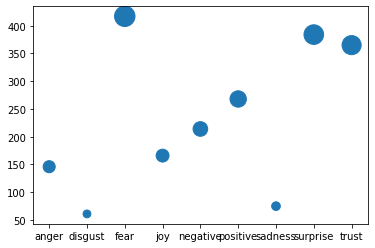

Text(0.5, 0, 'Emotion')

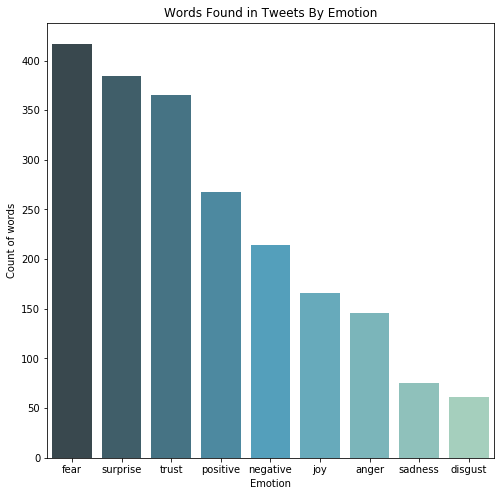

In [69]:
# declare the threshold
threshold = 0.35

df_emotion2= df_emotion[df_emotion['similarity_score']  > threshold]

x = sorted(df_emotion2['emotion_words'].unique().tolist())
y = df_emotion2['tweet_words'].groupby(df_emotion2['emotion_words']).size().tolist()

emotion_plot = pd.DataFrame(list(zip(x, y)), columns =['emotion_words', 'count'])

#######################################################################################

# scatter plot
plt.scatter(x, y,s= y*10000)
plt.show()

#######################################################################################

#Plot bar graph for emotional engagement
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
sns_plot = sns.barplot(x="emotion_words", y = "count", data=emotion_plot.sort_values(by = 'count', ascending= False),
                 palette="GnBu_d")
ax.set_title("Words Found in Tweets By Emotion")
plt.ylabel('Count of words')
plt.xlabel('Emotion')

#######################################################################################


### Conclusion on Emotion Classification

If you look at the words classified by emotions, this doesn't look so accurate as there is no package like get_nrc_sentiment() in R. It needs to build Deep Learning concepts in depth to convert the words accurately. Still en_core_web_md module in spacy gives somewhat accurate as compared to en_core_web_sm, but you can also use en_core_web_lg(~800mb) if you have faster servers or processors. If you know more accurate way then let me know, it would be helpful.